# Binary Classification: are this two documents from the same desafio?

Objectivos:

        Evaluar la capacidad de un modelo de identificar si dos documentos provienen del mismo desafio.

        Utilizando BERT y PCA

### Preprocess

In [1]:
path_to_MyModule = '..'

import sys
sys.path.insert(0, path_to_MyModule) 

import pandas as pd
import numpy as np

from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, ExtraTreesClassifier, AdaBoostClassifier, GradientBoostingClassifier

from sklearn.tree import DecisionTreeClassifier

from xgboost.sklearn import XGBClassifier
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier

from MyModule.GeneralFunctions import *
from MyModule.SummarizationFunctions import *
from MyModule.SamplingFunctions import *

In [2]:
df = pd.read_excel('..\datos.xlsx')[['ID','texto','desafio']]

In [3]:
# Limpieza
df.drop_duplicates(subset='texto', inplace=True)

# Quitando texto de mas en columna "desafio"
df['desafio'] = df['desafio'].apply(lambda x: re.findall('[0-9]+', x)[0])

# A str
df['texto'] = df['texto'].astype(str)

df.reset_index(inplace=True, drop=True)

### Create target variable: 
True if the pair comes from the same desafio, false otherwise

In [9]:
# Create a list of tuples containing all possible pairs of strings and ID's
import itertools
id_pairs = list(itertools.combinations(df['ID'].values, 2))

In [10]:
# Create target: 1 if both ID's are from the same desafio, 0 otherwise
target = []
for id1, id2 in id_pairs:
    for desafio in df['desafio'].unique():
        ids_desafio = df[df['desafio']==desafio]['ID'].values
        if id1 in ids_desafio and id2 in ids_desafio:
            target.append(1)
            break
        elif id1 in ids_desafio or id2 in ids_desafio:
            target.append(0)
            break

In [11]:
df_predic = pd.DataFrame([id_pairs, target]).T
df_predic.columns = ['id_pairs','target']

# Are this two ideas from the same desafio?

## Sentence embedding feature

Create a sentence embedding for each document

Alternatives:

1. One column for each of the 768 D
2. Same but first reduce dimension with PCA or Lasso/Ridge

In [12]:
model = SentenceTransformer('hiiamsid/sentence_similarity_spanish_es')

In [13]:
original_documents = df['texto'].values

pp_object = Preprocess(lemma=False, stopwords=False, alphanumeric=False, join=False)

pp_documents = pp_object.preprocess(original_documents)

emb_docs = model.encode(pp_documents)

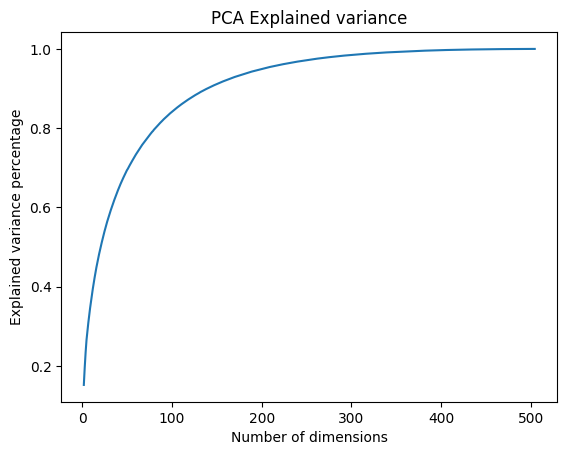

In [24]:
# Evaluate optimum N_Dimensions
from sklearn.decomposition import PCA

range_n_dimensions = range(2, min(emb_docs.shape[0], emb_docs.shape[1]))

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    explained_var = []
    for num_d in range_n_dimensions:
        pca = PCA(n_components=num_d)
        pca.fit(emb_docs)
        explained_var.append(sum(pca.explained_variance_ratio_))

# add a label for the maximum X value    
plt.plot(range_n_dimensions, explained_var)    
plt.xlabel('Number of dimensions') 
plt.ylabel('Explained variance percentage') 
plt.title('PCA Explained variance')
plt.show()

In [14]:
# Change N dimensions
pca = PCA(n_components=300)
emb_docs = pca.fit_transform(emb_docs)

In [15]:
# Add as featrues the document vectors for each document in the pair

first_doc_emb = []
second_doc_emb = []

for pair1, pair2 in df_predic['id_pairs'].values:
    
    indice_pair1 = df[df['ID']==pair1].index[0]
    first_doc_emb.append(emb_docs[indice_pair1])
    
    indice_pair2 = df[df['ID']==pair2].index[0]
    second_doc_emb.append(emb_docs[indice_pair2])
    

# create dataframe
df_emb_1 = pd.DataFrame(first_doc_emb)
df_emb_2 = pd.DataFrame(second_doc_emb)

# rename columns
df_emb_1.columns = [f'first_doc_emb_dim_{i+1}' for i in range(len(first_doc_emb[0]))]
df_emb_2.columns = [f'second_doc_emb_dim_{i+1}' for i in range(len(second_doc_emb[0]))]
df_emb = df_emb_1.join(df_emb_2)

# join with main df
df_predic = df_predic.join(df_emb)

## Sentiment Analysis feature

Evaluate positive, negative and neutral sentiment for each document

In [16]:
# Analyze the three sentiments for each doc
from MyModule.SentimentAnalysisFunctions import sentiment_analyzer_3d

all_emotions = {}
analyzer = sentiment_analyzer_3d()

for i, this_id in enumerate(df['ID'].values):
    # print('Doing {} of {}'.format(i, len(df['ID'].values)))
    all_emotions[this_id] = analyzer.predict_sentiment_3d(pp_documents[i])

In [17]:
# Add as featrues the document vectors for each document in the pair

first_doc_pos = []
first_doc_neg = []
first_doc_neu = []

second_doc_pos = []
second_doc_neg = []
second_doc_neu = []

for pair1, pair2 in df_predic['id_pairs'].values:
    
    first_doc_pos.append(all_emotions[pair1][0])
    first_doc_neg.append(all_emotions[pair1][1])
    first_doc_neu.append(all_emotions[pair1][2])
    
    second_doc_pos.append(all_emotions[pair2][0])
    second_doc_neg.append(all_emotions[pair2][1])
    second_doc_neu.append(all_emotions[pair2][2])
    

df_predic['first_doc_pos'] = first_doc_pos
df_predic['first_doc_neg'] = first_doc_neg
df_predic['first_doc_neu'] = first_doc_neu

df_predic['second_doc_pos'] = second_doc_pos
df_predic['second_doc_neg'] = second_doc_neg
df_predic['second_doc_neu'] = second_doc_neu


## Document's Length Feature

Compute document length 

In [18]:
all_lengths = {}

for i, this_id in enumerate(df['ID'].values):
    all_lengths[this_id] = len(df['texto'][i].split(' '))

In [19]:
first_doc_len = []
second_doc_len = []

for pair1, pair2 in df_predic['id_pairs'].values:
    
    first_doc_len.append(all_lengths[pair1])
    second_doc_len.append(all_lengths[pair2])

df_predic['first_doc_len'] = first_doc_len
df_predic['second_doc_len'] = second_doc_len

In [20]:
#checkpoint
df_predic.to_csv('df_predic_reduced_300d.csv', index=False)

# Modeling

In [4]:
semilla = 2023

In [5]:
# Load dfs
df_predic = pd.read_csv('./Datasets/df_predic_reduced_300d.csv')
df_predic['id_pairs'] = df_predic['id_pairs'].apply(lambda x: string_to_tuple(x)) # recovering tuples

In [6]:
# Helpers

from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

def print_performance(y_test, y_pred, y_proba=None):
    # accuracy: (tp + tn) / (p + n)
    accuracy = accuracy_score(y_test, y_pred)
    print('Accuracy: %f' % accuracy)

    # precision tp / (tp + fp)
    precision = precision_score(y_test, y_pred)
    print('Precision: %f' % precision)

    # recall: tp / (tp + fn)
    recall = recall_score(y_test, y_pred)
    print('Recall: %f' % recall)

    # f1: 2 tp / (2 tp + fp + fn)
    f1 = f1_score(y_test, y_pred)
    print('F1 score: %f' % f1)
    
    # ROC
    logit_roc_auc = roc_auc_score(y_test, y_pred)
    print('AUC: %f' % logit_roc_auc)
    
    try:
        fpr, tpr, thresholds = roc_curve(y_test, y_proba[:,1])
        
        plt.figure()
        plt.plot(fpr, tpr, label='AUC: %0.2f' % logit_roc_auc)
        plt.plot([0, 1], [0, 1],'r--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.legend(loc="lower right")
        plt.savefig('Log_ROC')
        plt.show()
    except:
        pass
    

import pickle
def save_model(model, filename):
    pickle.dump(model, open(filename, 'wb'))

def load_model(filename): 
    loaded_model = pickle.load(open(filename, 'rb'))
    return loaded_model

### Scaling

Since features have different scales

In [7]:
#Importamos StandardScaler de la libreria sklear
from sklearn.preprocessing import StandardScaler

# Instanciamos la funcion para escalar
scaler = StandardScaler()

#Escalamos las variables
scaled = scaler.fit_transform(df_predic.drop(['id_pairs','target'], axis=1))
df_predic_scaled = pd.DataFrame(scaled, columns = df_predic.columns[2:])
df_predic_scaled = df_predic_scaled.join(df_predic[['id_pairs','target']])

### Train-test split

80% train

In [8]:
from sklearn.model_selection import train_test_split

# Partición en train y test
y = df_predic_scaled.loc[:, df_predic_scaled.columns == 'target']['target'].values.tolist()
X = df_predic_scaled.loc[:, df_predic_scaled.columns != 'target'].drop('id_pairs', axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=semilla)

### Balanceo de clases SMOTE

In [43]:
from imblearn.over_sampling import SMOTE
os = SMOTE(random_state=semilla)

In [44]:
columns = X_train.columns
os_data_X, os_data_y = os.fit_resample(X_train, y_train)

os_data_X = pd.DataFrame(data=os_data_X,columns=columns )
os_data_y= pd.DataFrame(data=os_data_y,columns=['target'])

In [45]:
print("length of oversampled data is ",len(os_data_X))
print("Number of 0 in oversampled data",len(os_data_y[os_data_y['target']==0]))
print("Number of 1",len(os_data_y[os_data_y['target']==1]))
print("Proportion of 0 data in oversampled data is ",len(os_data_y[os_data_y['target']==0])/len(os_data_X))
print("Proportion of 1 data in oversampled data is ",len(os_data_y[os_data_y['target']==1])/len(os_data_X))

length of oversampled data is  173982
Number of 0 in oversampled data 86991
Number of 1 86991
Proportion of 0 data in oversampled data is  0.5
Proportion of 1 data in oversampled data is  0.5


### Balanceo de clases: subsampleo de clase mayoritaria

In [9]:
train = X_train
train['target'] = y_train

positivos = train[train.target == 1]
negativos = train[train.target == 0]

negativos_sub = negativos.sample(n=len(positivos), random_state=semilla)

train_sub = pd.concat([positivos, negativos_sub])

y_train = train_sub.loc[:, train_sub.columns == 'target']
X_train = train_sub.loc[:, train_sub.columns != 'target']
print(len(positivos), len(negativos_sub))

14817 14817


## 1. Logistic Regression

### Simple Logistic Regression

In [24]:
from sklearn.linear_model import LogisticRegression

In [25]:
# instancia del modelo
logisticRegr = LogisticRegression(max_iter=10000, fit_intercept=True)

# entrenamiento
logisticRegr.fit(X_train, y_train)

# basic performance
y_pred = logisticRegr.predict(X_test)

c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\utils\validation.py:1141: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [26]:
# Claramente las clases estan desbalanceadas
targets = df_predic_scaled['target'].value_counts()
print(f'Percentage of class 0: {targets[0]/sum(targets)}')
print(f'Train accuracy: {round(logisticRegr.score(X_train,y_train), 2)}')
print_performance(y_test, y_pred)

Percentage of class 0: 0.8544397296872545
Train accuracy: 0.57
Accuracy: 0.531000
Precision: 0.172216
Recall: 0.583221
F1 score: 0.265912
AUC: 0.552659


### Logistic Regression with balanced classes

In [50]:
# entrenamiento
logisticRegr.fit(os_data_X, os_data_y)

# basic performance
y_pred = logisticRegr.predict(X_test)

c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\utils\validation.py:1141: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [51]:
print_performance(y_test, y_pred)

Accuracy: 0.588205
Precision: 0.170909
Recall: 0.474508
F1 score: 0.251304
AUC: 0.541048


## 2. SGDClassifier

In [27]:
#Importamos el modelo y algunas funciones auxiliares
from sklearn.model_selection import RandomizedSearchCV
from sklearn.utils.fixes import loguniform
import scipy.stats as stats

from sklearn.linear_model import  SGDClassifier

In [28]:
sgd_classifier = SGDClassifier()

In [29]:
# Definimos los parametros
sgd_parametros={'loss': ['hinge','log_loss','modified_hube','squared_hinge','perceptron'],
            'penalty': ['l2', 'l1', 'elasticnet', None],
             'alpha': loguniform(1e-4, 1e0),
             'l1_ratio':stats.uniform(0, 1)
        }

In [30]:
#Ajustamos el modelo
cv = 3
n_iteraciones = 20

sgd_classifier = SGDClassifier()
sgd_random_search = RandomizedSearchCV(estimator=sgd_classifier, n_iter = n_iteraciones, param_distributions = sgd_parametros,
                                   cv = cv, scoring ='accuracy', random_state = semilla )
sgd_random_search.fit(X_train, y_train)

print('Mejor combinación de parámetros %s \n'% sgd_random_search.best_params_)
print('Definición del Modelo %s \n'% sgd_random_search.best_estimator_)
print('Combinaciones Evaluadas %s '% sgd_random_search)

c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\utils\validation.py:1141: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\utils\validation.py:1141: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\utils\validation.py:1141: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\utils\validation.py:1141: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_

Mejor combinación de parámetros {'alpha': 0.00999550089604053, 'l1_ratio': 0.3642569891908011, 'loss': 'hinge', 'penalty': 'l2'} 

Definición del Modelo SGDClassifier(alpha=0.00999550089604053, l1_ratio=0.3642569891908011) 

Combinaciones Evaluadas RandomizedSearchCV(cv=3, estimator=SGDClassifier(), n_iter=20,
                   param_distributions={'alpha': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x0000026898D6B3A0>,
                                        'l1_ratio': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x000002678788DEB0>,
                                        'loss': ['hinge', 'log_loss',
                                                 'modified_hube',
                                                 'squared_hinge',
                                                 'perceptron'],
                                        'penalty': ['l2', 'l1', 'elasticnet',
                                                    None]},
         

In [31]:
y_pred = sgd_random_search.best_estimator_.predict(X_test)
print(f'Train accuracy: {round(sgd_random_search.best_score_,2)}')
print_performance(y_test, y_pred)

Train accuracy: 0.56
Accuracy: 0.519370
Precision: 0.178652
Recall: 0.639331
F1 score: 0.279267
AUC: 0.569125


## 3. KNN

In [32]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV

In [33]:
# instanciemos y entrenemos el modelo
knn_model = KNeighborsClassifier(n_neighbors=10,weights='uniform')
knn_model.fit(X_train, y_train)

print(f'Train accuracy: {round(knn_model.score(X_train,y_train), 2)}')

y_pred = knn_model.predict(X_test)
print_performance(y_test, y_pred)

c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\neighbors\_classification.py:215: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


Train accuracy: 0.7
Accuracy: 0.675193
Precision: 0.240909
Recall: 0.571891
F1 score: 0.339010
AUC: 0.632347


In [34]:
# Definimos los parametros
knn_parametros={'n_neighbors':list(range(1, 20)),
                'weights':['uniform', 'distance'],
                'metric':['euclidean', 'chebyshev', 'manhattan']
        }

In [35]:
#Ajustamos el modelo
cv = 3

knn_classifier = KNeighborsClassifier()
knn_grid_search = GridSearchCV(estimator=knn_classifier, param_grid = knn_parametros,
                                   cv=cv, scoring ='accuracy')
knn_grid_search.fit(X_train, y_train)

c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\neighbors\_classification.py:215: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\neighbors\_classification.py:215: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\neighbors\_classification.py:215: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\neighbors\_classification.py:215: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y t

GridSearchCV(cv=3, estimator=KNeighborsClassifier(),
             param_grid={'metric': ['euclidean', 'chebyshev', 'manhattan'],
                         'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12,
                                         13, 14, 15, 16, 17, 18, 19],
                         'weights': ['uniform', 'distance']},
             scoring='accuracy')

In [36]:
print('Mejor combinación de parámetros %s \n'% knn_grid_search.best_params_)
print('Definición del Modelo %s \n'% knn_grid_search.best_estimator_)

Mejor combinación de parámetros {'metric': 'euclidean', 'n_neighbors': 1, 'weights': 'uniform'} 

Definición del Modelo KNeighborsClassifier(metric='euclidean', n_neighbors=1) 



Train accuracy: 0.66
Accuracy: 0.668199
Precision: 0.259444
Recall: 0.689237
F1 score: 0.376983
AUC: 0.676925


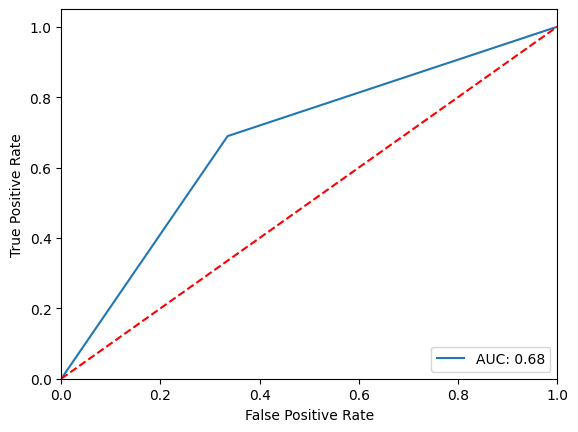

In [37]:
y_pred = knn_grid_search.predict(X_test)
y_pred_proba = knn_grid_search.predict_proba(X_test)
print(f'Train accuracy: {round(knn_grid_search.best_score_, 2)}')
print_performance(y_test, y_pred, y_pred_proba)

## 4. DecisionTree

### 4.a Simple DecisionTree

In [38]:
# instanciemos el modelo y entremoslo en el conjunto de autos
arbol = DecisionTreeClassifier(criterion='gini', max_depth=2, min_samples_leaf=1, min_samples_split=2, ccp_alpha=0)
arbol.fit(X_train,y_train)
print(f'Train accuracy: {round(arbol.score(X_train,y_train), 2)}')
y_pred = arbol.predict(X_test)
print_performance(y_test, y_pred)

Train accuracy: 0.58
Accuracy: 0.481534
Precision: 0.183299
Recall: 0.740761
F1 score: 0.293878
AUC: 0.589051


In [64]:
# calculando las 5 feature importances mas altas
importances = pd.Series(arbol.feature_importances_).sort_values(ascending=False)[:15]

C:\Users\Felipe\AppData\Local\Temp\ipykernel_16024\3721313899.py:2: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  importances = pd.Series(arbol.feature_importances_).sort_values(ascending=False)[:15]


In [65]:
f5_names = list(pd.Series(X_train.feature_names)[importances.index.to_list()])
fig, ax = plt.subplots()
importances.plot.barh(ax=ax)
ax.set_yticklabels(f5_names)
ax.invert_yaxis()

AttributeError: 'DataFrame' object has no attribute 'feature_names'

### 4.b DecisionTree hyperparameter opt

In [39]:
dt_parameters = {
    'max_depth' : [1, 2, 3, 10, 30, 100],
    'min_samples_split':list(range(2, 40)),
    'min_samples_leaf':list(range(2, 40)),
    'max_features':['None','auto', 'sqrt', 'log2'],
    'max_leaf_nodes':list(range(10, 60))
}

n_iter = 40
cv = 3

dt_tree = DecisionTreeClassifier()

dt_grid_search = RandomizedSearchCV(estimator=dt_tree, 
                                         param_distributions=dt_parameters, n_iter=n_iter, cv=cv, scoring='accuracy', verbose=2)

dt_grid_search.fit(X_train, y_train)

Fitting 3 folds for each of 40 candidates, totalling 120 fits
[CV] END max_depth=2, max_features=None, max_leaf_nodes=53, min_samples_leaf=22, min_samples_split=22; total time=   0.0s
[CV] END max_depth=2, max_features=None, max_leaf_nodes=53, min_samples_leaf=22, min_samples_split=22; total time=   0.0s
[CV] END max_depth=2, max_features=None, max_leaf_nodes=53, min_samples_leaf=22, min_samples_split=22; total time=   0.0s
[CV] END max_depth=1, max_features=sqrt, max_leaf_nodes=56, min_samples_leaf=29, min_samples_split=22; total time=   0.0s
[CV] END max_depth=1, max_features=sqrt, max_leaf_nodes=56, min_samples_leaf=29, min_samples_split=22; total time=   0.0s
[CV] END max_depth=1, max_features=sqrt, max_leaf_nodes=56, min_samples_leaf=29, min_samples_split=22; total time=   0.0s
[CV] END max_depth=10, max_features=None, max_leaf_nodes=30, min_samples_leaf=37, min_samples_split=29; total time=   0.0s
[CV] END max_depth=10, max_features=None, max_leaf_nodes=30, min_samples_leaf=37, m

c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\tree\_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\tree\_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\tree\_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(


[CV] END max_depth=1, max_features=auto, max_leaf_nodes=41, min_samples_leaf=25, min_samples_split=38; total time=   0.0s
[CV] END max_depth=30, max_features=sqrt, max_leaf_nodes=56, min_samples_leaf=29, min_samples_split=28; total time=   0.1s
[CV] END max_depth=30, max_features=sqrt, max_leaf_nodes=56, min_samples_leaf=29, min_samples_split=28; total time=   0.1s
[CV] END max_depth=30, max_features=sqrt, max_leaf_nodes=56, min_samples_leaf=29, min_samples_split=28; total time=   0.1s
[CV] END max_depth=100, max_features=sqrt, max_leaf_nodes=15, min_samples_leaf=33, min_samples_split=28; total time=   0.0s
[CV] END max_depth=100, max_features=sqrt, max_leaf_nodes=15, min_samples_leaf=33, min_samples_split=28; total time=   0.0s
[CV] END max_depth=100, max_features=sqrt, max_leaf_nodes=15, min_samples_leaf=33, min_samples_split=28; total time=   0.0s
[CV] END max_depth=100, max_features=auto, max_leaf_nodes=21, min_samples_leaf=13, min_samples_split=35; total time=   0.0s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\tree\_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\tree\_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(


[CV] END max_depth=100, max_features=auto, max_leaf_nodes=21, min_samples_leaf=13, min_samples_split=35; total time=   0.1s
[CV] END max_depth=100, max_features=auto, max_leaf_nodes=21, min_samples_leaf=13, min_samples_split=35; total time=   0.1s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\tree\_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\tree\_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(


[CV] END max_depth=10, max_features=auto, max_leaf_nodes=27, min_samples_leaf=24, min_samples_split=34; total time=   0.1s
[CV] END max_depth=10, max_features=auto, max_leaf_nodes=27, min_samples_leaf=24, min_samples_split=34; total time=   0.1s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\tree\_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\tree\_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(


[CV] END max_depth=10, max_features=auto, max_leaf_nodes=27, min_samples_leaf=24, min_samples_split=34; total time=   0.1s
[CV] END max_depth=1, max_features=sqrt, max_leaf_nodes=45, min_samples_leaf=8, min_samples_split=19; total time=   0.0s
[CV] END max_depth=1, max_features=sqrt, max_leaf_nodes=45, min_samples_leaf=8, min_samples_split=19; total time=   0.0s
[CV] END max_depth=1, max_features=sqrt, max_leaf_nodes=45, min_samples_leaf=8, min_samples_split=19; total time=   0.0s
[CV] END max_depth=30, max_features=sqrt, max_leaf_nodes=10, min_samples_leaf=5, min_samples_split=23; total time=   0.0s
[CV] END max_depth=30, max_features=sqrt, max_leaf_nodes=10, min_samples_leaf=5, min_samples_split=23; total time=   0.0s
[CV] END max_depth=30, max_features=sqrt, max_leaf_nodes=10, min_samples_leaf=5, min_samples_split=23; total time=   0.1s
[CV] END max_depth=30, max_features=sqrt, max_leaf_nodes=43, min_samples_leaf=13, min_samples_split=12; total time=   0.1s
[CV] END max_depth=30, ma

c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\tree\_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\tree\_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(


[CV] END max_depth=100, max_features=auto, max_leaf_nodes=15, min_samples_leaf=38, min_samples_split=18; total time=   0.0s
[CV] END max_depth=100, max_features=auto, max_leaf_nodes=15, min_samples_leaf=38, min_samples_split=18; total time=   0.0s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\tree\_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(


[CV] END max_depth=100, max_features=auto, max_leaf_nodes=15, min_samples_leaf=38, min_samples_split=18; total time=   0.1s
[CV] END max_depth=100, max_features=None, max_leaf_nodes=33, min_samples_leaf=30, min_samples_split=14; total time=   0.0s
[CV] END max_depth=100, max_features=None, max_leaf_nodes=33, min_samples_leaf=30, min_samples_split=14; total time=   0.0s
[CV] END max_depth=100, max_features=None, max_leaf_nodes=33, min_samples_leaf=30, min_samples_split=14; total time=   0.0s
[CV] END max_depth=100, max_features=None, max_leaf_nodes=28, min_samples_leaf=34, min_samples_split=6; total time=   0.0s
[CV] END max_depth=100, max_features=None, max_leaf_nodes=28, min_samples_leaf=34, min_samples_split=6; total time=   0.0s
[CV] END max_depth=100, max_features=None, max_leaf_nodes=28, min_samples_leaf=34, min_samples_split=6; total time=   0.0s
[CV] END max_depth=100, max_features=None, max_leaf_nodes=46, min_samples_leaf=27, min_samples_split=14; total time=   0.0s
[CV] END ma

c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\tree\_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\tree\_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\tree\_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(


[CV] END max_depth=1, max_features=auto, max_leaf_nodes=52, min_samples_leaf=36, min_samples_split=21; total time=   0.0s
[CV] END max_depth=1, max_features=auto, max_leaf_nodes=52, min_samples_leaf=36, min_samples_split=21; total time=   0.0s
[CV] END max_depth=1, max_features=log2, max_leaf_nodes=54, min_samples_leaf=5, min_samples_split=33; total time=   0.0s
[CV] END max_depth=1, max_features=log2, max_leaf_nodes=54, min_samples_leaf=5, min_samples_split=33; total time=   0.0s
[CV] END max_depth=1, max_features=log2, max_leaf_nodes=54, min_samples_leaf=5, min_samples_split=33; total time=   0.0s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\tree\_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\tree\_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(


[CV] END max_depth=100, max_features=auto, max_leaf_nodes=55, min_samples_leaf=8, min_samples_split=38; total time=   0.1s
[CV] END max_depth=100, max_features=auto, max_leaf_nodes=55, min_samples_leaf=8, min_samples_split=38; total time=   0.1s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\tree\_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(


[CV] END max_depth=100, max_features=auto, max_leaf_nodes=55, min_samples_leaf=8, min_samples_split=38; total time=   0.1s
[CV] END max_depth=1, max_features=log2, max_leaf_nodes=49, min_samples_leaf=18, min_samples_split=5; total time=   0.0s
[CV] END max_depth=1, max_features=log2, max_leaf_nodes=49, min_samples_leaf=18, min_samples_split=5; total time=   0.0s
[CV] END max_depth=1, max_features=log2, max_leaf_nodes=49, min_samples_leaf=18, min_samples_split=5; total time=   0.0s
[CV] END max_depth=100, max_features=log2, max_leaf_nodes=29, min_samples_leaf=29, min_samples_split=20; total time=   0.0s
[CV] END max_depth=100, max_features=log2, max_leaf_nodes=29, min_samples_leaf=29, min_samples_split=20; total time=   0.0s
[CV] END max_depth=100, max_features=log2, max_leaf_nodes=29, min_samples_leaf=29, min_samples_split=20; total time=   0.0s
[CV] END max_depth=3, max_features=sqrt, max_leaf_nodes=51, min_samples_leaf=38, min_samples_split=6; total time=   0.0s
[CV] END max_depth=3,

c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\tree\_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\tree\_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(


[CV] END max_depth=3, max_features=auto, max_leaf_nodes=39, min_samples_leaf=18, min_samples_split=15; total time=   0.0s
[CV] END max_depth=3, max_features=auto, max_leaf_nodes=39, min_samples_leaf=18, min_samples_split=15; total time=   0.0s
[CV] END max_depth=10, max_features=None, max_leaf_nodes=29, min_samples_leaf=8, min_samples_split=24; total time=   0.0s
[CV] END max_depth=10, max_features=None, max_leaf_nodes=29, min_samples_leaf=8, min_samples_split=24; total time=   0.0s
[CV] END max_depth=10, max_features=None, max_leaf_nodes=29, min_samples_leaf=8, min_samples_split=24; total time=   0.0s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\tree\_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(


[CV] END max_depth=1, max_features=sqrt, max_leaf_nodes=16, min_samples_leaf=39, min_samples_split=4; total time=   0.0s
[CV] END max_depth=1, max_features=sqrt, max_leaf_nodes=16, min_samples_leaf=39, min_samples_split=4; total time=   0.0s
[CV] END max_depth=1, max_features=sqrt, max_leaf_nodes=16, min_samples_leaf=39, min_samples_split=4; total time=   0.0s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\tree\_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\tree\_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\tree\_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(


[CV] END max_depth=2, max_features=auto, max_leaf_nodes=41, min_samples_leaf=26, min_samples_split=17; total time=   0.0s
[CV] END max_depth=2, max_features=auto, max_leaf_nodes=41, min_samples_leaf=26, min_samples_split=17; total time=   0.0s
[CV] END max_depth=2, max_features=auto, max_leaf_nodes=41, min_samples_leaf=26, min_samples_split=17; total time=   0.0s
[CV] END max_depth=2, max_features=log2, max_leaf_nodes=23, min_samples_leaf=27, min_samples_split=17; total time=   0.0s
[CV] END max_depth=2, max_features=log2, max_leaf_nodes=23, min_samples_leaf=27, min_samples_split=17; total time=   0.0s
[CV] END max_depth=2, max_features=log2, max_leaf_nodes=23, min_samples_leaf=27, min_samples_split=17; total time=   0.0s
[CV] END max_depth=10, max_features=sqrt, max_leaf_nodes=55, min_samples_leaf=37, min_samples_split=9; total time=   0.1s
[CV] END max_depth=10, max_features=sqrt, max_leaf_nodes=55, min_samples_leaf=37, min_samples_split=9; total time=   0.1s
[CV] END max_depth=10, m

c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:378: FitFailedWarning: 
30 fits failed out of a total of 120.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
30 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\tree\_classes.py", line 889, in fit
    super().fit(
  File "c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\tree\_classes.py", line 177, in fit
    self._validate_params()
  File "c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\base.

RandomizedSearchCV(cv=3, estimator=DecisionTreeClassifier(), n_iter=40,
                   param_distributions={'max_depth': [1, 2, 3, 10, 30, 100],
                                        'max_features': ['None', 'auto', 'sqrt',
                                                         'log2'],
                                        'max_leaf_nodes': [10, 11, 12, 13, 14,
                                                           15, 16, 17, 18, 19,
                                                           20, 21, 22, 23, 24,
                                                           25, 26, 27, 28, 29,
                                                           30, 31, 32, 33, 34,
                                                           35, 36, 37, 38, 39, ...],
                                        'min_samples_leaf': [2, 3, 4, 5, 6, 7,
                                                             8, 9, 10, 11, 12,
                                                             13, 14, 15, 16, 17,
                                                             18, 19, 20, 21, 22,
                                                             23, 24, 25, 26, 27,
                                                             28, 29, 30, 31, ...],
                                        'min_samples_split': [2, 3, 4, 5, 6, 7,
                                                              8, 9, 10, 11, 12,
                                                              13, 14, 15, 16,
                                                              17, 18, 19, 20,
                                                              21, 22, 23, 24,
                                                              25, 26, 27, 28,
                                                              29, 30, 31, ...]},
                   scoring='accuracy', verbose=2)

In [40]:
# This suggests overfitting
print('train accuracy:',dt_grid_search.best_score_, dt_grid_search.best_params_, '\n')

y_pred = dt_grid_search.predict(X_test)
print_performance(y_test, y_pred)

train accuracy: 0.5989066612674631 {'min_samples_split': 28, 'min_samples_leaf': 29, 'max_leaf_nodes': 56, 'max_features': 'sqrt', 'max_depth': 30} 

Accuracy: 0.569936
Precision: 0.217778
Recall: 0.753439
F1 score: 0.337890
AUC: 0.646046


## 5. RandomForestClassifier

### 5.a Simple RandomForestClassifier

C:\Users\Felipe\AppData\Local\Temp\ipykernel_17168\3576490733.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_classifier.fit(X_train,y_train)


Train accuracy: 1.0
Accuracy: 0.890382
Precision: 0.576302
Recall: 0.934179
F1 score: 0.712845
AUC: 0.908547


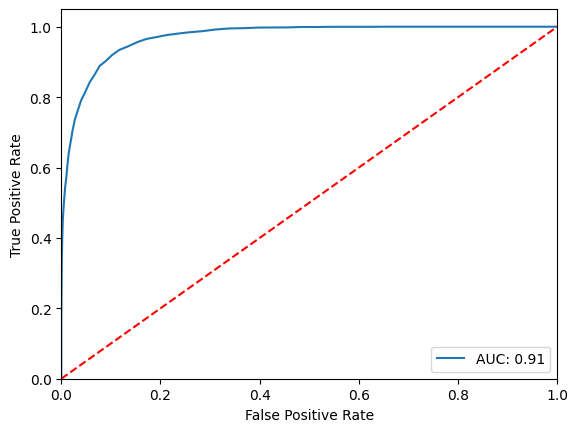

In [41]:
rf_classifier = RandomForestClassifier()
rf_classifier.fit(X_train,y_train)

y_pred = rf_classifier.predict(X_test)
y_pred_proba = rf_classifier.predict_proba(X_test)
print(f'Train accuracy: {round(rf_classifier.score(X_train,y_train), 2)}')
print_performance(y_test, y_pred, y_pred_proba)

### 5.b RandomForestClassifier hyperparameter opt

In [69]:
rf_parameters = {
    'n_estimators':range(10,500),
    'criterion':['gini', 'entropy', 'log_loss'],
    'max_depth' : [30, 100, 150, 250, 350, 550],
    'min_samples_split':list(range(2, 40)),
    'min_samples_leaf':list(range(2, 40)),
    'max_features':['None','auto', 'sqrt', 'log2'],
    # 'max_leaf_nodes':list(range(10, 100))
}

n_iter = 50
cv = 3

rf_tree = RandomForestClassifier()

rf_randomized_search = RandomizedSearchCV(estimator=rf_tree, 
                                         param_distributions=rf_parameters, n_iter=n_iter, cv=cv, scoring='accuracy', verbose=2)

rf_randomized_search.fit(X_train, y_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END criterion=entropy, max_depth=150, max_features=sqrt, min_samples_leaf=22, min_samples_split=14, n_estimators=332; total time=  53.5s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END criterion=entropy, max_depth=150, max_features=sqrt, min_samples_leaf=22, min_samples_split=14, n_estimators=332; total time=  53.3s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END criterion=entropy, max_depth=150, max_features=sqrt, min_samples_leaf=22, min_samples_split=14, n_estimators=332; total time=  52.6s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_forest.py:425: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END criterion=gini, max_depth=150, max_features=auto, min_samples_leaf=3, min_samples_split=37, n_estimators=203; total time=  34.1s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_forest.py:425: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END criterion=gini, max_depth=150, max_features=auto, min_samples_leaf=3, min_samples_split=37, n_estimators=203; total time=  34.4s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_forest.py:425: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END criterion=gini, max_depth=150, max_features=auto, min_samples_leaf=3, min_samples_split=37, n_estimators=203; total time=  33.6s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_forest.py:425: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END criterion=gini, max_depth=100, max_features=auto, min_samples_leaf=34, min_samples_split=5, n_estimators=214; total time=  27.0s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_forest.py:425: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END criterion=gini, max_depth=100, max_features=auto, min_samples_leaf=34, min_samples_split=5, n_estimators=214; total time=  27.2s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_forest.py:425: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END criterion=gini, max_depth=100, max_features=auto, min_samples_leaf=34, min_samples_split=5, n_estimators=214; total time=  26.9s
[CV] END criterion=log_loss, max_depth=30, max_features=None, min_samples_leaf=28, min_samples_split=38, n_estimators=483; total time=   0.0s
[CV] END criterion=log_loss, max_depth=30, max_features=None, min_samples_leaf=28, min_samples_split=38, n_estimators=483; total time=   0.0s
[CV] END criterion=log_loss, max_depth=30, max_features=None, min_samples_leaf=28, min_samples_split=38, n_estimators=483; total time=   0.0s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END criterion=entropy, max_depth=550, max_features=log2, min_samples_leaf=2, min_samples_split=27, n_estimators=298; total time=  28.1s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END criterion=entropy, max_depth=550, max_features=log2, min_samples_leaf=2, min_samples_split=27, n_estimators=298; total time=  28.1s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END criterion=entropy, max_depth=550, max_features=log2, min_samples_leaf=2, min_samples_split=27, n_estimators=298; total time=  28.0s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_forest.py:425: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END criterion=entropy, max_depth=100, max_features=auto, min_samples_leaf=33, min_samples_split=37, n_estimators=403; total time=  57.4s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_forest.py:425: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END criterion=entropy, max_depth=100, max_features=auto, min_samples_leaf=33, min_samples_split=37, n_estimators=403; total time=  58.4s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_forest.py:425: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END criterion=entropy, max_depth=100, max_features=auto, min_samples_leaf=33, min_samples_split=37, n_estimators=403; total time=  56.8s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END criterion=entropy, max_depth=30, max_features=log2, min_samples_leaf=25, min_samples_split=2, n_estimators=269; total time=  18.3s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END criterion=entropy, max_depth=30, max_features=log2, min_samples_leaf=25, min_samples_split=2, n_estimators=269; total time=  18.1s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END criterion=entropy, max_depth=30, max_features=log2, min_samples_leaf=25, min_samples_split=2, n_estimators=269; total time=  17.8s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END criterion=gini, max_depth=250, max_features=sqrt, min_samples_leaf=29, min_samples_split=29, n_estimators=158; total time=  20.8s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END criterion=gini, max_depth=250, max_features=sqrt, min_samples_leaf=29, min_samples_split=29, n_estimators=158; total time=  21.4s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END criterion=gini, max_depth=250, max_features=sqrt, min_samples_leaf=29, min_samples_split=29, n_estimators=158; total time=  20.7s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END criterion=gini, max_depth=250, max_features=log2, min_samples_leaf=6, min_samples_split=27, n_estimators=475; total time=  36.9s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END criterion=gini, max_depth=250, max_features=log2, min_samples_leaf=6, min_samples_split=27, n_estimators=475; total time=  36.8s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END criterion=gini, max_depth=250, max_features=log2, min_samples_leaf=6, min_samples_split=27, n_estimators=475; total time=  36.3s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END criterion=gini, max_depth=350, max_features=sqrt, min_samples_leaf=15, min_samples_split=15, n_estimators=308; total time=  46.5s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END criterion=gini, max_depth=350, max_features=sqrt, min_samples_leaf=15, min_samples_split=15, n_estimators=308; total time=  46.7s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END criterion=gini, max_depth=350, max_features=sqrt, min_samples_leaf=15, min_samples_split=15, n_estimators=308; total time=  46.1s
[CV] END criterion=gini, max_depth=550, max_features=None, min_samples_leaf=34, min_samples_split=38, n_estimators=290; total time=   0.0s
[CV] END criterion=gini, max_depth=550, max_features=None, min_samples_leaf=34, min_samples_split=38, n_estimators=290; total time=   0.0s
[CV] END criterion=gini, max_depth=550, max_features=None, min_samples_leaf=34, min_samples_split=38, n_estimators=290; total time=   0.0s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END criterion=entropy, max_depth=350, max_features=sqrt, min_samples_leaf=8, min_samples_split=18, n_estimators=153; total time=  30.4s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END criterion=entropy, max_depth=350, max_features=sqrt, min_samples_leaf=8, min_samples_split=18, n_estimators=153; total time=  30.5s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END criterion=entropy, max_depth=350, max_features=sqrt, min_samples_leaf=8, min_samples_split=18, n_estimators=153; total time=  30.1s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END criterion=log_loss, max_depth=550, max_features=log2, min_samples_leaf=10, min_samples_split=37, n_estimators=83; total time=   6.7s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END criterion=log_loss, max_depth=550, max_features=log2, min_samples_leaf=10, min_samples_split=37, n_estimators=83; total time=   6.8s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END criterion=log_loss, max_depth=550, max_features=log2, min_samples_leaf=10, min_samples_split=37, n_estimators=83; total time=   6.8s
[CV] END criterion=gini, max_depth=250, max_features=None, min_samples_leaf=36, min_samples_split=19, n_estimators=462; total time=   0.0s
[CV] END criterion=gini, max_depth=250, max_features=None, min_samples_leaf=36, min_samples_split=19, n_estimators=462; total time=   0.0s
[CV] END criterion=gini, max_depth=250, max_features=None, min_samples_leaf=36, min_samples_split=19, n_estimators=462; total time=   0.0s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END criterion=log_loss, max_depth=150, max_features=sqrt, min_samples_leaf=8, min_samples_split=37, n_estimators=379; total time= 1.2min


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END criterion=log_loss, max_depth=150, max_features=sqrt, min_samples_leaf=8, min_samples_split=37, n_estimators=379; total time= 1.2min


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END criterion=log_loss, max_depth=150, max_features=sqrt, min_samples_leaf=8, min_samples_split=37, n_estimators=379; total time= 1.2min


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END criterion=gini, max_depth=550, max_features=log2, min_samples_leaf=8, min_samples_split=2, n_estimators=212; total time=  15.7s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END criterion=gini, max_depth=550, max_features=log2, min_samples_leaf=8, min_samples_split=2, n_estimators=212; total time=  15.8s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END criterion=gini, max_depth=550, max_features=log2, min_samples_leaf=8, min_samples_split=2, n_estimators=212; total time=  15.9s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_forest.py:425: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END criterion=gini, max_depth=100, max_features=auto, min_samples_leaf=6, min_samples_split=2, n_estimators=330; total time=  58.0s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_forest.py:425: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END criterion=gini, max_depth=100, max_features=auto, min_samples_leaf=6, min_samples_split=2, n_estimators=330; total time=  57.9s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_forest.py:425: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END criterion=gini, max_depth=100, max_features=auto, min_samples_leaf=6, min_samples_split=2, n_estimators=330; total time=  57.0s
[CV] END criterion=entropy, max_depth=30, max_features=None, min_samples_leaf=35, min_samples_split=16, n_estimators=282; total time=   0.0s
[CV] END criterion=entropy, max_depth=30, max_features=None, min_samples_leaf=35, min_samples_split=16, n_estimators=282; total time=   0.0s
[CV] END criterion=entropy, max_depth=30, max_features=None, min_samples_leaf=35, min_samples_split=16, n_estimators=282; total time=   0.0s
[CV] END criterion=entropy, max_depth=250, max_features=None, min_samples_leaf=5, min_samples_split=27, n_estimators=269; total time=   0.0s
[CV] END criterion=entropy, max_depth=250, max_features=None, min_samples_leaf=5, min_samples_split=27, n_estimators=269; total time=   0.0s
[CV] END criterion=entropy, max_depth=250, max_features=None, min_samples_leaf=5, min_samples_split=27, n_estimators=269; total time=   0.0s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_forest.py:425: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END criterion=gini, max_depth=350, max_features=auto, min_samples_leaf=6, min_samples_split=7, n_estimators=438; total time= 1.3min


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_forest.py:425: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END criterion=gini, max_depth=350, max_features=auto, min_samples_leaf=6, min_samples_split=7, n_estimators=438; total time= 1.3min


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_forest.py:425: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END criterion=gini, max_depth=350, max_features=auto, min_samples_leaf=6, min_samples_split=7, n_estimators=438; total time= 1.3min


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_forest.py:425: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END criterion=log_loss, max_depth=250, max_features=auto, min_samples_leaf=36, min_samples_split=13, n_estimators=346; total time=  48.7s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_forest.py:425: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END criterion=log_loss, max_depth=250, max_features=auto, min_samples_leaf=36, min_samples_split=13, n_estimators=346; total time=  49.0s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_forest.py:425: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END criterion=log_loss, max_depth=250, max_features=auto, min_samples_leaf=36, min_samples_split=13, n_estimators=346; total time=  48.1s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END criterion=gini, max_depth=250, max_features=sqrt, min_samples_leaf=9, min_samples_split=25, n_estimators=13; total time=   2.1s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END criterion=gini, max_depth=250, max_features=sqrt, min_samples_leaf=9, min_samples_split=25, n_estimators=13; total time=   2.0s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END criterion=gini, max_depth=250, max_features=sqrt, min_samples_leaf=9, min_samples_split=25, n_estimators=13; total time=   2.0s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END criterion=log_loss, max_depth=30, max_features=sqrt, min_samples_leaf=12, min_samples_split=36, n_estimators=375; total time= 1.1min


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END criterion=log_loss, max_depth=30, max_features=sqrt, min_samples_leaf=12, min_samples_split=36, n_estimators=375; total time= 1.2min


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END criterion=log_loss, max_depth=30, max_features=sqrt, min_samples_leaf=12, min_samples_split=36, n_estimators=375; total time= 1.2min
[CV] END criterion=log_loss, max_depth=30, max_features=None, min_samples_leaf=9, min_samples_split=34, n_estimators=136; total time=   0.0s
[CV] END criterion=log_loss, max_depth=30, max_features=None, min_samples_leaf=9, min_samples_split=34, n_estimators=136; total time=   0.0s
[CV] END criterion=log_loss, max_depth=30, max_features=None, min_samples_leaf=9, min_samples_split=34, n_estimators=136; total time=   0.0s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END criterion=log_loss, max_depth=150, max_features=log2, min_samples_leaf=20, min_samples_split=21, n_estimators=258; total time=  19.1s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END criterion=log_loss, max_depth=150, max_features=log2, min_samples_leaf=20, min_samples_split=21, n_estimators=258; total time=  19.6s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END criterion=log_loss, max_depth=150, max_features=log2, min_samples_leaf=20, min_samples_split=21, n_estimators=258; total time=  18.7s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END criterion=gini, max_depth=550, max_features=sqrt, min_samples_leaf=27, min_samples_split=13, n_estimators=427; total time=  59.1s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END criterion=gini, max_depth=550, max_features=sqrt, min_samples_leaf=27, min_samples_split=13, n_estimators=427; total time=  59.0s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END criterion=gini, max_depth=550, max_features=sqrt, min_samples_leaf=27, min_samples_split=13, n_estimators=427; total time=  59.1s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END criterion=gini, max_depth=350, max_features=sqrt, min_samples_leaf=28, min_samples_split=18, n_estimators=145; total time=  19.8s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END criterion=gini, max_depth=350, max_features=sqrt, min_samples_leaf=28, min_samples_split=18, n_estimators=145; total time=  20.4s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END criterion=gini, max_depth=350, max_features=sqrt, min_samples_leaf=28, min_samples_split=18, n_estimators=145; total time=  19.4s
[CV] END criterion=entropy, max_depth=100, max_features=None, min_samples_leaf=27, min_samples_split=11, n_estimators=109; total time=   0.0s
[CV] END criterion=entropy, max_depth=100, max_features=None, min_samples_leaf=27, min_samples_split=11, n_estimators=109; total time=   0.0s
[CV] END criterion=entropy, max_depth=100, max_features=None, min_samples_leaf=27, min_samples_split=11, n_estimators=109; total time=   0.0s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END criterion=log_loss, max_depth=30, max_features=sqrt, min_samples_leaf=22, min_samples_split=19, n_estimators=376; total time= 1.0min


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END criterion=log_loss, max_depth=30, max_features=sqrt, min_samples_leaf=22, min_samples_split=19, n_estimators=376; total time= 1.1min


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END criterion=log_loss, max_depth=30, max_features=sqrt, min_samples_leaf=22, min_samples_split=19, n_estimators=376; total time= 1.0min


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END criterion=gini, max_depth=100, max_features=sqrt, min_samples_leaf=7, min_samples_split=8, n_estimators=357; total time= 1.0min


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END criterion=gini, max_depth=100, max_features=sqrt, min_samples_leaf=7, min_samples_split=8, n_estimators=357; total time= 1.1min


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END criterion=gini, max_depth=100, max_features=sqrt, min_samples_leaf=7, min_samples_split=8, n_estimators=357; total time= 1.0min


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_forest.py:425: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END criterion=log_loss, max_depth=350, max_features=auto, min_samples_leaf=29, min_samples_split=36, n_estimators=170; total time=  26.2s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_forest.py:425: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END criterion=log_loss, max_depth=350, max_features=auto, min_samples_leaf=29, min_samples_split=36, n_estimators=170; total time=  26.1s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_forest.py:425: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END criterion=log_loss, max_depth=350, max_features=auto, min_samples_leaf=29, min_samples_split=36, n_estimators=170; total time=  26.0s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_forest.py:425: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END criterion=entropy, max_depth=550, max_features=auto, min_samples_leaf=16, min_samples_split=30, n_estimators=99; total time=  17.4s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_forest.py:425: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END criterion=entropy, max_depth=550, max_features=auto, min_samples_leaf=16, min_samples_split=30, n_estimators=99; total time=  17.6s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_forest.py:425: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END criterion=entropy, max_depth=550, max_features=auto, min_samples_leaf=16, min_samples_split=30, n_estimators=99; total time=  17.2s
[CV] END criterion=entropy, max_depth=350, max_features=None, min_samples_leaf=2, min_samples_split=11, n_estimators=283; total time=   0.0s
[CV] END criterion=entropy, max_depth=350, max_features=None, min_samples_leaf=2, min_samples_split=11, n_estimators=283; total time=   0.0s
[CV] END criterion=entropy, max_depth=350, max_features=None, min_samples_leaf=2, min_samples_split=11, n_estimators=283; total time=   0.0s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_forest.py:425: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END criterion=log_loss, max_depth=550, max_features=auto, min_samples_leaf=13, min_samples_split=33, n_estimators=220; total time=  40.4s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_forest.py:425: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END criterion=log_loss, max_depth=550, max_features=auto, min_samples_leaf=13, min_samples_split=33, n_estimators=220; total time=  40.9s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_forest.py:425: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END criterion=log_loss, max_depth=550, max_features=auto, min_samples_leaf=13, min_samples_split=33, n_estimators=220; total time=  40.3s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END criterion=log_loss, max_depth=150, max_features=log2, min_samples_leaf=18, min_samples_split=36, n_estimators=226; total time=  17.5s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END criterion=log_loss, max_depth=150, max_features=log2, min_samples_leaf=18, min_samples_split=36, n_estimators=226; total time=  17.1s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END criterion=log_loss, max_depth=150, max_features=log2, min_samples_leaf=18, min_samples_split=36, n_estimators=226; total time=  16.9s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END criterion=entropy, max_depth=550, max_features=sqrt, min_samples_leaf=15, min_samples_split=18, n_estimators=205; total time=  38.4s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END criterion=entropy, max_depth=550, max_features=sqrt, min_samples_leaf=15, min_samples_split=18, n_estimators=205; total time=  37.1s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END criterion=entropy, max_depth=550, max_features=sqrt, min_samples_leaf=15, min_samples_split=18, n_estimators=205; total time=  36.0s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_forest.py:425: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END criterion=log_loss, max_depth=30, max_features=auto, min_samples_leaf=8, min_samples_split=29, n_estimators=134; total time=  26.1s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_forest.py:425: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END criterion=log_loss, max_depth=30, max_features=auto, min_samples_leaf=8, min_samples_split=29, n_estimators=134; total time=  26.4s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_forest.py:425: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END criterion=log_loss, max_depth=30, max_features=auto, min_samples_leaf=8, min_samples_split=29, n_estimators=134; total time=  25.8s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END criterion=gini, max_depth=100, max_features=log2, min_samples_leaf=14, min_samples_split=18, n_estimators=312; total time=  21.5s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END criterion=gini, max_depth=100, max_features=log2, min_samples_leaf=14, min_samples_split=18, n_estimators=312; total time=  21.6s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END criterion=gini, max_depth=100, max_features=log2, min_samples_leaf=14, min_samples_split=18, n_estimators=312; total time=  21.5s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END criterion=log_loss, max_depth=350, max_features=sqrt, min_samples_leaf=9, min_samples_split=15, n_estimators=60; total time=  11.8s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END criterion=log_loss, max_depth=350, max_features=sqrt, min_samples_leaf=9, min_samples_split=15, n_estimators=60; total time=  12.2s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END criterion=log_loss, max_depth=350, max_features=sqrt, min_samples_leaf=9, min_samples_split=15, n_estimators=60; total time=  12.1s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_forest.py:425: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END criterion=entropy, max_depth=150, max_features=auto, min_samples_leaf=7, min_samples_split=14, n_estimators=224; total time=  47.5s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_forest.py:425: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END criterion=entropy, max_depth=150, max_features=auto, min_samples_leaf=7, min_samples_split=14, n_estimators=224; total time=  47.5s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_forest.py:425: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END criterion=entropy, max_depth=150, max_features=auto, min_samples_leaf=7, min_samples_split=14, n_estimators=224; total time=  45.5s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END criterion=entropy, max_depth=350, max_features=log2, min_samples_leaf=30, min_samples_split=5, n_estimators=243; total time=  16.2s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END criterion=entropy, max_depth=350, max_features=log2, min_samples_leaf=30, min_samples_split=5, n_estimators=243; total time=  16.1s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END criterion=entropy, max_depth=350, max_features=log2, min_samples_leaf=30, min_samples_split=5, n_estimators=243; total time=  16.2s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_forest.py:425: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END criterion=gini, max_depth=350, max_features=auto, min_samples_leaf=27, min_samples_split=20, n_estimators=417; total time=  58.4s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_forest.py:425: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END criterion=gini, max_depth=350, max_features=auto, min_samples_leaf=27, min_samples_split=20, n_estimators=417; total time=  58.3s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_forest.py:425: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END criterion=gini, max_depth=350, max_features=auto, min_samples_leaf=27, min_samples_split=20, n_estimators=417; total time=  57.5s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END criterion=entropy, max_depth=250, max_features=log2, min_samples_leaf=15, min_samples_split=36, n_estimators=404; total time=  31.9s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END criterion=entropy, max_depth=250, max_features=log2, min_samples_leaf=15, min_samples_split=36, n_estimators=404; total time=  31.7s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END criterion=entropy, max_depth=250, max_features=log2, min_samples_leaf=15, min_samples_split=36, n_estimators=404; total time=  31.0s
[CV] END criterion=gini, max_depth=150, max_features=None, min_samples_leaf=22, min_samples_split=19, n_estimators=295; total time=   0.0s
[CV] END criterion=gini, max_depth=150, max_features=None, min_samples_leaf=22, min_samples_split=19, n_estimators=295; total time=   0.0s
[CV] END criterion=gini, max_depth=150, max_features=None, min_samples_leaf=22, min_samples_split=19, n_estimators=295; total time=   0.0s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END criterion=entropy, max_depth=350, max_features=log2, min_samples_leaf=23, min_samples_split=32, n_estimators=429; total time=  30.4s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END criterion=entropy, max_depth=350, max_features=log2, min_samples_leaf=23, min_samples_split=32, n_estimators=429; total time=  30.8s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END criterion=entropy, max_depth=350, max_features=log2, min_samples_leaf=23, min_samples_split=32, n_estimators=429; total time=  30.0s
[CV] END criterion=entropy, max_depth=250, max_features=None, min_samples_leaf=21, min_samples_split=18, n_estimators=288; total time=   0.0s
[CV] END criterion=entropy, max_depth=250, max_features=None, min_samples_leaf=21, min_samples_split=18, n_estimators=288; total time=   0.0s
[CV] END criterion=entropy, max_depth=250, max_features=None, min_samples_leaf=21, min_samples_split=18, n_estimators=288; total time=   0.0s
[CV] END criterion=entropy, max_depth=150, max_features=None, min_samples_leaf=26, min_samples_split=27, n_estimators=343; total time=   0.0s
[CV] END criterion=entropy, max_depth=150, max_features=None, min_samples_leaf=26, min_samples_split=27, n_estimators=343; total time=   0.0s
[CV] END criterion=entropy, max_depth=150, max_features=None, min_samples_leaf=26, min_samples_split=27, n_estimators=343; total time=   0.0s
[CV] E

c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END criterion=gini, max_depth=250, max_features=log2, min_samples_leaf=22, min_samples_split=35, n_estimators=149; total time=   9.3s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END criterion=gini, max_depth=250, max_features=log2, min_samples_leaf=22, min_samples_split=35, n_estimators=149; total time=   9.3s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END criterion=gini, max_depth=250, max_features=log2, min_samples_leaf=22, min_samples_split=35, n_estimators=149; total time=   9.4s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END criterion=log_loss, max_depth=100, max_features=log2, min_samples_leaf=33, min_samples_split=18, n_estimators=176; total time=  11.1s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END criterion=log_loss, max_depth=100, max_features=log2, min_samples_leaf=33, min_samples_split=18, n_estimators=176; total time=  11.0s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END criterion=log_loss, max_depth=100, max_features=log2, min_samples_leaf=33, min_samples_split=18, n_estimators=176; total time=  11.1s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END criterion=entropy, max_depth=550, max_features=sqrt, min_samples_leaf=35, min_samples_split=5, n_estimators=93; total time=  13.2s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END criterion=entropy, max_depth=550, max_features=sqrt, min_samples_leaf=35, min_samples_split=5, n_estimators=93; total time=  13.5s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END criterion=entropy, max_depth=550, max_features=sqrt, min_samples_leaf=35, min_samples_split=5, n_estimators=93; total time=  13.2s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END criterion=gini, max_depth=250, max_features=log2, min_samples_leaf=39, min_samples_split=18, n_estimators=382; total time=  21.0s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END criterion=gini, max_depth=250, max_features=log2, min_samples_leaf=39, min_samples_split=18, n_estimators=382; total time=  20.9s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END criterion=gini, max_depth=250, max_features=log2, min_samples_leaf=39, min_samples_split=18, n_estimators=382; total time=  21.4s
[CV] END criterion=entropy, max_depth=550, max_features=None, min_samples_leaf=2, min_samples_split=29, n_estimators=222; total time=   0.0s
[CV] END criterion=entropy, max_depth=550, max_features=None, min_samples_leaf=2, min_samples_split=29, n_estimators=222; total time=   0.0s
[CV] END criterion=entropy, max_depth=550, max_features=None, min_samples_leaf=2, min_samples_split=29, n_estimators=222; total time=   0.0s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_forest.py:425: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END criterion=entropy, max_depth=100, max_features=auto, min_samples_leaf=33, min_samples_split=19, n_estimators=12; total time=   1.7s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_forest.py:425: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END criterion=entropy, max_depth=100, max_features=auto, min_samples_leaf=33, min_samples_split=19, n_estimators=12; total time=   1.8s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_forest.py:425: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END criterion=entropy, max_depth=100, max_features=auto, min_samples_leaf=33, min_samples_split=19, n_estimators=12; total time=   1.8s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END criterion=entropy, max_depth=100, max_features=sqrt, min_samples_leaf=29, min_samples_split=22, n_estimators=26; total time=   4.1s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END criterion=entropy, max_depth=100, max_features=sqrt, min_samples_leaf=29, min_samples_split=22, n_estimators=26; total time=   4.2s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END criterion=entropy, max_depth=100, max_features=sqrt, min_samples_leaf=29, min_samples_split=22, n_estimators=26; total time=   4.2s
[CV] END criterion=gini, max_depth=350, max_features=None, min_samples_leaf=10, min_samples_split=5, n_estimators=381; total time=   0.0s
[CV] END criterion=gini, max_depth=350, max_features=None, min_samples_leaf=10, min_samples_split=5, n_estimators=381; total time=   0.0s
[CV] END criterion=gini, max_depth=350, max_features=None, min_samples_leaf=10, min_samples_split=5, n_estimators=381; total time=   0.0s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END criterion=entropy, max_depth=30, max_features=log2, min_samples_leaf=27, min_samples_split=16, n_estimators=233; total time=  16.0s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END criterion=entropy, max_depth=30, max_features=log2, min_samples_leaf=27, min_samples_split=16, n_estimators=233; total time=  16.0s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END criterion=entropy, max_depth=30, max_features=log2, min_samples_leaf=27, min_samples_split=16, n_estimators=233; total time=  15.9s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END criterion=log_loss, max_depth=30, max_features=log2, min_samples_leaf=22, min_samples_split=4, n_estimators=443; total time=  32.4s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END criterion=log_loss, max_depth=30, max_features=log2, min_samples_leaf=22, min_samples_split=4, n_estimators=443; total time=  32.3s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END criterion=log_loss, max_depth=30, max_features=log2, min_samples_leaf=22, min_samples_split=4, n_estimators=443; total time=  32.0s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END criterion=gini, max_depth=150, max_features=log2, min_samples_leaf=12, min_samples_split=30, n_estimators=371; total time=  26.5s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END criterion=gini, max_depth=150, max_features=log2, min_samples_leaf=12, min_samples_split=30, n_estimators=371; total time=  26.4s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END criterion=gini, max_depth=150, max_features=log2, min_samples_leaf=12, min_samples_split=30, n_estimators=371; total time=  26.4s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END criterion=gini, max_depth=100, max_features=log2, min_samples_leaf=21, min_samples_split=29, n_estimators=465; total time=  30.0s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END criterion=gini, max_depth=100, max_features=log2, min_samples_leaf=21, min_samples_split=29, n_estimators=465; total time=  30.1s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END criterion=gini, max_depth=100, max_features=log2, min_samples_leaf=21, min_samples_split=29, n_estimators=465; total time=  30.6s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END criterion=entropy, max_depth=30, max_features=sqrt, min_samples_leaf=27, min_samples_split=32, n_estimators=487; total time= 1.3min


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END criterion=entropy, max_depth=30, max_features=sqrt, min_samples_leaf=27, min_samples_split=32, n_estimators=487; total time= 1.3min


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END criterion=entropy, max_depth=30, max_features=sqrt, min_samples_leaf=27, min_samples_split=32, n_estimators=487; total time= 1.3min


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END criterion=log_loss, max_depth=350, max_features=sqrt, min_samples_leaf=13, min_samples_split=32, n_estimators=348; total time= 1.1min


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END criterion=log_loss, max_depth=350, max_features=sqrt, min_samples_leaf=13, min_samples_split=32, n_estimators=348; total time= 1.1min


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END criterion=log_loss, max_depth=350, max_features=sqrt, min_samples_leaf=13, min_samples_split=32, n_estimators=348; total time= 1.1min
[CV] END criterion=log_loss, max_depth=550, max_features=None, min_samples_leaf=32, min_samples_split=34, n_estimators=497; total time=   0.0s
[CV] END criterion=log_loss, max_depth=550, max_features=None, min_samples_leaf=32, min_samples_split=34, n_estimators=497; total time=   0.0s
[CV] END criterion=log_loss, max_depth=550, max_features=None, min_samples_leaf=32, min_samples_split=34, n_estimators=497; total time=   0.0s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_forest.py:425: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END criterion=log_loss, max_depth=250, max_features=auto, min_samples_leaf=9, min_samples_split=27, n_estimators=128; total time=  25.8s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_forest.py:425: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END criterion=log_loss, max_depth=250, max_features=auto, min_samples_leaf=9, min_samples_split=27, n_estimators=128; total time=  25.3s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_forest.py:425: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END criterion=log_loss, max_depth=250, max_features=auto, min_samples_leaf=9, min_samples_split=27, n_estimators=128; total time=  25.4s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_forest.py:425: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END criterion=entropy, max_depth=150, max_features=auto, min_samples_leaf=21, min_samples_split=6, n_estimators=46; total time=   7.5s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_forest.py:425: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END criterion=entropy, max_depth=150, max_features=auto, min_samples_leaf=21, min_samples_split=6, n_estimators=46; total time=   7.5s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_forest.py:425: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END criterion=entropy, max_depth=150, max_features=auto, min_samples_leaf=21, min_samples_split=6, n_estimators=46; total time=   7.6s
[CV] END criterion=entropy, max_depth=30, max_features=None, min_samples_leaf=24, min_samples_split=11, n_estimators=203; total time=   0.0s
[CV] END criterion=entropy, max_depth=30, max_features=None, min_samples_leaf=24, min_samples_split=11, n_estimators=203; total time=   0.0s
[CV] END criterion=entropy, max_depth=30, max_features=None, min_samples_leaf=24, min_samples_split=11, n_estimators=203; total time=   0.0s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END criterion=log_loss, max_depth=100, max_features=sqrt, min_samples_leaf=38, min_samples_split=20, n_estimators=214; total time=  30.2s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END criterion=log_loss, max_depth=100, max_features=sqrt, min_samples_leaf=38, min_samples_split=20, n_estimators=214; total time=  30.4s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END criterion=log_loss, max_depth=100, max_features=sqrt, min_samples_leaf=38, min_samples_split=20, n_estimators=214; total time=  30.4s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END criterion=gini, max_depth=250, max_features=sqrt, min_samples_leaf=35, min_samples_split=10, n_estimators=17; total time=   2.2s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END criterion=gini, max_depth=250, max_features=sqrt, min_samples_leaf=35, min_samples_split=10, n_estimators=17; total time=   2.3s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END criterion=gini, max_depth=250, max_features=sqrt, min_samples_leaf=35, min_samples_split=10, n_estimators=17; total time=   2.2s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_forest.py:425: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END criterion=gini, max_depth=350, max_features=auto, min_samples_leaf=18, min_samples_split=38, n_estimators=26; total time=   3.9s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_forest.py:425: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END criterion=gini, max_depth=350, max_features=auto, min_samples_leaf=18, min_samples_split=38, n_estimators=26; total time=   3.9s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_forest.py:425: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END criterion=gini, max_depth=350, max_features=auto, min_samples_leaf=18, min_samples_split=38, n_estimators=26; total time=   3.7s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_forest.py:425: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END criterion=log_loss, max_depth=150, max_features=auto, min_samples_leaf=31, min_samples_split=25, n_estimators=413; total time= 1.0min


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_forest.py:425: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END criterion=log_loss, max_depth=150, max_features=auto, min_samples_leaf=31, min_samples_split=25, n_estimators=413; total time= 1.1min


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_forest.py:425: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END criterion=log_loss, max_depth=150, max_features=auto, min_samples_leaf=31, min_samples_split=25, n_estimators=413; total time= 1.0min


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END criterion=entropy, max_depth=350, max_features=sqrt, min_samples_leaf=8, min_samples_split=24, n_estimators=165; total time=  32.1s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END criterion=entropy, max_depth=350, max_features=sqrt, min_samples_leaf=8, min_samples_split=24, n_estimators=165; total time=  33.1s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END criterion=entropy, max_depth=350, max_features=sqrt, min_samples_leaf=8, min_samples_split=24, n_estimators=165; total time=  32.9s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END criterion=entropy, max_depth=350, max_features=log2, min_samples_leaf=4, min_samples_split=12, n_estimators=365; total time=  36.7s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END criterion=entropy, max_depth=350, max_features=log2, min_samples_leaf=4, min_samples_split=12, n_estimators=365; total time=  36.3s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END criterion=entropy, max_depth=350, max_features=log2, min_samples_leaf=4, min_samples_split=12, n_estimators=365; total time=  36.1s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END criterion=log_loss, max_depth=100, max_features=sqrt, min_samples_leaf=27, min_samples_split=32, n_estimators=209; total time=  31.6s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END criterion=log_loss, max_depth=100, max_features=sqrt, min_samples_leaf=27, min_samples_split=32, n_estimators=209; total time=  32.2s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END criterion=log_loss, max_depth=100, max_features=sqrt, min_samples_leaf=27, min_samples_split=32, n_estimators=209; total time=  32.0s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END criterion=log_loss, max_depth=150, max_features=log2, min_samples_leaf=19, min_samples_split=20, n_estimators=41; total time=   3.0s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END criterion=log_loss, max_depth=150, max_features=log2, min_samples_leaf=19, min_samples_split=20, n_estimators=41; total time=   3.0s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END criterion=log_loss, max_depth=150, max_features=log2, min_samples_leaf=19, min_samples_split=20, n_estimators=41; total time=   3.0s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_forest.py:425: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END criterion=entropy, max_depth=150, max_features=auto, min_samples_leaf=10, min_samples_split=21, n_estimators=362; total time= 1.2min


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_forest.py:425: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END criterion=entropy, max_depth=150, max_features=auto, min_samples_leaf=10, min_samples_split=21, n_estimators=362; total time= 1.2min


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_forest.py:425: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END criterion=entropy, max_depth=150, max_features=auto, min_samples_leaf=10, min_samples_split=21, n_estimators=362; total time= 1.1min


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_forest.py:425: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END criterion=gini, max_depth=250, max_features=auto, min_samples_leaf=13, min_samples_split=7, n_estimators=94; total time=  14.7s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_forest.py:425: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END criterion=gini, max_depth=250, max_features=auto, min_samples_leaf=13, min_samples_split=7, n_estimators=94; total time=  14.8s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_forest.py:425: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END criterion=gini, max_depth=250, max_features=auto, min_samples_leaf=13, min_samples_split=7, n_estimators=94; total time=  14.7s
[CV] END criterion=gini, max_depth=150, max_features=None, min_samples_leaf=12, min_samples_split=16, n_estimators=54; total time=   0.0s
[CV] END criterion=gini, max_depth=150, max_features=None, min_samples_leaf=12, min_samples_split=16, n_estimators=54; total time=   0.0s
[CV] END criterion=gini, max_depth=150, max_features=None, min_samples_leaf=12, min_samples_split=16, n_estimators=54; total time=   0.0s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END criterion=log_loss, max_depth=350, max_features=log2, min_samples_leaf=36, min_samples_split=8, n_estimators=93; total time=   5.7s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END criterion=log_loss, max_depth=350, max_features=log2, min_samples_leaf=36, min_samples_split=8, n_estimators=93; total time=   5.7s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END criterion=log_loss, max_depth=350, max_features=log2, min_samples_leaf=36, min_samples_split=8, n_estimators=93; total time=   5.7s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END criterion=entropy, max_depth=150, max_features=log2, min_samples_leaf=11, min_samples_split=33, n_estimators=384; total time=  30.9s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END criterion=entropy, max_depth=150, max_features=log2, min_samples_leaf=11, min_samples_split=33, n_estimators=384; total time=  31.1s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END criterion=entropy, max_depth=150, max_features=log2, min_samples_leaf=11, min_samples_split=33, n_estimators=384; total time=  30.7s
[CV] END criterion=log_loss, max_depth=550, max_features=None, min_samples_leaf=22, min_samples_split=11, n_estimators=303; total time=   0.0s
[CV] END criterion=log_loss, max_depth=550, max_features=None, min_samples_leaf=22, min_samples_split=11, n_estimators=303; total time=   0.0s
[CV] END criterion=log_loss, max_depth=550, max_features=None, min_samples_leaf=22, min_samples_split=11, n_estimators=303; total time=   0.0s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_forest.py:425: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END criterion=log_loss, max_depth=100, max_features=auto, min_samples_leaf=21, min_samples_split=5, n_estimators=266; total time=  43.2s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_forest.py:425: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END criterion=log_loss, max_depth=100, max_features=auto, min_samples_leaf=21, min_samples_split=5, n_estimators=266; total time=  43.6s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_forest.py:425: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END criterion=log_loss, max_depth=100, max_features=auto, min_samples_leaf=21, min_samples_split=5, n_estimators=266; total time=  43.0s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END criterion=log_loss, max_depth=30, max_features=sqrt, min_samples_leaf=25, min_samples_split=37, n_estimators=74; total time=  11.6s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END criterion=log_loss, max_depth=30, max_features=sqrt, min_samples_leaf=25, min_samples_split=37, n_estimators=74; total time=  11.6s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END criterion=log_loss, max_depth=30, max_features=sqrt, min_samples_leaf=25, min_samples_split=37, n_estimators=74; total time=  11.5s
[CV] END criterion=log_loss, max_depth=550, max_features=None, min_samples_leaf=32, min_samples_split=3, n_estimators=77; total time=   0.0s
[CV] END criterion=log_loss, max_depth=550, max_features=None, min_samples_leaf=32, min_samples_split=3, n_estimators=77; total time=   0.0s
[CV] END criterion=log_loss, max_depth=550, max_features=None, min_samples_leaf=32, min_samples_split=3, n_estimators=77; total time=   0.0s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END criterion=gini, max_depth=30, max_features=sqrt, min_samples_leaf=32, min_samples_split=21, n_estimators=489; total time= 1.1min


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END criterion=gini, max_depth=30, max_features=sqrt, min_samples_leaf=32, min_samples_split=21, n_estimators=489; total time= 1.1min


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END criterion=gini, max_depth=30, max_features=sqrt, min_samples_leaf=32, min_samples_split=21, n_estimators=489; total time= 1.0min


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END criterion=log_loss, max_depth=150, max_features=sqrt, min_samples_leaf=15, min_samples_split=30, n_estimators=323; total time=  56.8s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END criterion=log_loss, max_depth=150, max_features=sqrt, min_samples_leaf=15, min_samples_split=30, n_estimators=323; total time=  56.9s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END criterion=log_loss, max_depth=150, max_features=sqrt, min_samples_leaf=15, min_samples_split=30, n_estimators=323; total time=  56.6s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END criterion=log_loss, max_depth=550, max_features=log2, min_samples_leaf=13, min_samples_split=15, n_estimators=89; total time=   7.2s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END criterion=log_loss, max_depth=550, max_features=log2, min_samples_leaf=13, min_samples_split=15, n_estimators=89; total time=   7.2s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END criterion=log_loss, max_depth=550, max_features=log2, min_samples_leaf=13, min_samples_split=15, n_estimators=89; total time=   7.0s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_forest.py:425: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END criterion=entropy, max_depth=30, max_features=auto, min_samples_leaf=34, min_samples_split=30, n_estimators=367; total time=  52.6s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_forest.py:425: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END criterion=entropy, max_depth=30, max_features=auto, min_samples_leaf=34, min_samples_split=30, n_estimators=367; total time=  53.1s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_forest.py:425: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END criterion=entropy, max_depth=30, max_features=auto, min_samples_leaf=34, min_samples_split=30, n_estimators=367; total time=  52.4s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_forest.py:425: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END criterion=log_loss, max_depth=250, max_features=auto, min_samples_leaf=23, min_samples_split=24, n_estimators=287; total time=  45.4s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_forest.py:425: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END criterion=log_loss, max_depth=250, max_features=auto, min_samples_leaf=23, min_samples_split=24, n_estimators=287; total time=  45.8s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_forest.py:425: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END criterion=log_loss, max_depth=250, max_features=auto, min_samples_leaf=23, min_samples_split=24, n_estimators=287; total time=  44.9s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END criterion=gini, max_depth=250, max_features=log2, min_samples_leaf=2, min_samples_split=16, n_estimators=18; total time=   1.4s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END criterion=gini, max_depth=250, max_features=log2, min_samples_leaf=2, min_samples_split=16, n_estimators=18; total time=   1.5s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END criterion=gini, max_depth=250, max_features=log2, min_samples_leaf=2, min_samples_split=16, n_estimators=18; total time=   1.5s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END criterion=gini, max_depth=250, max_features=sqrt, min_samples_leaf=16, min_samples_split=2, n_estimators=324; total time=  49.0s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END criterion=gini, max_depth=250, max_features=sqrt, min_samples_leaf=16, min_samples_split=2, n_estimators=324; total time=  48.7s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END criterion=gini, max_depth=250, max_features=sqrt, min_samples_leaf=16, min_samples_split=2, n_estimators=324; total time=  48.5s
[CV] END criterion=gini, max_depth=150, max_features=None, min_samples_leaf=25, min_samples_split=36, n_estimators=135; total time=   0.0s
[CV] END criterion=gini, max_depth=150, max_features=None, min_samples_leaf=25, min_samples_split=36, n_estimators=135; total time=   0.0s
[CV] END criterion=gini, max_depth=150, max_features=None, min_samples_leaf=25, min_samples_split=36, n_estimators=135; total time=   0.0s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_forest.py:425: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END criterion=entropy, max_depth=250, max_features=auto, min_samples_leaf=11, min_samples_split=38, n_estimators=280; total time=  51.0s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_forest.py:425: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END criterion=entropy, max_depth=250, max_features=auto, min_samples_leaf=11, min_samples_split=38, n_estimators=280; total time=  51.3s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_forest.py:425: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END criterion=entropy, max_depth=250, max_features=auto, min_samples_leaf=11, min_samples_split=38, n_estimators=280; total time=  50.5s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END criterion=entropy, max_depth=250, max_features=sqrt, min_samples_leaf=17, min_samples_split=30, n_estimators=18; total time=   3.2s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END criterion=entropy, max_depth=250, max_features=sqrt, min_samples_leaf=17, min_samples_split=30, n_estimators=18; total time=   3.1s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END criterion=entropy, max_depth=250, max_features=sqrt, min_samples_leaf=17, min_samples_split=30, n_estimators=18; total time=   3.0s
[CV] END criterion=gini, max_depth=350, max_features=None, min_samples_leaf=2, min_samples_split=12, n_estimators=387; total time=   0.0s
[CV] END criterion=gini, max_depth=350, max_features=None, min_samples_leaf=2, min_samples_split=12, n_estimators=387; total time=   0.0s
[CV] END criterion=gini, max_depth=350, max_features=None, min_samples_leaf=2, min_samples_split=12, n_estimators=387; total time=   0.0s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END criterion=entropy, max_depth=30, max_features=log2, min_samples_leaf=8, min_samples_split=39, n_estimators=440; total time=  36.6s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END criterion=entropy, max_depth=30, max_features=log2, min_samples_leaf=8, min_samples_split=39, n_estimators=440; total time=  36.7s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END criterion=entropy, max_depth=30, max_features=log2, min_samples_leaf=8, min_samples_split=39, n_estimators=440; total time=  36.3s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_forest.py:425: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END criterion=log_loss, max_depth=30, max_features=auto, min_samples_leaf=18, min_samples_split=10, n_estimators=337; total time=  56.7s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_forest.py:425: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END criterion=log_loss, max_depth=30, max_features=auto, min_samples_leaf=18, min_samples_split=10, n_estimators=337; total time=  56.5s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_forest.py:425: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END criterion=log_loss, max_depth=30, max_features=auto, min_samples_leaf=18, min_samples_split=10, n_estimators=337; total time=  55.9s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_forest.py:425: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END criterion=entropy, max_depth=100, max_features=auto, min_samples_leaf=5, min_samples_split=19, n_estimators=484; total time= 1.7min


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_forest.py:425: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END criterion=entropy, max_depth=100, max_features=auto, min_samples_leaf=5, min_samples_split=19, n_estimators=484; total time= 1.7min


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_forest.py:425: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END criterion=entropy, max_depth=100, max_features=auto, min_samples_leaf=5, min_samples_split=19, n_estimators=484; total time= 1.7min


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END criterion=entropy, max_depth=550, max_features=log2, min_samples_leaf=2, min_samples_split=3, n_estimators=76; total time=   8.3s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END criterion=entropy, max_depth=550, max_features=log2, min_samples_leaf=2, min_samples_split=3, n_estimators=76; total time=   8.3s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END criterion=entropy, max_depth=550, max_features=log2, min_samples_leaf=2, min_samples_split=3, n_estimators=76; total time=   8.0s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_forest.py:425: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END criterion=log_loss, max_depth=550, max_features=auto, min_samples_leaf=17, min_samples_split=28, n_estimators=437; total time= 1.2min


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_forest.py:425: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END criterion=log_loss, max_depth=550, max_features=auto, min_samples_leaf=17, min_samples_split=28, n_estimators=437; total time= 1.2min


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_forest.py:425: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END criterion=log_loss, max_depth=550, max_features=auto, min_samples_leaf=17, min_samples_split=28, n_estimators=437; total time= 1.2min


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:378: FitFailedWarning: 
66 fits failed out of a total of 300.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
66 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 341, in fit
    self._validate_params()
  File "c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\base.py", line 570, in _validate_params
    validate_parameter_constraints(
  File "c:\Users\Felipe\miniconda3\lib\s

RandomizedSearchCV(cv=3, estimator=RandomForestClassifier(), n_iter=100,
                   param_distributions={'criterion': ['gini', 'entropy',
                                                      'log_loss'],
                                        'max_depth': [30, 100, 150, 250, 350,
                                                      550],
                                        'max_features': ['None', 'auto', 'sqrt',
                                                         'log2'],
                                        'min_samples_leaf': [2, 3, 4, 5, 6, 7,
                                                             8, 9, 10, 11, 12,
                                                             13, 14, 15, 16, 17,
                                                             18, 19, 20, 21, 22,
                                                             23, 24, 25, 26, 27,
                                                             28, 29, 30, 31, ...],
                                        'min_samples_split': [2, 3, 4, 5, 6, 7,
                                                              8, 9, 10, 11, 12,
                                                              13, 14, 15, 16,
                                                              17, 18, 19, 20,
                                                              21, 22, 23, 24,
                                                              25, 26, 27, 28,
                                                              29, 30, 31, ...],
                                        'n_estimators': range(10, 500)},
                   scoring='accuracy', verbose=2)

train accuracy: 0.8282715799419585 {'n_estimators': 484, 'min_samples_split': 19, 'min_samples_leaf': 5, 'max_features': 'auto', 'max_depth': 100, 'criterion': 'entropy'} 

Accuracy: 0.868498
Precision: 0.527372
Recall: 0.935527
F1 score: 0.674511
AUC: 0.896299


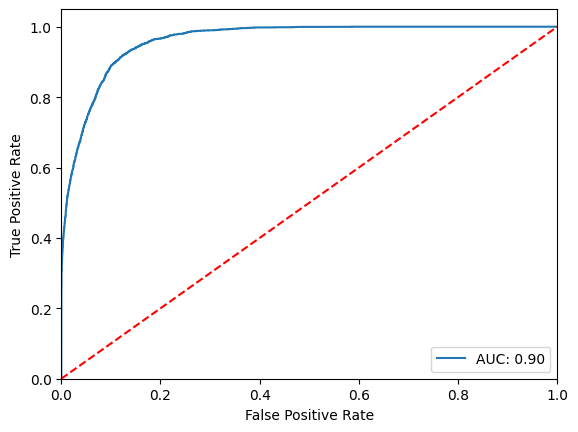

In [70]:
# This suggests overfitting
print('train accuracy:',rf_randomized_search.best_score_, rf_randomized_search.best_params_, '\n')

y_pred = rf_randomized_search.predict(X_test)
y_pred_proba = rf_randomized_search.predict_proba(X_test)
print_performance(y_test, y_pred, y_pred_proba)

## 6. Bagging

### 6.a Simple Bagging ExtraTrees

c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_bagging.py:804: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Train accuracy: 1.0
Accuracy: 0.835691
Precision: 0.465872
Recall: 0.874562
F1 score: 0.607913
AUC: 0.851813


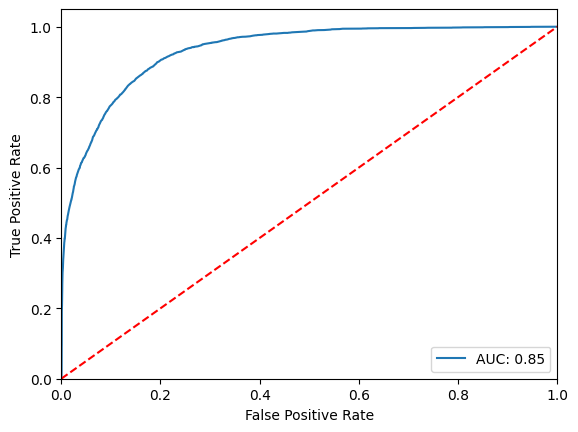

In [42]:
dt_bagging = BaggingClassifier(ExtraTreesClassifier())

dt_bagging.fit(X_train,y_train)

y_pred = dt_bagging.predict(X_test)
y_pred_proba = dt_bagging.predict_proba(X_test)
print(f'Train accuracy: {round(dt_bagging.score(X_train,y_train), 2)}')
print_performance(y_test, y_pred, y_pred_proba)

### 6.b Bagging ExtraTrees Hyperparameter Opt

In [72]:
bagging_parameter = {
    'estimator__max_depth' : [1, 2, 3, 10, 30, 100],
    'estimator__min_samples_split':list(range(2, 40)),
    'estimator__min_samples_leaf':list(range(2, 40)),
    'estimator__max_features':['None','auto', 'sqrt', 'log2'],
    'estimator__max_leaf_nodes':list(range(10, 60)),
    
    'max_samples' : [0.05, 0.1, 0.2, 0.5],
    'n_estimators':[5, 10, 20, 40, 100],
    'max_features':[0.1,0.25,0.5,0.75,0.99]
}

In [73]:
n_iter = 50
cv = 3

bagging_tree = BaggingClassifier(DecisionTreeClassifier())

bagging_dt_randomized_search = RandomizedSearchCV(estimator=bagging_tree, 
                                         param_distributions=bagging_parameter, n_iter=n_iter, cv=cv, scoring='accuracy', verbose=100)

bagging_dt_randomized_search.fit(X_train, y_train)

Fitting 3 folds for each of 50 candidates, totalling 150 fits
[CV 1/3; 1/50] START estimator__max_depth=100, estimator__max_features=log2, estimator__max_leaf_nodes=14, estimator__min_samples_leaf=30, estimator__min_samples_split=4, max_features=0.99, max_samples=0.2, n_estimators=5


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_bagging.py:804: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 1/3; 1/50] END estimator__max_depth=100, estimator__max_features=log2, estimator__max_leaf_nodes=14, estimator__min_samples_leaf=30, estimator__min_samples_split=4, max_features=0.99, max_samples=0.2, n_estimators=5;, score=0.510 total time=   0.3s
[CV 2/3; 1/50] START estimator__max_depth=100, estimator__max_features=log2, estimator__max_leaf_nodes=14, estimator__min_samples_leaf=30, estimator__min_samples_split=4, max_features=0.99, max_samples=0.2, n_estimators=5


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_bagging.py:804: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/3; 1/50] END estimator__max_depth=100, estimator__max_features=log2, estimator__max_leaf_nodes=14, estimator__min_samples_leaf=30, estimator__min_samples_split=4, max_features=0.99, max_samples=0.2, n_estimators=5;, score=0.525 total time=   0.3s
[CV 3/3; 1/50] START estimator__max_depth=100, estimator__max_features=log2, estimator__max_leaf_nodes=14, estimator__min_samples_leaf=30, estimator__min_samples_split=4, max_features=0.99, max_samples=0.2, n_estimators=5


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_bagging.py:804: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 3/3; 1/50] END estimator__max_depth=100, estimator__max_features=log2, estimator__max_leaf_nodes=14, estimator__min_samples_leaf=30, estimator__min_samples_split=4, max_features=0.99, max_samples=0.2, n_estimators=5;, score=0.532 total time=   0.3s
[CV 1/3; 2/50] START estimator__max_depth=1, estimator__max_features=sqrt, estimator__max_leaf_nodes=32, estimator__min_samples_leaf=3, estimator__min_samples_split=29, max_features=0.1, max_samples=0.05, n_estimators=40


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_bagging.py:804: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 1/3; 2/50] END estimator__max_depth=1, estimator__max_features=sqrt, estimator__max_leaf_nodes=32, estimator__min_samples_leaf=3, estimator__min_samples_split=29, max_features=0.1, max_samples=0.05, n_estimators=40;, score=0.499 total time=   0.2s
[CV 2/3; 2/50] START estimator__max_depth=1, estimator__max_features=sqrt, estimator__max_leaf_nodes=32, estimator__min_samples_leaf=3, estimator__min_samples_split=29, max_features=0.1, max_samples=0.05, n_estimators=40


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_bagging.py:804: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/3; 2/50] END estimator__max_depth=1, estimator__max_features=sqrt, estimator__max_leaf_nodes=32, estimator__min_samples_leaf=3, estimator__min_samples_split=29, max_features=0.1, max_samples=0.05, n_estimators=40;, score=0.513 total time=   0.2s
[CV 3/3; 2/50] START estimator__max_depth=1, estimator__max_features=sqrt, estimator__max_leaf_nodes=32, estimator__min_samples_leaf=3, estimator__min_samples_split=29, max_features=0.1, max_samples=0.05, n_estimators=40


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_bagging.py:804: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 3/3; 2/50] END estimator__max_depth=1, estimator__max_features=sqrt, estimator__max_leaf_nodes=32, estimator__min_samples_leaf=3, estimator__min_samples_split=29, max_features=0.1, max_samples=0.05, n_estimators=40;, score=0.515 total time=   0.2s
[CV 1/3; 3/50] START estimator__max_depth=10, estimator__max_features=sqrt, estimator__max_leaf_nodes=31, estimator__min_samples_leaf=15, estimator__min_samples_split=39, max_features=0.5, max_samples=0.1, n_estimators=5


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_bagging.py:804: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 1/3; 3/50] END estimator__max_depth=10, estimator__max_features=sqrt, estimator__max_leaf_nodes=31, estimator__min_samples_leaf=15, estimator__min_samples_split=39, max_features=0.5, max_samples=0.1, n_estimators=5;, score=0.513 total time=   0.1s
[CV 2/3; 3/50] START estimator__max_depth=10, estimator__max_features=sqrt, estimator__max_leaf_nodes=31, estimator__min_samples_leaf=15, estimator__min_samples_split=39, max_features=0.5, max_samples=0.1, n_estimators=5


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_bagging.py:804: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/3; 3/50] END estimator__max_depth=10, estimator__max_features=sqrt, estimator__max_leaf_nodes=31, estimator__min_samples_leaf=15, estimator__min_samples_split=39, max_features=0.5, max_samples=0.1, n_estimators=5;, score=0.541 total time=   0.2s
[CV 3/3; 3/50] START estimator__max_depth=10, estimator__max_features=sqrt, estimator__max_leaf_nodes=31, estimator__min_samples_leaf=15, estimator__min_samples_split=39, max_features=0.5, max_samples=0.1, n_estimators=5


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_bagging.py:804: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 3/3; 3/50] END estimator__max_depth=10, estimator__max_features=sqrt, estimator__max_leaf_nodes=31, estimator__min_samples_leaf=15, estimator__min_samples_split=39, max_features=0.5, max_samples=0.1, n_estimators=5;, score=0.541 total time=   0.1s
[CV 1/3; 4/50] START estimator__max_depth=100, estimator__max_features=auto, estimator__max_leaf_nodes=17, estimator__min_samples_leaf=22, estimator__min_samples_split=10, max_features=0.25, max_samples=0.5, n_estimators=20


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_bagging.py:804: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 1/3; 4/50] END estimator__max_depth=100, estimator__max_features=auto, estimator__max_leaf_nodes=17, estimator__min_samples_leaf=22, estimator__min_samples_split=10, max_features=0.25, max_samples=0.5, n_estimators=20;, score=0.589 total time=   0.6s
[CV 2/3; 4/50] START estimator__max_depth=100, estimator__max_features=auto, estimator__max_leaf_nodes=17, estimator__min_samples_leaf=22, estimator__min_samples_split=10, max_features=0.25, max_samples=0.5, n_estimators=20


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_bagging.py:804: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/3; 4/50] END estimator__max_depth=100, estimator__max_features=auto, estimator__max_leaf_nodes=17, estimator__min_samples_leaf=22, estimator__min_samples_split=10, max_features=0.25, max_samples=0.5, n_estimators=20;, score=0.588 total time=   0.6s
[CV 3/3; 4/50] START estimator__max_depth=100, estimator__max_features=auto, estimator__max_leaf_nodes=17, estimator__min_samples_leaf=22, estimator__min_samples_split=10, max_features=0.25, max_samples=0.5, n_estimators=20


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_bagging.py:804: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 3/3; 4/50] END estimator__max_depth=100, estimator__max_features=auto, estimator__max_leaf_nodes=17, estimator__min_samples_leaf=22, estimator__min_samples_split=10, max_features=0.25, max_samples=0.5, n_estimators=20;, score=0.600 total time=   0.6s
[CV 1/3; 5/50] START estimator__max_depth=10, estimator__max_features=auto, estimator__max_leaf_nodes=22, estimator__min_samples_leaf=17, estimator__min_samples_split=21, max_features=0.25, max_samples=0.1, n_estimators=20


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_bagging.py:804: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 1/3; 5/50] END estimator__max_depth=10, estimator__max_features=auto, estimator__max_leaf_nodes=22, estimator__min_samples_leaf=17, estimator__min_samples_split=21, max_features=0.25, max_samples=0.1, n_estimators=20;, score=0.530 total time=   0.3s
[CV 2/3; 5/50] START estimator__max_depth=10, estimator__max_features=auto, estimator__max_leaf_nodes=22, estimator__min_samples_leaf=17, estimator__min_samples_split=21, max_features=0.25, max_samples=0.1, n_estimators=20


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_bagging.py:804: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/3; 5/50] END estimator__max_depth=10, estimator__max_features=auto, estimator__max_leaf_nodes=22, estimator__min_samples_leaf=17, estimator__min_samples_split=21, max_features=0.25, max_samples=0.1, n_estimators=20;, score=0.531 total time=   0.4s
[CV 3/3; 5/50] START estimator__max_depth=10, estimator__max_features=auto, estimator__max_leaf_nodes=22, estimator__min_samples_leaf=17, estimator__min_samples_split=21, max_features=0.25, max_samples=0.1, n_estimators=20


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_bagging.py:804: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 3/3; 5/50] END estimator__max_depth=10, estimator__max_features=auto, estimator__max_leaf_nodes=22, estimator__min_samples_leaf=17, estimator__min_samples_split=21, max_features=0.25, max_samples=0.1, n_estimators=20;, score=0.538 total time=   0.4s
[CV 1/3; 6/50] START estimator__max_depth=100, estimator__max_features=sqrt, estimator__max_leaf_nodes=35, estimator__min_samples_leaf=10, estimator__min_samples_split=2, max_features=0.75, max_samples=0.5, n_estimators=20


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_bagging.py:804: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 1/3; 6/50] END estimator__max_depth=100, estimator__max_features=sqrt, estimator__max_leaf_nodes=35, estimator__min_samples_leaf=10, estimator__min_samples_split=2, max_features=0.75, max_samples=0.5, n_estimators=20;, score=0.641 total time=   1.8s
[CV 2/3; 6/50] START estimator__max_depth=100, estimator__max_features=sqrt, estimator__max_leaf_nodes=35, estimator__min_samples_leaf=10, estimator__min_samples_split=2, max_features=0.75, max_samples=0.5, n_estimators=20


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_bagging.py:804: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/3; 6/50] END estimator__max_depth=100, estimator__max_features=sqrt, estimator__max_leaf_nodes=35, estimator__min_samples_leaf=10, estimator__min_samples_split=2, max_features=0.75, max_samples=0.5, n_estimators=20;, score=0.666 total time=   1.8s
[CV 3/3; 6/50] START estimator__max_depth=100, estimator__max_features=sqrt, estimator__max_leaf_nodes=35, estimator__min_samples_leaf=10, estimator__min_samples_split=2, max_features=0.75, max_samples=0.5, n_estimators=20


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_bagging.py:804: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 3/3; 6/50] END estimator__max_depth=100, estimator__max_features=sqrt, estimator__max_leaf_nodes=35, estimator__min_samples_leaf=10, estimator__min_samples_split=2, max_features=0.75, max_samples=0.5, n_estimators=20;, score=0.656 total time=   1.8s
[CV 1/3; 7/50] START estimator__max_depth=100, estimator__max_features=log2, estimator__max_leaf_nodes=32, estimator__min_samples_leaf=18, estimator__min_samples_split=2, max_features=0.5, max_samples=0.05, n_estimators=10


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_bagging.py:804: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 1/3; 7/50] END estimator__max_depth=100, estimator__max_features=log2, estimator__max_leaf_nodes=32, estimator__min_samples_leaf=18, estimator__min_samples_split=2, max_features=0.5, max_samples=0.05, n_estimators=10;, score=0.519 total time=   0.3s
[CV 2/3; 7/50] START estimator__max_depth=100, estimator__max_features=log2, estimator__max_leaf_nodes=32, estimator__min_samples_leaf=18, estimator__min_samples_split=2, max_features=0.5, max_samples=0.05, n_estimators=10


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_bagging.py:804: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/3; 7/50] END estimator__max_depth=100, estimator__max_features=log2, estimator__max_leaf_nodes=32, estimator__min_samples_leaf=18, estimator__min_samples_split=2, max_features=0.5, max_samples=0.05, n_estimators=10;, score=0.521 total time=   0.3s
[CV 3/3; 7/50] START estimator__max_depth=100, estimator__max_features=log2, estimator__max_leaf_nodes=32, estimator__min_samples_leaf=18, estimator__min_samples_split=2, max_features=0.5, max_samples=0.05, n_estimators=10


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_bagging.py:804: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 3/3; 7/50] END estimator__max_depth=100, estimator__max_features=log2, estimator__max_leaf_nodes=32, estimator__min_samples_leaf=18, estimator__min_samples_split=2, max_features=0.5, max_samples=0.05, n_estimators=10;, score=0.519 total time=   0.3s
[CV 1/3; 8/50] START estimator__max_depth=1, estimator__max_features=None, estimator__max_leaf_nodes=58, estimator__min_samples_leaf=15, estimator__min_samples_split=9, max_features=0.99, max_samples=0.1, n_estimators=40
[CV 1/3; 8/50] END estimator__max_depth=1, estimator__max_features=None, estimator__max_leaf_nodes=58, estimator__min_samples_leaf=15, estimator__min_samples_split=9, max_features=0.99, max_samples=0.1, n_estimators=40;, score=nan total time=   0.0s
[CV 2/3; 8/50] START estimator__max_depth=1, estimator__max_features=None, estimator__max_leaf_nodes=58, estimator__min_samples_leaf=15, estimator__min_samples_split=9, max_features=0.99, max_samples=0.1, n_estimators=40
[CV 2/3; 8/50] END estimator__max_depth=1, estimator__

c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_bagging.py:804: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_bagging.py:804: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_bagging.py:804: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_bagging.py:804: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_

[CV 1/3; 9/50] END estimator__max_depth=10, estimator__max_features=auto, estimator__max_leaf_nodes=53, estimator__min_samples_leaf=31, estimator__min_samples_split=18, max_features=0.25, max_samples=0.1, n_estimators=40;, score=0.543 total time=   0.8s
[CV 2/3; 9/50] START estimator__max_depth=10, estimator__max_features=auto, estimator__max_leaf_nodes=53, estimator__min_samples_leaf=31, estimator__min_samples_split=18, max_features=0.25, max_samples=0.1, n_estimators=40


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_bagging.py:804: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/3; 9/50] END estimator__max_depth=10, estimator__max_features=auto, estimator__max_leaf_nodes=53, estimator__min_samples_leaf=31, estimator__min_samples_split=18, max_features=0.25, max_samples=0.1, n_estimators=40;, score=0.549 total time=   0.8s
[CV 3/3; 9/50] START estimator__max_depth=10, estimator__max_features=auto, estimator__max_leaf_nodes=53, estimator__min_samples_leaf=31, estimator__min_samples_split=18, max_features=0.25, max_samples=0.1, n_estimators=40


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_bagging.py:804: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 3/3; 9/50] END estimator__max_depth=10, estimator__max_features=auto, estimator__max_leaf_nodes=53, estimator__min_samples_leaf=31, estimator__min_samples_split=18, max_features=0.25, max_samples=0.1, n_estimators=40;, score=0.555 total time=   0.8s
[CV 1/3; 10/50] START estimator__max_depth=10, estimator__max_features=auto, estimator__max_leaf_nodes=21, estimator__min_samples_leaf=9, estimator__min_samples_split=28, max_features=0.99, max_samples=0.05, n_estimators=5


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_bagging.py:804: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 1/3; 10/50] END estimator__max_depth=10, estimator__max_features=auto, estimator__max_leaf_nodes=21, estimator__min_samples_leaf=9, estimator__min_samples_split=28, max_features=0.99, max_samples=0.05, n_estimators=5;, score=0.532 total time=   0.3s
[CV 2/3; 10/50] START estimator__max_depth=10, estimator__max_features=auto, estimator__max_leaf_nodes=21, estimator__min_samples_leaf=9, estimator__min_samples_split=28, max_features=0.99, max_samples=0.05, n_estimators=5


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_bagging.py:804: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/3; 10/50] END estimator__max_depth=10, estimator__max_features=auto, estimator__max_leaf_nodes=21, estimator__min_samples_leaf=9, estimator__min_samples_split=28, max_features=0.99, max_samples=0.05, n_estimators=5;, score=0.530 total time=   0.2s
[CV 3/3; 10/50] START estimator__max_depth=10, estimator__max_features=auto, estimator__max_leaf_nodes=21, estimator__min_samples_leaf=9, estimator__min_samples_split=28, max_features=0.99, max_samples=0.05, n_estimators=5


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_bagging.py:804: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 3/3; 10/50] END estimator__max_depth=10, estimator__max_features=auto, estimator__max_leaf_nodes=21, estimator__min_samples_leaf=9, estimator__min_samples_split=28, max_features=0.99, max_samples=0.05, n_estimators=5;, score=0.514 total time=   0.3s
[CV 1/3; 11/50] START estimator__max_depth=3, estimator__max_features=log2, estimator__max_leaf_nodes=47, estimator__min_samples_leaf=11, estimator__min_samples_split=16, max_features=0.5, max_samples=0.1, n_estimators=40


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_bagging.py:804: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 1/3; 11/50] END estimator__max_depth=3, estimator__max_features=log2, estimator__max_leaf_nodes=47, estimator__min_samples_leaf=11, estimator__min_samples_split=16, max_features=0.5, max_samples=0.1, n_estimators=40;, score=0.517 total time=   1.2s
[CV 2/3; 11/50] START estimator__max_depth=3, estimator__max_features=log2, estimator__max_leaf_nodes=47, estimator__min_samples_leaf=11, estimator__min_samples_split=16, max_features=0.5, max_samples=0.1, n_estimators=40


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_bagging.py:804: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/3; 11/50] END estimator__max_depth=3, estimator__max_features=log2, estimator__max_leaf_nodes=47, estimator__min_samples_leaf=11, estimator__min_samples_split=16, max_features=0.5, max_samples=0.1, n_estimators=40;, score=0.530 total time=   1.2s
[CV 3/3; 11/50] START estimator__max_depth=3, estimator__max_features=log2, estimator__max_leaf_nodes=47, estimator__min_samples_leaf=11, estimator__min_samples_split=16, max_features=0.5, max_samples=0.1, n_estimators=40


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_bagging.py:804: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 3/3; 11/50] END estimator__max_depth=3, estimator__max_features=log2, estimator__max_leaf_nodes=47, estimator__min_samples_leaf=11, estimator__min_samples_split=16, max_features=0.5, max_samples=0.1, n_estimators=40;, score=0.531 total time=   1.2s
[CV 1/3; 12/50] START estimator__max_depth=1, estimator__max_features=auto, estimator__max_leaf_nodes=49, estimator__min_samples_leaf=35, estimator__min_samples_split=34, max_features=0.99, max_samples=0.5, n_estimators=40


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_bagging.py:804: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 1/3; 12/50] END estimator__max_depth=1, estimator__max_features=auto, estimator__max_leaf_nodes=49, estimator__min_samples_leaf=35, estimator__min_samples_split=34, max_features=0.99, max_samples=0.5, n_estimators=40;, score=0.536 total time=   2.5s
[CV 2/3; 12/50] START estimator__max_depth=1, estimator__max_features=auto, estimator__max_leaf_nodes=49, estimator__min_samples_leaf=35, estimator__min_samples_split=34, max_features=0.99, max_samples=0.5, n_estimators=40


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_bagging.py:804: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/3; 12/50] END estimator__max_depth=1, estimator__max_features=auto, estimator__max_leaf_nodes=49, estimator__min_samples_leaf=35, estimator__min_samples_split=34, max_features=0.99, max_samples=0.5, n_estimators=40;, score=0.515 total time=   2.5s
[CV 3/3; 12/50] START estimator__max_depth=1, estimator__max_features=auto, estimator__max_leaf_nodes=49, estimator__min_samples_leaf=35, estimator__min_samples_split=34, max_features=0.99, max_samples=0.5, n_estimators=40


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_bagging.py:804: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 3/3; 12/50] END estimator__max_depth=1, estimator__max_features=auto, estimator__max_leaf_nodes=49, estimator__min_samples_leaf=35, estimator__min_samples_split=34, max_features=0.99, max_samples=0.5, n_estimators=40;, score=0.525 total time=   2.5s
[CV 1/3; 13/50] START estimator__max_depth=2, estimator__max_features=auto, estimator__max_leaf_nodes=49, estimator__min_samples_leaf=13, estimator__min_samples_split=8, max_features=0.99, max_samples=0.5, n_estimators=40


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_bagging.py:804: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 1/3; 13/50] END estimator__max_depth=2, estimator__max_features=auto, estimator__max_leaf_nodes=49, estimator__min_samples_leaf=13, estimator__min_samples_split=8, max_features=0.99, max_samples=0.5, n_estimators=40;, score=0.557 total time=   2.8s
[CV 2/3; 13/50] START estimator__max_depth=2, estimator__max_features=auto, estimator__max_leaf_nodes=49, estimator__min_samples_leaf=13, estimator__min_samples_split=8, max_features=0.99, max_samples=0.5, n_estimators=40


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_bagging.py:804: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/3; 13/50] END estimator__max_depth=2, estimator__max_features=auto, estimator__max_leaf_nodes=49, estimator__min_samples_leaf=13, estimator__min_samples_split=8, max_features=0.99, max_samples=0.5, n_estimators=40;, score=0.545 total time=   2.7s
[CV 3/3; 13/50] START estimator__max_depth=2, estimator__max_features=auto, estimator__max_leaf_nodes=49, estimator__min_samples_leaf=13, estimator__min_samples_split=8, max_features=0.99, max_samples=0.5, n_estimators=40


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_bagging.py:804: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 3/3; 13/50] END estimator__max_depth=2, estimator__max_features=auto, estimator__max_leaf_nodes=49, estimator__min_samples_leaf=13, estimator__min_samples_split=8, max_features=0.99, max_samples=0.5, n_estimators=40;, score=0.569 total time=   2.7s
[CV 1/3; 14/50] START estimator__max_depth=10, estimator__max_features=None, estimator__max_leaf_nodes=46, estimator__min_samples_leaf=34, estimator__min_samples_split=39, max_features=0.99, max_samples=0.2, n_estimators=40
[CV 1/3; 14/50] END estimator__max_depth=10, estimator__max_features=None, estimator__max_leaf_nodes=46, estimator__min_samples_leaf=34, estimator__min_samples_split=39, max_features=0.99, max_samples=0.2, n_estimators=40;, score=nan total time=   0.0s
[CV 2/3; 14/50] START estimator__max_depth=10, estimator__max_features=None, estimator__max_leaf_nodes=46, estimator__min_samples_leaf=34, estimator__min_samples_split=39, max_features=0.99, max_samples=0.2, n_estimators=40
[CV 2/3; 14/50] END estimator__max_depth=10, e

c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_bagging.py:804: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_bagging.py:804: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_bagging.py:804: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_bagging.py:804: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_

[CV 2/3; 15/50] END estimator__max_depth=2, estimator__max_features=None, estimator__max_leaf_nodes=53, estimator__min_samples_leaf=23, estimator__min_samples_split=34, max_features=0.5, max_samples=0.05, n_estimators=5;, score=nan total time=   0.0s
[CV 3/3; 15/50] START estimator__max_depth=2, estimator__max_features=None, estimator__max_leaf_nodes=53, estimator__min_samples_leaf=23, estimator__min_samples_split=34, max_features=0.5, max_samples=0.05, n_estimators=5
[CV 3/3; 15/50] END estimator__max_depth=2, estimator__max_features=None, estimator__max_leaf_nodes=53, estimator__min_samples_leaf=23, estimator__min_samples_split=34, max_features=0.5, max_samples=0.05, n_estimators=5;, score=nan total time=   0.0s
[CV 1/3; 16/50] START estimator__max_depth=10, estimator__max_features=auto, estimator__max_leaf_nodes=19, estimator__min_samples_leaf=8, estimator__min_samples_split=7, max_features=0.99, max_samples=0.1, n_estimators=10
[CV 1/3; 16/50] END estimator__max_depth=10, estimator

c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_bagging.py:804: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/3; 16/50] END estimator__max_depth=10, estimator__max_features=auto, estimator__max_leaf_nodes=19, estimator__min_samples_leaf=8, estimator__min_samples_split=7, max_features=0.99, max_samples=0.1, n_estimators=10;, score=0.528 total time=   0.7s
[CV 3/3; 16/50] START estimator__max_depth=10, estimator__max_features=auto, estimator__max_leaf_nodes=19, estimator__min_samples_leaf=8, estimator__min_samples_split=7, max_features=0.99, max_samples=0.1, n_estimators=10


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_bagging.py:804: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 3/3; 16/50] END estimator__max_depth=10, estimator__max_features=auto, estimator__max_leaf_nodes=19, estimator__min_samples_leaf=8, estimator__min_samples_split=7, max_features=0.99, max_samples=0.1, n_estimators=10;, score=0.547 total time=   0.7s
[CV 1/3; 17/50] START estimator__max_depth=3, estimator__max_features=sqrt, estimator__max_leaf_nodes=47, estimator__min_samples_leaf=28, estimator__min_samples_split=25, max_features=0.1, max_samples=0.5, n_estimators=40


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_bagging.py:804: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 1/3; 17/50] END estimator__max_depth=3, estimator__max_features=sqrt, estimator__max_leaf_nodes=47, estimator__min_samples_leaf=28, estimator__min_samples_split=25, max_features=0.1, max_samples=0.5, n_estimators=40;, score=0.562 total time=   0.4s
[CV 2/3; 17/50] START estimator__max_depth=3, estimator__max_features=sqrt, estimator__max_leaf_nodes=47, estimator__min_samples_leaf=28, estimator__min_samples_split=25, max_features=0.1, max_samples=0.5, n_estimators=40


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_bagging.py:804: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/3; 17/50] END estimator__max_depth=3, estimator__max_features=sqrt, estimator__max_leaf_nodes=47, estimator__min_samples_leaf=28, estimator__min_samples_split=25, max_features=0.1, max_samples=0.5, n_estimators=40;, score=0.552 total time=   0.4s
[CV 3/3; 17/50] START estimator__max_depth=3, estimator__max_features=sqrt, estimator__max_leaf_nodes=47, estimator__min_samples_leaf=28, estimator__min_samples_split=25, max_features=0.1, max_samples=0.5, n_estimators=40


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_bagging.py:804: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 3/3; 17/50] END estimator__max_depth=3, estimator__max_features=sqrt, estimator__max_leaf_nodes=47, estimator__min_samples_leaf=28, estimator__min_samples_split=25, max_features=0.1, max_samples=0.5, n_estimators=40;, score=0.565 total time=   0.4s
[CV 1/3; 18/50] START estimator__max_depth=100, estimator__max_features=sqrt, estimator__max_leaf_nodes=49, estimator__min_samples_leaf=37, estimator__min_samples_split=16, max_features=0.5, max_samples=0.5, n_estimators=100


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_bagging.py:804: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 1/3; 18/50] END estimator__max_depth=100, estimator__max_features=sqrt, estimator__max_leaf_nodes=49, estimator__min_samples_leaf=37, estimator__min_samples_split=16, max_features=0.5, max_samples=0.5, n_estimators=100;, score=0.665 total time=   7.0s
[CV 2/3; 18/50] START estimator__max_depth=100, estimator__max_features=sqrt, estimator__max_leaf_nodes=49, estimator__min_samples_leaf=37, estimator__min_samples_split=16, max_features=0.5, max_samples=0.5, n_estimators=100


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_bagging.py:804: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/3; 18/50] END estimator__max_depth=100, estimator__max_features=sqrt, estimator__max_leaf_nodes=49, estimator__min_samples_leaf=37, estimator__min_samples_split=16, max_features=0.5, max_samples=0.5, n_estimators=100;, score=0.660 total time=   7.2s
[CV 3/3; 18/50] START estimator__max_depth=100, estimator__max_features=sqrt, estimator__max_leaf_nodes=49, estimator__min_samples_leaf=37, estimator__min_samples_split=16, max_features=0.5, max_samples=0.5, n_estimators=100


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_bagging.py:804: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 3/3; 18/50] END estimator__max_depth=100, estimator__max_features=sqrt, estimator__max_leaf_nodes=49, estimator__min_samples_leaf=37, estimator__min_samples_split=16, max_features=0.5, max_samples=0.5, n_estimators=100;, score=0.655 total time=   7.2s
[CV 1/3; 19/50] START estimator__max_depth=30, estimator__max_features=auto, estimator__max_leaf_nodes=51, estimator__min_samples_leaf=15, estimator__min_samples_split=33, max_features=0.25, max_samples=0.05, n_estimators=100


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_bagging.py:804: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 1/3; 19/50] END estimator__max_depth=30, estimator__max_features=auto, estimator__max_leaf_nodes=51, estimator__min_samples_leaf=15, estimator__min_samples_split=33, max_features=0.25, max_samples=0.05, n_estimators=100;, score=0.552 total time=   1.8s
[CV 2/3; 19/50] START estimator__max_depth=30, estimator__max_features=auto, estimator__max_leaf_nodes=51, estimator__min_samples_leaf=15, estimator__min_samples_split=33, max_features=0.25, max_samples=0.05, n_estimators=100


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_bagging.py:804: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/3; 19/50] END estimator__max_depth=30, estimator__max_features=auto, estimator__max_leaf_nodes=51, estimator__min_samples_leaf=15, estimator__min_samples_split=33, max_features=0.25, max_samples=0.05, n_estimators=100;, score=0.552 total time=   1.8s
[CV 3/3; 19/50] START estimator__max_depth=30, estimator__max_features=auto, estimator__max_leaf_nodes=51, estimator__min_samples_leaf=15, estimator__min_samples_split=33, max_features=0.25, max_samples=0.05, n_estimators=100


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_bagging.py:804: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 3/3; 19/50] END estimator__max_depth=30, estimator__max_features=auto, estimator__max_leaf_nodes=51, estimator__min_samples_leaf=15, estimator__min_samples_split=33, max_features=0.25, max_samples=0.05, n_estimators=100;, score=0.542 total time=   1.8s
[CV 1/3; 20/50] START estimator__max_depth=1, estimator__max_features=None, estimator__max_leaf_nodes=12, estimator__min_samples_leaf=5, estimator__min_samples_split=19, max_features=0.1, max_samples=0.2, n_estimators=40
[CV 1/3; 20/50] END estimator__max_depth=1, estimator__max_features=None, estimator__max_leaf_nodes=12, estimator__min_samples_leaf=5, estimator__min_samples_split=19, max_features=0.1, max_samples=0.2, n_estimators=40;, score=nan total time=   0.0s
[CV 2/3; 20/50] START estimator__max_depth=1, estimator__max_features=None, estimator__max_leaf_nodes=12, estimator__min_samples_leaf=5, estimator__min_samples_split=19, max_features=0.1, max_samples=0.2, n_estimators=40
[CV 2/3; 20/50] END estimator__max_depth=1, estimat

c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_bagging.py:804: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_bagging.py:804: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_bagging.py:804: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_bagging.py:804: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_

[CV 1/3; 21/50] END estimator__max_depth=100, estimator__max_features=auto, estimator__max_leaf_nodes=44, estimator__min_samples_leaf=10, estimator__min_samples_split=21, max_features=0.1, max_samples=0.5, n_estimators=20;, score=0.600 total time=   0.4s
[CV 2/3; 21/50] START estimator__max_depth=100, estimator__max_features=auto, estimator__max_leaf_nodes=44, estimator__min_samples_leaf=10, estimator__min_samples_split=21, max_features=0.1, max_samples=0.5, n_estimators=20


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_bagging.py:804: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/3; 21/50] END estimator__max_depth=100, estimator__max_features=auto, estimator__max_leaf_nodes=44, estimator__min_samples_leaf=10, estimator__min_samples_split=21, max_features=0.1, max_samples=0.5, n_estimators=20;, score=0.592 total time=   0.4s
[CV 3/3; 21/50] START estimator__max_depth=100, estimator__max_features=auto, estimator__max_leaf_nodes=44, estimator__min_samples_leaf=10, estimator__min_samples_split=21, max_features=0.1, max_samples=0.5, n_estimators=20


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_bagging.py:804: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 3/3; 21/50] END estimator__max_depth=100, estimator__max_features=auto, estimator__max_leaf_nodes=44, estimator__min_samples_leaf=10, estimator__min_samples_split=21, max_features=0.1, max_samples=0.5, n_estimators=20;, score=0.593 total time=   0.4s
[CV 1/3; 22/50] START estimator__max_depth=30, estimator__max_features=log2, estimator__max_leaf_nodes=30, estimator__min_samples_leaf=13, estimator__min_samples_split=5, max_features=0.99, max_samples=0.5, n_estimators=100


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_bagging.py:804: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 1/3; 22/50] END estimator__max_depth=30, estimator__max_features=log2, estimator__max_leaf_nodes=30, estimator__min_samples_leaf=13, estimator__min_samples_split=5, max_features=0.99, max_samples=0.5, n_estimators=100;, score=0.628 total time=   7.9s
[CV 2/3; 22/50] START estimator__max_depth=30, estimator__max_features=log2, estimator__max_leaf_nodes=30, estimator__min_samples_leaf=13, estimator__min_samples_split=5, max_features=0.99, max_samples=0.5, n_estimators=100


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_bagging.py:804: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/3; 22/50] END estimator__max_depth=30, estimator__max_features=log2, estimator__max_leaf_nodes=30, estimator__min_samples_leaf=13, estimator__min_samples_split=5, max_features=0.99, max_samples=0.5, n_estimators=100;, score=0.628 total time=   8.0s
[CV 3/3; 22/50] START estimator__max_depth=30, estimator__max_features=log2, estimator__max_leaf_nodes=30, estimator__min_samples_leaf=13, estimator__min_samples_split=5, max_features=0.99, max_samples=0.5, n_estimators=100


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_bagging.py:804: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 3/3; 22/50] END estimator__max_depth=30, estimator__max_features=log2, estimator__max_leaf_nodes=30, estimator__min_samples_leaf=13, estimator__min_samples_split=5, max_features=0.99, max_samples=0.5, n_estimators=100;, score=0.627 total time=   8.0s
[CV 1/3; 23/50] START estimator__max_depth=3, estimator__max_features=sqrt, estimator__max_leaf_nodes=20, estimator__min_samples_leaf=27, estimator__min_samples_split=14, max_features=0.99, max_samples=0.2, n_estimators=20


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_bagging.py:804: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 1/3; 23/50] END estimator__max_depth=3, estimator__max_features=sqrt, estimator__max_leaf_nodes=20, estimator__min_samples_leaf=27, estimator__min_samples_split=14, max_features=0.99, max_samples=0.2, n_estimators=20;, score=0.581 total time=   1.3s
[CV 2/3; 23/50] START estimator__max_depth=3, estimator__max_features=sqrt, estimator__max_leaf_nodes=20, estimator__min_samples_leaf=27, estimator__min_samples_split=14, max_features=0.99, max_samples=0.2, n_estimators=20


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_bagging.py:804: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/3; 23/50] END estimator__max_depth=3, estimator__max_features=sqrt, estimator__max_leaf_nodes=20, estimator__min_samples_leaf=27, estimator__min_samples_split=14, max_features=0.99, max_samples=0.2, n_estimators=20;, score=0.559 total time=   1.3s
[CV 3/3; 23/50] START estimator__max_depth=3, estimator__max_features=sqrt, estimator__max_leaf_nodes=20, estimator__min_samples_leaf=27, estimator__min_samples_split=14, max_features=0.99, max_samples=0.2, n_estimators=20


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_bagging.py:804: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 3/3; 23/50] END estimator__max_depth=3, estimator__max_features=sqrt, estimator__max_leaf_nodes=20, estimator__min_samples_leaf=27, estimator__min_samples_split=14, max_features=0.99, max_samples=0.2, n_estimators=20;, score=0.544 total time=   1.3s
[CV 1/3; 24/50] START estimator__max_depth=100, estimator__max_features=None, estimator__max_leaf_nodes=51, estimator__min_samples_leaf=14, estimator__min_samples_split=23, max_features=0.99, max_samples=0.1, n_estimators=40
[CV 1/3; 24/50] END estimator__max_depth=100, estimator__max_features=None, estimator__max_leaf_nodes=51, estimator__min_samples_leaf=14, estimator__min_samples_split=23, max_features=0.99, max_samples=0.1, n_estimators=40;, score=nan total time=   0.0s
[CV 2/3; 24/50] START estimator__max_depth=100, estimator__max_features=None, estimator__max_leaf_nodes=51, estimator__min_samples_leaf=14, estimator__min_samples_split=23, max_features=0.99, max_samples=0.1, n_estimators=40
[CV 2/3; 24/50] END estimator__max_depth=1

c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_bagging.py:804: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_bagging.py:804: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_bagging.py:804: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_bagging.py:804: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_

[CV 1/3; 25/50] END estimator__max_depth=10, estimator__max_features=sqrt, estimator__max_leaf_nodes=56, estimator__min_samples_leaf=2, estimator__min_samples_split=11, max_features=0.1, max_samples=0.5, n_estimators=100;, score=0.611 total time=   2.3s
[CV 2/3; 25/50] START estimator__max_depth=10, estimator__max_features=sqrt, estimator__max_leaf_nodes=56, estimator__min_samples_leaf=2, estimator__min_samples_split=11, max_features=0.1, max_samples=0.5, n_estimators=100


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_bagging.py:804: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/3; 25/50] END estimator__max_depth=10, estimator__max_features=sqrt, estimator__max_leaf_nodes=56, estimator__min_samples_leaf=2, estimator__min_samples_split=11, max_features=0.1, max_samples=0.5, n_estimators=100;, score=0.615 total time=   2.3s
[CV 3/3; 25/50] START estimator__max_depth=10, estimator__max_features=sqrt, estimator__max_leaf_nodes=56, estimator__min_samples_leaf=2, estimator__min_samples_split=11, max_features=0.1, max_samples=0.5, n_estimators=100


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_bagging.py:804: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 3/3; 25/50] END estimator__max_depth=10, estimator__max_features=sqrt, estimator__max_leaf_nodes=56, estimator__min_samples_leaf=2, estimator__min_samples_split=11, max_features=0.1, max_samples=0.5, n_estimators=100;, score=0.607 total time=   2.3s
[CV 1/3; 26/50] START estimator__max_depth=2, estimator__max_features=log2, estimator__max_leaf_nodes=25, estimator__min_samples_leaf=14, estimator__min_samples_split=7, max_features=0.25, max_samples=0.1, n_estimators=10
[CV 1/3; 26/50] END estimator__max_depth=2, estimator__max_features=log2, estimator__max_leaf_nodes=25, estimator__min_samples_leaf=14, estimator__min_samples_split=7, max_features=0.25, max_samples=0.1, n_estimators=10;, score=0.528 total time=   0.1s
[CV 2/3; 26/50] START estimator__max_depth=2, estimator__max_features=log2, estimator__max_leaf_nodes=25, estimator__min_samples_leaf=14, estimator__min_samples_split=7, max_features=0.25, max_samples=0.1, n_estimators=10


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_bagging.py:804: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_bagging.py:804: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/3; 26/50] END estimator__max_depth=2, estimator__max_features=log2, estimator__max_leaf_nodes=25, estimator__min_samples_leaf=14, estimator__min_samples_split=7, max_features=0.25, max_samples=0.1, n_estimators=10;, score=0.506 total time=   0.1s
[CV 3/3; 26/50] START estimator__max_depth=2, estimator__max_features=log2, estimator__max_leaf_nodes=25, estimator__min_samples_leaf=14, estimator__min_samples_split=7, max_features=0.25, max_samples=0.1, n_estimators=10
[CV 3/3; 26/50] END estimator__max_depth=2, estimator__max_features=log2, estimator__max_leaf_nodes=25, estimator__min_samples_leaf=14, estimator__min_samples_split=7, max_features=0.25, max_samples=0.1, n_estimators=10;, score=0.507 total time=   0.1s
[CV 1/3; 27/50] START estimator__max_depth=10, estimator__max_features=log2, estimator__max_leaf_nodes=38, estimator__min_samples_leaf=18, estimator__min_samples_split=16, max_features=0.75, max_samples=0.05, n_estimators=40


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_bagging.py:804: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_bagging.py:804: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 1/3; 27/50] END estimator__max_depth=10, estimator__max_features=log2, estimator__max_leaf_nodes=38, estimator__min_samples_leaf=18, estimator__min_samples_split=16, max_features=0.75, max_samples=0.05, n_estimators=40;, score=0.537 total time=   1.9s
[CV 2/3; 27/50] START estimator__max_depth=10, estimator__max_features=log2, estimator__max_leaf_nodes=38, estimator__min_samples_leaf=18, estimator__min_samples_split=16, max_features=0.75, max_samples=0.05, n_estimators=40


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_bagging.py:804: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/3; 27/50] END estimator__max_depth=10, estimator__max_features=log2, estimator__max_leaf_nodes=38, estimator__min_samples_leaf=18, estimator__min_samples_split=16, max_features=0.75, max_samples=0.05, n_estimators=40;, score=0.534 total time=   1.8s
[CV 3/3; 27/50] START estimator__max_depth=10, estimator__max_features=log2, estimator__max_leaf_nodes=38, estimator__min_samples_leaf=18, estimator__min_samples_split=16, max_features=0.75, max_samples=0.05, n_estimators=40


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_bagging.py:804: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 3/3; 27/50] END estimator__max_depth=10, estimator__max_features=log2, estimator__max_leaf_nodes=38, estimator__min_samples_leaf=18, estimator__min_samples_split=16, max_features=0.75, max_samples=0.05, n_estimators=40;, score=0.531 total time=   1.9s
[CV 1/3; 28/50] START estimator__max_depth=1, estimator__max_features=sqrt, estimator__max_leaf_nodes=21, estimator__min_samples_leaf=2, estimator__min_samples_split=13, max_features=0.5, max_samples=0.05, n_estimators=40


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_bagging.py:804: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 1/3; 28/50] END estimator__max_depth=1, estimator__max_features=sqrt, estimator__max_leaf_nodes=21, estimator__min_samples_leaf=2, estimator__min_samples_split=13, max_features=0.5, max_samples=0.05, n_estimators=40;, score=0.529 total time=   1.1s
[CV 2/3; 28/50] START estimator__max_depth=1, estimator__max_features=sqrt, estimator__max_leaf_nodes=21, estimator__min_samples_leaf=2, estimator__min_samples_split=13, max_features=0.5, max_samples=0.05, n_estimators=40


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_bagging.py:804: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/3; 28/50] END estimator__max_depth=1, estimator__max_features=sqrt, estimator__max_leaf_nodes=21, estimator__min_samples_leaf=2, estimator__min_samples_split=13, max_features=0.5, max_samples=0.05, n_estimators=40;, score=0.515 total time=   1.2s
[CV 3/3; 28/50] START estimator__max_depth=1, estimator__max_features=sqrt, estimator__max_leaf_nodes=21, estimator__min_samples_leaf=2, estimator__min_samples_split=13, max_features=0.5, max_samples=0.05, n_estimators=40


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_bagging.py:804: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 3/3; 28/50] END estimator__max_depth=1, estimator__max_features=sqrt, estimator__max_leaf_nodes=21, estimator__min_samples_leaf=2, estimator__min_samples_split=13, max_features=0.5, max_samples=0.05, n_estimators=40;, score=0.501 total time=   1.1s
[CV 1/3; 29/50] START estimator__max_depth=100, estimator__max_features=log2, estimator__max_leaf_nodes=39, estimator__min_samples_leaf=23, estimator__min_samples_split=14, max_features=0.25, max_samples=0.05, n_estimators=40


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_bagging.py:804: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 1/3; 29/50] END estimator__max_depth=100, estimator__max_features=log2, estimator__max_leaf_nodes=39, estimator__min_samples_leaf=23, estimator__min_samples_split=14, max_features=0.25, max_samples=0.05, n_estimators=40;, score=0.546 total time=   0.6s
[CV 2/3; 29/50] START estimator__max_depth=100, estimator__max_features=log2, estimator__max_leaf_nodes=39, estimator__min_samples_leaf=23, estimator__min_samples_split=14, max_features=0.25, max_samples=0.05, n_estimators=40


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_bagging.py:804: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/3; 29/50] END estimator__max_depth=100, estimator__max_features=log2, estimator__max_leaf_nodes=39, estimator__min_samples_leaf=23, estimator__min_samples_split=14, max_features=0.25, max_samples=0.05, n_estimators=40;, score=0.534 total time=   0.6s
[CV 3/3; 29/50] START estimator__max_depth=100, estimator__max_features=log2, estimator__max_leaf_nodes=39, estimator__min_samples_leaf=23, estimator__min_samples_split=14, max_features=0.25, max_samples=0.05, n_estimators=40


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_bagging.py:804: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 3/3; 29/50] END estimator__max_depth=100, estimator__max_features=log2, estimator__max_leaf_nodes=39, estimator__min_samples_leaf=23, estimator__min_samples_split=14, max_features=0.25, max_samples=0.05, n_estimators=40;, score=0.514 total time=   0.6s
[CV 1/3; 30/50] START estimator__max_depth=3, estimator__max_features=auto, estimator__max_leaf_nodes=35, estimator__min_samples_leaf=26, estimator__min_samples_split=25, max_features=0.75, max_samples=0.1, n_estimators=20


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_bagging.py:804: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 1/3; 30/50] END estimator__max_depth=3, estimator__max_features=auto, estimator__max_leaf_nodes=35, estimator__min_samples_leaf=26, estimator__min_samples_split=25, max_features=0.75, max_samples=0.1, n_estimators=20;, score=0.525 total time=   0.9s
[CV 2/3; 30/50] START estimator__max_depth=3, estimator__max_features=auto, estimator__max_leaf_nodes=35, estimator__min_samples_leaf=26, estimator__min_samples_split=25, max_features=0.75, max_samples=0.1, n_estimators=20


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_bagging.py:804: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/3; 30/50] END estimator__max_depth=3, estimator__max_features=auto, estimator__max_leaf_nodes=35, estimator__min_samples_leaf=26, estimator__min_samples_split=25, max_features=0.75, max_samples=0.1, n_estimators=20;, score=0.537 total time=   0.9s
[CV 3/3; 30/50] START estimator__max_depth=3, estimator__max_features=auto, estimator__max_leaf_nodes=35, estimator__min_samples_leaf=26, estimator__min_samples_split=25, max_features=0.75, max_samples=0.1, n_estimators=20


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_bagging.py:804: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 3/3; 30/50] END estimator__max_depth=3, estimator__max_features=auto, estimator__max_leaf_nodes=35, estimator__min_samples_leaf=26, estimator__min_samples_split=25, max_features=0.75, max_samples=0.1, n_estimators=20;, score=0.541 total time=   0.9s
[CV 1/3; 31/50] START estimator__max_depth=30, estimator__max_features=log2, estimator__max_leaf_nodes=50, estimator__min_samples_leaf=12, estimator__min_samples_split=34, max_features=0.25, max_samples=0.5, n_estimators=100


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_bagging.py:804: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 1/3; 31/50] END estimator__max_depth=30, estimator__max_features=log2, estimator__max_leaf_nodes=50, estimator__min_samples_leaf=12, estimator__min_samples_split=34, max_features=0.25, max_samples=0.5, n_estimators=100;, score=0.610 total time=   3.2s
[CV 2/3; 31/50] START estimator__max_depth=30, estimator__max_features=log2, estimator__max_leaf_nodes=50, estimator__min_samples_leaf=12, estimator__min_samples_split=34, max_features=0.25, max_samples=0.5, n_estimators=100


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_bagging.py:804: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/3; 31/50] END estimator__max_depth=30, estimator__max_features=log2, estimator__max_leaf_nodes=50, estimator__min_samples_leaf=12, estimator__min_samples_split=34, max_features=0.25, max_samples=0.5, n_estimators=100;, score=0.624 total time=   3.2s
[CV 3/3; 31/50] START estimator__max_depth=30, estimator__max_features=log2, estimator__max_leaf_nodes=50, estimator__min_samples_leaf=12, estimator__min_samples_split=34, max_features=0.25, max_samples=0.5, n_estimators=100


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_bagging.py:804: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 3/3; 31/50] END estimator__max_depth=30, estimator__max_features=log2, estimator__max_leaf_nodes=50, estimator__min_samples_leaf=12, estimator__min_samples_split=34, max_features=0.25, max_samples=0.5, n_estimators=100;, score=0.619 total time=   3.1s
[CV 1/3; 32/50] START estimator__max_depth=2, estimator__max_features=sqrt, estimator__max_leaf_nodes=18, estimator__min_samples_leaf=32, estimator__min_samples_split=4, max_features=0.25, max_samples=0.05, n_estimators=5
[CV 1/3; 32/50] END estimator__max_depth=2, estimator__max_features=sqrt, estimator__max_leaf_nodes=18, estimator__min_samples_leaf=32, estimator__min_samples_split=4, max_features=0.25, max_samples=0.05, n_estimators=5;, score=0.510 total time=   0.0s
[CV 2/3; 32/50] START estimator__max_depth=2, estimator__max_features=sqrt, estimator__max_leaf_nodes=18, estimator__min_samples_leaf=32, estimator__min_samples_split=4, max_features=0.25, max_samples=0.05, n_estimators=5


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_bagging.py:804: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_bagging.py:804: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/3; 32/50] END estimator__max_depth=2, estimator__max_features=sqrt, estimator__max_leaf_nodes=18, estimator__min_samples_leaf=32, estimator__min_samples_split=4, max_features=0.25, max_samples=0.05, n_estimators=5;, score=0.511 total time=   0.0s
[CV 3/3; 32/50] START estimator__max_depth=2, estimator__max_features=sqrt, estimator__max_leaf_nodes=18, estimator__min_samples_leaf=32, estimator__min_samples_split=4, max_features=0.25, max_samples=0.05, n_estimators=5
[CV 3/3; 32/50] END estimator__max_depth=2, estimator__max_features=sqrt, estimator__max_leaf_nodes=18, estimator__min_samples_leaf=32, estimator__min_samples_split=4, max_features=0.25, max_samples=0.05, n_estimators=5;, score=0.520 total time=   0.0s
[CV 1/3; 33/50] START estimator__max_depth=3, estimator__max_features=None, estimator__max_leaf_nodes=59, estimator__min_samples_leaf=7, estimator__min_samples_split=32, max_features=0.99, max_samples=0.5, n_estimators=100
[CV 1/3; 33/50] END estimator__max_depth=3, estim

c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_bagging.py:804: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_bagging.py:804: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_bagging.py:804: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/3; 33/50] END estimator__max_depth=3, estimator__max_features=None, estimator__max_leaf_nodes=59, estimator__min_samples_leaf=7, estimator__min_samples_split=32, max_features=0.99, max_samples=0.5, n_estimators=100;, score=nan total time=   0.0s
[CV 3/3; 33/50] START estimator__max_depth=3, estimator__max_features=None, estimator__max_leaf_nodes=59, estimator__min_samples_leaf=7, estimator__min_samples_split=32, max_features=0.99, max_samples=0.5, n_estimators=100
[CV 3/3; 33/50] END estimator__max_depth=3, estimator__max_features=None, estimator__max_leaf_nodes=59, estimator__min_samples_leaf=7, estimator__min_samples_split=32, max_features=0.99, max_samples=0.5, n_estimators=100;, score=nan total time=   0.0s
[CV 1/3; 34/50] START estimator__max_depth=3, estimator__max_features=None, estimator__max_leaf_nodes=45, estimator__min_samples_leaf=25, estimator__min_samples_split=37, max_features=0.25, max_samples=0.2, n_estimators=40
[CV 1/3; 34/50] END estimator__max_depth=3, estima

c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_bagging.py:804: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_bagging.py:804: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_bagging.py:804: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_bagging.py:804: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_

[CV 1/3; 35/50] END estimator__max_depth=1, estimator__max_features=auto, estimator__max_leaf_nodes=39, estimator__min_samples_leaf=17, estimator__min_samples_split=2, max_features=0.25, max_samples=0.5, n_estimators=100;, score=0.530 total time=   1.6s
[CV 2/3; 35/50] START estimator__max_depth=1, estimator__max_features=auto, estimator__max_leaf_nodes=39, estimator__min_samples_leaf=17, estimator__min_samples_split=2, max_features=0.25, max_samples=0.5, n_estimators=100


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_bagging.py:804: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/3; 35/50] END estimator__max_depth=1, estimator__max_features=auto, estimator__max_leaf_nodes=39, estimator__min_samples_leaf=17, estimator__min_samples_split=2, max_features=0.25, max_samples=0.5, n_estimators=100;, score=0.537 total time=   1.6s
[CV 3/3; 35/50] START estimator__max_depth=1, estimator__max_features=auto, estimator__max_leaf_nodes=39, estimator__min_samples_leaf=17, estimator__min_samples_split=2, max_features=0.25, max_samples=0.5, n_estimators=100


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_bagging.py:804: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 3/3; 35/50] END estimator__max_depth=1, estimator__max_features=auto, estimator__max_leaf_nodes=39, estimator__min_samples_leaf=17, estimator__min_samples_split=2, max_features=0.25, max_samples=0.5, n_estimators=100;, score=0.523 total time=   1.6s
[CV 1/3; 36/50] START estimator__max_depth=1, estimator__max_features=auto, estimator__max_leaf_nodes=13, estimator__min_samples_leaf=34, estimator__min_samples_split=8, max_features=0.25, max_samples=0.1, n_estimators=40


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_bagging.py:804: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 1/3; 36/50] END estimator__max_depth=1, estimator__max_features=auto, estimator__max_leaf_nodes=13, estimator__min_samples_leaf=34, estimator__min_samples_split=8, max_features=0.25, max_samples=0.1, n_estimators=40;, score=0.519 total time=   0.5s
[CV 2/3; 36/50] START estimator__max_depth=1, estimator__max_features=auto, estimator__max_leaf_nodes=13, estimator__min_samples_leaf=34, estimator__min_samples_split=8, max_features=0.25, max_samples=0.1, n_estimators=40


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_bagging.py:804: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/3; 36/50] END estimator__max_depth=1, estimator__max_features=auto, estimator__max_leaf_nodes=13, estimator__min_samples_leaf=34, estimator__min_samples_split=8, max_features=0.25, max_samples=0.1, n_estimators=40;, score=0.519 total time=   0.5s
[CV 3/3; 36/50] START estimator__max_depth=1, estimator__max_features=auto, estimator__max_leaf_nodes=13, estimator__min_samples_leaf=34, estimator__min_samples_split=8, max_features=0.25, max_samples=0.1, n_estimators=40


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_bagging.py:804: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 3/3; 36/50] END estimator__max_depth=1, estimator__max_features=auto, estimator__max_leaf_nodes=13, estimator__min_samples_leaf=34, estimator__min_samples_split=8, max_features=0.25, max_samples=0.1, n_estimators=40;, score=0.501 total time=   0.5s
[CV 1/3; 37/50] START estimator__max_depth=3, estimator__max_features=None, estimator__max_leaf_nodes=33, estimator__min_samples_leaf=25, estimator__min_samples_split=15, max_features=0.99, max_samples=0.2, n_estimators=40
[CV 1/3; 37/50] END estimator__max_depth=3, estimator__max_features=None, estimator__max_leaf_nodes=33, estimator__min_samples_leaf=25, estimator__min_samples_split=15, max_features=0.99, max_samples=0.2, n_estimators=40;, score=nan total time=   0.0s
[CV 2/3; 37/50] START estimator__max_depth=3, estimator__max_features=None, estimator__max_leaf_nodes=33, estimator__min_samples_leaf=25, estimator__min_samples_split=15, max_features=0.99, max_samples=0.2, n_estimators=40
[CV 2/3; 37/50] END estimator__max_depth=3, estim

c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_bagging.py:804: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_bagging.py:804: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_bagging.py:804: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_bagging.py:804: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_

[CV 1/3; 38/50] END estimator__max_depth=10, estimator__max_features=auto, estimator__max_leaf_nodes=32, estimator__min_samples_leaf=25, estimator__min_samples_split=5, max_features=0.1, max_samples=0.2, n_estimators=10;, score=0.543 total time=   0.1s
[CV 2/3; 38/50] START estimator__max_depth=10, estimator__max_features=auto, estimator__max_leaf_nodes=32, estimator__min_samples_leaf=25, estimator__min_samples_split=5, max_features=0.1, max_samples=0.2, n_estimators=10
[CV 2/3; 38/50] END estimator__max_depth=10, estimator__max_features=auto, estimator__max_leaf_nodes=32, estimator__min_samples_leaf=25, estimator__min_samples_split=5, max_features=0.1, max_samples=0.2, n_estimators=10;, score=0.557 total time=   0.1s
[CV 3/3; 38/50] START estimator__max_depth=10, estimator__max_features=auto, estimator__max_leaf_nodes=32, estimator__min_samples_leaf=25, estimator__min_samples_split=5, max_features=0.1, max_samples=0.2, n_estimators=10


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_bagging.py:804: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_bagging.py:804: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 3/3; 38/50] END estimator__max_depth=10, estimator__max_features=auto, estimator__max_leaf_nodes=32, estimator__min_samples_leaf=25, estimator__min_samples_split=5, max_features=0.1, max_samples=0.2, n_estimators=10;, score=0.549 total time=   0.1s
[CV 1/3; 39/50] START estimator__max_depth=100, estimator__max_features=auto, estimator__max_leaf_nodes=48, estimator__min_samples_leaf=39, estimator__min_samples_split=25, max_features=0.99, max_samples=0.2, n_estimators=40


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_bagging.py:804: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 1/3; 39/50] END estimator__max_depth=100, estimator__max_features=auto, estimator__max_leaf_nodes=48, estimator__min_samples_leaf=39, estimator__min_samples_split=25, max_features=0.99, max_samples=0.2, n_estimators=40;, score=0.629 total time=   3.6s
[CV 2/3; 39/50] START estimator__max_depth=100, estimator__max_features=auto, estimator__max_leaf_nodes=48, estimator__min_samples_leaf=39, estimator__min_samples_split=25, max_features=0.99, max_samples=0.2, n_estimators=40


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_bagging.py:804: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/3; 39/50] END estimator__max_depth=100, estimator__max_features=auto, estimator__max_leaf_nodes=48, estimator__min_samples_leaf=39, estimator__min_samples_split=25, max_features=0.99, max_samples=0.2, n_estimators=40;, score=0.614 total time=   3.5s
[CV 3/3; 39/50] START estimator__max_depth=100, estimator__max_features=auto, estimator__max_leaf_nodes=48, estimator__min_samples_leaf=39, estimator__min_samples_split=25, max_features=0.99, max_samples=0.2, n_estimators=40


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_bagging.py:804: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 3/3; 39/50] END estimator__max_depth=100, estimator__max_features=auto, estimator__max_leaf_nodes=48, estimator__min_samples_leaf=39, estimator__min_samples_split=25, max_features=0.99, max_samples=0.2, n_estimators=40;, score=0.621 total time=   3.5s
[CV 1/3; 40/50] START estimator__max_depth=30, estimator__max_features=log2, estimator__max_leaf_nodes=28, estimator__min_samples_leaf=25, estimator__min_samples_split=33, max_features=0.5, max_samples=0.2, n_estimators=40


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_bagging.py:804: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 1/3; 40/50] END estimator__max_depth=30, estimator__max_features=log2, estimator__max_leaf_nodes=28, estimator__min_samples_leaf=25, estimator__min_samples_split=33, max_features=0.5, max_samples=0.2, n_estimators=40;, score=0.573 total time=   1.6s
[CV 2/3; 40/50] START estimator__max_depth=30, estimator__max_features=log2, estimator__max_leaf_nodes=28, estimator__min_samples_leaf=25, estimator__min_samples_split=33, max_features=0.5, max_samples=0.2, n_estimators=40


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_bagging.py:804: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/3; 40/50] END estimator__max_depth=30, estimator__max_features=log2, estimator__max_leaf_nodes=28, estimator__min_samples_leaf=25, estimator__min_samples_split=33, max_features=0.5, max_samples=0.2, n_estimators=40;, score=0.569 total time=   1.5s
[CV 3/3; 40/50] START estimator__max_depth=30, estimator__max_features=log2, estimator__max_leaf_nodes=28, estimator__min_samples_leaf=25, estimator__min_samples_split=33, max_features=0.5, max_samples=0.2, n_estimators=40


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_bagging.py:804: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 3/3; 40/50] END estimator__max_depth=30, estimator__max_features=log2, estimator__max_leaf_nodes=28, estimator__min_samples_leaf=25, estimator__min_samples_split=33, max_features=0.5, max_samples=0.2, n_estimators=40;, score=0.548 total time=   1.5s
[CV 1/3; 41/50] START estimator__max_depth=2, estimator__max_features=auto, estimator__max_leaf_nodes=50, estimator__min_samples_leaf=19, estimator__min_samples_split=9, max_features=0.5, max_samples=0.1, n_estimators=5
[CV 1/3; 41/50] END estimator__max_depth=2, estimator__max_features=auto, estimator__max_leaf_nodes=50, estimator__min_samples_leaf=19, estimator__min_samples_split=9, max_features=0.5, max_samples=0.1, n_estimators=5;, score=0.504 total time=   0.1s
[CV 2/3; 41/50] START estimator__max_depth=2, estimator__max_features=auto, estimator__max_leaf_nodes=50, estimator__min_samples_leaf=19, estimator__min_samples_split=9, max_features=0.5, max_samples=0.1, n_estimators=5


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_bagging.py:804: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_bagging.py:804: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/3; 41/50] END estimator__max_depth=2, estimator__max_features=auto, estimator__max_leaf_nodes=50, estimator__min_samples_leaf=19, estimator__min_samples_split=9, max_features=0.5, max_samples=0.1, n_estimators=5;, score=0.504 total time=   0.1s
[CV 3/3; 41/50] START estimator__max_depth=2, estimator__max_features=auto, estimator__max_leaf_nodes=50, estimator__min_samples_leaf=19, estimator__min_samples_split=9, max_features=0.5, max_samples=0.1, n_estimators=5
[CV 3/3; 41/50] END estimator__max_depth=2, estimator__max_features=auto, estimator__max_leaf_nodes=50, estimator__min_samples_leaf=19, estimator__min_samples_split=9, max_features=0.5, max_samples=0.1, n_estimators=5;, score=0.517 total time=   0.1s
[CV 1/3; 42/50] START estimator__max_depth=30, estimator__max_features=auto, estimator__max_leaf_nodes=20, estimator__min_samples_leaf=19, estimator__min_samples_split=9, max_features=0.25, max_samples=0.1, n_estimators=20


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_bagging.py:804: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_bagging.py:804: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 1/3; 42/50] END estimator__max_depth=30, estimator__max_features=auto, estimator__max_leaf_nodes=20, estimator__min_samples_leaf=19, estimator__min_samples_split=9, max_features=0.25, max_samples=0.1, n_estimators=20;, score=0.544 total time=   0.4s
[CV 2/3; 42/50] START estimator__max_depth=30, estimator__max_features=auto, estimator__max_leaf_nodes=20, estimator__min_samples_leaf=19, estimator__min_samples_split=9, max_features=0.25, max_samples=0.1, n_estimators=20


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_bagging.py:804: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/3; 42/50] END estimator__max_depth=30, estimator__max_features=auto, estimator__max_leaf_nodes=20, estimator__min_samples_leaf=19, estimator__min_samples_split=9, max_features=0.25, max_samples=0.1, n_estimators=20;, score=0.542 total time=   0.3s
[CV 3/3; 42/50] START estimator__max_depth=30, estimator__max_features=auto, estimator__max_leaf_nodes=20, estimator__min_samples_leaf=19, estimator__min_samples_split=9, max_features=0.25, max_samples=0.1, n_estimators=20


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_bagging.py:804: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 3/3; 42/50] END estimator__max_depth=30, estimator__max_features=auto, estimator__max_leaf_nodes=20, estimator__min_samples_leaf=19, estimator__min_samples_split=9, max_features=0.25, max_samples=0.1, n_estimators=20;, score=0.549 total time=   0.3s
[CV 1/3; 43/50] START estimator__max_depth=2, estimator__max_features=log2, estimator__max_leaf_nodes=54, estimator__min_samples_leaf=23, estimator__min_samples_split=33, max_features=0.99, max_samples=0.05, n_estimators=100


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_bagging.py:804: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 1/3; 43/50] END estimator__max_depth=2, estimator__max_features=log2, estimator__max_leaf_nodes=54, estimator__min_samples_leaf=23, estimator__min_samples_split=33, max_features=0.99, max_samples=0.05, n_estimators=100;, score=0.519 total time=   5.8s
[CV 2/3; 43/50] START estimator__max_depth=2, estimator__max_features=log2, estimator__max_leaf_nodes=54, estimator__min_samples_leaf=23, estimator__min_samples_split=33, max_features=0.99, max_samples=0.05, n_estimators=100


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_bagging.py:804: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/3; 43/50] END estimator__max_depth=2, estimator__max_features=log2, estimator__max_leaf_nodes=54, estimator__min_samples_leaf=23, estimator__min_samples_split=33, max_features=0.99, max_samples=0.05, n_estimators=100;, score=0.525 total time=   5.7s
[CV 3/3; 43/50] START estimator__max_depth=2, estimator__max_features=log2, estimator__max_leaf_nodes=54, estimator__min_samples_leaf=23, estimator__min_samples_split=33, max_features=0.99, max_samples=0.05, n_estimators=100


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_bagging.py:804: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 3/3; 43/50] END estimator__max_depth=2, estimator__max_features=log2, estimator__max_leaf_nodes=54, estimator__min_samples_leaf=23, estimator__min_samples_split=33, max_features=0.99, max_samples=0.05, n_estimators=100;, score=0.523 total time=   5.7s
[CV 1/3; 44/50] START estimator__max_depth=1, estimator__max_features=log2, estimator__max_leaf_nodes=37, estimator__min_samples_leaf=14, estimator__min_samples_split=8, max_features=0.5, max_samples=0.1, n_estimators=10


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_bagging.py:804: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 1/3; 44/50] END estimator__max_depth=1, estimator__max_features=log2, estimator__max_leaf_nodes=37, estimator__min_samples_leaf=14, estimator__min_samples_split=8, max_features=0.5, max_samples=0.1, n_estimators=10;, score=0.508 total time=   0.2s
[CV 2/3; 44/50] START estimator__max_depth=1, estimator__max_features=log2, estimator__max_leaf_nodes=37, estimator__min_samples_leaf=14, estimator__min_samples_split=8, max_features=0.5, max_samples=0.1, n_estimators=10


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_bagging.py:804: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/3; 44/50] END estimator__max_depth=1, estimator__max_features=log2, estimator__max_leaf_nodes=37, estimator__min_samples_leaf=14, estimator__min_samples_split=8, max_features=0.5, max_samples=0.1, n_estimators=10;, score=0.517 total time=   0.2s
[CV 3/3; 44/50] START estimator__max_depth=1, estimator__max_features=log2, estimator__max_leaf_nodes=37, estimator__min_samples_leaf=14, estimator__min_samples_split=8, max_features=0.5, max_samples=0.1, n_estimators=10


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_bagging.py:804: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 3/3; 44/50] END estimator__max_depth=1, estimator__max_features=log2, estimator__max_leaf_nodes=37, estimator__min_samples_leaf=14, estimator__min_samples_split=8, max_features=0.5, max_samples=0.1, n_estimators=10;, score=0.507 total time=   0.2s
[CV 1/3; 45/50] START estimator__max_depth=2, estimator__max_features=log2, estimator__max_leaf_nodes=20, estimator__min_samples_leaf=17, estimator__min_samples_split=10, max_features=0.75, max_samples=0.05, n_estimators=5


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_bagging.py:804: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 1/3; 45/50] END estimator__max_depth=2, estimator__max_features=log2, estimator__max_leaf_nodes=20, estimator__min_samples_leaf=17, estimator__min_samples_split=10, max_features=0.75, max_samples=0.05, n_estimators=5;, score=0.520 total time=   0.2s
[CV 2/3; 45/50] START estimator__max_depth=2, estimator__max_features=log2, estimator__max_leaf_nodes=20, estimator__min_samples_leaf=17, estimator__min_samples_split=10, max_features=0.75, max_samples=0.05, n_estimators=5


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_bagging.py:804: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/3; 45/50] END estimator__max_depth=2, estimator__max_features=log2, estimator__max_leaf_nodes=20, estimator__min_samples_leaf=17, estimator__min_samples_split=10, max_features=0.75, max_samples=0.05, n_estimators=5;, score=0.502 total time=   0.2s
[CV 3/3; 45/50] START estimator__max_depth=2, estimator__max_features=log2, estimator__max_leaf_nodes=20, estimator__min_samples_leaf=17, estimator__min_samples_split=10, max_features=0.75, max_samples=0.05, n_estimators=5


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_bagging.py:804: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 3/3; 45/50] END estimator__max_depth=2, estimator__max_features=log2, estimator__max_leaf_nodes=20, estimator__min_samples_leaf=17, estimator__min_samples_split=10, max_features=0.75, max_samples=0.05, n_estimators=5;, score=0.507 total time=   0.1s
[CV 1/3; 46/50] START estimator__max_depth=100, estimator__max_features=auto, estimator__max_leaf_nodes=52, estimator__min_samples_leaf=39, estimator__min_samples_split=38, max_features=0.75, max_samples=0.05, n_estimators=5


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_bagging.py:804: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 1/3; 46/50] END estimator__max_depth=100, estimator__max_features=auto, estimator__max_leaf_nodes=52, estimator__min_samples_leaf=39, estimator__min_samples_split=38, max_features=0.75, max_samples=0.05, n_estimators=5;, score=0.520 total time=   0.2s
[CV 2/3; 46/50] START estimator__max_depth=100, estimator__max_features=auto, estimator__max_leaf_nodes=52, estimator__min_samples_leaf=39, estimator__min_samples_split=38, max_features=0.75, max_samples=0.05, n_estimators=5


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_bagging.py:804: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/3; 46/50] END estimator__max_depth=100, estimator__max_features=auto, estimator__max_leaf_nodes=52, estimator__min_samples_leaf=39, estimator__min_samples_split=38, max_features=0.75, max_samples=0.05, n_estimators=5;, score=0.511 total time=   0.2s
[CV 3/3; 46/50] START estimator__max_depth=100, estimator__max_features=auto, estimator__max_leaf_nodes=52, estimator__min_samples_leaf=39, estimator__min_samples_split=38, max_features=0.75, max_samples=0.05, n_estimators=5


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_bagging.py:804: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 3/3; 46/50] END estimator__max_depth=100, estimator__max_features=auto, estimator__max_leaf_nodes=52, estimator__min_samples_leaf=39, estimator__min_samples_split=38, max_features=0.75, max_samples=0.05, n_estimators=5;, score=0.516 total time=   0.2s
[CV 1/3; 47/50] START estimator__max_depth=30, estimator__max_features=sqrt, estimator__max_leaf_nodes=54, estimator__min_samples_leaf=4, estimator__min_samples_split=20, max_features=0.5, max_samples=0.1, n_estimators=40


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_bagging.py:804: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 1/3; 47/50] END estimator__max_depth=30, estimator__max_features=sqrt, estimator__max_leaf_nodes=54, estimator__min_samples_leaf=4, estimator__min_samples_split=20, max_features=0.5, max_samples=0.1, n_estimators=40;, score=0.559 total time=   1.7s
[CV 2/3; 47/50] START estimator__max_depth=30, estimator__max_features=sqrt, estimator__max_leaf_nodes=54, estimator__min_samples_leaf=4, estimator__min_samples_split=20, max_features=0.5, max_samples=0.1, n_estimators=40


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_bagging.py:804: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/3; 47/50] END estimator__max_depth=30, estimator__max_features=sqrt, estimator__max_leaf_nodes=54, estimator__min_samples_leaf=4, estimator__min_samples_split=20, max_features=0.5, max_samples=0.1, n_estimators=40;, score=0.576 total time=   1.7s
[CV 3/3; 47/50] START estimator__max_depth=30, estimator__max_features=sqrt, estimator__max_leaf_nodes=54, estimator__min_samples_leaf=4, estimator__min_samples_split=20, max_features=0.5, max_samples=0.1, n_estimators=40


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_bagging.py:804: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 3/3; 47/50] END estimator__max_depth=30, estimator__max_features=sqrt, estimator__max_leaf_nodes=54, estimator__min_samples_leaf=4, estimator__min_samples_split=20, max_features=0.5, max_samples=0.1, n_estimators=40;, score=0.574 total time=   1.7s
[CV 1/3; 48/50] START estimator__max_depth=3, estimator__max_features=sqrt, estimator__max_leaf_nodes=45, estimator__min_samples_leaf=14, estimator__min_samples_split=11, max_features=0.75, max_samples=0.5, n_estimators=20


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_bagging.py:804: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 1/3; 48/50] END estimator__max_depth=3, estimator__max_features=sqrt, estimator__max_leaf_nodes=45, estimator__min_samples_leaf=14, estimator__min_samples_split=11, max_features=0.75, max_samples=0.5, n_estimators=20;, score=0.568 total time=   1.2s
[CV 2/3; 48/50] START estimator__max_depth=3, estimator__max_features=sqrt, estimator__max_leaf_nodes=45, estimator__min_samples_leaf=14, estimator__min_samples_split=11, max_features=0.75, max_samples=0.5, n_estimators=20


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_bagging.py:804: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/3; 48/50] END estimator__max_depth=3, estimator__max_features=sqrt, estimator__max_leaf_nodes=45, estimator__min_samples_leaf=14, estimator__min_samples_split=11, max_features=0.75, max_samples=0.5, n_estimators=20;, score=0.548 total time=   1.1s
[CV 3/3; 48/50] START estimator__max_depth=3, estimator__max_features=sqrt, estimator__max_leaf_nodes=45, estimator__min_samples_leaf=14, estimator__min_samples_split=11, max_features=0.75, max_samples=0.5, n_estimators=20


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_bagging.py:804: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 3/3; 48/50] END estimator__max_depth=3, estimator__max_features=sqrt, estimator__max_leaf_nodes=45, estimator__min_samples_leaf=14, estimator__min_samples_split=11, max_features=0.75, max_samples=0.5, n_estimators=20;, score=0.588 total time=   1.1s
[CV 1/3; 49/50] START estimator__max_depth=1, estimator__max_features=sqrt, estimator__max_leaf_nodes=23, estimator__min_samples_leaf=13, estimator__min_samples_split=20, max_features=0.25, max_samples=0.2, n_estimators=20


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_bagging.py:804: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 1/3; 49/50] END estimator__max_depth=1, estimator__max_features=sqrt, estimator__max_leaf_nodes=23, estimator__min_samples_leaf=13, estimator__min_samples_split=20, max_features=0.25, max_samples=0.2, n_estimators=20;, score=0.514 total time=   0.3s
[CV 2/3; 49/50] START estimator__max_depth=1, estimator__max_features=sqrt, estimator__max_leaf_nodes=23, estimator__min_samples_leaf=13, estimator__min_samples_split=20, max_features=0.25, max_samples=0.2, n_estimators=20


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_bagging.py:804: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/3; 49/50] END estimator__max_depth=1, estimator__max_features=sqrt, estimator__max_leaf_nodes=23, estimator__min_samples_leaf=13, estimator__min_samples_split=20, max_features=0.25, max_samples=0.2, n_estimators=20;, score=0.511 total time=   0.2s
[CV 3/3; 49/50] START estimator__max_depth=1, estimator__max_features=sqrt, estimator__max_leaf_nodes=23, estimator__min_samples_leaf=13, estimator__min_samples_split=20, max_features=0.25, max_samples=0.2, n_estimators=20


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_bagging.py:804: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 3/3; 49/50] END estimator__max_depth=1, estimator__max_features=sqrt, estimator__max_leaf_nodes=23, estimator__min_samples_leaf=13, estimator__min_samples_split=20, max_features=0.25, max_samples=0.2, n_estimators=20;, score=0.510 total time=   0.2s
[CV 1/3; 50/50] START estimator__max_depth=100, estimator__max_features=sqrt, estimator__max_leaf_nodes=25, estimator__min_samples_leaf=24, estimator__min_samples_split=30, max_features=0.1, max_samples=0.05, n_estimators=40


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_bagging.py:804: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 1/3; 50/50] END estimator__max_depth=100, estimator__max_features=sqrt, estimator__max_leaf_nodes=25, estimator__min_samples_leaf=24, estimator__min_samples_split=30, max_features=0.1, max_samples=0.05, n_estimators=40;, score=0.524 total time=   0.3s
[CV 2/3; 50/50] START estimator__max_depth=100, estimator__max_features=sqrt, estimator__max_leaf_nodes=25, estimator__min_samples_leaf=24, estimator__min_samples_split=30, max_features=0.1, max_samples=0.05, n_estimators=40


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_bagging.py:804: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/3; 50/50] END estimator__max_depth=100, estimator__max_features=sqrt, estimator__max_leaf_nodes=25, estimator__min_samples_leaf=24, estimator__min_samples_split=30, max_features=0.1, max_samples=0.05, n_estimators=40;, score=0.514 total time=   0.3s
[CV 3/3; 50/50] START estimator__max_depth=100, estimator__max_features=sqrt, estimator__max_leaf_nodes=25, estimator__min_samples_leaf=24, estimator__min_samples_split=30, max_features=0.1, max_samples=0.05, n_estimators=40


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_bagging.py:804: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 3/3; 50/50] END estimator__max_depth=100, estimator__max_features=sqrt, estimator__max_leaf_nodes=25, estimator__min_samples_leaf=24, estimator__min_samples_split=30, max_features=0.1, max_samples=0.05, n_estimators=40;, score=0.531 total time=   0.3s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:378: FitFailedWarning: 
24 fits failed out of a total of 150.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
24 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_bagging.py", line 339, in fit
    return self._fit(X, y, self.max_samples, sample_weight=sample_weight)
  File "c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_bagging.py", line 474, in _fit
    all_results = Parallel(


RandomizedSearchCV(cv=3,
                   estimator=BaggingClassifier(estimator=DecisionTreeClassifier()),
                   n_iter=50,
                   param_distributions={'estimator__max_depth': [1, 2, 3, 10,
                                                                 30, 100],
                                        'estimator__max_features': ['None',
                                                                    'auto',
                                                                    'sqrt',
                                                                    'log2'],
                                        'estimator__max_leaf_nodes': [10, 11,
                                                                      12, 13,
                                                                      14, 15,
                                                                      16, 17,
                                                                      18, 19,
                                                                      20, 21,
                                                                      22, 23,
                                                                      24, 25,
                                                                      26, 27,
                                                                      28, 29,
                                                                      30, 31,
                                                                      32, 33,
                                                                      34, 35,
                                                                      36, 37,
                                                                      38, 39, ...],
                                        'estimator...leaf': [2, 3, 4,
                                                                        5, 6, 7,
                                                                        8, 9,
                                                                        10, 11,
                                                                        12, 13,
                                                                        14, 15,
                                                                        16, 17,
                                                                        18, 19,
                                                                        20, 21,
                                                                        22, 23,
                                                                        24, 25,
                                                                        26, 27,
                                                                        28, 29,
                                                                        30, 31, ...],
                                        'estimator__min_samples_split': [2, 3,
                                                                         4, 5,
                                                                         6, 7,
                                                                         8, 9,
                                                                         10, 11,
                                                                         12, 13,
                                                                         14, 15,
                                                                         16, 17,
                                                                         18, 19,
                                                                         20, 21,
                                                                         22, 23,
                                                                         24, 25,
                                                                         26, 27,
                                                                   

train accuracy: 0.6597151920091786 {'n_estimators': 100, 'max_samples': 0.5, 'max_features': 0.5, 'estimator__min_samples_split': 16, 'estimator__min_samples_leaf': 37, 'estimator__max_leaf_nodes': 49, 'estimator__max_features': 'sqrt', 'estimator__max_depth': 100} 

Accuracy: 0.702263
Precision: 0.281472
Recall: 0.672511
F1 score: 0.396848
AUC: 0.689923


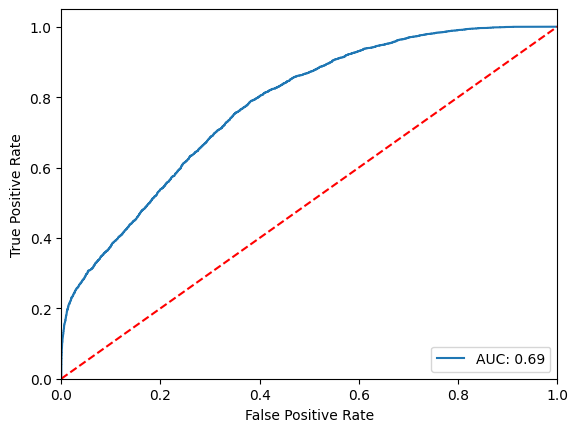

In [74]:
print('train accuracy:',bagging_dt_randomized_search.best_score_, bagging_dt_randomized_search.best_params_, '\n')

y_pred = bagging_dt_randomized_search.predict(X_test)
y_pred_proba = bagging_dt_randomized_search.predict_proba(X_test)
print_performance(y_test, y_pred, y_pred_proba)

### 6.b Simple Bagging RandomForest

In [43]:
bagging_rf = BaggingClassifier(RandomForestClassifier())

bagging_rf.fit(X_train,y_train)

c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_bagging.py:804: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


BaggingClassifier(estimator=RandomForestClassifier())

Train accuracy: 1.0
Accuracy: 0.829758
Precision: 0.456768
Recall: 0.892096
F1 score: 0.604184
AUC: 0.855613


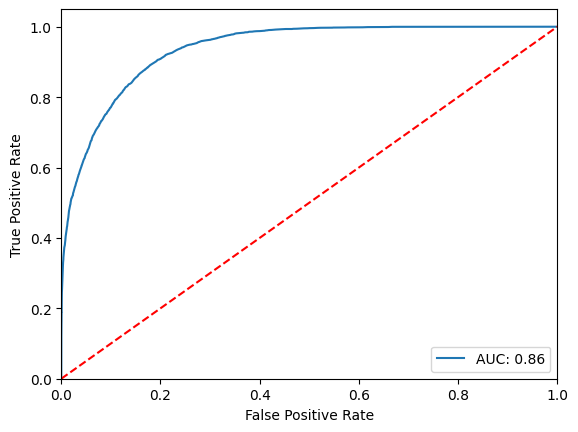

In [44]:
y_pred = bagging_rf.predict(X_test)
y_pred_proba = bagging_rf.predict_proba(X_test)
print(f'Train accuracy: {round(bagging_rf.score(X_train,y_train), 2)}')
print_performance(y_test, y_pred, y_pred_proba)

### 6.b Bagging RandomForest Hyperparameter Opt

In [77]:
bagging_parameter = {
    'estimator__max_depth' : [1, 2, 3, 10, 30, 100],
    'estimator__min_samples_split':list(range(2, 40)),
    'estimator__min_samples_leaf':list(range(2, 40)),
    'estimator__max_features':['None','auto', 'sqrt', 'log2'],
    'estimator__max_leaf_nodes':list(range(10, 60)),
    
    'max_samples' : [0.05, 0.1, 0.2, 0.5],
    'n_estimators':[5, 10, 20, 40, 100],
    'max_features':[0.1,0.25,0.5,0.75,0.99]
}

In [78]:
n_iter = 50
cv = 3

bagging_random_forest = BaggingClassifier(RandomForestClassifier())

bagging_rf_randomized_search = RandomizedSearchCV(estimator=bagging_random_forest, 
                                         param_distributions=bagging_parameter, n_iter=n_iter, cv=cv, scoring='accuracy', verbose=100)

bagging_rf_randomized_search.fit(X_train, y_train)

Fitting 3 folds for each of 50 candidates, totalling 150 fits
[CV 1/3; 1/50] START estimator__max_depth=3, estimator__max_features=log2, estimator__max_leaf_nodes=42, estimator__min_samples_leaf=31, estimator__min_samples_split=11, max_features=0.99, max_samples=0.1, n_estimators=10


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_bagging.py:804: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 1/3; 1/50] END estimator__max_depth=3, estimator__max_features=log2, estimator__max_leaf_nodes=42, estimator__min_samples_leaf=31, estimator__min_samples_split=11, max_features=0.99, max_samples=0.1, n_estimators=10;, score=0.528 total time=   4.8s
[CV 2/3; 1/50] START estimator__max_depth=3, estimator__max_features=log2, estimator__max_leaf_nodes=42, estimator__min_samples_leaf=31, estimator__min_samples_split=11, max_features=0.99, max_samples=0.1, n_estimators=10


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_bagging.py:804: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/3; 1/50] END estimator__max_depth=3, estimator__max_features=log2, estimator__max_leaf_nodes=42, estimator__min_samples_leaf=31, estimator__min_samples_split=11, max_features=0.99, max_samples=0.1, n_estimators=10;, score=0.545 total time=   4.8s
[CV 3/3; 1/50] START estimator__max_depth=3, estimator__max_features=log2, estimator__max_leaf_nodes=42, estimator__min_samples_leaf=31, estimator__min_samples_split=11, max_features=0.99, max_samples=0.1, n_estimators=10


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_bagging.py:804: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 3/3; 1/50] END estimator__max_depth=3, estimator__max_features=log2, estimator__max_leaf_nodes=42, estimator__min_samples_leaf=31, estimator__min_samples_split=11, max_features=0.99, max_samples=0.1, n_estimators=10;, score=0.544 total time=   4.8s
[CV 1/3; 2/50] START estimator__max_depth=2, estimator__max_features=sqrt, estimator__max_leaf_nodes=42, estimator__min_samples_leaf=11, estimator__min_samples_split=3, max_features=0.25, max_samples=0.5, n_estimators=40


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_bagging.py:804: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 1/3; 2/50] END estimator__max_depth=2, estimator__max_features=sqrt, estimator__max_leaf_nodes=42, estimator__min_samples_leaf=11, estimator__min_samples_split=3, max_features=0.25, max_samples=0.5, n_estimators=40;, score=0.554 total time=  27.2s
[CV 2/3; 2/50] START estimator__max_depth=2, estimator__max_features=sqrt, estimator__max_leaf_nodes=42, estimator__min_samples_leaf=11, estimator__min_samples_split=3, max_features=0.25, max_samples=0.5, n_estimators=40


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_bagging.py:804: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/3; 2/50] END estimator__max_depth=2, estimator__max_features=sqrt, estimator__max_leaf_nodes=42, estimator__min_samples_leaf=11, estimator__min_samples_split=3, max_features=0.25, max_samples=0.5, n_estimators=40;, score=0.562 total time=  28.6s
[CV 3/3; 2/50] START estimator__max_depth=2, estimator__max_features=sqrt, estimator__max_leaf_nodes=42, estimator__min_samples_leaf=11, estimator__min_samples_split=3, max_features=0.25, max_samples=0.5, n_estimators=40


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_bagging.py:804: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 3/3; 2/50] END estimator__max_depth=2, estimator__max_features=sqrt, estimator__max_leaf_nodes=42, estimator__min_samples_leaf=11, estimator__min_samples_split=3, max_features=0.25, max_samples=0.5, n_estimators=40;, score=0.561 total time=  28.6s
[CV 1/3; 3/50] START estimator__max_depth=1, estimator__max_features=sqrt, estimator__max_leaf_nodes=35, estimator__min_samples_leaf=29, estimator__min_samples_split=26, max_features=0.1, max_samples=0.2, n_estimators=100


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_bagging.py:804: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 1/3; 3/50] END estimator__max_depth=1, estimator__max_features=sqrt, estimator__max_leaf_nodes=35, estimator__min_samples_leaf=29, estimator__min_samples_split=26, max_features=0.1, max_samples=0.2, n_estimators=100;, score=0.561 total time=  31.9s
[CV 2/3; 3/50] START estimator__max_depth=1, estimator__max_features=sqrt, estimator__max_leaf_nodes=35, estimator__min_samples_leaf=29, estimator__min_samples_split=26, max_features=0.1, max_samples=0.2, n_estimators=100


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_bagging.py:804: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/3; 3/50] END estimator__max_depth=1, estimator__max_features=sqrt, estimator__max_leaf_nodes=35, estimator__min_samples_leaf=29, estimator__min_samples_split=26, max_features=0.1, max_samples=0.2, n_estimators=100;, score=0.551 total time=  32.0s
[CV 3/3; 3/50] START estimator__max_depth=1, estimator__max_features=sqrt, estimator__max_leaf_nodes=35, estimator__min_samples_leaf=29, estimator__min_samples_split=26, max_features=0.1, max_samples=0.2, n_estimators=100


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_bagging.py:804: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 3/3; 3/50] END estimator__max_depth=1, estimator__max_features=sqrt, estimator__max_leaf_nodes=35, estimator__min_samples_leaf=29, estimator__min_samples_split=26, max_features=0.1, max_samples=0.2, n_estimators=100;, score=0.557 total time=  31.6s
[CV 1/3; 4/50] START estimator__max_depth=3, estimator__max_features=None, estimator__max_leaf_nodes=53, estimator__min_samples_leaf=31, estimator__min_samples_split=2, max_features=0.99, max_samples=0.5, n_estimators=100
[CV 1/3; 4/50] END estimator__max_depth=3, estimator__max_features=None, estimator__max_leaf_nodes=53, estimator__min_samples_leaf=31, estimator__min_samples_split=2, max_features=0.99, max_samples=0.5, n_estimators=100;, score=nan total time=   0.0s
[CV 2/3; 4/50] START estimator__max_depth=3, estimator__max_features=None, estimator__max_leaf_nodes=53, estimator__min_samples_leaf=31, estimator__min_samples_split=2, max_features=0.99, max_samples=0.5, n_estimators=100
[CV 2/3; 4/50] END estimator__max_depth=3, estimator

c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_bagging.py:804: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_bagging.py:804: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_bagging.py:804: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_bagging.py:804: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_

[CV 1/3; 5/50] END estimator__max_depth=1, estimator__max_features=auto, estimator__max_leaf_nodes=35, estimator__min_samples_leaf=31, estimator__min_samples_split=2, max_features=0.99, max_samples=0.05, n_estimators=10;, score=0.522 total time=   3.9s
[CV 2/3; 5/50] START estimator__max_depth=1, estimator__max_features=auto, estimator__max_leaf_nodes=35, estimator__min_samples_leaf=31, estimator__min_samples_split=2, max_features=0.99, max_samples=0.05, n_estimators=10


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_bagging.py:804: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_forest.py:425: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_forest.py:425: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
c:\Users\Felipe\minico

[CV 2/3; 5/50] END estimator__max_depth=1, estimator__max_features=auto, estimator__max_leaf_nodes=35, estimator__min_samples_leaf=31, estimator__min_samples_split=2, max_features=0.99, max_samples=0.05, n_estimators=10;, score=0.534 total time=   3.9s
[CV 3/3; 5/50] START estimator__max_depth=1, estimator__max_features=auto, estimator__max_leaf_nodes=35, estimator__min_samples_leaf=31, estimator__min_samples_split=2, max_features=0.99, max_samples=0.05, n_estimators=10


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_bagging.py:804: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_forest.py:425: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_forest.py:425: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
c:\Users\Felipe\minico

[CV 3/3; 5/50] END estimator__max_depth=1, estimator__max_features=auto, estimator__max_leaf_nodes=35, estimator__min_samples_leaf=31, estimator__min_samples_split=2, max_features=0.99, max_samples=0.05, n_estimators=10;, score=0.515 total time=   3.9s
[CV 1/3; 6/50] START estimator__max_depth=30, estimator__max_features=log2, estimator__max_leaf_nodes=58, estimator__min_samples_leaf=24, estimator__min_samples_split=8, max_features=0.99, max_samples=0.2, n_estimators=100


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_bagging.py:804: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 1/3; 6/50] END estimator__max_depth=30, estimator__max_features=log2, estimator__max_leaf_nodes=58, estimator__min_samples_leaf=24, estimator__min_samples_split=8, max_features=0.99, max_samples=0.2, n_estimators=100;, score=0.573 total time= 2.1min
[CV 2/3; 6/50] START estimator__max_depth=30, estimator__max_features=log2, estimator__max_leaf_nodes=58, estimator__min_samples_leaf=24, estimator__min_samples_split=8, max_features=0.99, max_samples=0.2, n_estimators=100


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_bagging.py:804: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/3; 6/50] END estimator__max_depth=30, estimator__max_features=log2, estimator__max_leaf_nodes=58, estimator__min_samples_leaf=24, estimator__min_samples_split=8, max_features=0.99, max_samples=0.2, n_estimators=100;, score=0.583 total time= 2.1min
[CV 3/3; 6/50] START estimator__max_depth=30, estimator__max_features=log2, estimator__max_leaf_nodes=58, estimator__min_samples_leaf=24, estimator__min_samples_split=8, max_features=0.99, max_samples=0.2, n_estimators=100


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_bagging.py:804: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 3/3; 6/50] END estimator__max_depth=30, estimator__max_features=log2, estimator__max_leaf_nodes=58, estimator__min_samples_leaf=24, estimator__min_samples_split=8, max_features=0.99, max_samples=0.2, n_estimators=100;, score=0.583 total time= 2.1min
[CV 1/3; 7/50] START estimator__max_depth=1, estimator__max_features=sqrt, estimator__max_leaf_nodes=54, estimator__min_samples_leaf=11, estimator__min_samples_split=39, max_features=0.75, max_samples=0.05, n_estimators=5


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_bagging.py:804: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 1/3; 7/50] END estimator__max_depth=1, estimator__max_features=sqrt, estimator__max_leaf_nodes=54, estimator__min_samples_leaf=11, estimator__min_samples_split=39, max_features=0.75, max_samples=0.05, n_estimators=5;, score=0.500 total time=   1.7s
[CV 2/3; 7/50] START estimator__max_depth=1, estimator__max_features=sqrt, estimator__max_leaf_nodes=54, estimator__min_samples_leaf=11, estimator__min_samples_split=39, max_features=0.75, max_samples=0.05, n_estimators=5


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_bagging.py:804: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/3; 7/50] END estimator__max_depth=1, estimator__max_features=sqrt, estimator__max_leaf_nodes=54, estimator__min_samples_leaf=11, estimator__min_samples_split=39, max_features=0.75, max_samples=0.05, n_estimators=5;, score=0.517 total time=   1.6s
[CV 3/3; 7/50] START estimator__max_depth=1, estimator__max_features=sqrt, estimator__max_leaf_nodes=54, estimator__min_samples_leaf=11, estimator__min_samples_split=39, max_features=0.75, max_samples=0.05, n_estimators=5


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_bagging.py:804: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 3/3; 7/50] END estimator__max_depth=1, estimator__max_features=sqrt, estimator__max_leaf_nodes=54, estimator__min_samples_leaf=11, estimator__min_samples_split=39, max_features=0.75, max_samples=0.05, n_estimators=5;, score=0.503 total time=   1.7s
[CV 1/3; 8/50] START estimator__max_depth=3, estimator__max_features=None, estimator__max_leaf_nodes=58, estimator__min_samples_leaf=4, estimator__min_samples_split=36, max_features=0.75, max_samples=0.2, n_estimators=10
[CV 1/3; 8/50] END estimator__max_depth=3, estimator__max_features=None, estimator__max_leaf_nodes=58, estimator__min_samples_leaf=4, estimator__min_samples_split=36, max_features=0.75, max_samples=0.2, n_estimators=10;, score=nan total time=   0.0s
[CV 2/3; 8/50] START estimator__max_depth=3, estimator__max_features=None, estimator__max_leaf_nodes=58, estimator__min_samples_leaf=4, estimator__min_samples_split=36, max_features=0.75, max_samples=0.2, n_estimators=10
[CV 2/3; 8/50] END estimator__max_depth=3, estimator__m

c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_bagging.py:804: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_bagging.py:804: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_bagging.py:804: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_bagging.py:804: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_

[CV 2/3; 9/50] END estimator__max_depth=100, estimator__max_features=None, estimator__max_leaf_nodes=28, estimator__min_samples_leaf=13, estimator__min_samples_split=10, max_features=0.99, max_samples=0.1, n_estimators=40;, score=nan total time=   0.0s
[CV 3/3; 9/50] START estimator__max_depth=100, estimator__max_features=None, estimator__max_leaf_nodes=28, estimator__min_samples_leaf=13, estimator__min_samples_split=10, max_features=0.99, max_samples=0.1, n_estimators=40
[CV 3/3; 9/50] END estimator__max_depth=100, estimator__max_features=None, estimator__max_leaf_nodes=28, estimator__min_samples_leaf=13, estimator__min_samples_split=10, max_features=0.99, max_samples=0.1, n_estimators=40;, score=nan total time=   0.0s
[CV 1/3; 10/50] START estimator__max_depth=1, estimator__max_features=None, estimator__max_leaf_nodes=44, estimator__min_samples_leaf=39, estimator__min_samples_split=31, max_features=0.99, max_samples=0.5, n_estimators=5
[CV 1/3; 10/50] END estimator__max_depth=1, esti

c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_bagging.py:804: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_bagging.py:804: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_bagging.py:804: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_bagging.py:804: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_

[CV 3/3; 10/50] END estimator__max_depth=1, estimator__max_features=None, estimator__max_leaf_nodes=44, estimator__min_samples_leaf=39, estimator__min_samples_split=31, max_features=0.99, max_samples=0.5, n_estimators=5;, score=nan total time=   0.0s
[CV 1/3; 11/50] START estimator__max_depth=2, estimator__max_features=log2, estimator__max_leaf_nodes=19, estimator__min_samples_leaf=11, estimator__min_samples_split=8, max_features=0.25, max_samples=0.1, n_estimators=100


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_bagging.py:804: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 1/3; 11/50] END estimator__max_depth=2, estimator__max_features=log2, estimator__max_leaf_nodes=19, estimator__min_samples_leaf=11, estimator__min_samples_split=8, max_features=0.25, max_samples=0.1, n_estimators=100;, score=0.543 total time=  33.1s
[CV 2/3; 11/50] START estimator__max_depth=2, estimator__max_features=log2, estimator__max_leaf_nodes=19, estimator__min_samples_leaf=11, estimator__min_samples_split=8, max_features=0.25, max_samples=0.1, n_estimators=100


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_bagging.py:804: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/3; 11/50] END estimator__max_depth=2, estimator__max_features=log2, estimator__max_leaf_nodes=19, estimator__min_samples_leaf=11, estimator__min_samples_split=8, max_features=0.25, max_samples=0.1, n_estimators=100;, score=0.564 total time=  33.2s
[CV 3/3; 11/50] START estimator__max_depth=2, estimator__max_features=log2, estimator__max_leaf_nodes=19, estimator__min_samples_leaf=11, estimator__min_samples_split=8, max_features=0.25, max_samples=0.1, n_estimators=100


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_bagging.py:804: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 3/3; 11/50] END estimator__max_depth=2, estimator__max_features=log2, estimator__max_leaf_nodes=19, estimator__min_samples_leaf=11, estimator__min_samples_split=8, max_features=0.25, max_samples=0.1, n_estimators=100;, score=0.541 total time=  33.3s
[CV 1/3; 12/50] START estimator__max_depth=100, estimator__max_features=log2, estimator__max_leaf_nodes=52, estimator__min_samples_leaf=17, estimator__min_samples_split=23, max_features=0.5, max_samples=0.5, n_estimators=20


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_bagging.py:804: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 1/3; 12/50] END estimator__max_depth=100, estimator__max_features=log2, estimator__max_leaf_nodes=52, estimator__min_samples_leaf=17, estimator__min_samples_split=23, max_features=0.5, max_samples=0.5, n_estimators=20;, score=0.613 total time=  37.2s
[CV 2/3; 12/50] START estimator__max_depth=100, estimator__max_features=log2, estimator__max_leaf_nodes=52, estimator__min_samples_leaf=17, estimator__min_samples_split=23, max_features=0.5, max_samples=0.5, n_estimators=20


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_bagging.py:804: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/3; 12/50] END estimator__max_depth=100, estimator__max_features=log2, estimator__max_leaf_nodes=52, estimator__min_samples_leaf=17, estimator__min_samples_split=23, max_features=0.5, max_samples=0.5, n_estimators=20;, score=0.625 total time=  37.9s
[CV 3/3; 12/50] START estimator__max_depth=100, estimator__max_features=log2, estimator__max_leaf_nodes=52, estimator__min_samples_leaf=17, estimator__min_samples_split=23, max_features=0.5, max_samples=0.5, n_estimators=20


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_bagging.py:804: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 3/3; 12/50] END estimator__max_depth=100, estimator__max_features=log2, estimator__max_leaf_nodes=52, estimator__min_samples_leaf=17, estimator__min_samples_split=23, max_features=0.5, max_samples=0.5, n_estimators=20;, score=0.602 total time=  38.0s
[CV 1/3; 13/50] START estimator__max_depth=2, estimator__max_features=auto, estimator__max_leaf_nodes=37, estimator__min_samples_leaf=7, estimator__min_samples_split=32, max_features=0.99, max_samples=0.05, n_estimators=10


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_bagging.py:804: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_forest.py:425: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_forest.py:425: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
c:\Users\Felipe\minico

[CV 1/3; 13/50] END estimator__max_depth=2, estimator__max_features=auto, estimator__max_leaf_nodes=37, estimator__min_samples_leaf=7, estimator__min_samples_split=32, max_features=0.99, max_samples=0.05, n_estimators=10;, score=0.536 total time=   5.1s
[CV 2/3; 13/50] START estimator__max_depth=2, estimator__max_features=auto, estimator__max_leaf_nodes=37, estimator__min_samples_leaf=7, estimator__min_samples_split=32, max_features=0.99, max_samples=0.05, n_estimators=10


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_bagging.py:804: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_forest.py:425: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_forest.py:425: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
c:\Users\Felipe\minico

[CV 2/3; 13/50] END estimator__max_depth=2, estimator__max_features=auto, estimator__max_leaf_nodes=37, estimator__min_samples_leaf=7, estimator__min_samples_split=32, max_features=0.99, max_samples=0.05, n_estimators=10;, score=0.531 total time=   4.9s
[CV 3/3; 13/50] START estimator__max_depth=2, estimator__max_features=auto, estimator__max_leaf_nodes=37, estimator__min_samples_leaf=7, estimator__min_samples_split=32, max_features=0.99, max_samples=0.05, n_estimators=10


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_bagging.py:804: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_forest.py:425: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_forest.py:425: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
c:\Users\Felipe\minico

[CV 3/3; 13/50] END estimator__max_depth=2, estimator__max_features=auto, estimator__max_leaf_nodes=37, estimator__min_samples_leaf=7, estimator__min_samples_split=32, max_features=0.99, max_samples=0.05, n_estimators=10;, score=0.535 total time=   4.8s
[CV 1/3; 14/50] START estimator__max_depth=1, estimator__max_features=auto, estimator__max_leaf_nodes=50, estimator__min_samples_leaf=15, estimator__min_samples_split=24, max_features=0.99, max_samples=0.1, n_estimators=10


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_bagging.py:804: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_forest.py:425: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_forest.py:425: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
c:\Users\Felipe\minico

[CV 1/3; 14/50] END estimator__max_depth=1, estimator__max_features=auto, estimator__max_leaf_nodes=50, estimator__min_samples_leaf=15, estimator__min_samples_split=24, max_features=0.99, max_samples=0.1, n_estimators=10;, score=0.533 total time=   4.4s
[CV 2/3; 14/50] START estimator__max_depth=1, estimator__max_features=auto, estimator__max_leaf_nodes=50, estimator__min_samples_leaf=15, estimator__min_samples_split=24, max_features=0.99, max_samples=0.1, n_estimators=10


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_bagging.py:804: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_forest.py:425: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_forest.py:425: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
c:\Users\Felipe\minico

[CV 2/3; 14/50] END estimator__max_depth=1, estimator__max_features=auto, estimator__max_leaf_nodes=50, estimator__min_samples_leaf=15, estimator__min_samples_split=24, max_features=0.99, max_samples=0.1, n_estimators=10;, score=0.524 total time=   4.4s
[CV 3/3; 14/50] START estimator__max_depth=1, estimator__max_features=auto, estimator__max_leaf_nodes=50, estimator__min_samples_leaf=15, estimator__min_samples_split=24, max_features=0.99, max_samples=0.1, n_estimators=10


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_bagging.py:804: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_forest.py:425: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_forest.py:425: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
c:\Users\Felipe\minico

[CV 3/3; 14/50] END estimator__max_depth=1, estimator__max_features=auto, estimator__max_leaf_nodes=50, estimator__min_samples_leaf=15, estimator__min_samples_split=24, max_features=0.99, max_samples=0.1, n_estimators=10;, score=0.523 total time=   4.5s
[CV 1/3; 15/50] START estimator__max_depth=30, estimator__max_features=auto, estimator__max_leaf_nodes=13, estimator__min_samples_leaf=29, estimator__min_samples_split=2, max_features=0.5, max_samples=0.05, n_estimators=40


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_bagging.py:804: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_forest.py:425: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_forest.py:425: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
c:\Users\Felipe\minico

[CV 1/3; 15/50] END estimator__max_depth=30, estimator__max_features=auto, estimator__max_leaf_nodes=13, estimator__min_samples_leaf=29, estimator__min_samples_split=2, max_features=0.5, max_samples=0.05, n_estimators=40;, score=0.553 total time=  23.3s
[CV 2/3; 15/50] START estimator__max_depth=30, estimator__max_features=auto, estimator__max_leaf_nodes=13, estimator__min_samples_leaf=29, estimator__min_samples_split=2, max_features=0.5, max_samples=0.05, n_estimators=40


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_bagging.py:804: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_forest.py:425: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_forest.py:425: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
c:\Users\Felipe\minico

[CV 2/3; 15/50] END estimator__max_depth=30, estimator__max_features=auto, estimator__max_leaf_nodes=13, estimator__min_samples_leaf=29, estimator__min_samples_split=2, max_features=0.5, max_samples=0.05, n_estimators=40;, score=0.535 total time=  22.9s
[CV 3/3; 15/50] START estimator__max_depth=30, estimator__max_features=auto, estimator__max_leaf_nodes=13, estimator__min_samples_leaf=29, estimator__min_samples_split=2, max_features=0.5, max_samples=0.05, n_estimators=40


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_bagging.py:804: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_forest.py:425: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_forest.py:425: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
c:\Users\Felipe\minico

[CV 3/3; 15/50] END estimator__max_depth=30, estimator__max_features=auto, estimator__max_leaf_nodes=13, estimator__min_samples_leaf=29, estimator__min_samples_split=2, max_features=0.5, max_samples=0.05, n_estimators=40;, score=0.540 total time=  22.3s
[CV 1/3; 16/50] START estimator__max_depth=1, estimator__max_features=sqrt, estimator__max_leaf_nodes=53, estimator__min_samples_leaf=14, estimator__min_samples_split=22, max_features=0.1, max_samples=0.2, n_estimators=20


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_bagging.py:804: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 1/3; 16/50] END estimator__max_depth=1, estimator__max_features=sqrt, estimator__max_leaf_nodes=53, estimator__min_samples_leaf=14, estimator__min_samples_split=22, max_features=0.1, max_samples=0.2, n_estimators=20;, score=0.535 total time=   6.1s
[CV 2/3; 16/50] START estimator__max_depth=1, estimator__max_features=sqrt, estimator__max_leaf_nodes=53, estimator__min_samples_leaf=14, estimator__min_samples_split=22, max_features=0.1, max_samples=0.2, n_estimators=20


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_bagging.py:804: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/3; 16/50] END estimator__max_depth=1, estimator__max_features=sqrt, estimator__max_leaf_nodes=53, estimator__min_samples_leaf=14, estimator__min_samples_split=22, max_features=0.1, max_samples=0.2, n_estimators=20;, score=0.545 total time=   6.1s
[CV 3/3; 16/50] START estimator__max_depth=1, estimator__max_features=sqrt, estimator__max_leaf_nodes=53, estimator__min_samples_leaf=14, estimator__min_samples_split=22, max_features=0.1, max_samples=0.2, n_estimators=20


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_bagging.py:804: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 3/3; 16/50] END estimator__max_depth=1, estimator__max_features=sqrt, estimator__max_leaf_nodes=53, estimator__min_samples_leaf=14, estimator__min_samples_split=22, max_features=0.1, max_samples=0.2, n_estimators=20;, score=0.536 total time=   6.1s
[CV 1/3; 17/50] START estimator__max_depth=3, estimator__max_features=None, estimator__max_leaf_nodes=56, estimator__min_samples_leaf=26, estimator__min_samples_split=12, max_features=0.75, max_samples=0.2, n_estimators=10
[CV 1/3; 17/50] END estimator__max_depth=3, estimator__max_features=None, estimator__max_leaf_nodes=56, estimator__min_samples_leaf=26, estimator__min_samples_split=12, max_features=0.75, max_samples=0.2, n_estimators=10;, score=nan total time=   0.0s
[CV 2/3; 17/50] START estimator__max_depth=3, estimator__max_features=None, estimator__max_leaf_nodes=56, estimator__min_samples_leaf=26, estimator__min_samples_split=12, max_features=0.75, max_samples=0.2, n_estimators=10
[CV 2/3; 17/50] END estimator__max_depth=3, estim

c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_bagging.py:804: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_bagging.py:804: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_bagging.py:804: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_bagging.py:804: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_

[CV 1/3; 18/50] END estimator__max_depth=100, estimator__max_features=auto, estimator__max_leaf_nodes=25, estimator__min_samples_leaf=32, estimator__min_samples_split=13, max_features=0.1, max_samples=0.05, n_estimators=40;, score=0.541 total time=  14.9s
[CV 2/3; 18/50] START estimator__max_depth=100, estimator__max_features=auto, estimator__max_leaf_nodes=25, estimator__min_samples_leaf=32, estimator__min_samples_split=13, max_features=0.1, max_samples=0.05, n_estimators=40


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_bagging.py:804: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_forest.py:425: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_forest.py:425: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
c:\Users\Felipe\minico

[CV 2/3; 18/50] END estimator__max_depth=100, estimator__max_features=auto, estimator__max_leaf_nodes=25, estimator__min_samples_leaf=32, estimator__min_samples_split=13, max_features=0.1, max_samples=0.05, n_estimators=40;, score=0.544 total time=  14.7s
[CV 3/3; 18/50] START estimator__max_depth=100, estimator__max_features=auto, estimator__max_leaf_nodes=25, estimator__min_samples_leaf=32, estimator__min_samples_split=13, max_features=0.1, max_samples=0.05, n_estimators=40


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_bagging.py:804: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_forest.py:425: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_forest.py:425: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
c:\Users\Felipe\minico

[CV 3/3; 18/50] END estimator__max_depth=100, estimator__max_features=auto, estimator__max_leaf_nodes=25, estimator__min_samples_leaf=32, estimator__min_samples_split=13, max_features=0.1, max_samples=0.05, n_estimators=40;, score=0.540 total time=  14.6s
[CV 1/3; 19/50] START estimator__max_depth=2, estimator__max_features=sqrt, estimator__max_leaf_nodes=11, estimator__min_samples_leaf=21, estimator__min_samples_split=18, max_features=0.75, max_samples=0.5, n_estimators=5


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_bagging.py:804: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 1/3; 19/50] END estimator__max_depth=2, estimator__max_features=sqrt, estimator__max_leaf_nodes=11, estimator__min_samples_leaf=21, estimator__min_samples_split=18, max_features=0.75, max_samples=0.5, n_estimators=5;, score=0.554 total time=   5.1s
[CV 2/3; 19/50] START estimator__max_depth=2, estimator__max_features=sqrt, estimator__max_leaf_nodes=11, estimator__min_samples_leaf=21, estimator__min_samples_split=18, max_features=0.75, max_samples=0.5, n_estimators=5


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_bagging.py:804: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/3; 19/50] END estimator__max_depth=2, estimator__max_features=sqrt, estimator__max_leaf_nodes=11, estimator__min_samples_leaf=21, estimator__min_samples_split=18, max_features=0.75, max_samples=0.5, n_estimators=5;, score=0.563 total time=   5.1s
[CV 3/3; 19/50] START estimator__max_depth=2, estimator__max_features=sqrt, estimator__max_leaf_nodes=11, estimator__min_samples_leaf=21, estimator__min_samples_split=18, max_features=0.75, max_samples=0.5, n_estimators=5


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_bagging.py:804: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 3/3; 19/50] END estimator__max_depth=2, estimator__max_features=sqrt, estimator__max_leaf_nodes=11, estimator__min_samples_leaf=21, estimator__min_samples_split=18, max_features=0.75, max_samples=0.5, n_estimators=5;, score=0.548 total time=   5.0s
[CV 1/3; 20/50] START estimator__max_depth=1, estimator__max_features=sqrt, estimator__max_leaf_nodes=35, estimator__min_samples_leaf=36, estimator__min_samples_split=11, max_features=0.75, max_samples=0.5, n_estimators=100


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_bagging.py:804: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 1/3; 20/50] END estimator__max_depth=1, estimator__max_features=sqrt, estimator__max_leaf_nodes=35, estimator__min_samples_leaf=36, estimator__min_samples_split=11, max_features=0.75, max_samples=0.5, n_estimators=100;, score=0.544 total time= 1.1min
[CV 2/3; 20/50] START estimator__max_depth=1, estimator__max_features=sqrt, estimator__max_leaf_nodes=35, estimator__min_samples_leaf=36, estimator__min_samples_split=11, max_features=0.75, max_samples=0.5, n_estimators=100


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_bagging.py:804: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/3; 20/50] END estimator__max_depth=1, estimator__max_features=sqrt, estimator__max_leaf_nodes=35, estimator__min_samples_leaf=36, estimator__min_samples_split=11, max_features=0.75, max_samples=0.5, n_estimators=100;, score=0.548 total time= 1.1min
[CV 3/3; 20/50] START estimator__max_depth=1, estimator__max_features=sqrt, estimator__max_leaf_nodes=35, estimator__min_samples_leaf=36, estimator__min_samples_split=11, max_features=0.75, max_samples=0.5, n_estimators=100


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_bagging.py:804: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 3/3; 20/50] END estimator__max_depth=1, estimator__max_features=sqrt, estimator__max_leaf_nodes=35, estimator__min_samples_leaf=36, estimator__min_samples_split=11, max_features=0.75, max_samples=0.5, n_estimators=100;, score=0.543 total time= 1.1min
[CV 1/3; 21/50] START estimator__max_depth=10, estimator__max_features=log2, estimator__max_leaf_nodes=30, estimator__min_samples_leaf=19, estimator__min_samples_split=37, max_features=0.5, max_samples=0.5, n_estimators=40


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_bagging.py:804: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 1/3; 21/50] END estimator__max_depth=10, estimator__max_features=log2, estimator__max_leaf_nodes=30, estimator__min_samples_leaf=19, estimator__min_samples_split=37, max_features=0.5, max_samples=0.5, n_estimators=40;, score=0.595 total time= 1.0min
[CV 2/3; 21/50] START estimator__max_depth=10, estimator__max_features=log2, estimator__max_leaf_nodes=30, estimator__min_samples_leaf=19, estimator__min_samples_split=37, max_features=0.5, max_samples=0.5, n_estimators=40


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_bagging.py:804: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/3; 21/50] END estimator__max_depth=10, estimator__max_features=log2, estimator__max_leaf_nodes=30, estimator__min_samples_leaf=19, estimator__min_samples_split=37, max_features=0.5, max_samples=0.5, n_estimators=40;, score=0.597 total time= 1.0min
[CV 3/3; 21/50] START estimator__max_depth=10, estimator__max_features=log2, estimator__max_leaf_nodes=30, estimator__min_samples_leaf=19, estimator__min_samples_split=37, max_features=0.5, max_samples=0.5, n_estimators=40


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_bagging.py:804: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 3/3; 21/50] END estimator__max_depth=10, estimator__max_features=log2, estimator__max_leaf_nodes=30, estimator__min_samples_leaf=19, estimator__min_samples_split=37, max_features=0.5, max_samples=0.5, n_estimators=40;, score=0.602 total time= 1.0min
[CV 1/3; 22/50] START estimator__max_depth=3, estimator__max_features=sqrt, estimator__max_leaf_nodes=25, estimator__min_samples_leaf=37, estimator__min_samples_split=16, max_features=0.1, max_samples=0.05, n_estimators=40


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_bagging.py:804: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 1/3; 22/50] END estimator__max_depth=3, estimator__max_features=sqrt, estimator__max_leaf_nodes=25, estimator__min_samples_leaf=37, estimator__min_samples_split=16, max_features=0.1, max_samples=0.05, n_estimators=40;, score=0.523 total time=  12.7s
[CV 2/3; 22/50] START estimator__max_depth=3, estimator__max_features=sqrt, estimator__max_leaf_nodes=25, estimator__min_samples_leaf=37, estimator__min_samples_split=16, max_features=0.1, max_samples=0.05, n_estimators=40


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_bagging.py:804: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/3; 22/50] END estimator__max_depth=3, estimator__max_features=sqrt, estimator__max_leaf_nodes=25, estimator__min_samples_leaf=37, estimator__min_samples_split=16, max_features=0.1, max_samples=0.05, n_estimators=40;, score=0.509 total time=  12.5s
[CV 3/3; 22/50] START estimator__max_depth=3, estimator__max_features=sqrt, estimator__max_leaf_nodes=25, estimator__min_samples_leaf=37, estimator__min_samples_split=16, max_features=0.1, max_samples=0.05, n_estimators=40


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_bagging.py:804: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 3/3; 22/50] END estimator__max_depth=3, estimator__max_features=sqrt, estimator__max_leaf_nodes=25, estimator__min_samples_leaf=37, estimator__min_samples_split=16, max_features=0.1, max_samples=0.05, n_estimators=40;, score=0.547 total time=  12.6s
[CV 1/3; 23/50] START estimator__max_depth=1, estimator__max_features=auto, estimator__max_leaf_nodes=36, estimator__min_samples_leaf=18, estimator__min_samples_split=19, max_features=0.25, max_samples=0.05, n_estimators=40


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_bagging.py:804: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_forest.py:425: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_forest.py:425: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
c:\Users\Felipe\minico

[CV 1/3; 23/50] END estimator__max_depth=1, estimator__max_features=auto, estimator__max_leaf_nodes=36, estimator__min_samples_leaf=18, estimator__min_samples_split=19, max_features=0.25, max_samples=0.05, n_estimators=40;, score=0.501 total time=  11.5s
[CV 2/3; 23/50] START estimator__max_depth=1, estimator__max_features=auto, estimator__max_leaf_nodes=36, estimator__min_samples_leaf=18, estimator__min_samples_split=19, max_features=0.25, max_samples=0.05, n_estimators=40


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_bagging.py:804: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_forest.py:425: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_forest.py:425: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
c:\Users\Felipe\minico

[CV 2/3; 23/50] END estimator__max_depth=1, estimator__max_features=auto, estimator__max_leaf_nodes=36, estimator__min_samples_leaf=18, estimator__min_samples_split=19, max_features=0.25, max_samples=0.05, n_estimators=40;, score=0.499 total time=  11.4s
[CV 3/3; 23/50] START estimator__max_depth=1, estimator__max_features=auto, estimator__max_leaf_nodes=36, estimator__min_samples_leaf=18, estimator__min_samples_split=19, max_features=0.25, max_samples=0.05, n_estimators=40


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_bagging.py:804: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_forest.py:425: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_forest.py:425: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
c:\Users\Felipe\minico

[CV 3/3; 23/50] END estimator__max_depth=1, estimator__max_features=auto, estimator__max_leaf_nodes=36, estimator__min_samples_leaf=18, estimator__min_samples_split=19, max_features=0.25, max_samples=0.05, n_estimators=40;, score=0.517 total time=  11.5s
[CV 1/3; 24/50] START estimator__max_depth=2, estimator__max_features=None, estimator__max_leaf_nodes=38, estimator__min_samples_leaf=33, estimator__min_samples_split=31, max_features=0.25, max_samples=0.5, n_estimators=10
[CV 1/3; 24/50] END estimator__max_depth=2, estimator__max_features=None, estimator__max_leaf_nodes=38, estimator__min_samples_leaf=33, estimator__min_samples_split=31, max_features=0.25, max_samples=0.5, n_estimators=10;, score=nan total time=   0.0s
[CV 2/3; 24/50] START estimator__max_depth=2, estimator__max_features=None, estimator__max_leaf_nodes=38, estimator__min_samples_leaf=33, estimator__min_samples_split=31, max_features=0.25, max_samples=0.5, n_estimators=10
[CV 2/3; 24/50] END estimator__max_depth=2, est

c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_bagging.py:804: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_bagging.py:804: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_bagging.py:804: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_bagging.py:804: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_

[CV 1/3; 25/50] END estimator__max_depth=10, estimator__max_features=auto, estimator__max_leaf_nodes=56, estimator__min_samples_leaf=34, estimator__min_samples_split=24, max_features=0.5, max_samples=0.2, n_estimators=20;, score=0.577 total time=  32.0s
[CV 2/3; 25/50] START estimator__max_depth=10, estimator__max_features=auto, estimator__max_leaf_nodes=56, estimator__min_samples_leaf=34, estimator__min_samples_split=24, max_features=0.5, max_samples=0.2, n_estimators=20


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_bagging.py:804: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_forest.py:425: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_forest.py:425: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
c:\Users\Felipe\minico

[CV 2/3; 25/50] END estimator__max_depth=10, estimator__max_features=auto, estimator__max_leaf_nodes=56, estimator__min_samples_leaf=34, estimator__min_samples_split=24, max_features=0.5, max_samples=0.2, n_estimators=20;, score=0.590 total time=  33.8s
[CV 3/3; 25/50] START estimator__max_depth=10, estimator__max_features=auto, estimator__max_leaf_nodes=56, estimator__min_samples_leaf=34, estimator__min_samples_split=24, max_features=0.5, max_samples=0.2, n_estimators=20


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_bagging.py:804: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_forest.py:425: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_forest.py:425: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
c:\Users\Felipe\minico

[CV 3/3; 25/50] END estimator__max_depth=10, estimator__max_features=auto, estimator__max_leaf_nodes=56, estimator__min_samples_leaf=34, estimator__min_samples_split=24, max_features=0.5, max_samples=0.2, n_estimators=20;, score=0.587 total time=  33.2s
[CV 1/3; 26/50] START estimator__max_depth=2, estimator__max_features=log2, estimator__max_leaf_nodes=26, estimator__min_samples_leaf=7, estimator__min_samples_split=15, max_features=0.25, max_samples=0.5, n_estimators=100


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_bagging.py:804: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 1/3; 26/50] END estimator__max_depth=2, estimator__max_features=log2, estimator__max_leaf_nodes=26, estimator__min_samples_leaf=7, estimator__min_samples_split=15, max_features=0.25, max_samples=0.5, n_estimators=100;, score=0.540 total time=  52.9s
[CV 2/3; 26/50] START estimator__max_depth=2, estimator__max_features=log2, estimator__max_leaf_nodes=26, estimator__min_samples_leaf=7, estimator__min_samples_split=15, max_features=0.25, max_samples=0.5, n_estimators=100


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_bagging.py:804: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/3; 26/50] END estimator__max_depth=2, estimator__max_features=log2, estimator__max_leaf_nodes=26, estimator__min_samples_leaf=7, estimator__min_samples_split=15, max_features=0.25, max_samples=0.5, n_estimators=100;, score=0.556 total time=  52.6s
[CV 3/3; 26/50] START estimator__max_depth=2, estimator__max_features=log2, estimator__max_leaf_nodes=26, estimator__min_samples_leaf=7, estimator__min_samples_split=15, max_features=0.25, max_samples=0.5, n_estimators=100


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_bagging.py:804: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 3/3; 26/50] END estimator__max_depth=2, estimator__max_features=log2, estimator__max_leaf_nodes=26, estimator__min_samples_leaf=7, estimator__min_samples_split=15, max_features=0.25, max_samples=0.5, n_estimators=100;, score=0.547 total time=  52.7s
[CV 1/3; 27/50] START estimator__max_depth=10, estimator__max_features=sqrt, estimator__max_leaf_nodes=42, estimator__min_samples_leaf=9, estimator__min_samples_split=27, max_features=0.75, max_samples=0.05, n_estimators=5


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_bagging.py:804: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 1/3; 27/50] END estimator__max_depth=10, estimator__max_features=sqrt, estimator__max_leaf_nodes=42, estimator__min_samples_leaf=9, estimator__min_samples_split=27, max_features=0.75, max_samples=0.05, n_estimators=5;, score=0.532 total time=   4.2s
[CV 2/3; 27/50] START estimator__max_depth=10, estimator__max_features=sqrt, estimator__max_leaf_nodes=42, estimator__min_samples_leaf=9, estimator__min_samples_split=27, max_features=0.75, max_samples=0.05, n_estimators=5


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_bagging.py:804: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/3; 27/50] END estimator__max_depth=10, estimator__max_features=sqrt, estimator__max_leaf_nodes=42, estimator__min_samples_leaf=9, estimator__min_samples_split=27, max_features=0.75, max_samples=0.05, n_estimators=5;, score=0.531 total time=   4.3s
[CV 3/3; 27/50] START estimator__max_depth=10, estimator__max_features=sqrt, estimator__max_leaf_nodes=42, estimator__min_samples_leaf=9, estimator__min_samples_split=27, max_features=0.75, max_samples=0.05, n_estimators=5


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_bagging.py:804: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 3/3; 27/50] END estimator__max_depth=10, estimator__max_features=sqrt, estimator__max_leaf_nodes=42, estimator__min_samples_leaf=9, estimator__min_samples_split=27, max_features=0.75, max_samples=0.05, n_estimators=5;, score=0.533 total time=   4.3s
[CV 1/3; 28/50] START estimator__max_depth=1, estimator__max_features=auto, estimator__max_leaf_nodes=53, estimator__min_samples_leaf=8, estimator__min_samples_split=19, max_features=0.25, max_samples=0.5, n_estimators=20


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_bagging.py:804: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_forest.py:425: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_forest.py:425: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
c:\Users\Felipe\minico

[CV 1/3; 28/50] END estimator__max_depth=1, estimator__max_features=auto, estimator__max_leaf_nodes=53, estimator__min_samples_leaf=8, estimator__min_samples_split=19, max_features=0.25, max_samples=0.5, n_estimators=20;, score=0.506 total time=   9.5s
[CV 2/3; 28/50] START estimator__max_depth=1, estimator__max_features=auto, estimator__max_leaf_nodes=53, estimator__min_samples_leaf=8, estimator__min_samples_split=19, max_features=0.25, max_samples=0.5, n_estimators=20


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_bagging.py:804: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_forest.py:425: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_forest.py:425: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
c:\Users\Felipe\minico

[CV 2/3; 28/50] END estimator__max_depth=1, estimator__max_features=auto, estimator__max_leaf_nodes=53, estimator__min_samples_leaf=8, estimator__min_samples_split=19, max_features=0.25, max_samples=0.5, n_estimators=20;, score=0.543 total time=   9.5s
[CV 3/3; 28/50] START estimator__max_depth=1, estimator__max_features=auto, estimator__max_leaf_nodes=53, estimator__min_samples_leaf=8, estimator__min_samples_split=19, max_features=0.25, max_samples=0.5, n_estimators=20


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_bagging.py:804: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_forest.py:425: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_forest.py:425: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
c:\Users\Felipe\minico

[CV 3/3; 28/50] END estimator__max_depth=1, estimator__max_features=auto, estimator__max_leaf_nodes=53, estimator__min_samples_leaf=8, estimator__min_samples_split=19, max_features=0.25, max_samples=0.5, n_estimators=20;, score=0.543 total time=   9.7s
[CV 1/3; 29/50] START estimator__max_depth=10, estimator__max_features=auto, estimator__max_leaf_nodes=32, estimator__min_samples_leaf=9, estimator__min_samples_split=17, max_features=0.5, max_samples=0.5, n_estimators=100


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_bagging.py:804: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_forest.py:425: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_forest.py:425: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
c:\Users\Felipe\minico

[CV 1/3; 29/50] END estimator__max_depth=10, estimator__max_features=auto, estimator__max_leaf_nodes=32, estimator__min_samples_leaf=9, estimator__min_samples_split=17, max_features=0.5, max_samples=0.5, n_estimators=100;, score=0.626 total time= 4.8min
[CV 2/3; 29/50] START estimator__max_depth=10, estimator__max_features=auto, estimator__max_leaf_nodes=32, estimator__min_samples_leaf=9, estimator__min_samples_split=17, max_features=0.5, max_samples=0.5, n_estimators=100


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_bagging.py:804: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_forest.py:425: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_forest.py:425: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
c:\Users\Felipe\minico

[CV 2/3; 29/50] END estimator__max_depth=10, estimator__max_features=auto, estimator__max_leaf_nodes=32, estimator__min_samples_leaf=9, estimator__min_samples_split=17, max_features=0.5, max_samples=0.5, n_estimators=100;, score=0.634 total time= 4.7min
[CV 3/3; 29/50] START estimator__max_depth=10, estimator__max_features=auto, estimator__max_leaf_nodes=32, estimator__min_samples_leaf=9, estimator__min_samples_split=17, max_features=0.5, max_samples=0.5, n_estimators=100


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_bagging.py:804: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_forest.py:425: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_forest.py:425: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
c:\Users\Felipe\minico

[CV 3/3; 29/50] END estimator__max_depth=10, estimator__max_features=auto, estimator__max_leaf_nodes=32, estimator__min_samples_leaf=9, estimator__min_samples_split=17, max_features=0.5, max_samples=0.5, n_estimators=100;, score=0.632 total time= 4.7min
[CV 1/3; 30/50] START estimator__max_depth=3, estimator__max_features=sqrt, estimator__max_leaf_nodes=30, estimator__min_samples_leaf=22, estimator__min_samples_split=13, max_features=0.5, max_samples=0.5, n_estimators=20


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_bagging.py:804: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 1/3; 30/50] END estimator__max_depth=3, estimator__max_features=sqrt, estimator__max_leaf_nodes=30, estimator__min_samples_leaf=22, estimator__min_samples_split=13, max_features=0.5, max_samples=0.5, n_estimators=20;, score=0.565 total time=  23.9s
[CV 2/3; 30/50] START estimator__max_depth=3, estimator__max_features=sqrt, estimator__max_leaf_nodes=30, estimator__min_samples_leaf=22, estimator__min_samples_split=13, max_features=0.5, max_samples=0.5, n_estimators=20


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_bagging.py:804: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/3; 30/50] END estimator__max_depth=3, estimator__max_features=sqrt, estimator__max_leaf_nodes=30, estimator__min_samples_leaf=22, estimator__min_samples_split=13, max_features=0.5, max_samples=0.5, n_estimators=20;, score=0.571 total time=  24.6s
[CV 3/3; 30/50] START estimator__max_depth=3, estimator__max_features=sqrt, estimator__max_leaf_nodes=30, estimator__min_samples_leaf=22, estimator__min_samples_split=13, max_features=0.5, max_samples=0.5, n_estimators=20


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_bagging.py:804: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 3/3; 30/50] END estimator__max_depth=3, estimator__max_features=sqrt, estimator__max_leaf_nodes=30, estimator__min_samples_leaf=22, estimator__min_samples_split=13, max_features=0.5, max_samples=0.5, n_estimators=20;, score=0.561 total time=  24.0s
[CV 1/3; 31/50] START estimator__max_depth=100, estimator__max_features=None, estimator__max_leaf_nodes=59, estimator__min_samples_leaf=5, estimator__min_samples_split=33, max_features=0.99, max_samples=0.5, n_estimators=20
[CV 1/3; 31/50] END estimator__max_depth=100, estimator__max_features=None, estimator__max_leaf_nodes=59, estimator__min_samples_leaf=5, estimator__min_samples_split=33, max_features=0.99, max_samples=0.5, n_estimators=20;, score=nan total time=   0.0s
[CV 2/3; 31/50] START estimator__max_depth=100, estimator__max_features=None, estimator__max_leaf_nodes=59, estimator__min_samples_leaf=5, estimator__min_samples_split=33, max_features=0.99, max_samples=0.5, n_estimators=20
[CV 2/3; 31/50] END estimator__max_depth=100, 

c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_bagging.py:804: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_bagging.py:804: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_bagging.py:804: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_bagging.py:804: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_

[CV 1/3; 32/50] END estimator__max_depth=100, estimator__max_features=sqrt, estimator__max_leaf_nodes=32, estimator__min_samples_leaf=38, estimator__min_samples_split=11, max_features=0.25, max_samples=0.2, n_estimators=100;, score=0.572 total time= 2.0min
[CV 2/3; 32/50] START estimator__max_depth=100, estimator__max_features=sqrt, estimator__max_leaf_nodes=32, estimator__min_samples_leaf=38, estimator__min_samples_split=11, max_features=0.25, max_samples=0.2, n_estimators=100


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_bagging.py:804: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/3; 32/50] END estimator__max_depth=100, estimator__max_features=sqrt, estimator__max_leaf_nodes=32, estimator__min_samples_leaf=38, estimator__min_samples_split=11, max_features=0.25, max_samples=0.2, n_estimators=100;, score=0.581 total time= 2.1min
[CV 3/3; 32/50] START estimator__max_depth=100, estimator__max_features=sqrt, estimator__max_leaf_nodes=32, estimator__min_samples_leaf=38, estimator__min_samples_split=11, max_features=0.25, max_samples=0.2, n_estimators=100


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_bagging.py:804: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 3/3; 32/50] END estimator__max_depth=100, estimator__max_features=sqrt, estimator__max_leaf_nodes=32, estimator__min_samples_leaf=38, estimator__min_samples_split=11, max_features=0.25, max_samples=0.2, n_estimators=100;, score=0.579 total time= 2.0min
[CV 1/3; 33/50] START estimator__max_depth=2, estimator__max_features=sqrt, estimator__max_leaf_nodes=31, estimator__min_samples_leaf=19, estimator__min_samples_split=24, max_features=0.25, max_samples=0.05, n_estimators=20


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_bagging.py:804: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 1/3; 33/50] END estimator__max_depth=2, estimator__max_features=sqrt, estimator__max_leaf_nodes=31, estimator__min_samples_leaf=19, estimator__min_samples_split=24, max_features=0.25, max_samples=0.05, n_estimators=20;, score=0.535 total time=   7.0s
[CV 2/3; 33/50] START estimator__max_depth=2, estimator__max_features=sqrt, estimator__max_leaf_nodes=31, estimator__min_samples_leaf=19, estimator__min_samples_split=24, max_features=0.25, max_samples=0.05, n_estimators=20


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_bagging.py:804: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/3; 33/50] END estimator__max_depth=2, estimator__max_features=sqrt, estimator__max_leaf_nodes=31, estimator__min_samples_leaf=19, estimator__min_samples_split=24, max_features=0.25, max_samples=0.05, n_estimators=20;, score=0.527 total time=   6.8s
[CV 3/3; 33/50] START estimator__max_depth=2, estimator__max_features=sqrt, estimator__max_leaf_nodes=31, estimator__min_samples_leaf=19, estimator__min_samples_split=24, max_features=0.25, max_samples=0.05, n_estimators=20


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_bagging.py:804: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 3/3; 33/50] END estimator__max_depth=2, estimator__max_features=sqrt, estimator__max_leaf_nodes=31, estimator__min_samples_leaf=19, estimator__min_samples_split=24, max_features=0.25, max_samples=0.05, n_estimators=20;, score=0.529 total time=   6.8s
[CV 1/3; 34/50] START estimator__max_depth=1, estimator__max_features=log2, estimator__max_leaf_nodes=24, estimator__min_samples_leaf=16, estimator__min_samples_split=25, max_features=0.25, max_samples=0.5, n_estimators=5


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_bagging.py:804: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 1/3; 34/50] END estimator__max_depth=1, estimator__max_features=log2, estimator__max_leaf_nodes=24, estimator__min_samples_leaf=16, estimator__min_samples_split=25, max_features=0.25, max_samples=0.5, n_estimators=5;, score=0.531 total time=   1.9s
[CV 2/3; 34/50] START estimator__max_depth=1, estimator__max_features=log2, estimator__max_leaf_nodes=24, estimator__min_samples_leaf=16, estimator__min_samples_split=25, max_features=0.25, max_samples=0.5, n_estimators=5


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_bagging.py:804: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/3; 34/50] END estimator__max_depth=1, estimator__max_features=log2, estimator__max_leaf_nodes=24, estimator__min_samples_leaf=16, estimator__min_samples_split=25, max_features=0.25, max_samples=0.5, n_estimators=5;, score=0.518 total time=   1.9s
[CV 3/3; 34/50] START estimator__max_depth=1, estimator__max_features=log2, estimator__max_leaf_nodes=24, estimator__min_samples_leaf=16, estimator__min_samples_split=25, max_features=0.25, max_samples=0.5, n_estimators=5


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_bagging.py:804: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 3/3; 34/50] END estimator__max_depth=1, estimator__max_features=log2, estimator__max_leaf_nodes=24, estimator__min_samples_leaf=16, estimator__min_samples_split=25, max_features=0.25, max_samples=0.5, n_estimators=5;, score=0.506 total time=   1.9s
[CV 1/3; 35/50] START estimator__max_depth=30, estimator__max_features=log2, estimator__max_leaf_nodes=47, estimator__min_samples_leaf=36, estimator__min_samples_split=22, max_features=0.75, max_samples=0.05, n_estimators=100


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_bagging.py:804: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 1/3; 35/50] END estimator__max_depth=30, estimator__max_features=log2, estimator__max_leaf_nodes=47, estimator__min_samples_leaf=36, estimator__min_samples_split=22, max_features=0.75, max_samples=0.05, n_estimators=100;, score=0.551 total time=  45.2s
[CV 2/3; 35/50] START estimator__max_depth=30, estimator__max_features=log2, estimator__max_leaf_nodes=47, estimator__min_samples_leaf=36, estimator__min_samples_split=22, max_features=0.75, max_samples=0.05, n_estimators=100


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_bagging.py:804: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/3; 35/50] END estimator__max_depth=30, estimator__max_features=log2, estimator__max_leaf_nodes=47, estimator__min_samples_leaf=36, estimator__min_samples_split=22, max_features=0.75, max_samples=0.05, n_estimators=100;, score=0.551 total time=  45.1s
[CV 3/3; 35/50] START estimator__max_depth=30, estimator__max_features=log2, estimator__max_leaf_nodes=47, estimator__min_samples_leaf=36, estimator__min_samples_split=22, max_features=0.75, max_samples=0.05, n_estimators=100


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_bagging.py:804: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 3/3; 35/50] END estimator__max_depth=30, estimator__max_features=log2, estimator__max_leaf_nodes=47, estimator__min_samples_leaf=36, estimator__min_samples_split=22, max_features=0.75, max_samples=0.05, n_estimators=100;, score=0.538 total time=  44.9s
[CV 1/3; 36/50] START estimator__max_depth=3, estimator__max_features=None, estimator__max_leaf_nodes=42, estimator__min_samples_leaf=28, estimator__min_samples_split=13, max_features=0.5, max_samples=0.5, n_estimators=100
[CV 1/3; 36/50] END estimator__max_depth=3, estimator__max_features=None, estimator__max_leaf_nodes=42, estimator__min_samples_leaf=28, estimator__min_samples_split=13, max_features=0.5, max_samples=0.5, n_estimators=100;, score=nan total time=   0.0s
[CV 2/3; 36/50] START estimator__max_depth=3, estimator__max_features=None, estimator__max_leaf_nodes=42, estimator__min_samples_leaf=28, estimator__min_samples_split=13, max_features=0.5, max_samples=0.5, n_estimators=100
[CV 2/3; 36/50] END estimator__max_depth=3, e

c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_bagging.py:804: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_bagging.py:804: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_bagging.py:804: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_bagging.py:804: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_

[CV 1/3; 37/50] END estimator__max_depth=1, estimator__max_features=auto, estimator__max_leaf_nodes=39, estimator__min_samples_leaf=18, estimator__min_samples_split=25, max_features=0.5, max_samples=0.2, n_estimators=20;, score=0.533 total time=   8.7s
[CV 2/3; 37/50] START estimator__max_depth=1, estimator__max_features=auto, estimator__max_leaf_nodes=39, estimator__min_samples_leaf=18, estimator__min_samples_split=25, max_features=0.5, max_samples=0.2, n_estimators=20


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_bagging.py:804: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_forest.py:425: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_forest.py:425: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
c:\Users\Felipe\minico

[CV 2/3; 37/50] END estimator__max_depth=1, estimator__max_features=auto, estimator__max_leaf_nodes=39, estimator__min_samples_leaf=18, estimator__min_samples_split=25, max_features=0.5, max_samples=0.2, n_estimators=20;, score=0.551 total time=   8.7s
[CV 3/3; 37/50] START estimator__max_depth=1, estimator__max_features=auto, estimator__max_leaf_nodes=39, estimator__min_samples_leaf=18, estimator__min_samples_split=25, max_features=0.5, max_samples=0.2, n_estimators=20


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_bagging.py:804: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_forest.py:425: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_forest.py:425: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
c:\Users\Felipe\minico

[CV 3/3; 37/50] END estimator__max_depth=1, estimator__max_features=auto, estimator__max_leaf_nodes=39, estimator__min_samples_leaf=18, estimator__min_samples_split=25, max_features=0.5, max_samples=0.2, n_estimators=20;, score=0.523 total time=   8.8s
[CV 1/3; 38/50] START estimator__max_depth=10, estimator__max_features=log2, estimator__max_leaf_nodes=21, estimator__min_samples_leaf=32, estimator__min_samples_split=36, max_features=0.99, max_samples=0.1, n_estimators=10


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_bagging.py:804: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 1/3; 38/50] END estimator__max_depth=10, estimator__max_features=log2, estimator__max_leaf_nodes=21, estimator__min_samples_leaf=32, estimator__min_samples_split=36, max_features=0.99, max_samples=0.1, n_estimators=10;, score=0.542 total time=   7.0s
[CV 2/3; 38/50] START estimator__max_depth=10, estimator__max_features=log2, estimator__max_leaf_nodes=21, estimator__min_samples_leaf=32, estimator__min_samples_split=36, max_features=0.99, max_samples=0.1, n_estimators=10


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_bagging.py:804: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/3; 38/50] END estimator__max_depth=10, estimator__max_features=log2, estimator__max_leaf_nodes=21, estimator__min_samples_leaf=32, estimator__min_samples_split=36, max_features=0.99, max_samples=0.1, n_estimators=10;, score=0.553 total time=   7.0s
[CV 3/3; 38/50] START estimator__max_depth=10, estimator__max_features=log2, estimator__max_leaf_nodes=21, estimator__min_samples_leaf=32, estimator__min_samples_split=36, max_features=0.99, max_samples=0.1, n_estimators=10


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_bagging.py:804: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 3/3; 38/50] END estimator__max_depth=10, estimator__max_features=log2, estimator__max_leaf_nodes=21, estimator__min_samples_leaf=32, estimator__min_samples_split=36, max_features=0.99, max_samples=0.1, n_estimators=10;, score=0.549 total time=   7.1s
[CV 1/3; 39/50] START estimator__max_depth=1, estimator__max_features=auto, estimator__max_leaf_nodes=41, estimator__min_samples_leaf=26, estimator__min_samples_split=29, max_features=0.75, max_samples=0.5, n_estimators=10


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_bagging.py:804: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_forest.py:425: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_forest.py:425: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
c:\Users\Felipe\minico

[CV 1/3; 39/50] END estimator__max_depth=1, estimator__max_features=auto, estimator__max_leaf_nodes=41, estimator__min_samples_leaf=26, estimator__min_samples_split=29, max_features=0.75, max_samples=0.5, n_estimators=10;, score=0.522 total time=   6.6s
[CV 2/3; 39/50] START estimator__max_depth=1, estimator__max_features=auto, estimator__max_leaf_nodes=41, estimator__min_samples_leaf=26, estimator__min_samples_split=29, max_features=0.75, max_samples=0.5, n_estimators=10


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_bagging.py:804: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_forest.py:425: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_forest.py:425: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
c:\Users\Felipe\minico

[CV 2/3; 39/50] END estimator__max_depth=1, estimator__max_features=auto, estimator__max_leaf_nodes=41, estimator__min_samples_leaf=26, estimator__min_samples_split=29, max_features=0.75, max_samples=0.5, n_estimators=10;, score=0.549 total time=   6.6s
[CV 3/3; 39/50] START estimator__max_depth=1, estimator__max_features=auto, estimator__max_leaf_nodes=41, estimator__min_samples_leaf=26, estimator__min_samples_split=29, max_features=0.75, max_samples=0.5, n_estimators=10


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_bagging.py:804: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_forest.py:425: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_forest.py:425: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
c:\Users\Felipe\minico

[CV 3/3; 39/50] END estimator__max_depth=1, estimator__max_features=auto, estimator__max_leaf_nodes=41, estimator__min_samples_leaf=26, estimator__min_samples_split=29, max_features=0.75, max_samples=0.5, n_estimators=10;, score=0.500 total time=   6.9s
[CV 1/3; 40/50] START estimator__max_depth=1, estimator__max_features=sqrt, estimator__max_leaf_nodes=38, estimator__min_samples_leaf=14, estimator__min_samples_split=33, max_features=0.99, max_samples=0.5, n_estimators=20


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_bagging.py:804: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 1/3; 40/50] END estimator__max_depth=1, estimator__max_features=sqrt, estimator__max_leaf_nodes=38, estimator__min_samples_leaf=14, estimator__min_samples_split=33, max_features=0.99, max_samples=0.5, n_estimators=20;, score=0.547 total time=  15.2s
[CV 2/3; 40/50] START estimator__max_depth=1, estimator__max_features=sqrt, estimator__max_leaf_nodes=38, estimator__min_samples_leaf=14, estimator__min_samples_split=33, max_features=0.99, max_samples=0.5, n_estimators=20


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_bagging.py:804: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/3; 40/50] END estimator__max_depth=1, estimator__max_features=sqrt, estimator__max_leaf_nodes=38, estimator__min_samples_leaf=14, estimator__min_samples_split=33, max_features=0.99, max_samples=0.5, n_estimators=20;, score=0.517 total time=  15.1s
[CV 3/3; 40/50] START estimator__max_depth=1, estimator__max_features=sqrt, estimator__max_leaf_nodes=38, estimator__min_samples_leaf=14, estimator__min_samples_split=33, max_features=0.99, max_samples=0.5, n_estimators=20


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_bagging.py:804: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 3/3; 40/50] END estimator__max_depth=1, estimator__max_features=sqrt, estimator__max_leaf_nodes=38, estimator__min_samples_leaf=14, estimator__min_samples_split=33, max_features=0.99, max_samples=0.5, n_estimators=20;, score=0.566 total time=  15.0s
[CV 1/3; 41/50] START estimator__max_depth=10, estimator__max_features=log2, estimator__max_leaf_nodes=11, estimator__min_samples_leaf=31, estimator__min_samples_split=39, max_features=0.99, max_samples=0.05, n_estimators=20


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_bagging.py:804: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 1/3; 41/50] END estimator__max_depth=10, estimator__max_features=log2, estimator__max_leaf_nodes=11, estimator__min_samples_leaf=31, estimator__min_samples_split=39, max_features=0.99, max_samples=0.05, n_estimators=20;, score=0.538 total time=   9.6s
[CV 2/3; 41/50] START estimator__max_depth=10, estimator__max_features=log2, estimator__max_leaf_nodes=11, estimator__min_samples_leaf=31, estimator__min_samples_split=39, max_features=0.99, max_samples=0.05, n_estimators=20


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_bagging.py:804: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/3; 41/50] END estimator__max_depth=10, estimator__max_features=log2, estimator__max_leaf_nodes=11, estimator__min_samples_leaf=31, estimator__min_samples_split=39, max_features=0.99, max_samples=0.05, n_estimators=20;, score=0.555 total time=   9.6s
[CV 3/3; 41/50] START estimator__max_depth=10, estimator__max_features=log2, estimator__max_leaf_nodes=11, estimator__min_samples_leaf=31, estimator__min_samples_split=39, max_features=0.99, max_samples=0.05, n_estimators=20


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_bagging.py:804: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 3/3; 41/50] END estimator__max_depth=10, estimator__max_features=log2, estimator__max_leaf_nodes=11, estimator__min_samples_leaf=31, estimator__min_samples_split=39, max_features=0.99, max_samples=0.05, n_estimators=20;, score=0.544 total time=   9.5s
[CV 1/3; 42/50] START estimator__max_depth=1, estimator__max_features=sqrt, estimator__max_leaf_nodes=27, estimator__min_samples_leaf=13, estimator__min_samples_split=31, max_features=0.75, max_samples=0.5, n_estimators=10


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_bagging.py:804: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 1/3; 42/50] END estimator__max_depth=1, estimator__max_features=sqrt, estimator__max_leaf_nodes=27, estimator__min_samples_leaf=13, estimator__min_samples_split=31, max_features=0.75, max_samples=0.5, n_estimators=10;, score=0.524 total time=   6.6s
[CV 2/3; 42/50] START estimator__max_depth=1, estimator__max_features=sqrt, estimator__max_leaf_nodes=27, estimator__min_samples_leaf=13, estimator__min_samples_split=31, max_features=0.75, max_samples=0.5, n_estimators=10


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_bagging.py:804: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/3; 42/50] END estimator__max_depth=1, estimator__max_features=sqrt, estimator__max_leaf_nodes=27, estimator__min_samples_leaf=13, estimator__min_samples_split=31, max_features=0.75, max_samples=0.5, n_estimators=10;, score=0.566 total time=   6.5s
[CV 3/3; 42/50] START estimator__max_depth=1, estimator__max_features=sqrt, estimator__max_leaf_nodes=27, estimator__min_samples_leaf=13, estimator__min_samples_split=31, max_features=0.75, max_samples=0.5, n_estimators=10


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_bagging.py:804: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 3/3; 42/50] END estimator__max_depth=1, estimator__max_features=sqrt, estimator__max_leaf_nodes=27, estimator__min_samples_leaf=13, estimator__min_samples_split=31, max_features=0.75, max_samples=0.5, n_estimators=10;, score=0.544 total time=   6.5s
[CV 1/3; 43/50] START estimator__max_depth=1, estimator__max_features=log2, estimator__max_leaf_nodes=29, estimator__min_samples_leaf=25, estimator__min_samples_split=38, max_features=0.5, max_samples=0.2, n_estimators=40


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_bagging.py:804: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 1/3; 43/50] END estimator__max_depth=1, estimator__max_features=log2, estimator__max_leaf_nodes=29, estimator__min_samples_leaf=25, estimator__min_samples_split=38, max_features=0.5, max_samples=0.2, n_estimators=40;, score=0.519 total time=  13.9s
[CV 2/3; 43/50] START estimator__max_depth=1, estimator__max_features=log2, estimator__max_leaf_nodes=29, estimator__min_samples_leaf=25, estimator__min_samples_split=38, max_features=0.5, max_samples=0.2, n_estimators=40


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_bagging.py:804: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/3; 43/50] END estimator__max_depth=1, estimator__max_features=log2, estimator__max_leaf_nodes=29, estimator__min_samples_leaf=25, estimator__min_samples_split=38, max_features=0.5, max_samples=0.2, n_estimators=40;, score=0.517 total time=  14.3s
[CV 3/3; 43/50] START estimator__max_depth=1, estimator__max_features=log2, estimator__max_leaf_nodes=29, estimator__min_samples_leaf=25, estimator__min_samples_split=38, max_features=0.5, max_samples=0.2, n_estimators=40


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_bagging.py:804: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 3/3; 43/50] END estimator__max_depth=1, estimator__max_features=log2, estimator__max_leaf_nodes=29, estimator__min_samples_leaf=25, estimator__min_samples_split=38, max_features=0.5, max_samples=0.2, n_estimators=40;, score=0.561 total time=  14.1s
[CV 1/3; 44/50] START estimator__max_depth=3, estimator__max_features=auto, estimator__max_leaf_nodes=39, estimator__min_samples_leaf=9, estimator__min_samples_split=21, max_features=0.1, max_samples=0.5, n_estimators=20


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_bagging.py:804: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_forest.py:425: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_forest.py:425: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
c:\Users\Felipe\minico

[CV 1/3; 44/50] END estimator__max_depth=3, estimator__max_features=auto, estimator__max_leaf_nodes=39, estimator__min_samples_leaf=9, estimator__min_samples_split=21, max_features=0.1, max_samples=0.5, n_estimators=20;, score=0.558 total time=  12.8s
[CV 2/3; 44/50] START estimator__max_depth=3, estimator__max_features=auto, estimator__max_leaf_nodes=39, estimator__min_samples_leaf=9, estimator__min_samples_split=21, max_features=0.1, max_samples=0.5, n_estimators=20


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_bagging.py:804: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_forest.py:425: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_forest.py:425: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
c:\Users\Felipe\minico

[CV 2/3; 44/50] END estimator__max_depth=3, estimator__max_features=auto, estimator__max_leaf_nodes=39, estimator__min_samples_leaf=9, estimator__min_samples_split=21, max_features=0.1, max_samples=0.5, n_estimators=20;, score=0.545 total time=  12.7s
[CV 3/3; 44/50] START estimator__max_depth=3, estimator__max_features=auto, estimator__max_leaf_nodes=39, estimator__min_samples_leaf=9, estimator__min_samples_split=21, max_features=0.1, max_samples=0.5, n_estimators=20


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_bagging.py:804: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_forest.py:425: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_forest.py:425: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
c:\Users\Felipe\minico

[CV 3/3; 44/50] END estimator__max_depth=3, estimator__max_features=auto, estimator__max_leaf_nodes=39, estimator__min_samples_leaf=9, estimator__min_samples_split=21, max_features=0.1, max_samples=0.5, n_estimators=20;, score=0.557 total time=  12.7s
[CV 1/3; 45/50] START estimator__max_depth=30, estimator__max_features=sqrt, estimator__max_leaf_nodes=39, estimator__min_samples_leaf=30, estimator__min_samples_split=13, max_features=0.75, max_samples=0.05, n_estimators=5


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_bagging.py:804: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 1/3; 45/50] END estimator__max_depth=30, estimator__max_features=sqrt, estimator__max_leaf_nodes=39, estimator__min_samples_leaf=30, estimator__min_samples_split=13, max_features=0.75, max_samples=0.05, n_estimators=5;, score=0.543 total time=   3.2s
[CV 2/3; 45/50] START estimator__max_depth=30, estimator__max_features=sqrt, estimator__max_leaf_nodes=39, estimator__min_samples_leaf=30, estimator__min_samples_split=13, max_features=0.75, max_samples=0.05, n_estimators=5


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_bagging.py:804: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/3; 45/50] END estimator__max_depth=30, estimator__max_features=sqrt, estimator__max_leaf_nodes=39, estimator__min_samples_leaf=30, estimator__min_samples_split=13, max_features=0.75, max_samples=0.05, n_estimators=5;, score=0.532 total time=   3.2s
[CV 3/3; 45/50] START estimator__max_depth=30, estimator__max_features=sqrt, estimator__max_leaf_nodes=39, estimator__min_samples_leaf=30, estimator__min_samples_split=13, max_features=0.75, max_samples=0.05, n_estimators=5


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_bagging.py:804: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 3/3; 45/50] END estimator__max_depth=30, estimator__max_features=sqrt, estimator__max_leaf_nodes=39, estimator__min_samples_leaf=30, estimator__min_samples_split=13, max_features=0.75, max_samples=0.05, n_estimators=5;, score=0.543 total time=   3.2s
[CV 1/3; 46/50] START estimator__max_depth=30, estimator__max_features=sqrt, estimator__max_leaf_nodes=26, estimator__min_samples_leaf=15, estimator__min_samples_split=26, max_features=0.5, max_samples=0.05, n_estimators=40


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_bagging.py:804: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 1/3; 46/50] END estimator__max_depth=30, estimator__max_features=sqrt, estimator__max_leaf_nodes=26, estimator__min_samples_leaf=15, estimator__min_samples_split=26, max_features=0.5, max_samples=0.05, n_estimators=40;, score=0.544 total time=  26.3s
[CV 2/3; 46/50] START estimator__max_depth=30, estimator__max_features=sqrt, estimator__max_leaf_nodes=26, estimator__min_samples_leaf=15, estimator__min_samples_split=26, max_features=0.5, max_samples=0.05, n_estimators=40


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_bagging.py:804: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/3; 46/50] END estimator__max_depth=30, estimator__max_features=sqrt, estimator__max_leaf_nodes=26, estimator__min_samples_leaf=15, estimator__min_samples_split=26, max_features=0.5, max_samples=0.05, n_estimators=40;, score=0.553 total time=  26.1s
[CV 3/3; 46/50] START estimator__max_depth=30, estimator__max_features=sqrt, estimator__max_leaf_nodes=26, estimator__min_samples_leaf=15, estimator__min_samples_split=26, max_features=0.5, max_samples=0.05, n_estimators=40


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_bagging.py:804: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 3/3; 46/50] END estimator__max_depth=30, estimator__max_features=sqrt, estimator__max_leaf_nodes=26, estimator__min_samples_leaf=15, estimator__min_samples_split=26, max_features=0.5, max_samples=0.05, n_estimators=40;, score=0.549 total time=  26.2s
[CV 1/3; 47/50] START estimator__max_depth=100, estimator__max_features=sqrt, estimator__max_leaf_nodes=55, estimator__min_samples_leaf=18, estimator__min_samples_split=19, max_features=0.5, max_samples=0.1, n_estimators=10


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_bagging.py:804: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 1/3; 47/50] END estimator__max_depth=100, estimator__max_features=sqrt, estimator__max_leaf_nodes=55, estimator__min_samples_leaf=18, estimator__min_samples_split=19, max_features=0.5, max_samples=0.1, n_estimators=10;, score=0.559 total time=  10.8s
[CV 2/3; 47/50] START estimator__max_depth=100, estimator__max_features=sqrt, estimator__max_leaf_nodes=55, estimator__min_samples_leaf=18, estimator__min_samples_split=19, max_features=0.5, max_samples=0.1, n_estimators=10


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_bagging.py:804: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/3; 47/50] END estimator__max_depth=100, estimator__max_features=sqrt, estimator__max_leaf_nodes=55, estimator__min_samples_leaf=18, estimator__min_samples_split=19, max_features=0.5, max_samples=0.1, n_estimators=10;, score=0.556 total time=  11.1s
[CV 3/3; 47/50] START estimator__max_depth=100, estimator__max_features=sqrt, estimator__max_leaf_nodes=55, estimator__min_samples_leaf=18, estimator__min_samples_split=19, max_features=0.5, max_samples=0.1, n_estimators=10


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_bagging.py:804: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 3/3; 47/50] END estimator__max_depth=100, estimator__max_features=sqrt, estimator__max_leaf_nodes=55, estimator__min_samples_leaf=18, estimator__min_samples_split=19, max_features=0.5, max_samples=0.1, n_estimators=10;, score=0.554 total time=  11.1s
[CV 1/3; 48/50] START estimator__max_depth=100, estimator__max_features=sqrt, estimator__max_leaf_nodes=59, estimator__min_samples_leaf=35, estimator__min_samples_split=11, max_features=0.25, max_samples=0.1, n_estimators=20


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_bagging.py:804: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 1/3; 48/50] END estimator__max_depth=100, estimator__max_features=sqrt, estimator__max_leaf_nodes=59, estimator__min_samples_leaf=35, estimator__min_samples_split=11, max_features=0.25, max_samples=0.1, n_estimators=20;, score=0.557 total time=  14.3s
[CV 2/3; 48/50] START estimator__max_depth=100, estimator__max_features=sqrt, estimator__max_leaf_nodes=59, estimator__min_samples_leaf=35, estimator__min_samples_split=11, max_features=0.25, max_samples=0.1, n_estimators=20


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_bagging.py:804: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/3; 48/50] END estimator__max_depth=100, estimator__max_features=sqrt, estimator__max_leaf_nodes=59, estimator__min_samples_leaf=35, estimator__min_samples_split=11, max_features=0.25, max_samples=0.1, n_estimators=20;, score=0.551 total time=  14.5s
[CV 3/3; 48/50] START estimator__max_depth=100, estimator__max_features=sqrt, estimator__max_leaf_nodes=59, estimator__min_samples_leaf=35, estimator__min_samples_split=11, max_features=0.25, max_samples=0.1, n_estimators=20


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_bagging.py:804: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 3/3; 48/50] END estimator__max_depth=100, estimator__max_features=sqrt, estimator__max_leaf_nodes=59, estimator__min_samples_leaf=35, estimator__min_samples_split=11, max_features=0.25, max_samples=0.1, n_estimators=20;, score=0.551 total time=  14.6s
[CV 1/3; 49/50] START estimator__max_depth=2, estimator__max_features=sqrt, estimator__max_leaf_nodes=38, estimator__min_samples_leaf=30, estimator__min_samples_split=11, max_features=0.75, max_samples=0.05, n_estimators=10


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_bagging.py:804: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 1/3; 49/50] END estimator__max_depth=2, estimator__max_features=sqrt, estimator__max_leaf_nodes=38, estimator__min_samples_leaf=30, estimator__min_samples_split=11, max_features=0.75, max_samples=0.05, n_estimators=10;, score=0.524 total time=   4.2s
[CV 2/3; 49/50] START estimator__max_depth=2, estimator__max_features=sqrt, estimator__max_leaf_nodes=38, estimator__min_samples_leaf=30, estimator__min_samples_split=11, max_features=0.75, max_samples=0.05, n_estimators=10


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_bagging.py:804: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/3; 49/50] END estimator__max_depth=2, estimator__max_features=sqrt, estimator__max_leaf_nodes=38, estimator__min_samples_leaf=30, estimator__min_samples_split=11, max_features=0.75, max_samples=0.05, n_estimators=10;, score=0.523 total time=   4.2s
[CV 3/3; 49/50] START estimator__max_depth=2, estimator__max_features=sqrt, estimator__max_leaf_nodes=38, estimator__min_samples_leaf=30, estimator__min_samples_split=11, max_features=0.75, max_samples=0.05, n_estimators=10


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_bagging.py:804: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 3/3; 49/50] END estimator__max_depth=2, estimator__max_features=sqrt, estimator__max_leaf_nodes=38, estimator__min_samples_leaf=30, estimator__min_samples_split=11, max_features=0.75, max_samples=0.05, n_estimators=10;, score=0.529 total time=   4.3s
[CV 1/3; 50/50] START estimator__max_depth=1, estimator__max_features=sqrt, estimator__max_leaf_nodes=35, estimator__min_samples_leaf=19, estimator__min_samples_split=18, max_features=0.1, max_samples=0.5, n_estimators=100


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_bagging.py:804: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 1/3; 50/50] END estimator__max_depth=1, estimator__max_features=sqrt, estimator__max_leaf_nodes=35, estimator__min_samples_leaf=19, estimator__min_samples_split=18, max_features=0.1, max_samples=0.5, n_estimators=100;, score=0.526 total time=  38.5s
[CV 2/3; 50/50] START estimator__max_depth=1, estimator__max_features=sqrt, estimator__max_leaf_nodes=35, estimator__min_samples_leaf=19, estimator__min_samples_split=18, max_features=0.1, max_samples=0.5, n_estimators=100


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_bagging.py:804: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/3; 50/50] END estimator__max_depth=1, estimator__max_features=sqrt, estimator__max_leaf_nodes=35, estimator__min_samples_leaf=19, estimator__min_samples_split=18, max_features=0.1, max_samples=0.5, n_estimators=100;, score=0.546 total time=  36.9s
[CV 3/3; 50/50] START estimator__max_depth=1, estimator__max_features=sqrt, estimator__max_leaf_nodes=35, estimator__min_samples_leaf=19, estimator__min_samples_split=18, max_features=0.1, max_samples=0.5, n_estimators=100


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_bagging.py:804: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 3/3; 50/50] END estimator__max_depth=1, estimator__max_features=sqrt, estimator__max_leaf_nodes=35, estimator__min_samples_leaf=19, estimator__min_samples_split=18, max_features=0.1, max_samples=0.5, n_estimators=100;, score=0.537 total time=  37.0s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:378: FitFailedWarning: 
24 fits failed out of a total of 150.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
24 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_bagging.py", line 339, in fit
    return self._fit(X, y, self.max_samples, sample_weight=sample_weight)
  File "c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_bagging.py", line 474, in _fit
    all_results = Parallel(


RandomizedSearchCV(cv=3,
                   estimator=BaggingClassifier(estimator=RandomForestClassifier()),
                   n_iter=50,
                   param_distributions={'estimator__max_depth': [1, 2, 3, 10,
                                                                 30, 100],
                                        'estimator__max_features': ['None',
                                                                    'auto',
                                                                    'sqrt',
                                                                    'log2'],
                                        'estimator__max_leaf_nodes': [10, 11,
                                                                      12, 13,
                                                                      14, 15,
                                                                      16, 17,
                                                                      18, 19,
                                                                      20, 21,
                                                                      22, 23,
                                                                      24, 25,
                                                                      26, 27,
                                                                      28, 29,
                                                                      30, 31,
                                                                      32, 33,
                                                                      34, 35,
                                                                      36, 37,
                                                                      38, 39, ...],
                                        'estimator...leaf': [2, 3, 4,
                                                                        5, 6, 7,
                                                                        8, 9,
                                                                        10, 11,
                                                                        12, 13,
                                                                        14, 15,
                                                                        16, 17,
                                                                        18, 19,
                                                                        20, 21,
                                                                        22, 23,
                                                                        24, 25,
                                                                        26, 27,
                                                                        28, 29,
                                                                        30, 31, ...],
                                        'estimator__min_samples_split': [2, 3,
                                                                         4, 5,
                                                                         6, 7,
                                                                         8, 9,
                                                                         10, 11,
                                                                         12, 13,
                                                                         14, 15,
                                                                         16, 17,
                                                                         18, 19,
                                                                         20, 21,
                                                                         22, 23,
                                                                         24, 25,
                                                                         26, 27,
                                                                   

train accuracy: 0.6304582574070325 {'n_estimators': 100, 'max_samples': 0.5, 'max_features': 0.5, 'estimator__min_samples_split': 17, 'estimator__min_samples_leaf': 9, 'estimator__max_leaf_nodes': 32, 'estimator__max_features': 'auto', 'estimator__max_depth': 10} 

Accuracy: 0.671971
Precision: 0.258280
Recall: 0.669005
F1 score: 0.372680
AUC: 0.670741


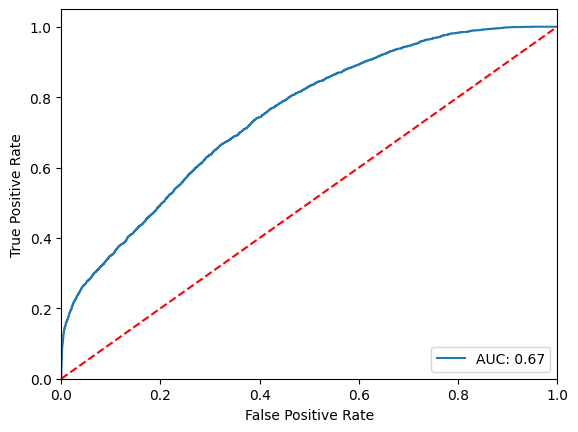

In [79]:
print('train accuracy:',bagging_rf_randomized_search.best_score_, bagging_rf_randomized_search.best_params_, '\n')

y_pred = bagging_rf_randomized_search.predict(X_test)
y_pred_proba = bagging_rf_randomized_search.predict_proba(X_test)
print_performance(y_test, y_pred, y_pred_proba)

## 7. ExtraTrees

### 7.a Simple ExtraTrees

In [45]:
extra_trees = ExtraTreesClassifier()
extra_trees.fit(X_train,y_train)

C:\Users\Felipe\AppData\Local\Temp\ipykernel_17168\636858048.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  extra_trees.fit(X_train,y_train)


ExtraTreesClassifier()

Train accuracy: 1.0
Accuracy: 0.894114
Precision: 0.586703
Recall: 0.923658
F1 score: 0.717594
AUC: 0.906368


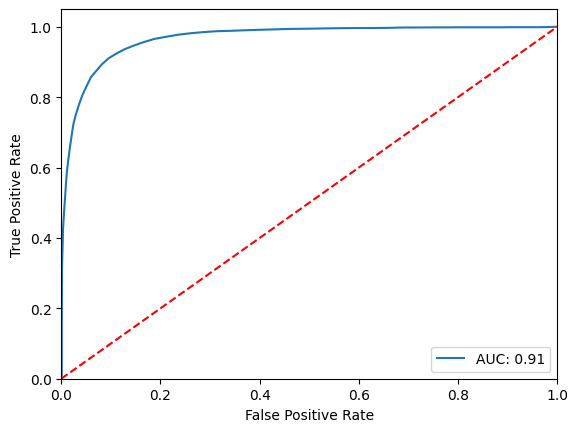

In [46]:
y_pred = extra_trees.predict(X_test)
y_pred_proba = extra_trees.predict_proba(X_test)
print(f'Train accuracy: {round(extra_trees.score(X_train,y_train), 2)}')
print_performance(y_test, y_pred, y_pred_proba)

### 7.b ExtraTrees hyperparameter opt

In [47]:
extra_trees_parameter = {
    'n_estimators': [10, 20, 50, 100, 200, 500, 1000, 1200, 1500, 1800, 1900, 2000, 2100, 3000],
    'criterion': ['gini', 'entropy'],
    'max_depth': [1, 2, 5, 8, 13, 21, 34, 53, 54, 55, 89, None],
    'min_samples_split': [2, 5, 8, 13, 21, 34, 55, 89, 144, 233, 377],
    'min_samples_leaf': [1, 2, 5, 8, 13, 21, 34, 55, 89, 144, 233, 377],
    # 'min_weight_fraction_leaf': [x / 10 for x in range(0, 6)],
    'max_features': ['auto', 'sqrt', 'log2', 2, 5, 8, 13, 21, 34, None],
    'max_leaf_nodes': [2, 5, 8, 13, 21, 34, 55, 89, 144, 233, 377, None],
    'min_impurity_decrease': [x / 100 for x in range(0, 11)],
    'bootstrap': [True, False],
    'oob_score': [True, False],
    'warm_start': [True, False],
    #'class_weight': ['balanced', 'balanced_subsample', None],
    'n_estimators': range(1800, 2100, 10),
    
}

In [48]:
n_iter = 300
cv = 3

extra_trees = ExtraTreesClassifier()

extra_trees_randomized_search = RandomizedSearchCV(estimator=extra_trees, 
                                         param_distributions=extra_trees_parameter, n_iter=n_iter, cv=cv, scoring='accuracy', verbose=2)

extra_trees_randomized_search.fit(X_train, y_train)

Fitting 3 folds for each of 300 candidates, totalling 900 fits


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=False, criterion=gini, max_depth=1, max_features=8, max_leaf_nodes=21, min_impurity_decrease=0.08, min_samples_leaf=8, min_samples_split=8, n_estimators=1920, oob_score=False, warm_start=False; total time=   4.3s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=False, criterion=gini, max_depth=1, max_features=8, max_leaf_nodes=21, min_impurity_decrease=0.08, min_samples_leaf=8, min_samples_split=8, n_estimators=1920, oob_score=False, warm_start=False; total time=   4.4s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=False, criterion=gini, max_depth=1, max_features=8, max_leaf_nodes=21, min_impurity_decrease=0.08, min_samples_leaf=8, min_samples_split=8, n_estimators=1920, oob_score=False, warm_start=False; total time=   4.3s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, criterion=entropy, max_depth=34, max_features=34, max_leaf_nodes=None, min_impurity_decrease=0.0, min_samples_leaf=233, min_samples_split=2, n_estimators=1890, oob_score=True, warm_start=True; total time=  55.6s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, criterion=entropy, max_depth=34, max_features=34, max_leaf_nodes=None, min_impurity_decrease=0.0, min_samples_leaf=233, min_samples_split=2, n_estimators=1890, oob_score=True, warm_start=True; total time=  55.5s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, criterion=entropy, max_depth=34, max_features=34, max_leaf_nodes=None, min_impurity_decrease=0.0, min_samples_leaf=233, min_samples_split=2, n_estimators=1890, oob_score=True, warm_start=True; total time=  55.9s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, criterion=entropy, max_depth=13, max_features=21, max_leaf_nodes=89, min_impurity_decrease=0.05, min_samples_leaf=1, min_samples_split=34, n_estimators=1870, oob_score=True, warm_start=False; total time=  18.1s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, criterion=entropy, max_depth=13, max_features=21, max_leaf_nodes=89, min_impurity_decrease=0.05, min_samples_leaf=1, min_samples_split=34, n_estimators=1870, oob_score=True, warm_start=False; total time=  17.8s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, criterion=entropy, max_depth=13, max_features=21, max_leaf_nodes=89, min_impurity_decrease=0.05, min_samples_leaf=1, min_samples_split=34, n_estimators=1870, oob_score=True, warm_start=False; total time=  17.7s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_forest.py:425: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=True, criterion=entropy, max_depth=13, max_features=auto, max_leaf_nodes=2, min_impurity_decrease=0.03, min_samples_leaf=34, min_samples_split=34, n_estimators=1800, oob_score=False, warm_start=False; total time=   5.9s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_forest.py:425: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=True, criterion=entropy, max_depth=13, max_features=auto, max_leaf_nodes=2, min_impurity_decrease=0.03, min_samples_leaf=34, min_samples_split=34, n_estimators=1800, oob_score=False, warm_start=False; total time=   5.9s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_forest.py:425: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=True, criterion=entropy, max_depth=13, max_features=auto, max_leaf_nodes=2, min_impurity_decrease=0.03, min_samples_leaf=34, min_samples_split=34, n_estimators=1800, oob_score=False, warm_start=False; total time=   5.9s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_forest.py:425: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=True, criterion=entropy, max_depth=13, max_features=auto, max_leaf_nodes=89, min_impurity_decrease=0.08, min_samples_leaf=233, min_samples_split=144, n_estimators=1990, oob_score=False, warm_start=True; total time=   6.5s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_forest.py:425: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=True, criterion=entropy, max_depth=13, max_features=auto, max_leaf_nodes=89, min_impurity_decrease=0.08, min_samples_leaf=233, min_samples_split=144, n_estimators=1990, oob_score=False, warm_start=True; total time=   6.5s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_forest.py:425: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=True, criterion=entropy, max_depth=13, max_features=auto, max_leaf_nodes=89, min_impurity_decrease=0.08, min_samples_leaf=233, min_samples_split=144, n_estimators=1990, oob_score=False, warm_start=True; total time=   6.6s
[CV] END bootstrap=False, criterion=entropy, max_depth=2, max_features=5, max_leaf_nodes=2, min_impurity_decrease=0.04, min_samples_leaf=34, min_samples_split=377, n_estimators=1850, oob_score=True, warm_start=False; total time=   0.0s
[CV] END bootstrap=False, criterion=entropy, max_depth=2, max_features=5, max_leaf_nodes=2, min_impurity_decrease=0.04, min_samples_leaf=34, min_samples_split=377, n_estimators=1850, oob_score=True, warm_start=False; total time=   0.0s
[CV] END bootstrap=False, criterion=entropy, max_depth=2, max_features=5, max_leaf_nodes=2, min_impurity_decrease=0.04, min_samples_leaf=34, min_samples_split=377, n_estimators=1850, oob_score=True, warm_start=False; total time=   0.0s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vec

[CV] END bootstrap=True, criterion=gini, max_depth=21, max_features=5, max_leaf_nodes=89, min_impurity_decrease=0.1, min_samples_leaf=2, min_samples_split=21, n_estimators=2000, oob_score=False, warm_start=True; total time=   4.9s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, criterion=gini, max_depth=21, max_features=5, max_leaf_nodes=89, min_impurity_decrease=0.1, min_samples_leaf=2, min_samples_split=21, n_estimators=2000, oob_score=False, warm_start=True; total time=   4.9s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, criterion=gini, max_depth=21, max_features=5, max_leaf_nodes=89, min_impurity_decrease=0.1, min_samples_leaf=2, min_samples_split=21, n_estimators=2000, oob_score=False, warm_start=True; total time=   4.9s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=False, criterion=gini, max_depth=53, max_features=log2, max_leaf_nodes=55, min_impurity_decrease=0.0, min_samples_leaf=8, min_samples_split=5, n_estimators=1900, oob_score=False, warm_start=True; total time=  20.2s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=False, criterion=gini, max_depth=53, max_features=log2, max_leaf_nodes=55, min_impurity_decrease=0.0, min_samples_leaf=8, min_samples_split=5, n_estimators=1900, oob_score=False, warm_start=True; total time=  19.6s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=False, criterion=gini, max_depth=53, max_features=log2, max_leaf_nodes=55, min_impurity_decrease=0.0, min_samples_leaf=8, min_samples_split=5, n_estimators=1900, oob_score=False, warm_start=True; total time=  19.4s
[CV] END bootstrap=False, criterion=entropy, max_depth=13, max_features=5, max_leaf_nodes=144, min_impurity_decrease=0.08, min_samples_leaf=377, min_samples_split=8, n_estimators=1960, oob_score=True, warm_start=True; total time=   0.0s
[CV] END bootstrap=False, criterion=entropy, max_depth=13, max_features=5, max_leaf_nodes=144, min_impurity_decrease=0.08, min_samples_leaf=377, min_samples_split=8, n_estimators=1960, oob_score=True, warm_start=True; total time=   0.0s
[CV] END bootstrap=False, criterion=entropy, max_depth=13, max_features=5, max_leaf_nodes=144, min_impurity_decrease=0.08, min_samples_leaf=377, min_samples_split=8, n_estimators=1960, oob_score=True, warm_start=True; total time=   0.0s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vec

[CV] END bootstrap=False, criterion=entropy, max_depth=53, max_features=log2, max_leaf_nodes=34, min_impurity_decrease=0.1, min_samples_leaf=377, min_samples_split=13, n_estimators=2020, oob_score=False, warm_start=True; total time=   4.5s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=False, criterion=entropy, max_depth=53, max_features=log2, max_leaf_nodes=34, min_impurity_decrease=0.1, min_samples_leaf=377, min_samples_split=13, n_estimators=2020, oob_score=False, warm_start=True; total time=   4.6s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=False, criterion=entropy, max_depth=53, max_features=log2, max_leaf_nodes=34, min_impurity_decrease=0.1, min_samples_leaf=377, min_samples_split=13, n_estimators=2020, oob_score=False, warm_start=True; total time=   4.7s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_forest.py:425: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=True, criterion=entropy, max_depth=53, max_features=auto, max_leaf_nodes=89, min_impurity_decrease=0.09, min_samples_leaf=2, min_samples_split=13, n_estimators=1960, oob_score=True, warm_start=True; total time=  18.5s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_forest.py:425: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=True, criterion=entropy, max_depth=53, max_features=auto, max_leaf_nodes=89, min_impurity_decrease=0.09, min_samples_leaf=2, min_samples_split=13, n_estimators=1960, oob_score=True, warm_start=True; total time=  18.4s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_forest.py:425: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=True, criterion=entropy, max_depth=53, max_features=auto, max_leaf_nodes=89, min_impurity_decrease=0.09, min_samples_leaf=2, min_samples_split=13, n_estimators=1960, oob_score=True, warm_start=True; total time=  18.5s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=False, criterion=entropy, max_depth=21, max_features=8, max_leaf_nodes=None, min_impurity_decrease=0.02, min_samples_leaf=8, min_samples_split=144, n_estimators=1830, oob_score=False, warm_start=True; total time=   4.1s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=False, criterion=entropy, max_depth=21, max_features=8, max_leaf_nodes=None, min_impurity_decrease=0.02, min_samples_leaf=8, min_samples_split=144, n_estimators=1830, oob_score=False, warm_start=True; total time=   4.2s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=False, criterion=entropy, max_depth=21, max_features=8, max_leaf_nodes=None, min_impurity_decrease=0.02, min_samples_leaf=8, min_samples_split=144, n_estimators=1830, oob_score=False, warm_start=True; total time=   4.2s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=False, criterion=entropy, max_depth=13, max_features=21, max_leaf_nodes=377, min_impurity_decrease=0.06, min_samples_leaf=233, min_samples_split=144, n_estimators=1900, oob_score=False, warm_start=True; total time=   6.3s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=False, criterion=entropy, max_depth=13, max_features=21, max_leaf_nodes=377, min_impurity_decrease=0.06, min_samples_leaf=233, min_samples_split=144, n_estimators=1900, oob_score=False, warm_start=True; total time=   6.2s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=False, criterion=entropy, max_depth=13, max_features=21, max_leaf_nodes=377, min_impurity_decrease=0.06, min_samples_leaf=233, min_samples_split=144, n_estimators=1900, oob_score=False, warm_start=True; total time=   6.3s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, criterion=gini, max_depth=54, max_features=21, max_leaf_nodes=144, min_impurity_decrease=0.0, min_samples_leaf=13, min_samples_split=89, n_estimators=2070, oob_score=True, warm_start=True; total time= 1.2min


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, criterion=gini, max_depth=54, max_features=21, max_leaf_nodes=144, min_impurity_decrease=0.0, min_samples_leaf=13, min_samples_split=89, n_estimators=2070, oob_score=True, warm_start=True; total time= 1.2min


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, criterion=gini, max_depth=54, max_features=21, max_leaf_nodes=144, min_impurity_decrease=0.0, min_samples_leaf=13, min_samples_split=89, n_estimators=2070, oob_score=True, warm_start=True; total time= 1.2min


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=False, criterion=entropy, max_depth=1, max_features=5, max_leaf_nodes=21, min_impurity_decrease=0.07, min_samples_leaf=5, min_samples_split=55, n_estimators=2030, oob_score=False, warm_start=False; total time=   4.1s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=False, criterion=entropy, max_depth=1, max_features=5, max_leaf_nodes=21, min_impurity_decrease=0.07, min_samples_leaf=5, min_samples_split=55, n_estimators=2030, oob_score=False, warm_start=False; total time=   4.1s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=False, criterion=entropy, max_depth=1, max_features=5, max_leaf_nodes=21, min_impurity_decrease=0.07, min_samples_leaf=5, min_samples_split=55, n_estimators=2030, oob_score=False, warm_start=False; total time=   4.3s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, criterion=gini, max_depth=53, max_features=sqrt, max_leaf_nodes=2, min_impurity_decrease=0.09, min_samples_leaf=1, min_samples_split=8, n_estimators=1880, oob_score=True, warm_start=False; total time=  17.6s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, criterion=gini, max_depth=53, max_features=sqrt, max_leaf_nodes=2, min_impurity_decrease=0.09, min_samples_leaf=1, min_samples_split=8, n_estimators=1880, oob_score=True, warm_start=False; total time=  17.5s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, criterion=gini, max_depth=53, max_features=sqrt, max_leaf_nodes=2, min_impurity_decrease=0.09, min_samples_leaf=1, min_samples_split=8, n_estimators=1880, oob_score=True, warm_start=False; total time=  17.5s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, criterion=gini, max_depth=None, max_features=34, max_leaf_nodes=89, min_impurity_decrease=0.08, min_samples_leaf=55, min_samples_split=21, n_estimators=2040, oob_score=False, warm_start=True; total time=   8.2s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, criterion=gini, max_depth=None, max_features=34, max_leaf_nodes=89, min_impurity_decrease=0.08, min_samples_leaf=55, min_samples_split=21, n_estimators=2040, oob_score=False, warm_start=True; total time=   8.3s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, criterion=gini, max_depth=None, max_features=34, max_leaf_nodes=89, min_impurity_decrease=0.08, min_samples_leaf=55, min_samples_split=21, n_estimators=2040, oob_score=False, warm_start=True; total time=   8.2s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, criterion=entropy, max_depth=21, max_features=21, max_leaf_nodes=8, min_impurity_decrease=0.05, min_samples_leaf=34, min_samples_split=21, n_estimators=1920, oob_score=True, warm_start=False; total time=  18.0s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, criterion=entropy, max_depth=21, max_features=21, max_leaf_nodes=8, min_impurity_decrease=0.05, min_samples_leaf=34, min_samples_split=21, n_estimators=1920, oob_score=True, warm_start=False; total time=  18.1s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, criterion=entropy, max_depth=21, max_features=21, max_leaf_nodes=8, min_impurity_decrease=0.05, min_samples_leaf=34, min_samples_split=21, n_estimators=1920, oob_score=True, warm_start=False; total time=  18.1s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, criterion=entropy, max_depth=None, max_features=None, max_leaf_nodes=13, min_impurity_decrease=0.05, min_samples_leaf=34, min_samples_split=55, n_estimators=1950, oob_score=True, warm_start=False; total time= 1.0min


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, criterion=entropy, max_depth=None, max_features=None, max_leaf_nodes=13, min_impurity_decrease=0.05, min_samples_leaf=34, min_samples_split=55, n_estimators=1950, oob_score=True, warm_start=False; total time= 1.0min


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, criterion=entropy, max_depth=None, max_features=None, max_leaf_nodes=13, min_impurity_decrease=0.05, min_samples_leaf=34, min_samples_split=55, n_estimators=1950, oob_score=True, warm_start=False; total time= 1.0min


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, criterion=gini, max_depth=1, max_features=2, max_leaf_nodes=55, min_impurity_decrease=0.09, min_samples_leaf=233, min_samples_split=89, n_estimators=1970, oob_score=False, warm_start=False; total time=   4.5s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, criterion=gini, max_depth=1, max_features=2, max_leaf_nodes=55, min_impurity_decrease=0.09, min_samples_leaf=233, min_samples_split=89, n_estimators=1970, oob_score=False, warm_start=False; total time=   4.4s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, criterion=gini, max_depth=1, max_features=2, max_leaf_nodes=55, min_impurity_decrease=0.09, min_samples_leaf=233, min_samples_split=89, n_estimators=1970, oob_score=False, warm_start=False; total time=   4.5s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, criterion=entropy, max_depth=8, max_features=2, max_leaf_nodes=13, min_impurity_decrease=0.03, min_samples_leaf=144, min_samples_split=2, n_estimators=2040, oob_score=False, warm_start=False; total time=   4.7s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, criterion=entropy, max_depth=8, max_features=2, max_leaf_nodes=13, min_impurity_decrease=0.03, min_samples_leaf=144, min_samples_split=2, n_estimators=2040, oob_score=False, warm_start=False; total time=   4.6s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, criterion=entropy, max_depth=8, max_features=2, max_leaf_nodes=13, min_impurity_decrease=0.03, min_samples_leaf=144, min_samples_split=2, n_estimators=2040, oob_score=False, warm_start=False; total time=   4.6s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, criterion=entropy, max_depth=8, max_features=None, max_leaf_nodes=233, min_impurity_decrease=0.0, min_samples_leaf=2, min_samples_split=144, n_estimators=2020, oob_score=True, warm_start=False; total time= 9.1min


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, criterion=entropy, max_depth=8, max_features=None, max_leaf_nodes=233, min_impurity_decrease=0.0, min_samples_leaf=2, min_samples_split=144, n_estimators=2020, oob_score=True, warm_start=False; total time= 9.2min


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, criterion=entropy, max_depth=8, max_features=None, max_leaf_nodes=233, min_impurity_decrease=0.0, min_samples_leaf=2, min_samples_split=144, n_estimators=2020, oob_score=True, warm_start=False; total time= 9.2min


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, criterion=gini, max_depth=89, max_features=None, max_leaf_nodes=None, min_impurity_decrease=0.0, min_samples_leaf=377, min_samples_split=5, n_estimators=1880, oob_score=False, warm_start=False; total time= 5.7min


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, criterion=gini, max_depth=89, max_features=None, max_leaf_nodes=None, min_impurity_decrease=0.0, min_samples_leaf=377, min_samples_split=5, n_estimators=1880, oob_score=False, warm_start=False; total time= 5.6min


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, criterion=gini, max_depth=89, max_features=None, max_leaf_nodes=None, min_impurity_decrease=0.0, min_samples_leaf=377, min_samples_split=5, n_estimators=1880, oob_score=False, warm_start=False; total time= 5.7min


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, criterion=entropy, max_depth=21, max_features=34, max_leaf_nodes=34, min_impurity_decrease=0.08, min_samples_leaf=55, min_samples_split=144, n_estimators=1870, oob_score=True, warm_start=False; total time=  18.9s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, criterion=entropy, max_depth=21, max_features=34, max_leaf_nodes=34, min_impurity_decrease=0.08, min_samples_leaf=55, min_samples_split=144, n_estimators=1870, oob_score=True, warm_start=False; total time=  18.7s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, criterion=entropy, max_depth=21, max_features=34, max_leaf_nodes=34, min_impurity_decrease=0.08, min_samples_leaf=55, min_samples_split=144, n_estimators=1870, oob_score=True, warm_start=False; total time=  18.8s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, criterion=gini, max_depth=54, max_features=log2, max_leaf_nodes=2, min_impurity_decrease=0.04, min_samples_leaf=2, min_samples_split=144, n_estimators=2030, oob_score=True, warm_start=False; total time=  17.7s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, criterion=gini, max_depth=54, max_features=log2, max_leaf_nodes=2, min_impurity_decrease=0.04, min_samples_leaf=2, min_samples_split=144, n_estimators=2030, oob_score=True, warm_start=False; total time=  17.6s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, criterion=gini, max_depth=54, max_features=log2, max_leaf_nodes=2, min_impurity_decrease=0.04, min_samples_leaf=2, min_samples_split=144, n_estimators=2030, oob_score=True, warm_start=False; total time=  17.4s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, criterion=entropy, max_depth=None, max_features=sqrt, max_leaf_nodes=8, min_impurity_decrease=0.07, min_samples_leaf=233, min_samples_split=8, n_estimators=1930, oob_score=False, warm_start=False; total time=   6.3s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, criterion=entropy, max_depth=None, max_features=sqrt, max_leaf_nodes=8, min_impurity_decrease=0.07, min_samples_leaf=233, min_samples_split=8, n_estimators=1930, oob_score=False, warm_start=False; total time=   6.3s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, criterion=entropy, max_depth=None, max_features=sqrt, max_leaf_nodes=8, min_impurity_decrease=0.07, min_samples_leaf=233, min_samples_split=8, n_estimators=1930, oob_score=False, warm_start=False; total time=   6.4s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, criterion=gini, max_depth=89, max_features=21, max_leaf_nodes=55, min_impurity_decrease=0.09, min_samples_leaf=34, min_samples_split=89, n_estimators=2080, oob_score=False, warm_start=True; total time=   6.9s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, criterion=gini, max_depth=89, max_features=21, max_leaf_nodes=55, min_impurity_decrease=0.09, min_samples_leaf=34, min_samples_split=89, n_estimators=2080, oob_score=False, warm_start=True; total time=   6.9s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, criterion=gini, max_depth=89, max_features=21, max_leaf_nodes=55, min_impurity_decrease=0.09, min_samples_leaf=34, min_samples_split=89, n_estimators=2080, oob_score=False, warm_start=True; total time=   6.9s
[CV] END bootstrap=False, criterion=gini, max_depth=5, max_features=34, max_leaf_nodes=55, min_impurity_decrease=0.03, min_samples_leaf=34, min_samples_split=8, n_estimators=1930, oob_score=True, warm_start=False; total time=   0.0s
[CV] END bootstrap=False, criterion=gini, max_depth=5, max_features=34, max_leaf_nodes=55, min_impurity_decrease=0.03, min_samples_leaf=34, min_samples_split=8, n_estimators=1930, oob_score=True, warm_start=False; total time=   0.0s
[CV] END bootstrap=False, criterion=gini, max_depth=5, max_features=34, max_leaf_nodes=55, min_impurity_decrease=0.03, min_samples_leaf=34, min_samples_split=8, n_estimators=1930, oob_score=True, warm_start=False; total time=   0.0s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vec

[CV] END bootstrap=True, criterion=entropy, max_depth=54, max_features=5, max_leaf_nodes=144, min_impurity_decrease=0.0, min_samples_leaf=1, min_samples_split=13, n_estimators=2080, oob_score=False, warm_start=False; total time=  15.3s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, criterion=entropy, max_depth=54, max_features=5, max_leaf_nodes=144, min_impurity_decrease=0.0, min_samples_leaf=1, min_samples_split=13, n_estimators=2080, oob_score=False, warm_start=False; total time=  15.3s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, criterion=entropy, max_depth=54, max_features=5, max_leaf_nodes=144, min_impurity_decrease=0.0, min_samples_leaf=1, min_samples_split=13, n_estimators=2080, oob_score=False, warm_start=False; total time=  15.6s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=False, criterion=entropy, max_depth=8, max_features=2, max_leaf_nodes=21, min_impurity_decrease=0.06, min_samples_leaf=55, min_samples_split=233, n_estimators=1920, oob_score=False, warm_start=False; total time=   3.4s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=False, criterion=entropy, max_depth=8, max_features=2, max_leaf_nodes=21, min_impurity_decrease=0.06, min_samples_leaf=55, min_samples_split=233, n_estimators=1920, oob_score=False, warm_start=False; total time=   3.4s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=False, criterion=entropy, max_depth=8, max_features=2, max_leaf_nodes=21, min_impurity_decrease=0.06, min_samples_leaf=55, min_samples_split=233, n_estimators=1920, oob_score=False, warm_start=False; total time=   3.4s
[CV] END bootstrap=False, criterion=gini, max_depth=54, max_features=sqrt, max_leaf_nodes=233, min_impurity_decrease=0.08, min_samples_leaf=8, min_samples_split=21, n_estimators=1960, oob_score=True, warm_start=False; total time=   0.0s
[CV] END bootstrap=False, criterion=gini, max_depth=54, max_features=sqrt, max_leaf_nodes=233, min_impurity_decrease=0.08, min_samples_leaf=8, min_samples_split=21, n_estimators=1960, oob_score=True, warm_start=False; total time=   0.0s
[CV] END bootstrap=False, criterion=gini, max_depth=54, max_features=sqrt, max_leaf_nodes=233, min_impurity_decrease=0.08, min_samples_leaf=8, min_samples_split=21, n_estimators=1960, oob_score=True, warm_start=False; total time=   0.0s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vec

[CV] END bootstrap=True, criterion=gini, max_depth=54, max_features=13, max_leaf_nodes=5, min_impurity_decrease=0.09, min_samples_leaf=144, min_samples_split=34, n_estimators=1930, oob_score=True, warm_start=True; total time=  17.0s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, criterion=gini, max_depth=54, max_features=13, max_leaf_nodes=5, min_impurity_decrease=0.09, min_samples_leaf=144, min_samples_split=34, n_estimators=1930, oob_score=True, warm_start=True; total time=  17.0s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, criterion=gini, max_depth=54, max_features=13, max_leaf_nodes=5, min_impurity_decrease=0.09, min_samples_leaf=144, min_samples_split=34, n_estimators=1930, oob_score=True, warm_start=True; total time=  17.2s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=False, criterion=entropy, max_depth=2, max_features=8, max_leaf_nodes=233, min_impurity_decrease=0.09, min_samples_leaf=8, min_samples_split=89, n_estimators=2010, oob_score=False, warm_start=True; total time=   4.5s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=False, criterion=entropy, max_depth=2, max_features=8, max_leaf_nodes=233, min_impurity_decrease=0.09, min_samples_leaf=8, min_samples_split=89, n_estimators=2010, oob_score=False, warm_start=True; total time=   4.5s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=False, criterion=entropy, max_depth=2, max_features=8, max_leaf_nodes=233, min_impurity_decrease=0.09, min_samples_leaf=8, min_samples_split=89, n_estimators=2010, oob_score=False, warm_start=True; total time=   4.5s
[CV] END bootstrap=False, criterion=gini, max_depth=8, max_features=auto, max_leaf_nodes=8, min_impurity_decrease=0.06, min_samples_leaf=89, min_samples_split=21, n_estimators=1970, oob_score=True, warm_start=False; total time=   0.0s
[CV] END bootstrap=False, criterion=gini, max_depth=8, max_features=auto, max_leaf_nodes=8, min_impurity_decrease=0.06, min_samples_leaf=89, min_samples_split=21, n_estimators=1970, oob_score=True, warm_start=False; total time=   0.0s
[CV] END bootstrap=False, criterion=gini, max_depth=8, max_features=auto, max_leaf_nodes=8, min_impurity_decrease=0.06, min_samples_leaf=89, min_samples_split=21, n_estimators=1970, oob_score=True, warm_start=False; total time=   0.0s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_forest.py:425: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble

[CV] END bootstrap=False, criterion=entropy, max_depth=8, max_features=2, max_leaf_nodes=55, min_impurity_decrease=0.05, min_samples_leaf=144, min_samples_split=89, n_estimators=1850, oob_score=False, warm_start=False; total time=   3.3s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=False, criterion=entropy, max_depth=8, max_features=2, max_leaf_nodes=55, min_impurity_decrease=0.05, min_samples_leaf=144, min_samples_split=89, n_estimators=1850, oob_score=False, warm_start=False; total time=   3.3s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=False, criterion=entropy, max_depth=8, max_features=2, max_leaf_nodes=55, min_impurity_decrease=0.05, min_samples_leaf=144, min_samples_split=89, n_estimators=1850, oob_score=False, warm_start=False; total time=   3.3s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=False, criterion=gini, max_depth=2, max_features=sqrt, max_leaf_nodes=None, min_impurity_decrease=0.06, min_samples_leaf=377, min_samples_split=2, n_estimators=2040, oob_score=False, warm_start=True; total time=   6.5s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=False, criterion=gini, max_depth=2, max_features=sqrt, max_leaf_nodes=None, min_impurity_decrease=0.06, min_samples_leaf=377, min_samples_split=2, n_estimators=2040, oob_score=False, warm_start=True; total time=   6.5s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=False, criterion=gini, max_depth=2, max_features=sqrt, max_leaf_nodes=None, min_impurity_decrease=0.06, min_samples_leaf=377, min_samples_split=2, n_estimators=2040, oob_score=False, warm_start=True; total time=   6.5s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, criterion=entropy, max_depth=34, max_features=5, max_leaf_nodes=8, min_impurity_decrease=0.07, min_samples_leaf=5, min_samples_split=89, n_estimators=1950, oob_score=False, warm_start=False; total time=   4.7s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, criterion=entropy, max_depth=34, max_features=5, max_leaf_nodes=8, min_impurity_decrease=0.07, min_samples_leaf=5, min_samples_split=89, n_estimators=1950, oob_score=False, warm_start=False; total time=   4.7s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, criterion=entropy, max_depth=34, max_features=5, max_leaf_nodes=8, min_impurity_decrease=0.07, min_samples_leaf=5, min_samples_split=89, n_estimators=1950, oob_score=False, warm_start=False; total time=   4.8s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_forest.py:425: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=True, criterion=entropy, max_depth=54, max_features=auto, max_leaf_nodes=55, min_impurity_decrease=0.0, min_samples_leaf=8, min_samples_split=233, n_estimators=2030, oob_score=False, warm_start=True; total time=  40.4s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_forest.py:425: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=True, criterion=entropy, max_depth=54, max_features=auto, max_leaf_nodes=55, min_impurity_decrease=0.0, min_samples_leaf=8, min_samples_split=233, n_estimators=2030, oob_score=False, warm_start=True; total time=  40.3s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_forest.py:425: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=True, criterion=entropy, max_depth=54, max_features=auto, max_leaf_nodes=55, min_impurity_decrease=0.0, min_samples_leaf=8, min_samples_split=233, n_estimators=2030, oob_score=False, warm_start=True; total time=  39.8s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, criterion=gini, max_depth=5, max_features=2, max_leaf_nodes=233, min_impurity_decrease=0.07, min_samples_leaf=34, min_samples_split=377, n_estimators=1960, oob_score=True, warm_start=False; total time=  16.6s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, criterion=gini, max_depth=5, max_features=2, max_leaf_nodes=233, min_impurity_decrease=0.07, min_samples_leaf=34, min_samples_split=377, n_estimators=1960, oob_score=True, warm_start=False; total time=  16.4s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, criterion=gini, max_depth=5, max_features=2, max_leaf_nodes=233, min_impurity_decrease=0.07, min_samples_leaf=34, min_samples_split=377, n_estimators=1960, oob_score=True, warm_start=False; total time=  16.3s
[CV] END bootstrap=False, criterion=gini, max_depth=13, max_features=13, max_leaf_nodes=2, min_impurity_decrease=0.08, min_samples_leaf=34, min_samples_split=144, n_estimators=1800, oob_score=True, warm_start=True; total time=   0.0s
[CV] END bootstrap=False, criterion=gini, max_depth=13, max_features=13, max_leaf_nodes=2, min_impurity_decrease=0.08, min_samples_leaf=34, min_samples_split=144, n_estimators=1800, oob_score=True, warm_start=True; total time=   0.0s
[CV] END bootstrap=False, criterion=gini, max_depth=13, max_features=13, max_leaf_nodes=2, min_impurity_decrease=0.08, min_samples_leaf=34, min_samples_split=144, n_estimators=1800, oob_score=True, warm_start=True; total time=   0.0s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vec

[CV] END bootstrap=True, criterion=gini, max_depth=2, max_features=log2, max_leaf_nodes=2, min_impurity_decrease=0.0, min_samples_leaf=34, min_samples_split=89, n_estimators=2060, oob_score=True, warm_start=True; total time=  19.3s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, criterion=gini, max_depth=2, max_features=log2, max_leaf_nodes=2, min_impurity_decrease=0.0, min_samples_leaf=34, min_samples_split=89, n_estimators=2060, oob_score=True, warm_start=True; total time=  19.3s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, criterion=gini, max_depth=2, max_features=log2, max_leaf_nodes=2, min_impurity_decrease=0.0, min_samples_leaf=34, min_samples_split=89, n_estimators=2060, oob_score=True, warm_start=True; total time=  19.5s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, criterion=gini, max_depth=5, max_features=log2, max_leaf_nodes=21, min_impurity_decrease=0.08, min_samples_leaf=55, min_samples_split=144, n_estimators=1970, oob_score=True, warm_start=False; total time=  17.1s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, criterion=gini, max_depth=5, max_features=log2, max_leaf_nodes=21, min_impurity_decrease=0.08, min_samples_leaf=55, min_samples_split=144, n_estimators=1970, oob_score=True, warm_start=False; total time=  17.3s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, criterion=gini, max_depth=5, max_features=log2, max_leaf_nodes=21, min_impurity_decrease=0.08, min_samples_leaf=55, min_samples_split=144, n_estimators=1970, oob_score=True, warm_start=False; total time=  17.2s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=False, criterion=gini, max_depth=2, max_features=sqrt, max_leaf_nodes=377, min_impurity_decrease=0.01, min_samples_leaf=1, min_samples_split=144, n_estimators=2050, oob_score=False, warm_start=False; total time=   6.6s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=False, criterion=gini, max_depth=2, max_features=sqrt, max_leaf_nodes=377, min_impurity_decrease=0.01, min_samples_leaf=1, min_samples_split=144, n_estimators=2050, oob_score=False, warm_start=False; total time=   6.6s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=False, criterion=gini, max_depth=2, max_features=sqrt, max_leaf_nodes=377, min_impurity_decrease=0.01, min_samples_leaf=1, min_samples_split=144, n_estimators=2050, oob_score=False, warm_start=False; total time=   6.6s
[CV] END bootstrap=False, criterion=gini, max_depth=1, max_features=2, max_leaf_nodes=2, min_impurity_decrease=0.0, min_samples_leaf=89, min_samples_split=5, n_estimators=1990, oob_score=True, warm_start=True; total time=   0.0s
[CV] END bootstrap=False, criterion=gini, max_depth=1, max_features=2, max_leaf_nodes=2, min_impurity_decrease=0.0, min_samples_leaf=89, min_samples_split=5, n_estimators=1990, oob_score=True, warm_start=True; total time=   0.0s
[CV] END bootstrap=False, criterion=gini, max_depth=1, max_features=2, max_leaf_nodes=2, min_impurity_decrease=0.0, min_samples_leaf=89, min_samples_split=5, n_estimators=1990, oob_score=True, warm_start=True; total time=   0.0s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vec

[CV] END bootstrap=True, criterion=entropy, max_depth=None, max_features=21, max_leaf_nodes=89, min_impurity_decrease=0.04, min_samples_leaf=1, min_samples_split=55, n_estimators=1830, oob_score=False, warm_start=False; total time=   6.1s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, criterion=entropy, max_depth=None, max_features=21, max_leaf_nodes=89, min_impurity_decrease=0.04, min_samples_leaf=1, min_samples_split=55, n_estimators=1830, oob_score=False, warm_start=False; total time=   6.1s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, criterion=entropy, max_depth=None, max_features=21, max_leaf_nodes=89, min_impurity_decrease=0.04, min_samples_leaf=1, min_samples_split=55, n_estimators=1830, oob_score=False, warm_start=False; total time=   6.1s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=False, criterion=entropy, max_depth=13, max_features=5, max_leaf_nodes=34, min_impurity_decrease=0.08, min_samples_leaf=233, min_samples_split=13, n_estimators=1950, oob_score=False, warm_start=False; total time=   4.0s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=False, criterion=entropy, max_depth=13, max_features=5, max_leaf_nodes=34, min_impurity_decrease=0.08, min_samples_leaf=233, min_samples_split=13, n_estimators=1950, oob_score=False, warm_start=False; total time=   4.0s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=False, criterion=entropy, max_depth=13, max_features=5, max_leaf_nodes=34, min_impurity_decrease=0.08, min_samples_leaf=233, min_samples_split=13, n_estimators=1950, oob_score=False, warm_start=False; total time=   4.0s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, criterion=entropy, max_depth=54, max_features=sqrt, max_leaf_nodes=144, min_impurity_decrease=0.01, min_samples_leaf=13, min_samples_split=34, n_estimators=2060, oob_score=True, warm_start=False; total time=  19.3s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, criterion=entropy, max_depth=54, max_features=sqrt, max_leaf_nodes=144, min_impurity_decrease=0.01, min_samples_leaf=13, min_samples_split=34, n_estimators=2060, oob_score=True, warm_start=False; total time=  19.2s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, criterion=entropy, max_depth=54, max_features=sqrt, max_leaf_nodes=144, min_impurity_decrease=0.01, min_samples_leaf=13, min_samples_split=34, n_estimators=2060, oob_score=True, warm_start=False; total time=  19.2s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_forest.py:425: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=False, criterion=entropy, max_depth=5, max_features=auto, max_leaf_nodes=13, min_impurity_decrease=0.1, min_samples_leaf=2, min_samples_split=8, n_estimators=1910, oob_score=False, warm_start=True; total time=   6.5s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_forest.py:425: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=False, criterion=entropy, max_depth=5, max_features=auto, max_leaf_nodes=13, min_impurity_decrease=0.1, min_samples_leaf=2, min_samples_split=8, n_estimators=1910, oob_score=False, warm_start=True; total time=   6.2s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_forest.py:425: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=False, criterion=entropy, max_depth=5, max_features=auto, max_leaf_nodes=13, min_impurity_decrease=0.1, min_samples_leaf=2, min_samples_split=8, n_estimators=1910, oob_score=False, warm_start=True; total time=   6.3s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, criterion=entropy, max_depth=54, max_features=log2, max_leaf_nodes=8, min_impurity_decrease=0.05, min_samples_leaf=5, min_samples_split=13, n_estimators=1870, oob_score=True, warm_start=False; total time=  16.2s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, criterion=entropy, max_depth=54, max_features=log2, max_leaf_nodes=8, min_impurity_decrease=0.05, min_samples_leaf=5, min_samples_split=13, n_estimators=1870, oob_score=True, warm_start=False; total time=  16.1s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, criterion=entropy, max_depth=54, max_features=log2, max_leaf_nodes=8, min_impurity_decrease=0.05, min_samples_leaf=5, min_samples_split=13, n_estimators=1870, oob_score=True, warm_start=False; total time=  16.1s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, criterion=entropy, max_depth=1, max_features=8, max_leaf_nodes=89, min_impurity_decrease=0.03, min_samples_leaf=21, min_samples_split=233, n_estimators=1810, oob_score=True, warm_start=True; total time=  15.8s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, criterion=entropy, max_depth=1, max_features=8, max_leaf_nodes=89, min_impurity_decrease=0.03, min_samples_leaf=21, min_samples_split=233, n_estimators=1810, oob_score=True, warm_start=True; total time=  15.7s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, criterion=entropy, max_depth=1, max_features=8, max_leaf_nodes=89, min_impurity_decrease=0.03, min_samples_leaf=21, min_samples_split=233, n_estimators=1810, oob_score=True, warm_start=True; total time=  15.6s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_forest.py:425: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=True, criterion=entropy, max_depth=None, max_features=auto, max_leaf_nodes=233, min_impurity_decrease=0.06, min_samples_leaf=233, min_samples_split=34, n_estimators=2090, oob_score=True, warm_start=True; total time=  19.4s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_forest.py:425: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=True, criterion=entropy, max_depth=None, max_features=auto, max_leaf_nodes=233, min_impurity_decrease=0.06, min_samples_leaf=233, min_samples_split=34, n_estimators=2090, oob_score=True, warm_start=True; total time=  19.6s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_forest.py:425: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=True, criterion=entropy, max_depth=None, max_features=auto, max_leaf_nodes=233, min_impurity_decrease=0.06, min_samples_leaf=233, min_samples_split=34, n_estimators=2090, oob_score=True, warm_start=True; total time=  19.5s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=False, criterion=entropy, max_depth=13, max_features=21, max_leaf_nodes=233, min_impurity_decrease=0.08, min_samples_leaf=1, min_samples_split=34, n_estimators=2010, oob_score=False, warm_start=False; total time=   6.6s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=False, criterion=entropy, max_depth=13, max_features=21, max_leaf_nodes=233, min_impurity_decrease=0.08, min_samples_leaf=1, min_samples_split=34, n_estimators=2010, oob_score=False, warm_start=False; total time=   6.6s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=False, criterion=entropy, max_depth=13, max_features=21, max_leaf_nodes=233, min_impurity_decrease=0.08, min_samples_leaf=1, min_samples_split=34, n_estimators=2010, oob_score=False, warm_start=False; total time=   6.6s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, criterion=gini, max_depth=13, max_features=21, max_leaf_nodes=2, min_impurity_decrease=0.07, min_samples_leaf=8, min_samples_split=89, n_estimators=2020, oob_score=False, warm_start=False; total time=   6.8s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, criterion=gini, max_depth=13, max_features=21, max_leaf_nodes=2, min_impurity_decrease=0.07, min_samples_leaf=8, min_samples_split=89, n_estimators=2020, oob_score=False, warm_start=False; total time=   6.8s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, criterion=gini, max_depth=13, max_features=21, max_leaf_nodes=2, min_impurity_decrease=0.07, min_samples_leaf=8, min_samples_split=89, n_estimators=2020, oob_score=False, warm_start=False; total time=   6.8s
[CV] END bootstrap=False, criterion=gini, max_depth=8, max_features=8, max_leaf_nodes=2, min_impurity_decrease=0.03, min_samples_leaf=21, min_samples_split=377, n_estimators=2090, oob_score=True, warm_start=False; total time=   0.0s
[CV] END bootstrap=False, criterion=gini, max_depth=8, max_features=8, max_leaf_nodes=2, min_impurity_decrease=0.03, min_samples_leaf=21, min_samples_split=377, n_estimators=2090, oob_score=True, warm_start=False; total time=   0.0s
[CV] END bootstrap=False, criterion=gini, max_depth=8, max_features=8, max_leaf_nodes=2, min_impurity_decrease=0.03, min_samples_leaf=21, min_samples_split=377, n_estimators=2090, oob_score=True, warm_start=False; total time=   0.0s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vec

[CV] END bootstrap=True, criterion=entropy, max_depth=53, max_features=2, max_leaf_nodes=None, min_impurity_decrease=0.07, min_samples_leaf=34, min_samples_split=233, n_estimators=1860, oob_score=False, warm_start=True; total time=   4.4s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, criterion=entropy, max_depth=53, max_features=2, max_leaf_nodes=None, min_impurity_decrease=0.07, min_samples_leaf=34, min_samples_split=233, n_estimators=1860, oob_score=False, warm_start=True; total time=   4.3s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, criterion=entropy, max_depth=53, max_features=2, max_leaf_nodes=None, min_impurity_decrease=0.07, min_samples_leaf=34, min_samples_split=233, n_estimators=1860, oob_score=False, warm_start=True; total time=   4.3s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=False, criterion=entropy, max_depth=55, max_features=5, max_leaf_nodes=2, min_impurity_decrease=0.08, min_samples_leaf=55, min_samples_split=13, n_estimators=1870, oob_score=False, warm_start=False; total time=   3.8s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=False, criterion=entropy, max_depth=55, max_features=5, max_leaf_nodes=2, min_impurity_decrease=0.08, min_samples_leaf=55, min_samples_split=13, n_estimators=1870, oob_score=False, warm_start=False; total time=   3.8s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=False, criterion=entropy, max_depth=55, max_features=5, max_leaf_nodes=2, min_impurity_decrease=0.08, min_samples_leaf=55, min_samples_split=13, n_estimators=1870, oob_score=False, warm_start=False; total time=   4.0s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, criterion=entropy, max_depth=None, max_features=13, max_leaf_nodes=None, min_impurity_decrease=0.0, min_samples_leaf=34, min_samples_split=34, n_estimators=1910, oob_score=True, warm_start=False; total time=  52.2s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, criterion=entropy, max_depth=None, max_features=13, max_leaf_nodes=None, min_impurity_decrease=0.0, min_samples_leaf=34, min_samples_split=34, n_estimators=1910, oob_score=True, warm_start=False; total time=  51.8s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, criterion=entropy, max_depth=None, max_features=13, max_leaf_nodes=None, min_impurity_decrease=0.0, min_samples_leaf=34, min_samples_split=34, n_estimators=1910, oob_score=True, warm_start=False; total time=  51.8s
[CV] END bootstrap=False, criterion=entropy, max_depth=34, max_features=8, max_leaf_nodes=13, min_impurity_decrease=0.02, min_samples_leaf=144, min_samples_split=2, n_estimators=1880, oob_score=True, warm_start=False; total time=   0.0s
[CV] END bootstrap=False, criterion=entropy, max_depth=34, max_features=8, max_leaf_nodes=13, min_impurity_decrease=0.02, min_samples_leaf=144, min_samples_split=2, n_estimators=1880, oob_score=True, warm_start=False; total time=   0.0s
[CV] END bootstrap=False, criterion=entropy, max_depth=34, max_features=8, max_leaf_nodes=13, min_impurity_decrease=0.02, min_samples_leaf=144, min_samples_split=2, n_estimators=1880, oob_score=True, warm_start=False; total time=   0.0s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vec

[CV] END bootstrap=True, criterion=entropy, max_depth=1, max_features=auto, max_leaf_nodes=21, min_impurity_decrease=0.1, min_samples_leaf=5, min_samples_split=8, n_estimators=1840, oob_score=True, warm_start=False; total time=  17.2s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_forest.py:425: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=True, criterion=entropy, max_depth=1, max_features=auto, max_leaf_nodes=21, min_impurity_decrease=0.1, min_samples_leaf=5, min_samples_split=8, n_estimators=1840, oob_score=True, warm_start=False; total time=  17.2s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_forest.py:425: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=True, criterion=entropy, max_depth=1, max_features=auto, max_leaf_nodes=21, min_impurity_decrease=0.1, min_samples_leaf=5, min_samples_split=8, n_estimators=1840, oob_score=True, warm_start=False; total time=  17.1s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, criterion=gini, max_depth=55, max_features=5, max_leaf_nodes=None, min_impurity_decrease=0.01, min_samples_leaf=21, min_samples_split=89, n_estimators=2080, oob_score=False, warm_start=False; total time=   5.1s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, criterion=gini, max_depth=55, max_features=5, max_leaf_nodes=None, min_impurity_decrease=0.01, min_samples_leaf=21, min_samples_split=89, n_estimators=2080, oob_score=False, warm_start=False; total time=   5.1s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, criterion=gini, max_depth=55, max_features=5, max_leaf_nodes=None, min_impurity_decrease=0.01, min_samples_leaf=21, min_samples_split=89, n_estimators=2080, oob_score=False, warm_start=False; total time=   5.1s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=False, criterion=entropy, max_depth=89, max_features=21, max_leaf_nodes=2, min_impurity_decrease=0.05, min_samples_leaf=8, min_samples_split=13, n_estimators=1860, oob_score=False, warm_start=False; total time=   6.2s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=False, criterion=entropy, max_depth=89, max_features=21, max_leaf_nodes=2, min_impurity_decrease=0.05, min_samples_leaf=8, min_samples_split=13, n_estimators=1860, oob_score=False, warm_start=False; total time=   6.2s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=False, criterion=entropy, max_depth=89, max_features=21, max_leaf_nodes=2, min_impurity_decrease=0.05, min_samples_leaf=8, min_samples_split=13, n_estimators=1860, oob_score=False, warm_start=False; total time=   6.2s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, criterion=gini, max_depth=8, max_features=None, max_leaf_nodes=13, min_impurity_decrease=0.02, min_samples_leaf=233, min_samples_split=5, n_estimators=2020, oob_score=True, warm_start=True; total time= 1.0min


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, criterion=gini, max_depth=8, max_features=None, max_leaf_nodes=13, min_impurity_decrease=0.02, min_samples_leaf=233, min_samples_split=5, n_estimators=2020, oob_score=True, warm_start=True; total time= 1.0min


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, criterion=gini, max_depth=8, max_features=None, max_leaf_nodes=13, min_impurity_decrease=0.02, min_samples_leaf=233, min_samples_split=5, n_estimators=2020, oob_score=True, warm_start=True; total time= 1.0min


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=False, criterion=gini, max_depth=None, max_features=13, max_leaf_nodes=34, min_impurity_decrease=0.07, min_samples_leaf=21, min_samples_split=55, n_estimators=2070, oob_score=False, warm_start=False; total time=   5.5s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=False, criterion=gini, max_depth=None, max_features=13, max_leaf_nodes=34, min_impurity_decrease=0.07, min_samples_leaf=21, min_samples_split=55, n_estimators=2070, oob_score=False, warm_start=False; total time=   5.5s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=False, criterion=gini, max_depth=None, max_features=13, max_leaf_nodes=34, min_impurity_decrease=0.07, min_samples_leaf=21, min_samples_split=55, n_estimators=2070, oob_score=False, warm_start=False; total time=   5.5s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=False, criterion=gini, max_depth=21, max_features=34, max_leaf_nodes=2, min_impurity_decrease=0.04, min_samples_leaf=21, min_samples_split=5, n_estimators=2080, oob_score=False, warm_start=True; total time=   8.9s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=False, criterion=gini, max_depth=21, max_features=34, max_leaf_nodes=2, min_impurity_decrease=0.04, min_samples_leaf=21, min_samples_split=5, n_estimators=2080, oob_score=False, warm_start=True; total time=   8.9s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=False, criterion=gini, max_depth=21, max_features=34, max_leaf_nodes=2, min_impurity_decrease=0.04, min_samples_leaf=21, min_samples_split=5, n_estimators=2080, oob_score=False, warm_start=True; total time=   8.9s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, criterion=entropy, max_depth=None, max_features=sqrt, max_leaf_nodes=13, min_impurity_decrease=0.05, min_samples_leaf=8, min_samples_split=2, n_estimators=2030, oob_score=False, warm_start=False; total time=   6.8s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, criterion=entropy, max_depth=None, max_features=sqrt, max_leaf_nodes=13, min_impurity_decrease=0.05, min_samples_leaf=8, min_samples_split=2, n_estimators=2030, oob_score=False, warm_start=False; total time=   6.6s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, criterion=entropy, max_depth=None, max_features=sqrt, max_leaf_nodes=13, min_impurity_decrease=0.05, min_samples_leaf=8, min_samples_split=2, n_estimators=2030, oob_score=False, warm_start=False; total time=   6.8s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, criterion=gini, max_depth=53, max_features=None, max_leaf_nodes=89, min_impurity_decrease=0.05, min_samples_leaf=34, min_samples_split=21, n_estimators=2010, oob_score=False, warm_start=False; total time=  50.5s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, criterion=gini, max_depth=53, max_features=None, max_leaf_nodes=89, min_impurity_decrease=0.05, min_samples_leaf=34, min_samples_split=21, n_estimators=2010, oob_score=False, warm_start=False; total time=  50.5s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, criterion=gini, max_depth=53, max_features=None, max_leaf_nodes=89, min_impurity_decrease=0.05, min_samples_leaf=34, min_samples_split=21, n_estimators=2010, oob_score=False, warm_start=False; total time=  50.5s
[CV] END bootstrap=False, criterion=entropy, max_depth=8, max_features=2, max_leaf_nodes=13, min_impurity_decrease=0.04, min_samples_leaf=2, min_samples_split=5, n_estimators=1960, oob_score=True, warm_start=False; total time=   0.0s
[CV] END bootstrap=False, criterion=entropy, max_depth=8, max_features=2, max_leaf_nodes=13, min_impurity_decrease=0.04, min_samples_leaf=2, min_samples_split=5, n_estimators=1960, oob_score=True, warm_start=False; total time=   0.0s
[CV] END bootstrap=False, criterion=entropy, max_depth=8, max_features=2, max_leaf_nodes=13, min_impurity_decrease=0.04, min_samples_leaf=2, min_samples_split=5, n_estimators=1960, oob_score=True, warm_start=False; total time=   0.0s
[CV] END bootstrap=False, criterion=gini, max_depth=89, max_f

c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vec

[CV] END bootstrap=False, criterion=gini, max_depth=89, max_features=auto, max_leaf_nodes=89, min_impurity_decrease=0.01, min_samples_leaf=1, min_samples_split=89, n_estimators=1840, oob_score=True, warm_start=True; total time=   0.0s
[CV] END bootstrap=False, criterion=gini, max_depth=89, max_features=auto, max_leaf_nodes=89, min_impurity_decrease=0.01, min_samples_leaf=1, min_samples_split=89, n_estimators=1840, oob_score=True, warm_start=True; total time=   0.0s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=False, criterion=gini, max_depth=55, max_features=13, max_leaf_nodes=21, min_impurity_decrease=0.09, min_samples_leaf=377, min_samples_split=55, n_estimators=2070, oob_score=False, warm_start=False; total time=   5.5s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=False, criterion=gini, max_depth=55, max_features=13, max_leaf_nodes=21, min_impurity_decrease=0.09, min_samples_leaf=377, min_samples_split=55, n_estimators=2070, oob_score=False, warm_start=False; total time=   5.5s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=False, criterion=gini, max_depth=55, max_features=13, max_leaf_nodes=21, min_impurity_decrease=0.09, min_samples_leaf=377, min_samples_split=55, n_estimators=2070, oob_score=False, warm_start=False; total time=   5.5s
[CV] END bootstrap=False, criterion=entropy, max_depth=53, max_features=None, max_leaf_nodes=89, min_impurity_decrease=0.06, min_samples_leaf=5, min_samples_split=233, n_estimators=1920, oob_score=True, warm_start=False; total time=   0.0s
[CV] END bootstrap=False, criterion=entropy, max_depth=53, max_features=None, max_leaf_nodes=89, min_impurity_decrease=0.06, min_samples_leaf=5, min_samples_split=233, n_estimators=1920, oob_score=True, warm_start=False; total time=   0.0s
[CV] END bootstrap=False, criterion=entropy, max_depth=53, max_features=None, max_leaf_nodes=89, min_impurity_decrease=0.06, min_samples_leaf=5, min_samples_split=233, n_estimators=1920, oob_score=True, warm_start=False; total time=   0.0s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vec

[CV] END bootstrap=True, criterion=entropy, max_depth=21, max_features=None, max_leaf_nodes=34, min_impurity_decrease=0.1, min_samples_leaf=144, min_samples_split=5, n_estimators=2010, oob_score=True, warm_start=False; total time= 1.0min


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, criterion=entropy, max_depth=21, max_features=None, max_leaf_nodes=34, min_impurity_decrease=0.1, min_samples_leaf=144, min_samples_split=5, n_estimators=2010, oob_score=True, warm_start=False; total time= 1.0min


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, criterion=entropy, max_depth=21, max_features=None, max_leaf_nodes=34, min_impurity_decrease=0.1, min_samples_leaf=144, min_samples_split=5, n_estimators=2010, oob_score=True, warm_start=False; total time= 1.0min


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=False, criterion=entropy, max_depth=8, max_features=21, max_leaf_nodes=5, min_impurity_decrease=0.02, min_samples_leaf=21, min_samples_split=8, n_estimators=1860, oob_score=False, warm_start=True; total time=   6.1s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=False, criterion=entropy, max_depth=8, max_features=21, max_leaf_nodes=5, min_impurity_decrease=0.02, min_samples_leaf=21, min_samples_split=8, n_estimators=1860, oob_score=False, warm_start=True; total time=   6.2s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=False, criterion=entropy, max_depth=8, max_features=21, max_leaf_nodes=5, min_impurity_decrease=0.02, min_samples_leaf=21, min_samples_split=8, n_estimators=1860, oob_score=False, warm_start=True; total time=   6.1s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, criterion=entropy, max_depth=55, max_features=sqrt, max_leaf_nodes=8, min_impurity_decrease=0.01, min_samples_leaf=1, min_samples_split=144, n_estimators=1930, oob_score=True, warm_start=False; total time=  17.9s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, criterion=entropy, max_depth=55, max_features=sqrt, max_leaf_nodes=8, min_impurity_decrease=0.01, min_samples_leaf=1, min_samples_split=144, n_estimators=1930, oob_score=True, warm_start=False; total time=  18.1s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, criterion=entropy, max_depth=55, max_features=sqrt, max_leaf_nodes=8, min_impurity_decrease=0.01, min_samples_leaf=1, min_samples_split=144, n_estimators=1930, oob_score=True, warm_start=False; total time=  18.0s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, criterion=entropy, max_depth=2, max_features=13, max_leaf_nodes=233, min_impurity_decrease=0.06, min_samples_leaf=13, min_samples_split=5, n_estimators=1910, oob_score=True, warm_start=False; total time=  16.9s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, criterion=entropy, max_depth=2, max_features=13, max_leaf_nodes=233, min_impurity_decrease=0.06, min_samples_leaf=13, min_samples_split=5, n_estimators=1910, oob_score=True, warm_start=False; total time=  17.1s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, criterion=entropy, max_depth=2, max_features=13, max_leaf_nodes=233, min_impurity_decrease=0.06, min_samples_leaf=13, min_samples_split=5, n_estimators=1910, oob_score=True, warm_start=False; total time=  17.1s
[CV] END bootstrap=False, criterion=gini, max_depth=89, max_features=5, max_leaf_nodes=5, min_impurity_decrease=0.1, min_samples_leaf=21, min_samples_split=144, n_estimators=2080, oob_score=True, warm_start=False; total time=   0.0s
[CV] END bootstrap=False, criterion=gini, max_depth=89, max_features=5, max_leaf_nodes=5, min_impurity_decrease=0.1, min_samples_leaf=21, min_samples_split=144, n_estimators=2080, oob_score=True, warm_start=False; total time=   0.0s
[CV] END bootstrap=False, criterion=gini, max_depth=89, max_features=5, max_leaf_nodes=5, min_impurity_decrease=0.1, min_samples_leaf=21, min_samples_split=144, n_estimators=2080, oob_score=True, warm_start=False; total time=   0.0s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vec

[CV] END bootstrap=True, criterion=gini, max_depth=2, max_features=None, max_leaf_nodes=8, min_impurity_decrease=0.02, min_samples_leaf=8, min_samples_split=21, n_estimators=1880, oob_score=False, warm_start=False; total time=  47.3s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, criterion=gini, max_depth=2, max_features=None, max_leaf_nodes=8, min_impurity_decrease=0.02, min_samples_leaf=8, min_samples_split=21, n_estimators=1880, oob_score=False, warm_start=False; total time=  47.4s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, criterion=gini, max_depth=2, max_features=None, max_leaf_nodes=8, min_impurity_decrease=0.02, min_samples_leaf=8, min_samples_split=21, n_estimators=1880, oob_score=False, warm_start=False; total time=  47.3s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=False, criterion=gini, max_depth=55, max_features=sqrt, max_leaf_nodes=None, min_impurity_decrease=0.06, min_samples_leaf=21, min_samples_split=8, n_estimators=2080, oob_score=False, warm_start=False; total time=   6.6s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=False, criterion=gini, max_depth=55, max_features=sqrt, max_leaf_nodes=None, min_impurity_decrease=0.06, min_samples_leaf=21, min_samples_split=8, n_estimators=2080, oob_score=False, warm_start=False; total time=   6.7s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=False, criterion=gini, max_depth=55, max_features=sqrt, max_leaf_nodes=None, min_impurity_decrease=0.06, min_samples_leaf=21, min_samples_split=8, n_estimators=2080, oob_score=False, warm_start=False; total time=   6.7s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=False, criterion=gini, max_depth=5, max_features=log2, max_leaf_nodes=89, min_impurity_decrease=0.07, min_samples_leaf=8, min_samples_split=2, n_estimators=2040, oob_score=False, warm_start=True; total time=   4.6s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=False, criterion=gini, max_depth=5, max_features=log2, max_leaf_nodes=89, min_impurity_decrease=0.07, min_samples_leaf=8, min_samples_split=2, n_estimators=2040, oob_score=False, warm_start=True; total time=   4.6s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=False, criterion=gini, max_depth=5, max_features=log2, max_leaf_nodes=89, min_impurity_decrease=0.07, min_samples_leaf=8, min_samples_split=2, n_estimators=2040, oob_score=False, warm_start=True; total time=   4.6s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, criterion=gini, max_depth=1, max_features=21, max_leaf_nodes=89, min_impurity_decrease=0.06, min_samples_leaf=21, min_samples_split=2, n_estimators=1910, oob_score=True, warm_start=False; total time=  18.1s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, criterion=gini, max_depth=1, max_features=21, max_leaf_nodes=89, min_impurity_decrease=0.06, min_samples_leaf=21, min_samples_split=2, n_estimators=1910, oob_score=True, warm_start=False; total time=  17.9s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, criterion=gini, max_depth=1, max_features=21, max_leaf_nodes=89, min_impurity_decrease=0.06, min_samples_leaf=21, min_samples_split=2, n_estimators=1910, oob_score=True, warm_start=False; total time=  17.8s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=False, criterion=entropy, max_depth=13, max_features=13, max_leaf_nodes=13, min_impurity_decrease=0.01, min_samples_leaf=55, min_samples_split=377, n_estimators=1880, oob_score=False, warm_start=False; total time=   5.0s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=False, criterion=entropy, max_depth=13, max_features=13, max_leaf_nodes=13, min_impurity_decrease=0.01, min_samples_leaf=55, min_samples_split=377, n_estimators=1880, oob_score=False, warm_start=False; total time=   5.0s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=False, criterion=entropy, max_depth=13, max_features=13, max_leaf_nodes=13, min_impurity_decrease=0.01, min_samples_leaf=55, min_samples_split=377, n_estimators=1880, oob_score=False, warm_start=False; total time=   5.0s
[CV] END bootstrap=False, criterion=entropy, max_depth=8, max_features=21, max_leaf_nodes=5, min_impurity_decrease=0.05, min_samples_leaf=1, min_samples_split=377, n_estimators=2020, oob_score=True, warm_start=True; total time=   0.0s
[CV] END bootstrap=False, criterion=entropy, max_depth=8, max_features=21, max_leaf_nodes=5, min_impurity_decrease=0.05, min_samples_leaf=1, min_samples_split=377, n_estimators=2020, oob_score=True, warm_start=True; total time=   0.0s
[CV] END bootstrap=False, criterion=entropy, max_depth=8, max_features=21, max_leaf_nodes=5, min_impurity_decrease=0.05, min_samples_leaf=1, min_samples_split=377, n_estimators=2020, oob_score=True, warm_start=True; total time=   0.0s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vec

[CV] END bootstrap=True, criterion=entropy, max_depth=None, max_features=8, max_leaf_nodes=13, min_impurity_decrease=0.1, min_samples_leaf=89, min_samples_split=377, n_estimators=1880, oob_score=False, warm_start=True; total time=   5.0s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, criterion=entropy, max_depth=None, max_features=8, max_leaf_nodes=13, min_impurity_decrease=0.1, min_samples_leaf=89, min_samples_split=377, n_estimators=1880, oob_score=False, warm_start=True; total time=   5.0s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, criterion=entropy, max_depth=None, max_features=8, max_leaf_nodes=13, min_impurity_decrease=0.1, min_samples_leaf=89, min_samples_split=377, n_estimators=1880, oob_score=False, warm_start=True; total time=   5.0s
[CV] END bootstrap=False, criterion=gini, max_depth=1, max_features=None, max_leaf_nodes=377, min_impurity_decrease=0.09, min_samples_leaf=2, min_samples_split=5, n_estimators=2040, oob_score=True, warm_start=True; total time=   0.0s
[CV] END bootstrap=False, criterion=gini, max_depth=1, max_features=None, max_leaf_nodes=377, min_impurity_decrease=0.09, min_samples_leaf=2, min_samples_split=5, n_estimators=2040, oob_score=True, warm_start=True; total time=   0.0s
[CV] END bootstrap=False, criterion=gini, max_depth=1, max_features=None, max_leaf_nodes=377, min_impurity_decrease=0.09, min_samples_leaf=2, min_samples_split=5, n_estimators=2040, oob_score=True, warm_start=True; total time=   0.0s
[CV] END bootstrap=False, criterion=gini, max_depth=55, max_

c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vec

[CV] END bootstrap=False, criterion=gini, max_depth=55, max_features=13, max_leaf_nodes=144, min_impurity_decrease=0.08, min_samples_leaf=55, min_samples_split=2, n_estimators=2020, oob_score=True, warm_start=True; total time=   0.0s
[CV] END bootstrap=True, criterion=gini, max_depth=None, max_features=21, max_leaf_nodes=34, min_impurity_decrease=0.0, min_samples_leaf=34, min_samples_split=233, n_estimators=1930, oob_score=False, warm_start=True; total time=  31.9s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, criterion=gini, max_depth=None, max_features=21, max_leaf_nodes=34, min_impurity_decrease=0.0, min_samples_leaf=34, min_samples_split=233, n_estimators=1930, oob_score=False, warm_start=True; total time=  31.7s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, criterion=gini, max_depth=None, max_features=21, max_leaf_nodes=34, min_impurity_decrease=0.0, min_samples_leaf=34, min_samples_split=233, n_estimators=1930, oob_score=False, warm_start=True; total time=  31.5s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_forest.py:425: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=True, criterion=gini, max_depth=21, max_features=auto, max_leaf_nodes=None, min_impurity_decrease=0.02, min_samples_leaf=144, min_samples_split=5, n_estimators=1920, oob_score=True, warm_start=True; total time=  18.1s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_forest.py:425: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=True, criterion=gini, max_depth=21, max_features=auto, max_leaf_nodes=None, min_impurity_decrease=0.02, min_samples_leaf=144, min_samples_split=5, n_estimators=1920, oob_score=True, warm_start=True; total time=  18.1s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_forest.py:425: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=True, criterion=gini, max_depth=21, max_features=auto, max_leaf_nodes=None, min_impurity_decrease=0.02, min_samples_leaf=144, min_samples_split=5, n_estimators=1920, oob_score=True, warm_start=True; total time=  17.9s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, criterion=gini, max_depth=53, max_features=2, max_leaf_nodes=21, min_impurity_decrease=0.03, min_samples_leaf=377, min_samples_split=21, n_estimators=1820, oob_score=False, warm_start=False; total time=   4.2s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, criterion=gini, max_depth=53, max_features=2, max_leaf_nodes=21, min_impurity_decrease=0.03, min_samples_leaf=377, min_samples_split=21, n_estimators=1820, oob_score=False, warm_start=False; total time=   4.3s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, criterion=gini, max_depth=53, max_features=2, max_leaf_nodes=21, min_impurity_decrease=0.03, min_samples_leaf=377, min_samples_split=21, n_estimators=1820, oob_score=False, warm_start=False; total time=   4.2s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, criterion=entropy, max_depth=2, max_features=5, max_leaf_nodes=21, min_impurity_decrease=0.01, min_samples_leaf=8, min_samples_split=8, n_estimators=1800, oob_score=False, warm_start=True; total time=   4.4s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, criterion=entropy, max_depth=2, max_features=5, max_leaf_nodes=21, min_impurity_decrease=0.01, min_samples_leaf=8, min_samples_split=8, n_estimators=1800, oob_score=False, warm_start=True; total time=   4.4s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, criterion=entropy, max_depth=2, max_features=5, max_leaf_nodes=21, min_impurity_decrease=0.01, min_samples_leaf=8, min_samples_split=8, n_estimators=1800, oob_score=False, warm_start=True; total time=   4.4s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, criterion=entropy, max_depth=2, max_features=2, max_leaf_nodes=13, min_impurity_decrease=0.0, min_samples_leaf=2, min_samples_split=34, n_estimators=2080, oob_score=False, warm_start=True; total time=   5.4s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, criterion=entropy, max_depth=2, max_features=2, max_leaf_nodes=13, min_impurity_decrease=0.0, min_samples_leaf=2, min_samples_split=34, n_estimators=2080, oob_score=False, warm_start=True; total time=   5.5s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, criterion=entropy, max_depth=2, max_features=2, max_leaf_nodes=13, min_impurity_decrease=0.0, min_samples_leaf=2, min_samples_split=34, n_estimators=2080, oob_score=False, warm_start=True; total time=   5.5s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, criterion=gini, max_depth=2, max_features=None, max_leaf_nodes=8, min_impurity_decrease=0.1, min_samples_leaf=21, min_samples_split=34, n_estimators=1940, oob_score=True, warm_start=True; total time= 1.0min


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, criterion=gini, max_depth=2, max_features=None, max_leaf_nodes=8, min_impurity_decrease=0.1, min_samples_leaf=21, min_samples_split=34, n_estimators=1940, oob_score=True, warm_start=True; total time= 1.0min


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, criterion=gini, max_depth=2, max_features=None, max_leaf_nodes=8, min_impurity_decrease=0.1, min_samples_leaf=21, min_samples_split=34, n_estimators=1940, oob_score=True, warm_start=True; total time= 1.0min


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=False, criterion=entropy, max_depth=5, max_features=5, max_leaf_nodes=144, min_impurity_decrease=0.05, min_samples_leaf=1, min_samples_split=2, n_estimators=1880, oob_score=False, warm_start=True; total time=   3.8s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=False, criterion=entropy, max_depth=5, max_features=5, max_leaf_nodes=144, min_impurity_decrease=0.05, min_samples_leaf=1, min_samples_split=2, n_estimators=1880, oob_score=False, warm_start=True; total time=   3.8s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=False, criterion=entropy, max_depth=5, max_features=5, max_leaf_nodes=144, min_impurity_decrease=0.05, min_samples_leaf=1, min_samples_split=2, n_estimators=1880, oob_score=False, warm_start=True; total time=   3.8s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, criterion=gini, max_depth=54, max_features=13, max_leaf_nodes=5, min_impurity_decrease=0.07, min_samples_leaf=13, min_samples_split=89, n_estimators=1910, oob_score=False, warm_start=True; total time=   5.6s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, criterion=gini, max_depth=54, max_features=13, max_leaf_nodes=5, min_impurity_decrease=0.07, min_samples_leaf=13, min_samples_split=89, n_estimators=1910, oob_score=False, warm_start=True; total time=   5.6s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, criterion=gini, max_depth=54, max_features=13, max_leaf_nodes=5, min_impurity_decrease=0.07, min_samples_leaf=13, min_samples_split=89, n_estimators=1910, oob_score=False, warm_start=True; total time=   5.5s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, criterion=entropy, max_depth=34, max_features=21, max_leaf_nodes=None, min_impurity_decrease=0.07, min_samples_leaf=21, min_samples_split=8, n_estimators=1850, oob_score=False, warm_start=True; total time=   6.3s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, criterion=entropy, max_depth=34, max_features=21, max_leaf_nodes=None, min_impurity_decrease=0.07, min_samples_leaf=21, min_samples_split=8, n_estimators=1850, oob_score=False, warm_start=True; total time=   6.2s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, criterion=entropy, max_depth=34, max_features=21, max_leaf_nodes=None, min_impurity_decrease=0.07, min_samples_leaf=21, min_samples_split=8, n_estimators=1850, oob_score=False, warm_start=True; total time=   6.2s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, criterion=entropy, max_depth=8, max_features=5, max_leaf_nodes=None, min_impurity_decrease=0.09, min_samples_leaf=89, min_samples_split=21, n_estimators=1920, oob_score=False, warm_start=False; total time=   4.7s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, criterion=entropy, max_depth=8, max_features=5, max_leaf_nodes=None, min_impurity_decrease=0.09, min_samples_leaf=89, min_samples_split=21, n_estimators=1920, oob_score=False, warm_start=False; total time=   4.7s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, criterion=entropy, max_depth=8, max_features=5, max_leaf_nodes=None, min_impurity_decrease=0.09, min_samples_leaf=89, min_samples_split=21, n_estimators=1920, oob_score=False, warm_start=False; total time=   4.7s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, criterion=entropy, max_depth=54, max_features=sqrt, max_leaf_nodes=None, min_impurity_decrease=0.05, min_samples_leaf=144, min_samples_split=34, n_estimators=2040, oob_score=False, warm_start=False; total time=   6.7s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, criterion=entropy, max_depth=54, max_features=sqrt, max_leaf_nodes=None, min_impurity_decrease=0.05, min_samples_leaf=144, min_samples_split=34, n_estimators=2040, oob_score=False, warm_start=False; total time=   6.7s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, criterion=entropy, max_depth=54, max_features=sqrt, max_leaf_nodes=None, min_impurity_decrease=0.05, min_samples_leaf=144, min_samples_split=34, n_estimators=2040, oob_score=False, warm_start=False; total time=   6.8s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=False, criterion=gini, max_depth=1, max_features=13, max_leaf_nodes=2, min_impurity_decrease=0.01, min_samples_leaf=8, min_samples_split=2, n_estimators=1920, oob_score=False, warm_start=False; total time=   5.1s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=False, criterion=gini, max_depth=1, max_features=13, max_leaf_nodes=2, min_impurity_decrease=0.01, min_samples_leaf=8, min_samples_split=2, n_estimators=1920, oob_score=False, warm_start=False; total time=   5.1s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=False, criterion=gini, max_depth=1, max_features=13, max_leaf_nodes=2, min_impurity_decrease=0.01, min_samples_leaf=8, min_samples_split=2, n_estimators=1920, oob_score=False, warm_start=False; total time=   5.1s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, criterion=entropy, max_depth=21, max_features=13, max_leaf_nodes=55, min_impurity_decrease=0.05, min_samples_leaf=13, min_samples_split=8, n_estimators=2090, oob_score=False, warm_start=False; total time=   6.1s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, criterion=entropy, max_depth=21, max_features=13, max_leaf_nodes=55, min_impurity_decrease=0.05, min_samples_leaf=13, min_samples_split=8, n_estimators=2090, oob_score=False, warm_start=False; total time=   6.0s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, criterion=entropy, max_depth=21, max_features=13, max_leaf_nodes=55, min_impurity_decrease=0.05, min_samples_leaf=13, min_samples_split=8, n_estimators=2090, oob_score=False, warm_start=False; total time=   6.1s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, criterion=gini, max_depth=53, max_features=sqrt, max_leaf_nodes=377, min_impurity_decrease=0.06, min_samples_leaf=13, min_samples_split=377, n_estimators=1960, oob_score=False, warm_start=True; total time=   6.4s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, criterion=gini, max_depth=53, max_features=sqrt, max_leaf_nodes=377, min_impurity_decrease=0.06, min_samples_leaf=13, min_samples_split=377, n_estimators=1960, oob_score=False, warm_start=True; total time=   6.4s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, criterion=gini, max_depth=53, max_features=sqrt, max_leaf_nodes=377, min_impurity_decrease=0.06, min_samples_leaf=13, min_samples_split=377, n_estimators=1960, oob_score=False, warm_start=True; total time=   6.4s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_forest.py:425: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=False, criterion=gini, max_depth=8, max_features=auto, max_leaf_nodes=None, min_impurity_decrease=0.05, min_samples_leaf=89, min_samples_split=55, n_estimators=2080, oob_score=False, warm_start=True; total time=   6.8s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_forest.py:425: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=False, criterion=gini, max_depth=8, max_features=auto, max_leaf_nodes=None, min_impurity_decrease=0.05, min_samples_leaf=89, min_samples_split=55, n_estimators=2080, oob_score=False, warm_start=True; total time=   6.8s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_forest.py:425: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=False, criterion=gini, max_depth=8, max_features=auto, max_leaf_nodes=None, min_impurity_decrease=0.05, min_samples_leaf=89, min_samples_split=55, n_estimators=2080, oob_score=False, warm_start=True; total time=   7.0s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, criterion=gini, max_depth=21, max_features=2, max_leaf_nodes=55, min_impurity_decrease=0.0, min_samples_leaf=8, min_samples_split=377, n_estimators=1990, oob_score=False, warm_start=True; total time=  10.4s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, criterion=gini, max_depth=21, max_features=2, max_leaf_nodes=55, min_impurity_decrease=0.0, min_samples_leaf=8, min_samples_split=377, n_estimators=1990, oob_score=False, warm_start=True; total time=  10.4s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, criterion=gini, max_depth=21, max_features=2, max_leaf_nodes=55, min_impurity_decrease=0.0, min_samples_leaf=8, min_samples_split=377, n_estimators=1990, oob_score=False, warm_start=True; total time=  10.3s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=False, criterion=gini, max_depth=None, max_features=8, max_leaf_nodes=5, min_impurity_decrease=0.1, min_samples_leaf=5, min_samples_split=34, n_estimators=1960, oob_score=False, warm_start=False; total time=   4.4s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=False, criterion=gini, max_depth=None, max_features=8, max_leaf_nodes=5, min_impurity_decrease=0.1, min_samples_leaf=5, min_samples_split=34, n_estimators=1960, oob_score=False, warm_start=False; total time=   4.4s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=False, criterion=gini, max_depth=None, max_features=8, max_leaf_nodes=5, min_impurity_decrease=0.1, min_samples_leaf=5, min_samples_split=34, n_estimators=1960, oob_score=False, warm_start=False; total time=   4.4s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_forest.py:425: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=True, criterion=gini, max_depth=53, max_features=auto, max_leaf_nodes=21, min_impurity_decrease=0.02, min_samples_leaf=34, min_samples_split=21, n_estimators=2010, oob_score=True, warm_start=True; total time=  19.0s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_forest.py:425: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=True, criterion=gini, max_depth=53, max_features=auto, max_leaf_nodes=21, min_impurity_decrease=0.02, min_samples_leaf=34, min_samples_split=21, n_estimators=2010, oob_score=True, warm_start=True; total time=  18.8s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_forest.py:425: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=True, criterion=gini, max_depth=53, max_features=auto, max_leaf_nodes=21, min_impurity_decrease=0.02, min_samples_leaf=34, min_samples_split=21, n_estimators=2010, oob_score=True, warm_start=True; total time=  18.8s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=False, criterion=gini, max_depth=2, max_features=None, max_leaf_nodes=89, min_impurity_decrease=0.1, min_samples_leaf=2, min_samples_split=233, n_estimators=1940, oob_score=False, warm_start=False; total time= 1.1min


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=False, criterion=gini, max_depth=2, max_features=None, max_leaf_nodes=89, min_impurity_decrease=0.1, min_samples_leaf=2, min_samples_split=233, n_estimators=1940, oob_score=False, warm_start=False; total time= 1.1min


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=False, criterion=gini, max_depth=2, max_features=None, max_leaf_nodes=89, min_impurity_decrease=0.1, min_samples_leaf=2, min_samples_split=233, n_estimators=1940, oob_score=False, warm_start=False; total time= 1.1min
[CV] END bootstrap=False, criterion=gini, max_depth=34, max_features=34, max_leaf_nodes=13, min_impurity_decrease=0.0, min_samples_leaf=5, min_samples_split=144, n_estimators=1890, oob_score=True, warm_start=True; total time=   0.0s
[CV] END bootstrap=False, criterion=gini, max_depth=34, max_features=34, max_leaf_nodes=13, min_impurity_decrease=0.0, min_samples_leaf=5, min_samples_split=144, n_estimators=1890, oob_score=True, warm_start=True; total time=   0.0s
[CV] END bootstrap=False, criterion=gini, max_depth=34, max_features=34, max_leaf_nodes=13, min_impurity_decrease=0.0, min_samples_leaf=5, min_samples_split=144, n_estimators=1890, oob_score=True, warm_start=True; total time=   0.0s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vec

[CV] END bootstrap=False, criterion=gini, max_depth=89, max_features=2, max_leaf_nodes=8, min_impurity_decrease=0.1, min_samples_leaf=34, min_samples_split=34, n_estimators=1880, oob_score=False, warm_start=False; total time=   3.4s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=False, criterion=gini, max_depth=89, max_features=2, max_leaf_nodes=8, min_impurity_decrease=0.1, min_samples_leaf=34, min_samples_split=34, n_estimators=1880, oob_score=False, warm_start=False; total time=   3.4s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=False, criterion=gini, max_depth=89, max_features=2, max_leaf_nodes=8, min_impurity_decrease=0.1, min_samples_leaf=34, min_samples_split=34, n_estimators=1880, oob_score=False, warm_start=False; total time=   3.4s
[CV] END bootstrap=False, criterion=gini, max_depth=89, max_features=log2, max_leaf_nodes=21, min_impurity_decrease=0.02, min_samples_leaf=5, min_samples_split=5, n_estimators=1850, oob_score=True, warm_start=True; total time=   0.0s
[CV] END bootstrap=False, criterion=gini, max_depth=89, max_features=log2, max_leaf_nodes=21, min_impurity_decrease=0.02, min_samples_leaf=5, min_samples_split=5, n_estimators=1850, oob_score=True, warm_start=True; total time=   0.0s
[CV] END bootstrap=False, criterion=gini, max_depth=89, max_features=log2, max_leaf_nodes=21, min_impurity_decrease=0.02, min_samples_leaf=5, min_samples_split=5, n_estimators=1850, oob_score=True, warm_start=True; total time=   0.0s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vec

[CV] END bootstrap=True, criterion=gini, max_depth=89, max_features=8, max_leaf_nodes=34, min_impurity_decrease=0.08, min_samples_leaf=55, min_samples_split=144, n_estimators=2030, oob_score=True, warm_start=True; total time=  17.7s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, criterion=gini, max_depth=89, max_features=8, max_leaf_nodes=34, min_impurity_decrease=0.08, min_samples_leaf=55, min_samples_split=144, n_estimators=2030, oob_score=True, warm_start=True; total time=  17.6s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, criterion=gini, max_depth=89, max_features=8, max_leaf_nodes=34, min_impurity_decrease=0.08, min_samples_leaf=55, min_samples_split=144, n_estimators=2030, oob_score=True, warm_start=True; total time=  17.6s
[CV] END bootstrap=False, criterion=gini, max_depth=5, max_features=21, max_leaf_nodes=8, min_impurity_decrease=0.08, min_samples_leaf=233, min_samples_split=21, n_estimators=1820, oob_score=True, warm_start=False; total time=   0.0s
[CV] END bootstrap=False, criterion=gini, max_depth=5, max_features=21, max_leaf_nodes=8, min_impurity_decrease=0.08, min_samples_leaf=233, min_samples_split=21, n_estimators=1820, oob_score=True, warm_start=False; total time=   0.0s
[CV] END bootstrap=False, criterion=gini, max_depth=5, max_features=21, max_leaf_nodes=8, min_impurity_decrease=0.08, min_samples_leaf=233, min_samples_split=21, n_estimators=1820, oob_score=True, warm_start=False; total time=   0.0s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vec

[CV] END bootstrap=True, criterion=gini, max_depth=5, max_features=sqrt, max_leaf_nodes=377, min_impurity_decrease=0.05, min_samples_leaf=8, min_samples_split=55, n_estimators=1920, oob_score=False, warm_start=True; total time=   6.3s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, criterion=gini, max_depth=5, max_features=sqrt, max_leaf_nodes=377, min_impurity_decrease=0.05, min_samples_leaf=8, min_samples_split=55, n_estimators=1920, oob_score=False, warm_start=True; total time=   6.5s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, criterion=gini, max_depth=5, max_features=sqrt, max_leaf_nodes=377, min_impurity_decrease=0.05, min_samples_leaf=8, min_samples_split=55, n_estimators=1920, oob_score=False, warm_start=True; total time=   6.3s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, criterion=entropy, max_depth=13, max_features=log2, max_leaf_nodes=377, min_impurity_decrease=0.05, min_samples_leaf=144, min_samples_split=21, n_estimators=2090, oob_score=True, warm_start=False; total time=  18.3s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, criterion=entropy, max_depth=13, max_features=log2, max_leaf_nodes=377, min_impurity_decrease=0.05, min_samples_leaf=144, min_samples_split=21, n_estimators=2090, oob_score=True, warm_start=False; total time=  18.2s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, criterion=entropy, max_depth=13, max_features=log2, max_leaf_nodes=377, min_impurity_decrease=0.05, min_samples_leaf=144, min_samples_split=21, n_estimators=2090, oob_score=True, warm_start=False; total time=  18.2s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=False, criterion=entropy, max_depth=54, max_features=21, max_leaf_nodes=377, min_impurity_decrease=0.03, min_samples_leaf=55, min_samples_split=34, n_estimators=1860, oob_score=False, warm_start=True; total time=   6.1s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=False, criterion=entropy, max_depth=54, max_features=21, max_leaf_nodes=377, min_impurity_decrease=0.03, min_samples_leaf=55, min_samples_split=34, n_estimators=1860, oob_score=False, warm_start=True; total time=   6.1s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=False, criterion=entropy, max_depth=54, max_features=21, max_leaf_nodes=377, min_impurity_decrease=0.03, min_samples_leaf=55, min_samples_split=34, n_estimators=1860, oob_score=False, warm_start=True; total time=   6.2s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, criterion=gini, max_depth=13, max_features=sqrt, max_leaf_nodes=34, min_impurity_decrease=0.09, min_samples_leaf=21, min_samples_split=233, n_estimators=1950, oob_score=True, warm_start=False; total time=  18.2s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, criterion=gini, max_depth=13, max_features=sqrt, max_leaf_nodes=34, min_impurity_decrease=0.09, min_samples_leaf=21, min_samples_split=233, n_estimators=1950, oob_score=True, warm_start=False; total time=  18.3s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, criterion=gini, max_depth=13, max_features=sqrt, max_leaf_nodes=34, min_impurity_decrease=0.09, min_samples_leaf=21, min_samples_split=233, n_estimators=1950, oob_score=True, warm_start=False; total time=  18.1s
[CV] END bootstrap=False, criterion=entropy, max_depth=53, max_features=log2, max_leaf_nodes=89, min_impurity_decrease=0.02, min_samples_leaf=89, min_samples_split=5, n_estimators=2060, oob_score=True, warm_start=False; total time=   0.0s
[CV] END bootstrap=False, criterion=entropy, max_depth=53, max_features=log2, max_leaf_nodes=89, min_impurity_decrease=0.02, min_samples_leaf=89, min_samples_split=5, n_estimators=2060, oob_score=True, warm_start=False; total time=   0.0s
[CV] END bootstrap=False, criterion=entropy, max_depth=53, max_features=log2, max_leaf_nodes=89, min_impurity_decrease=0.02, min_samples_leaf=89, min_samples_split=5, n_estimators=2060, oob_score=True, warm_start=False; total time=   0.0s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vec

[CV] END bootstrap=False, criterion=entropy, max_depth=2, max_features=None, max_leaf_nodes=5, min_impurity_decrease=0.08, min_samples_leaf=89, min_samples_split=21, n_estimators=1910, oob_score=False, warm_start=False; total time= 1.1min


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=False, criterion=entropy, max_depth=2, max_features=None, max_leaf_nodes=5, min_impurity_decrease=0.08, min_samples_leaf=89, min_samples_split=21, n_estimators=1910, oob_score=False, warm_start=False; total time= 1.1min


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=False, criterion=entropy, max_depth=2, max_features=None, max_leaf_nodes=5, min_impurity_decrease=0.08, min_samples_leaf=89, min_samples_split=21, n_estimators=1910, oob_score=False, warm_start=False; total time= 1.1min
[CV] END bootstrap=False, criterion=entropy, max_depth=2, max_features=auto, max_leaf_nodes=34, min_impurity_decrease=0.08, min_samples_leaf=8, min_samples_split=233, n_estimators=2070, oob_score=True, warm_start=True; total time=   0.0s
[CV] END bootstrap=False, criterion=entropy, max_depth=2, max_features=auto, max_leaf_nodes=34, min_impurity_decrease=0.08, min_samples_leaf=8, min_samples_split=233, n_estimators=2070, oob_score=True, warm_start=True; total time=   0.0s
[CV] END bootstrap=False, criterion=entropy, max_depth=2, max_features=auto, max_leaf_nodes=34, min_impurity_decrease=0.08, min_samples_leaf=8, min_samples_split=233, n_estimators=2070, oob_score=True, warm_start=True; total time=   0.0s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_forest.py:425: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble

[CV] END bootstrap=False, criterion=gini, max_depth=89, max_features=sqrt, max_leaf_nodes=377, min_impurity_decrease=0.06, min_samples_leaf=1, min_samples_split=377, n_estimators=1860, oob_score=False, warm_start=False; total time=   6.0s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=False, criterion=gini, max_depth=89, max_features=sqrt, max_leaf_nodes=377, min_impurity_decrease=0.06, min_samples_leaf=1, min_samples_split=377, n_estimators=1860, oob_score=False, warm_start=False; total time=   6.0s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=False, criterion=gini, max_depth=89, max_features=sqrt, max_leaf_nodes=377, min_impurity_decrease=0.06, min_samples_leaf=1, min_samples_split=377, n_estimators=1860, oob_score=False, warm_start=False; total time=   6.1s
[CV] END bootstrap=False, criterion=entropy, max_depth=21, max_features=None, max_leaf_nodes=None, min_impurity_decrease=0.07, min_samples_leaf=377, min_samples_split=5, n_estimators=1830, oob_score=True, warm_start=False; total time=   0.0s
[CV] END bootstrap=False, criterion=entropy, max_depth=21, max_features=None, max_leaf_nodes=None, min_impurity_decrease=0.07, min_samples_leaf=377, min_samples_split=5, n_estimators=1830, oob_score=True, warm_start=False; total time=   0.0s
[CV] END bootstrap=False, criterion=entropy, max_depth=21, max_features=None, max_leaf_nodes=None, min_impurity_decrease=0.07, min_samples_leaf=377, min_samples_split=5, n_estimators=1830, oob_score=True, warm_start=False; total time=   0.0s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vec

[CV] END bootstrap=True, criterion=entropy, max_depth=89, max_features=None, max_leaf_nodes=8, min_impurity_decrease=0.05, min_samples_leaf=55, min_samples_split=21, n_estimators=2070, oob_score=True, warm_start=False; total time= 1.1min


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, criterion=entropy, max_depth=89, max_features=None, max_leaf_nodes=8, min_impurity_decrease=0.05, min_samples_leaf=55, min_samples_split=21, n_estimators=2070, oob_score=True, warm_start=False; total time= 1.1min


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, criterion=entropy, max_depth=89, max_features=None, max_leaf_nodes=8, min_impurity_decrease=0.05, min_samples_leaf=55, min_samples_split=21, n_estimators=2070, oob_score=True, warm_start=False; total time= 1.1min


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_forest.py:425: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=False, criterion=gini, max_depth=2, max_features=auto, max_leaf_nodes=55, min_impurity_decrease=0.07, min_samples_leaf=5, min_samples_split=2, n_estimators=1870, oob_score=False, warm_start=False; total time=   6.1s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_forest.py:425: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=False, criterion=gini, max_depth=2, max_features=auto, max_leaf_nodes=55, min_impurity_decrease=0.07, min_samples_leaf=5, min_samples_split=2, n_estimators=1870, oob_score=False, warm_start=False; total time=   6.1s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_forest.py:425: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=False, criterion=gini, max_depth=2, max_features=auto, max_leaf_nodes=55, min_impurity_decrease=0.07, min_samples_leaf=5, min_samples_split=2, n_estimators=1870, oob_score=False, warm_start=False; total time=   6.1s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, criterion=gini, max_depth=34, max_features=log2, max_leaf_nodes=2, min_impurity_decrease=0.06, min_samples_leaf=8, min_samples_split=8, n_estimators=1900, oob_score=True, warm_start=False; total time=  16.4s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, criterion=gini, max_depth=34, max_features=log2, max_leaf_nodes=2, min_impurity_decrease=0.06, min_samples_leaf=8, min_samples_split=8, n_estimators=1900, oob_score=True, warm_start=False; total time=  16.4s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, criterion=gini, max_depth=34, max_features=log2, max_leaf_nodes=2, min_impurity_decrease=0.06, min_samples_leaf=8, min_samples_split=8, n_estimators=1900, oob_score=True, warm_start=False; total time=  16.6s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=False, criterion=gini, max_depth=None, max_features=sqrt, max_leaf_nodes=233, min_impurity_decrease=0.07, min_samples_leaf=34, min_samples_split=89, n_estimators=1870, oob_score=False, warm_start=True; total time=   6.0s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=False, criterion=gini, max_depth=None, max_features=sqrt, max_leaf_nodes=233, min_impurity_decrease=0.07, min_samples_leaf=34, min_samples_split=89, n_estimators=1870, oob_score=False, warm_start=True; total time=   6.0s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=False, criterion=gini, max_depth=None, max_features=sqrt, max_leaf_nodes=233, min_impurity_decrease=0.07, min_samples_leaf=34, min_samples_split=89, n_estimators=1870, oob_score=False, warm_start=True; total time=   6.0s
[CV] END bootstrap=False, criterion=gini, max_depth=None, max_features=8, max_leaf_nodes=144, min_impurity_decrease=0.01, min_samples_leaf=5, min_samples_split=8, n_estimators=1930, oob_score=True, warm_start=True; total time=   0.0s
[CV] END bootstrap=False, criterion=gini, max_depth=None, max_features=8, max_leaf_nodes=144, min_impurity_decrease=0.01, min_samples_leaf=5, min_samples_split=8, n_estimators=1930, oob_score=True, warm_start=True; total time=   0.0s
[CV] END bootstrap=False, criterion=gini, max_depth=None, max_features=8, max_leaf_nodes=144, min_impurity_decrease=0.01, min_samples_leaf=5, min_samples_split=8, n_estimators=1930, oob_score=True, warm_start=True; total time=   0.0s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vec

[CV] END bootstrap=True, criterion=entropy, max_depth=13, max_features=5, max_leaf_nodes=5, min_impurity_decrease=0.09, min_samples_leaf=13, min_samples_split=34, n_estimators=1900, oob_score=True, warm_start=False; total time=  16.1s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, criterion=entropy, max_depth=13, max_features=5, max_leaf_nodes=5, min_impurity_decrease=0.09, min_samples_leaf=13, min_samples_split=34, n_estimators=1900, oob_score=True, warm_start=False; total time=  16.1s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, criterion=entropy, max_depth=13, max_features=5, max_leaf_nodes=5, min_impurity_decrease=0.09, min_samples_leaf=13, min_samples_split=34, n_estimators=1900, oob_score=True, warm_start=False; total time=  16.2s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, criterion=entropy, max_depth=2, max_features=log2, max_leaf_nodes=34, min_impurity_decrease=0.0, min_samples_leaf=55, min_samples_split=55, n_estimators=1830, oob_score=True, warm_start=True; total time=  17.5s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, criterion=entropy, max_depth=2, max_features=log2, max_leaf_nodes=34, min_impurity_decrease=0.0, min_samples_leaf=55, min_samples_split=55, n_estimators=1830, oob_score=True, warm_start=True; total time=  17.4s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, criterion=entropy, max_depth=2, max_features=log2, max_leaf_nodes=34, min_impurity_decrease=0.0, min_samples_leaf=55, min_samples_split=55, n_estimators=1830, oob_score=True, warm_start=True; total time=  17.5s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, criterion=entropy, max_depth=8, max_features=2, max_leaf_nodes=34, min_impurity_decrease=0.05, min_samples_leaf=2, min_samples_split=13, n_estimators=1830, oob_score=True, warm_start=True; total time=  15.4s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, criterion=entropy, max_depth=8, max_features=2, max_leaf_nodes=34, min_impurity_decrease=0.05, min_samples_leaf=2, min_samples_split=13, n_estimators=1830, oob_score=True, warm_start=True; total time=  15.2s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, criterion=entropy, max_depth=8, max_features=2, max_leaf_nodes=34, min_impurity_decrease=0.05, min_samples_leaf=2, min_samples_split=13, n_estimators=1830, oob_score=True, warm_start=True; total time=  15.3s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, criterion=gini, max_depth=34, max_features=sqrt, max_leaf_nodes=55, min_impurity_decrease=0.04, min_samples_leaf=5, min_samples_split=233, n_estimators=2060, oob_score=True, warm_start=False; total time=  19.2s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, criterion=gini, max_depth=34, max_features=sqrt, max_leaf_nodes=55, min_impurity_decrease=0.04, min_samples_leaf=5, min_samples_split=233, n_estimators=2060, oob_score=True, warm_start=False; total time=  19.3s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, criterion=gini, max_depth=34, max_features=sqrt, max_leaf_nodes=55, min_impurity_decrease=0.04, min_samples_leaf=5, min_samples_split=233, n_estimators=2060, oob_score=True, warm_start=False; total time=  19.4s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, criterion=entropy, max_depth=13, max_features=8, max_leaf_nodes=55, min_impurity_decrease=0.05, min_samples_leaf=233, min_samples_split=144, n_estimators=1810, oob_score=True, warm_start=True; total time=  15.6s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, criterion=entropy, max_depth=13, max_features=8, max_leaf_nodes=55, min_impurity_decrease=0.05, min_samples_leaf=233, min_samples_split=144, n_estimators=1810, oob_score=True, warm_start=True; total time=  15.7s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, criterion=entropy, max_depth=13, max_features=8, max_leaf_nodes=55, min_impurity_decrease=0.05, min_samples_leaf=233, min_samples_split=144, n_estimators=1810, oob_score=True, warm_start=True; total time=  15.9s
[CV] END bootstrap=False, criterion=gini, max_depth=8, max_features=5, max_leaf_nodes=5, min_impurity_decrease=0.01, min_samples_leaf=21, min_samples_split=2, n_estimators=1960, oob_score=True, warm_start=True; total time=   0.0s
[CV] END bootstrap=False, criterion=gini, max_depth=8, max_features=5, max_leaf_nodes=5, min_impurity_decrease=0.01, min_samples_leaf=21, min_samples_split=2, n_estimators=1960, oob_score=True, warm_start=True; total time=   0.0s
[CV] END bootstrap=False, criterion=gini, max_depth=8, max_features=5, max_leaf_nodes=5, min_impurity_decrease=0.01, min_samples_leaf=21, min_samples_split=2, n_estimators=1960, oob_score=True, warm_start=True; total time=   0.0s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vec

[CV] END bootstrap=True, criterion=entropy, max_depth=54, max_features=auto, max_leaf_nodes=233, min_impurity_decrease=0.02, min_samples_leaf=8, min_samples_split=233, n_estimators=1850, oob_score=True, warm_start=True; total time=  17.4s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_forest.py:425: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=True, criterion=entropy, max_depth=54, max_features=auto, max_leaf_nodes=233, min_impurity_decrease=0.02, min_samples_leaf=8, min_samples_split=233, n_estimators=1850, oob_score=True, warm_start=True; total time=  17.3s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_forest.py:425: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=True, criterion=entropy, max_depth=54, max_features=auto, max_leaf_nodes=233, min_impurity_decrease=0.02, min_samples_leaf=8, min_samples_split=233, n_estimators=1850, oob_score=True, warm_start=True; total time=  17.4s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, criterion=gini, max_depth=5, max_features=2, max_leaf_nodes=13, min_impurity_decrease=0.05, min_samples_leaf=34, min_samples_split=2, n_estimators=1870, oob_score=False, warm_start=False; total time=   4.4s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, criterion=gini, max_depth=5, max_features=2, max_leaf_nodes=13, min_impurity_decrease=0.05, min_samples_leaf=34, min_samples_split=2, n_estimators=1870, oob_score=False, warm_start=False; total time=   4.4s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, criterion=gini, max_depth=5, max_features=2, max_leaf_nodes=13, min_impurity_decrease=0.05, min_samples_leaf=34, min_samples_split=2, n_estimators=1870, oob_score=False, warm_start=False; total time=   4.3s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, criterion=entropy, max_depth=1, max_features=5, max_leaf_nodes=2, min_impurity_decrease=0.06, min_samples_leaf=21, min_samples_split=21, n_estimators=1850, oob_score=True, warm_start=False; total time=  15.8s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, criterion=entropy, max_depth=1, max_features=5, max_leaf_nodes=2, min_impurity_decrease=0.06, min_samples_leaf=21, min_samples_split=21, n_estimators=1850, oob_score=True, warm_start=False; total time=  15.7s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, criterion=entropy, max_depth=1, max_features=5, max_leaf_nodes=2, min_impurity_decrease=0.06, min_samples_leaf=21, min_samples_split=21, n_estimators=1850, oob_score=True, warm_start=False; total time=  15.8s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=False, criterion=entropy, max_depth=34, max_features=21, max_leaf_nodes=377, min_impurity_decrease=0.05, min_samples_leaf=55, min_samples_split=8, n_estimators=1910, oob_score=False, warm_start=True; total time=   6.3s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=False, criterion=entropy, max_depth=34, max_features=21, max_leaf_nodes=377, min_impurity_decrease=0.05, min_samples_leaf=55, min_samples_split=8, n_estimators=1910, oob_score=False, warm_start=True; total time=   6.4s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=False, criterion=entropy, max_depth=34, max_features=21, max_leaf_nodes=377, min_impurity_decrease=0.05, min_samples_leaf=55, min_samples_split=8, n_estimators=1910, oob_score=False, warm_start=True; total time=   6.3s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, criterion=entropy, max_depth=21, max_features=log2, max_leaf_nodes=13, min_impurity_decrease=0.07, min_samples_leaf=1, min_samples_split=21, n_estimators=2030, oob_score=False, warm_start=False; total time=   5.3s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, criterion=entropy, max_depth=21, max_features=log2, max_leaf_nodes=13, min_impurity_decrease=0.07, min_samples_leaf=1, min_samples_split=21, n_estimators=2030, oob_score=False, warm_start=False; total time=   5.3s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, criterion=entropy, max_depth=21, max_features=log2, max_leaf_nodes=13, min_impurity_decrease=0.07, min_samples_leaf=1, min_samples_split=21, n_estimators=2030, oob_score=False, warm_start=False; total time=   5.3s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=False, criterion=entropy, max_depth=34, max_features=sqrt, max_leaf_nodes=55, min_impurity_decrease=0.03, min_samples_leaf=1, min_samples_split=5, n_estimators=1920, oob_score=False, warm_start=False; total time=   6.2s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=False, criterion=entropy, max_depth=34, max_features=sqrt, max_leaf_nodes=55, min_impurity_decrease=0.03, min_samples_leaf=1, min_samples_split=5, n_estimators=1920, oob_score=False, warm_start=False; total time=   6.2s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=False, criterion=entropy, max_depth=34, max_features=sqrt, max_leaf_nodes=55, min_impurity_decrease=0.03, min_samples_leaf=1, min_samples_split=5, n_estimators=1920, oob_score=False, warm_start=False; total time=   6.2s
[CV] END bootstrap=False, criterion=gini, max_depth=34, max_features=34, max_leaf_nodes=89, min_impurity_decrease=0.05, min_samples_leaf=1, min_samples_split=2, n_estimators=1950, oob_score=True, warm_start=True; total time=   0.0s
[CV] END bootstrap=False, criterion=gini, max_depth=34, max_features=34, max_leaf_nodes=89, min_impurity_decrease=0.05, min_samples_leaf=1, min_samples_split=2, n_estimators=1950, oob_score=True, warm_start=True; total time=   0.0s
[CV] END bootstrap=False, criterion=gini, max_depth=34, max_features=34, max_leaf_nodes=89, min_impurity_decrease=0.05, min_samples_leaf=1, min_samples_split=2, n_estimators=1950, oob_score=True, warm_start=True; total time=   0.0s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vec

[CV] END bootstrap=True, criterion=entropy, max_depth=89, max_features=21, max_leaf_nodes=89, min_impurity_decrease=0.08, min_samples_leaf=377, min_samples_split=89, n_estimators=1840, oob_score=False, warm_start=False; total time=   6.4s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, criterion=entropy, max_depth=89, max_features=21, max_leaf_nodes=89, min_impurity_decrease=0.08, min_samples_leaf=377, min_samples_split=89, n_estimators=1840, oob_score=False, warm_start=False; total time=   6.2s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, criterion=entropy, max_depth=89, max_features=21, max_leaf_nodes=89, min_impurity_decrease=0.08, min_samples_leaf=377, min_samples_split=89, n_estimators=1840, oob_score=False, warm_start=False; total time=   6.2s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, criterion=gini, max_depth=53, max_features=2, max_leaf_nodes=8, min_impurity_decrease=0.07, min_samples_leaf=144, min_samples_split=13, n_estimators=1930, oob_score=False, warm_start=False; total time=   4.5s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, criterion=gini, max_depth=53, max_features=2, max_leaf_nodes=8, min_impurity_decrease=0.07, min_samples_leaf=144, min_samples_split=13, n_estimators=1930, oob_score=False, warm_start=False; total time=   4.5s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, criterion=gini, max_depth=53, max_features=2, max_leaf_nodes=8, min_impurity_decrease=0.07, min_samples_leaf=144, min_samples_split=13, n_estimators=1930, oob_score=False, warm_start=False; total time=   4.5s
[CV] END bootstrap=False, criterion=entropy, max_depth=None, max_features=auto, max_leaf_nodes=144, min_impurity_decrease=0.09, min_samples_leaf=55, min_samples_split=144, n_estimators=2050, oob_score=True, warm_start=False; total time=   0.0s
[CV] END bootstrap=False, criterion=entropy, max_depth=None, max_features=auto, max_leaf_nodes=144, min_impurity_decrease=0.09, min_samples_leaf=55, min_samples_split=144, n_estimators=2050, oob_score=True, warm_start=False; total time=   0.0s
[CV] END bootstrap=False, criterion=entropy, max_depth=None, max_features=auto, max_leaf_nodes=144, min_impurity_decrease=0.09, min_samples_leaf=55, min_samples_split=144, n_estimators=2050, oob_score=True, warm_start=False; total time=   0.0s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_forest.py:425: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble

[CV] END bootstrap=True, criterion=entropy, max_depth=89, max_features=2, max_leaf_nodes=13, min_impurity_decrease=0.08, min_samples_leaf=377, min_samples_split=8, n_estimators=1840, oob_score=False, warm_start=True; total time=   4.3s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, criterion=entropy, max_depth=89, max_features=2, max_leaf_nodes=13, min_impurity_decrease=0.08, min_samples_leaf=377, min_samples_split=8, n_estimators=1840, oob_score=False, warm_start=True; total time=   4.2s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, criterion=entropy, max_depth=89, max_features=2, max_leaf_nodes=13, min_impurity_decrease=0.08, min_samples_leaf=377, min_samples_split=8, n_estimators=1840, oob_score=False, warm_start=True; total time=   4.2s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_forest.py:425: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=False, criterion=gini, max_depth=34, max_features=auto, max_leaf_nodes=89, min_impurity_decrease=0.04, min_samples_leaf=144, min_samples_split=21, n_estimators=1830, oob_score=False, warm_start=False; total time=   5.9s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_forest.py:425: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=False, criterion=gini, max_depth=34, max_features=auto, max_leaf_nodes=89, min_impurity_decrease=0.04, min_samples_leaf=144, min_samples_split=21, n_estimators=1830, oob_score=False, warm_start=False; total time=   5.9s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_forest.py:425: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=False, criterion=gini, max_depth=34, max_features=auto, max_leaf_nodes=89, min_impurity_decrease=0.04, min_samples_leaf=144, min_samples_split=21, n_estimators=1830, oob_score=False, warm_start=False; total time=   5.9s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_forest.py:425: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=True, criterion=gini, max_depth=5, max_features=auto, max_leaf_nodes=5, min_impurity_decrease=0.01, min_samples_leaf=5, min_samples_split=55, n_estimators=1920, oob_score=True, warm_start=False; total time=  17.9s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_forest.py:425: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=True, criterion=gini, max_depth=5, max_features=auto, max_leaf_nodes=5, min_impurity_decrease=0.01, min_samples_leaf=5, min_samples_split=55, n_estimators=1920, oob_score=True, warm_start=False; total time=  18.1s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_forest.py:425: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=True, criterion=gini, max_depth=5, max_features=auto, max_leaf_nodes=5, min_impurity_decrease=0.01, min_samples_leaf=5, min_samples_split=55, n_estimators=1920, oob_score=True, warm_start=False; total time=  18.0s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=False, criterion=gini, max_depth=8, max_features=None, max_leaf_nodes=21, min_impurity_decrease=0.09, min_samples_leaf=233, min_samples_split=34, n_estimators=1900, oob_score=False, warm_start=False; total time= 1.1min


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=False, criterion=gini, max_depth=8, max_features=None, max_leaf_nodes=21, min_impurity_decrease=0.09, min_samples_leaf=233, min_samples_split=34, n_estimators=1900, oob_score=False, warm_start=False; total time= 1.1min


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=False, criterion=gini, max_depth=8, max_features=None, max_leaf_nodes=21, min_impurity_decrease=0.09, min_samples_leaf=233, min_samples_split=34, n_estimators=1900, oob_score=False, warm_start=False; total time= 1.1min


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, criterion=gini, max_depth=55, max_features=log2, max_leaf_nodes=21, min_impurity_decrease=0.06, min_samples_leaf=55, min_samples_split=21, n_estimators=2090, oob_score=True, warm_start=False; total time=  18.0s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, criterion=gini, max_depth=55, max_features=log2, max_leaf_nodes=21, min_impurity_decrease=0.06, min_samples_leaf=55, min_samples_split=21, n_estimators=2090, oob_score=True, warm_start=False; total time=  18.1s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, criterion=gini, max_depth=55, max_features=log2, max_leaf_nodes=21, min_impurity_decrease=0.06, min_samples_leaf=55, min_samples_split=21, n_estimators=2090, oob_score=True, warm_start=False; total time=  18.2s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, criterion=gini, max_depth=55, max_features=None, max_leaf_nodes=233, min_impurity_decrease=0.07, min_samples_leaf=8, min_samples_split=233, n_estimators=1810, oob_score=False, warm_start=True; total time=  45.4s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, criterion=gini, max_depth=55, max_features=None, max_leaf_nodes=233, min_impurity_decrease=0.07, min_samples_leaf=8, min_samples_split=233, n_estimators=1810, oob_score=False, warm_start=True; total time=  45.7s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, criterion=gini, max_depth=55, max_features=None, max_leaf_nodes=233, min_impurity_decrease=0.07, min_samples_leaf=8, min_samples_split=233, n_estimators=1810, oob_score=False, warm_start=True; total time=  45.8s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, criterion=entropy, max_depth=53, max_features=21, max_leaf_nodes=5, min_impurity_decrease=0.04, min_samples_leaf=1, min_samples_split=55, n_estimators=2080, oob_score=True, warm_start=False; total time=  19.5s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, criterion=entropy, max_depth=53, max_features=21, max_leaf_nodes=5, min_impurity_decrease=0.04, min_samples_leaf=1, min_samples_split=55, n_estimators=2080, oob_score=True, warm_start=False; total time=  19.5s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, criterion=entropy, max_depth=53, max_features=21, max_leaf_nodes=5, min_impurity_decrease=0.04, min_samples_leaf=1, min_samples_split=55, n_estimators=2080, oob_score=True, warm_start=False; total time=  19.8s
[CV] END bootstrap=False, criterion=entropy, max_depth=13, max_features=13, max_leaf_nodes=144, min_impurity_decrease=0.01, min_samples_leaf=55, min_samples_split=21, n_estimators=1880, oob_score=True, warm_start=False; total time=   0.0s
[CV] END bootstrap=False, criterion=entropy, max_depth=13, max_features=13, max_leaf_nodes=144, min_impurity_decrease=0.01, min_samples_leaf=55, min_samples_split=21, n_estimators=1880, oob_score=True, warm_start=False; total time=   0.0s
[CV] END bootstrap=False, criterion=entropy, max_depth=13, max_features=13, max_leaf_nodes=144, min_impurity_decrease=0.01, min_samples_leaf=55, min_samples_split=21, n_estimators=1880, oob_score=True, warm_start=False; total time=   0.0s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vec

[CV] END bootstrap=True, criterion=gini, max_depth=53, max_features=2, max_leaf_nodes=377, min_impurity_decrease=0.07, min_samples_leaf=34, min_samples_split=233, n_estimators=1850, oob_score=False, warm_start=False; total time=   4.3s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, criterion=gini, max_depth=53, max_features=2, max_leaf_nodes=377, min_impurity_decrease=0.07, min_samples_leaf=34, min_samples_split=233, n_estimators=1850, oob_score=False, warm_start=False; total time=   4.3s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, criterion=gini, max_depth=53, max_features=2, max_leaf_nodes=377, min_impurity_decrease=0.07, min_samples_leaf=34, min_samples_split=233, n_estimators=1850, oob_score=False, warm_start=False; total time=   4.3s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, criterion=gini, max_depth=21, max_features=8, max_leaf_nodes=21, min_impurity_decrease=0.05, min_samples_leaf=2, min_samples_split=5, n_estimators=1890, oob_score=False, warm_start=True; total time=   4.9s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, criterion=gini, max_depth=21, max_features=8, max_leaf_nodes=21, min_impurity_decrease=0.05, min_samples_leaf=2, min_samples_split=5, n_estimators=1890, oob_score=False, warm_start=True; total time=   4.9s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, criterion=gini, max_depth=21, max_features=8, max_leaf_nodes=21, min_impurity_decrease=0.05, min_samples_leaf=2, min_samples_split=5, n_estimators=1890, oob_score=False, warm_start=True; total time=   4.9s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, criterion=gini, max_depth=21, max_features=13, max_leaf_nodes=None, min_impurity_decrease=0.03, min_samples_leaf=1, min_samples_split=55, n_estimators=1800, oob_score=False, warm_start=False; total time=   5.2s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, criterion=gini, max_depth=21, max_features=13, max_leaf_nodes=None, min_impurity_decrease=0.03, min_samples_leaf=1, min_samples_split=55, n_estimators=1800, oob_score=False, warm_start=False; total time=   5.2s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, criterion=gini, max_depth=21, max_features=13, max_leaf_nodes=None, min_impurity_decrease=0.03, min_samples_leaf=1, min_samples_split=55, n_estimators=1800, oob_score=False, warm_start=False; total time=   5.2s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=False, criterion=gini, max_depth=34, max_features=sqrt, max_leaf_nodes=144, min_impurity_decrease=0.1, min_samples_leaf=377, min_samples_split=21, n_estimators=1810, oob_score=False, warm_start=True; total time=   5.8s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=False, criterion=gini, max_depth=34, max_features=sqrt, max_leaf_nodes=144, min_impurity_decrease=0.1, min_samples_leaf=377, min_samples_split=21, n_estimators=1810, oob_score=False, warm_start=True; total time=   5.9s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=False, criterion=gini, max_depth=34, max_features=sqrt, max_leaf_nodes=144, min_impurity_decrease=0.1, min_samples_leaf=377, min_samples_split=21, n_estimators=1810, oob_score=False, warm_start=True; total time=   5.9s
[CV] END bootstrap=False, criterion=entropy, max_depth=2, max_features=auto, max_leaf_nodes=34, min_impurity_decrease=0.06, min_samples_leaf=34, min_samples_split=34, n_estimators=1800, oob_score=True, warm_start=False; total time=   0.0s
[CV] END bootstrap=False, criterion=entropy, max_depth=2, max_features=auto, max_leaf_nodes=34, min_impurity_decrease=0.06, min_samples_leaf=34, min_samples_split=34, n_estimators=1800, oob_score=True, warm_start=False; total time=   0.0s
[CV] END bootstrap=False, criterion=entropy, max_depth=2, max_features=auto, max_leaf_nodes=34, min_impurity_decrease=0.06, min_samples_leaf=34, min_samples_split=34, n_estimators=1800, oob_score=True, warm_start=False; total time=   0.0s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_forest.py:425: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble

[CV] END bootstrap=True, criterion=gini, max_depth=21, max_features=21, max_leaf_nodes=None, min_impurity_decrease=0.05, min_samples_leaf=13, min_samples_split=144, n_estimators=1940, oob_score=False, warm_start=False; total time=   6.5s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, criterion=gini, max_depth=21, max_features=21, max_leaf_nodes=None, min_impurity_decrease=0.05, min_samples_leaf=13, min_samples_split=144, n_estimators=1940, oob_score=False, warm_start=False; total time=   6.5s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, criterion=gini, max_depth=21, max_features=21, max_leaf_nodes=None, min_impurity_decrease=0.05, min_samples_leaf=13, min_samples_split=144, n_estimators=1940, oob_score=False, warm_start=False; total time=   6.5s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_forest.py:425: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=True, criterion=gini, max_depth=13, max_features=auto, max_leaf_nodes=377, min_impurity_decrease=0.1, min_samples_leaf=13, min_samples_split=55, n_estimators=1910, oob_score=True, warm_start=False; total time=  17.8s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_forest.py:425: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=True, criterion=gini, max_depth=13, max_features=auto, max_leaf_nodes=377, min_impurity_decrease=0.1, min_samples_leaf=13, min_samples_split=55, n_estimators=1910, oob_score=True, warm_start=False; total time=  17.9s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_forest.py:425: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=True, criterion=gini, max_depth=13, max_features=auto, max_leaf_nodes=377, min_impurity_decrease=0.1, min_samples_leaf=13, min_samples_split=55, n_estimators=1910, oob_score=True, warm_start=False; total time=  18.1s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, criterion=entropy, max_depth=5, max_features=2, max_leaf_nodes=21, min_impurity_decrease=0.05, min_samples_leaf=377, min_samples_split=8, n_estimators=1800, oob_score=True, warm_start=True; total time=  15.0s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, criterion=entropy, max_depth=5, max_features=2, max_leaf_nodes=21, min_impurity_decrease=0.05, min_samples_leaf=377, min_samples_split=8, n_estimators=1800, oob_score=True, warm_start=True; total time=  15.2s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, criterion=entropy, max_depth=5, max_features=2, max_leaf_nodes=21, min_impurity_decrease=0.05, min_samples_leaf=377, min_samples_split=8, n_estimators=1800, oob_score=True, warm_start=True; total time=  15.0s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, criterion=entropy, max_depth=5, max_features=log2, max_leaf_nodes=None, min_impurity_decrease=0.08, min_samples_leaf=5, min_samples_split=5, n_estimators=1980, oob_score=True, warm_start=False; total time=  17.2s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, criterion=entropy, max_depth=5, max_features=log2, max_leaf_nodes=None, min_impurity_decrease=0.08, min_samples_leaf=5, min_samples_split=5, n_estimators=1980, oob_score=True, warm_start=False; total time=  17.4s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, criterion=entropy, max_depth=5, max_features=log2, max_leaf_nodes=None, min_impurity_decrease=0.08, min_samples_leaf=5, min_samples_split=5, n_estimators=1980, oob_score=True, warm_start=False; total time=  17.2s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, criterion=gini, max_depth=54, max_features=13, max_leaf_nodes=377, min_impurity_decrease=0.02, min_samples_leaf=144, min_samples_split=144, n_estimators=2000, oob_score=True, warm_start=False; total time=  18.0s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, criterion=gini, max_depth=54, max_features=13, max_leaf_nodes=377, min_impurity_decrease=0.02, min_samples_leaf=144, min_samples_split=144, n_estimators=2000, oob_score=True, warm_start=False; total time=  18.1s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, criterion=gini, max_depth=54, max_features=13, max_leaf_nodes=377, min_impurity_decrease=0.02, min_samples_leaf=144, min_samples_split=144, n_estimators=2000, oob_score=True, warm_start=False; total time=  17.9s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_forest.py:425: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=True, criterion=gini, max_depth=54, max_features=auto, max_leaf_nodes=55, min_impurity_decrease=0.03, min_samples_leaf=2, min_samples_split=89, n_estimators=2020, oob_score=True, warm_start=True; total time=  18.9s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_forest.py:425: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=True, criterion=gini, max_depth=54, max_features=auto, max_leaf_nodes=55, min_impurity_decrease=0.03, min_samples_leaf=2, min_samples_split=89, n_estimators=2020, oob_score=True, warm_start=True; total time=  19.0s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_forest.py:425: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=True, criterion=gini, max_depth=54, max_features=auto, max_leaf_nodes=55, min_impurity_decrease=0.03, min_samples_leaf=2, min_samples_split=89, n_estimators=2020, oob_score=True, warm_start=True; total time=  19.2s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, criterion=entropy, max_depth=5, max_features=13, max_leaf_nodes=377, min_impurity_decrease=0.08, min_samples_leaf=89, min_samples_split=2, n_estimators=1810, oob_score=False, warm_start=True; total time=   5.2s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, criterion=entropy, max_depth=5, max_features=13, max_leaf_nodes=377, min_impurity_decrease=0.08, min_samples_leaf=89, min_samples_split=2, n_estimators=1810, oob_score=False, warm_start=True; total time=   5.3s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, criterion=entropy, max_depth=5, max_features=13, max_leaf_nodes=377, min_impurity_decrease=0.08, min_samples_leaf=89, min_samples_split=2, n_estimators=1810, oob_score=False, warm_start=True; total time=   5.2s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=False, criterion=gini, max_depth=21, max_features=8, max_leaf_nodes=55, min_impurity_decrease=0.1, min_samples_leaf=13, min_samples_split=8, n_estimators=1830, oob_score=False, warm_start=True; total time=   4.1s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=False, criterion=gini, max_depth=21, max_features=8, max_leaf_nodes=55, min_impurity_decrease=0.1, min_samples_leaf=13, min_samples_split=8, n_estimators=1830, oob_score=False, warm_start=True; total time=   4.1s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=False, criterion=gini, max_depth=21, max_features=8, max_leaf_nodes=55, min_impurity_decrease=0.1, min_samples_leaf=13, min_samples_split=8, n_estimators=1830, oob_score=False, warm_start=True; total time=   4.1s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, criterion=gini, max_depth=34, max_features=sqrt, max_leaf_nodes=8, min_impurity_decrease=0.0, min_samples_leaf=2, min_samples_split=233, n_estimators=2070, oob_score=True, warm_start=True; total time=  31.4s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, criterion=gini, max_depth=34, max_features=sqrt, max_leaf_nodes=8, min_impurity_decrease=0.0, min_samples_leaf=2, min_samples_split=233, n_estimators=2070, oob_score=True, warm_start=True; total time=  31.4s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, criterion=gini, max_depth=34, max_features=sqrt, max_leaf_nodes=8, min_impurity_decrease=0.0, min_samples_leaf=2, min_samples_split=233, n_estimators=2070, oob_score=True, warm_start=True; total time=  31.3s
[CV] END bootstrap=False, criterion=gini, max_depth=89, max_features=auto, max_leaf_nodes=None, min_impurity_decrease=0.07, min_samples_leaf=2, min_samples_split=21, n_estimators=1960, oob_score=True, warm_start=True; total time=   0.0s
[CV] END bootstrap=False, criterion=gini, max_depth=89, max_features=auto, max_leaf_nodes=None, min_impurity_decrease=0.07, min_samples_leaf=2, min_samples_split=21, n_estimators=1960, oob_score=True, warm_start=True; total time=   0.0s
[CV] END bootstrap=False, criterion=gini, max_depth=89, max_features=auto, max_leaf_nodes=None, min_impurity_decrease=0.07, min_samples_leaf=2, min_samples_split=21, n_estimators=1960, oob_score=True, warm_start=True; total time=   0.0s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_forest.py:425: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble

[CV] END bootstrap=False, criterion=gini, max_depth=2, max_features=34, max_leaf_nodes=13, min_impurity_decrease=0.05, min_samples_leaf=8, min_samples_split=5, n_estimators=1850, oob_score=False, warm_start=False; total time=   8.1s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=False, criterion=gini, max_depth=2, max_features=34, max_leaf_nodes=13, min_impurity_decrease=0.05, min_samples_leaf=8, min_samples_split=5, n_estimators=1850, oob_score=False, warm_start=False; total time=   8.0s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=False, criterion=gini, max_depth=2, max_features=34, max_leaf_nodes=13, min_impurity_decrease=0.05, min_samples_leaf=8, min_samples_split=5, n_estimators=1850, oob_score=False, warm_start=False; total time=   8.2s
[CV] END bootstrap=False, criterion=gini, max_depth=21, max_features=21, max_leaf_nodes=2, min_impurity_decrease=0.07, min_samples_leaf=377, min_samples_split=8, n_estimators=1800, oob_score=True, warm_start=True; total time=   0.0s
[CV] END bootstrap=False, criterion=gini, max_depth=21, max_features=21, max_leaf_nodes=2, min_impurity_decrease=0.07, min_samples_leaf=377, min_samples_split=8, n_estimators=1800, oob_score=True, warm_start=True; total time=   0.0s
[CV] END bootstrap=False, criterion=gini, max_depth=21, max_features=21, max_leaf_nodes=2, min_impurity_decrease=0.07, min_samples_leaf=377, min_samples_split=8, n_estimators=1800, oob_score=True, warm_start=True; total time=   0.0s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vec

[CV] END bootstrap=False, criterion=entropy, max_depth=5, max_features=None, max_leaf_nodes=89, min_impurity_decrease=0.06, min_samples_leaf=5, min_samples_split=2, n_estimators=1870, oob_score=False, warm_start=True; total time= 1.1min


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=False, criterion=entropy, max_depth=5, max_features=None, max_leaf_nodes=89, min_impurity_decrease=0.06, min_samples_leaf=5, min_samples_split=2, n_estimators=1870, oob_score=False, warm_start=True; total time= 1.1min


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=False, criterion=entropy, max_depth=5, max_features=None, max_leaf_nodes=89, min_impurity_decrease=0.06, min_samples_leaf=5, min_samples_split=2, n_estimators=1870, oob_score=False, warm_start=True; total time= 1.1min


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=False, criterion=entropy, max_depth=13, max_features=5, max_leaf_nodes=None, min_impurity_decrease=0.03, min_samples_leaf=55, min_samples_split=8, n_estimators=1870, oob_score=False, warm_start=True; total time=   3.8s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=False, criterion=entropy, max_depth=13, max_features=5, max_leaf_nodes=None, min_impurity_decrease=0.03, min_samples_leaf=55, min_samples_split=8, n_estimators=1870, oob_score=False, warm_start=True; total time=   3.8s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=False, criterion=entropy, max_depth=13, max_features=5, max_leaf_nodes=None, min_impurity_decrease=0.03, min_samples_leaf=55, min_samples_split=8, n_estimators=1870, oob_score=False, warm_start=True; total time=   3.8s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=False, criterion=gini, max_depth=None, max_features=sqrt, max_leaf_nodes=144, min_impurity_decrease=0.1, min_samples_leaf=377, min_samples_split=144, n_estimators=2070, oob_score=False, warm_start=False; total time=   6.7s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=False, criterion=gini, max_depth=None, max_features=sqrt, max_leaf_nodes=144, min_impurity_decrease=0.1, min_samples_leaf=377, min_samples_split=144, n_estimators=2070, oob_score=False, warm_start=False; total time=   6.7s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=False, criterion=gini, max_depth=None, max_features=sqrt, max_leaf_nodes=144, min_impurity_decrease=0.1, min_samples_leaf=377, min_samples_split=144, n_estimators=2070, oob_score=False, warm_start=False; total time=   6.7s
[CV] END bootstrap=False, criterion=gini, max_depth=None, max_features=5, max_leaf_nodes=21, min_impurity_decrease=0.04, min_samples_leaf=55, min_samples_split=2, n_estimators=1870, oob_score=True, warm_start=True; total time=   0.0s
[CV] END bootstrap=False, criterion=gini, max_depth=None, max_features=5, max_leaf_nodes=21, min_impurity_decrease=0.04, min_samples_leaf=55, min_samples_split=2, n_estimators=1870, oob_score=True, warm_start=True; total time=   0.0s
[CV] END bootstrap=False, criterion=gini, max_depth=None, max_features=5, max_leaf_nodes=21, min_impurity_decrease=0.04, min_samples_leaf=55, min_samples_split=2, n_estimators=1870, oob_score=True, warm_start=True; total time=   0.0s
[CV] END bootstrap=False, criterion=entropy, max_depth=2

c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vec

[CV] END bootstrap=False, criterion=entropy, max_depth=21, max_features=log2, max_leaf_nodes=21, min_impurity_decrease=0.07, min_samples_leaf=55, min_samples_split=34, n_estimators=1990, oob_score=True, warm_start=False; total time=   0.0s
[CV] END bootstrap=False, criterion=entropy, max_depth=21, max_features=log2, max_leaf_nodes=21, min_impurity_decrease=0.07, min_samples_leaf=55, min_samples_split=34, n_estimators=1990, oob_score=True, warm_start=False; total time=   0.0s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=False, criterion=gini, max_depth=1, max_features=13, max_leaf_nodes=2, min_impurity_decrease=0.08, min_samples_leaf=233, min_samples_split=2, n_estimators=1950, oob_score=False, warm_start=True; total time=   5.3s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=False, criterion=gini, max_depth=1, max_features=13, max_leaf_nodes=2, min_impurity_decrease=0.08, min_samples_leaf=233, min_samples_split=2, n_estimators=1950, oob_score=False, warm_start=True; total time=   5.3s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=False, criterion=gini, max_depth=1, max_features=13, max_leaf_nodes=2, min_impurity_decrease=0.08, min_samples_leaf=233, min_samples_split=2, n_estimators=1950, oob_score=False, warm_start=True; total time=   5.2s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, criterion=entropy, max_depth=13, max_features=log2, max_leaf_nodes=None, min_impurity_decrease=0.06, min_samples_leaf=21, min_samples_split=34, n_estimators=1800, oob_score=True, warm_start=False; total time=  15.7s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, criterion=entropy, max_depth=13, max_features=log2, max_leaf_nodes=None, min_impurity_decrease=0.06, min_samples_leaf=21, min_samples_split=34, n_estimators=1800, oob_score=True, warm_start=False; total time=  15.7s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, criterion=entropy, max_depth=13, max_features=log2, max_leaf_nodes=None, min_impurity_decrease=0.06, min_samples_leaf=21, min_samples_split=34, n_estimators=1800, oob_score=True, warm_start=False; total time=  15.7s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, criterion=gini, max_depth=21, max_features=None, max_leaf_nodes=89, min_impurity_decrease=0.08, min_samples_leaf=5, min_samples_split=13, n_estimators=1940, oob_score=True, warm_start=True; total time= 1.0min


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, criterion=gini, max_depth=21, max_features=None, max_leaf_nodes=89, min_impurity_decrease=0.08, min_samples_leaf=5, min_samples_split=13, n_estimators=1940, oob_score=True, warm_start=True; total time= 1.0min


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, criterion=gini, max_depth=21, max_features=None, max_leaf_nodes=89, min_impurity_decrease=0.08, min_samples_leaf=5, min_samples_split=13, n_estimators=1940, oob_score=True, warm_start=True; total time= 1.0min


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, criterion=entropy, max_depth=21, max_features=log2, max_leaf_nodes=21, min_impurity_decrease=0.04, min_samples_leaf=55, min_samples_split=13, n_estimators=2070, oob_score=False, warm_start=False; total time=   5.4s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, criterion=entropy, max_depth=21, max_features=log2, max_leaf_nodes=21, min_impurity_decrease=0.04, min_samples_leaf=55, min_samples_split=13, n_estimators=2070, oob_score=False, warm_start=False; total time=   5.6s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, criterion=entropy, max_depth=21, max_features=log2, max_leaf_nodes=21, min_impurity_decrease=0.04, min_samples_leaf=55, min_samples_split=13, n_estimators=2070, oob_score=False, warm_start=False; total time=   5.5s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=False, criterion=entropy, max_depth=1, max_features=2, max_leaf_nodes=8, min_impurity_decrease=0.05, min_samples_leaf=34, min_samples_split=233, n_estimators=1840, oob_score=False, warm_start=False; total time=   3.3s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=False, criterion=entropy, max_depth=1, max_features=2, max_leaf_nodes=8, min_impurity_decrease=0.05, min_samples_leaf=34, min_samples_split=233, n_estimators=1840, oob_score=False, warm_start=False; total time=   3.4s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=False, criterion=entropy, max_depth=1, max_features=2, max_leaf_nodes=8, min_impurity_decrease=0.05, min_samples_leaf=34, min_samples_split=233, n_estimators=1840, oob_score=False, warm_start=False; total time=   3.3s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=False, criterion=entropy, max_depth=8, max_features=sqrt, max_leaf_nodes=89, min_impurity_decrease=0.1, min_samples_leaf=13, min_samples_split=8, n_estimators=2010, oob_score=False, warm_start=True; total time=   6.5s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=False, criterion=entropy, max_depth=8, max_features=sqrt, max_leaf_nodes=89, min_impurity_decrease=0.1, min_samples_leaf=13, min_samples_split=8, n_estimators=2010, oob_score=False, warm_start=True; total time=   6.5s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=False, criterion=entropy, max_depth=8, max_features=sqrt, max_leaf_nodes=89, min_impurity_decrease=0.1, min_samples_leaf=13, min_samples_split=8, n_estimators=2010, oob_score=False, warm_start=True; total time=   6.5s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, criterion=entropy, max_depth=5, max_features=5, max_leaf_nodes=144, min_impurity_decrease=0.02, min_samples_leaf=55, min_samples_split=5, n_estimators=1980, oob_score=False, warm_start=False; total time=   4.9s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, criterion=entropy, max_depth=5, max_features=5, max_leaf_nodes=144, min_impurity_decrease=0.02, min_samples_leaf=55, min_samples_split=5, n_estimators=1980, oob_score=False, warm_start=False; total time=   4.9s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, criterion=entropy, max_depth=5, max_features=5, max_leaf_nodes=144, min_impurity_decrease=0.02, min_samples_leaf=55, min_samples_split=5, n_estimators=1980, oob_score=False, warm_start=False; total time=   4.9s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=False, criterion=entropy, max_depth=None, max_features=sqrt, max_leaf_nodes=55, min_impurity_decrease=0.06, min_samples_leaf=21, min_samples_split=13, n_estimators=1990, oob_score=False, warm_start=False; total time=   6.4s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=False, criterion=entropy, max_depth=None, max_features=sqrt, max_leaf_nodes=55, min_impurity_decrease=0.06, min_samples_leaf=21, min_samples_split=13, n_estimators=1990, oob_score=False, warm_start=False; total time=   6.4s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=False, criterion=entropy, max_depth=None, max_features=sqrt, max_leaf_nodes=55, min_impurity_decrease=0.06, min_samples_leaf=21, min_samples_split=13, n_estimators=1990, oob_score=False, warm_start=False; total time=   6.5s
[CV] END bootstrap=False, criterion=entropy, max_depth=55, max_features=auto, max_leaf_nodes=5, min_impurity_decrease=0.09, min_samples_leaf=89, min_samples_split=2, n_estimators=1810, oob_score=True, warm_start=False; total time=   0.0s
[CV] END bootstrap=False, criterion=entropy, max_depth=55, max_features=auto, max_leaf_nodes=5, min_impurity_decrease=0.09, min_samples_leaf=89, min_samples_split=2, n_estimators=1810, oob_score=True, warm_start=False; total time=   0.0s
[CV] END bootstrap=False, criterion=entropy, max_depth=55, max_features=auto, max_leaf_nodes=5, min_impurity_decrease=0.09, min_samples_leaf=89, min_samples_split=2, n_estimators=1810, oob_score=True, warm_start=False; total time=   0.0s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_forest.py:425: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble

[CV] END bootstrap=True, criterion=gini, max_depth=89, max_features=auto, max_leaf_nodes=144, min_impurity_decrease=0.07, min_samples_leaf=55, min_samples_split=55, n_estimators=2060, oob_score=True, warm_start=True; total time=  19.7s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_forest.py:425: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=True, criterion=gini, max_depth=89, max_features=auto, max_leaf_nodes=144, min_impurity_decrease=0.07, min_samples_leaf=55, min_samples_split=55, n_estimators=2060, oob_score=True, warm_start=True; total time=  19.6s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_forest.py:425: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=True, criterion=gini, max_depth=89, max_features=auto, max_leaf_nodes=144, min_impurity_decrease=0.07, min_samples_leaf=55, min_samples_split=55, n_estimators=2060, oob_score=True, warm_start=True; total time=  19.7s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, criterion=gini, max_depth=54, max_features=None, max_leaf_nodes=55, min_impurity_decrease=0.02, min_samples_leaf=55, min_samples_split=13, n_estimators=1870, oob_score=False, warm_start=True; total time=  47.7s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, criterion=gini, max_depth=54, max_features=None, max_leaf_nodes=55, min_impurity_decrease=0.02, min_samples_leaf=55, min_samples_split=13, n_estimators=1870, oob_score=False, warm_start=True; total time=  47.5s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, criterion=gini, max_depth=54, max_features=None, max_leaf_nodes=55, min_impurity_decrease=0.02, min_samples_leaf=55, min_samples_split=13, n_estimators=1870, oob_score=False, warm_start=True; total time=  47.4s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=False, criterion=entropy, max_depth=34, max_features=21, max_leaf_nodes=34, min_impurity_decrease=0.09, min_samples_leaf=1, min_samples_split=144, n_estimators=1860, oob_score=False, warm_start=True; total time=   6.4s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=False, criterion=entropy, max_depth=34, max_features=21, max_leaf_nodes=34, min_impurity_decrease=0.09, min_samples_leaf=1, min_samples_split=144, n_estimators=1860, oob_score=False, warm_start=True; total time=   6.1s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=False, criterion=entropy, max_depth=34, max_features=21, max_leaf_nodes=34, min_impurity_decrease=0.09, min_samples_leaf=1, min_samples_split=144, n_estimators=1860, oob_score=False, warm_start=True; total time=   6.1s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=False, criterion=entropy, max_depth=53, max_features=8, max_leaf_nodes=13, min_impurity_decrease=0.07, min_samples_leaf=13, min_samples_split=13, n_estimators=1940, oob_score=False, warm_start=True; total time=   4.4s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=False, criterion=entropy, max_depth=53, max_features=8, max_leaf_nodes=13, min_impurity_decrease=0.07, min_samples_leaf=13, min_samples_split=13, n_estimators=1940, oob_score=False, warm_start=True; total time=   4.4s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=False, criterion=entropy, max_depth=53, max_features=8, max_leaf_nodes=13, min_impurity_decrease=0.07, min_samples_leaf=13, min_samples_split=13, n_estimators=1940, oob_score=False, warm_start=True; total time=   4.4s
[CV] END bootstrap=False, criterion=gini, max_depth=89, max_features=13, max_leaf_nodes=144, min_impurity_decrease=0.08, min_samples_leaf=2, min_samples_split=21, n_estimators=1870, oob_score=True, warm_start=False; total time=   0.0s
[CV] END bootstrap=False, criterion=gini, max_depth=89, max_features=13, max_leaf_nodes=144, min_impurity_decrease=0.08, min_samples_leaf=2, min_samples_split=21, n_estimators=1870, oob_score=True, warm_start=False; total time=   0.0s
[CV] END bootstrap=False, criterion=gini, max_depth=89, max_features=13, max_leaf_nodes=144, min_impurity_decrease=0.08, min_samples_leaf=2, min_samples_split=21, n_estimators=1870, oob_score=True, warm_start=False; total time=   0.0s
[CV] END bootstrap=False, criterion=entropy, max_depth=8, 

c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vec

[CV] END bootstrap=False, criterion=entropy, max_depth=8, max_features=8, max_leaf_nodes=13, min_impurity_decrease=0.04, min_samples_leaf=8, min_samples_split=8, n_estimators=1870, oob_score=True, warm_start=True; total time=   0.0s
[CV] END bootstrap=False, criterion=entropy, max_depth=8, max_features=8, max_leaf_nodes=13, min_impurity_decrease=0.04, min_samples_leaf=8, min_samples_split=8, n_estimators=1870, oob_score=True, warm_start=True; total time=   0.0s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, criterion=gini, max_depth=34, max_features=34, max_leaf_nodes=89, min_impurity_decrease=0.08, min_samples_leaf=8, min_samples_split=21, n_estimators=1860, oob_score=False, warm_start=True; total time=   7.5s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, criterion=gini, max_depth=34, max_features=34, max_leaf_nodes=89, min_impurity_decrease=0.08, min_samples_leaf=8, min_samples_split=21, n_estimators=1860, oob_score=False, warm_start=True; total time=   7.6s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, criterion=gini, max_depth=34, max_features=34, max_leaf_nodes=89, min_impurity_decrease=0.08, min_samples_leaf=8, min_samples_split=21, n_estimators=1860, oob_score=False, warm_start=True; total time=   7.6s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=False, criterion=gini, max_depth=55, max_features=5, max_leaf_nodes=8, min_impurity_decrease=0.07, min_samples_leaf=377, min_samples_split=5, n_estimators=2030, oob_score=False, warm_start=False; total time=   4.1s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=False, criterion=gini, max_depth=55, max_features=5, max_leaf_nodes=8, min_impurity_decrease=0.07, min_samples_leaf=377, min_samples_split=5, n_estimators=2030, oob_score=False, warm_start=False; total time=   4.1s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=False, criterion=gini, max_depth=55, max_features=5, max_leaf_nodes=8, min_impurity_decrease=0.07, min_samples_leaf=377, min_samples_split=5, n_estimators=2030, oob_score=False, warm_start=False; total time=   4.2s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=False, criterion=entropy, max_depth=55, max_features=sqrt, max_leaf_nodes=8, min_impurity_decrease=0.03, min_samples_leaf=21, min_samples_split=2, n_estimators=1910, oob_score=False, warm_start=False; total time=   6.2s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=False, criterion=entropy, max_depth=55, max_features=sqrt, max_leaf_nodes=8, min_impurity_decrease=0.03, min_samples_leaf=21, min_samples_split=2, n_estimators=1910, oob_score=False, warm_start=False; total time=   6.2s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=False, criterion=entropy, max_depth=55, max_features=sqrt, max_leaf_nodes=8, min_impurity_decrease=0.03, min_samples_leaf=21, min_samples_split=2, n_estimators=1910, oob_score=False, warm_start=False; total time=   6.1s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, criterion=entropy, max_depth=5, max_features=sqrt, max_leaf_nodes=89, min_impurity_decrease=0.04, min_samples_leaf=89, min_samples_split=89, n_estimators=2000, oob_score=True, warm_start=True; total time=  18.8s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, criterion=entropy, max_depth=5, max_features=sqrt, max_leaf_nodes=89, min_impurity_decrease=0.04, min_samples_leaf=89, min_samples_split=89, n_estimators=2000, oob_score=True, warm_start=True; total time=  18.8s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, criterion=entropy, max_depth=5, max_features=sqrt, max_leaf_nodes=89, min_impurity_decrease=0.04, min_samples_leaf=89, min_samples_split=89, n_estimators=2000, oob_score=True, warm_start=True; total time=  18.9s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, criterion=entropy, max_depth=5, max_features=13, max_leaf_nodes=55, min_impurity_decrease=0.05, min_samples_leaf=2, min_samples_split=13, n_estimators=1900, oob_score=False, warm_start=True; total time=   5.5s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, criterion=entropy, max_depth=5, max_features=13, max_leaf_nodes=55, min_impurity_decrease=0.05, min_samples_leaf=2, min_samples_split=13, n_estimators=1900, oob_score=False, warm_start=True; total time=   5.5s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, criterion=entropy, max_depth=5, max_features=13, max_leaf_nodes=55, min_impurity_decrease=0.05, min_samples_leaf=2, min_samples_split=13, n_estimators=1900, oob_score=False, warm_start=True; total time=   5.5s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, criterion=entropy, max_depth=55, max_features=21, max_leaf_nodes=34, min_impurity_decrease=0.0, min_samples_leaf=233, min_samples_split=5, n_estimators=1880, oob_score=False, warm_start=True; total time=  29.2s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, criterion=entropy, max_depth=55, max_features=21, max_leaf_nodes=34, min_impurity_decrease=0.0, min_samples_leaf=233, min_samples_split=5, n_estimators=1880, oob_score=False, warm_start=True; total time=  29.1s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, criterion=entropy, max_depth=55, max_features=21, max_leaf_nodes=34, min_impurity_decrease=0.0, min_samples_leaf=233, min_samples_split=5, n_estimators=1880, oob_score=False, warm_start=True; total time=  28.9s
[CV] END bootstrap=False, criterion=entropy, max_depth=21, max_features=21, max_leaf_nodes=89, min_impurity_decrease=0.03, min_samples_leaf=55, min_samples_split=2, n_estimators=1960, oob_score=True, warm_start=True; total time=   0.0s
[CV] END bootstrap=False, criterion=entropy, max_depth=21, max_features=21, max_leaf_nodes=89, min_impurity_decrease=0.03, min_samples_leaf=55, min_samples_split=2, n_estimators=1960, oob_score=True, warm_start=True; total time=   0.0s
[CV] END bootstrap=False, criterion=entropy, max_depth=21, max_features=21, max_leaf_nodes=89, min_impurity_decrease=0.03, min_samples_leaf=55, min_samples_split=2, n_estimators=1960, oob_score=True, warm_start=True; total time=   0.0s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vec

[CV] END bootstrap=True, criterion=gini, max_depth=8, max_features=5, max_leaf_nodes=2, min_impurity_decrease=0.02, min_samples_leaf=34, min_samples_split=5, n_estimators=2070, oob_score=True, warm_start=False; total time=  17.8s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, criterion=gini, max_depth=8, max_features=5, max_leaf_nodes=2, min_impurity_decrease=0.02, min_samples_leaf=34, min_samples_split=5, n_estimators=2070, oob_score=True, warm_start=False; total time=  17.8s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, criterion=gini, max_depth=8, max_features=5, max_leaf_nodes=2, min_impurity_decrease=0.02, min_samples_leaf=34, min_samples_split=5, n_estimators=2070, oob_score=True, warm_start=False; total time=  17.7s
[CV] END bootstrap=False, criterion=entropy, max_depth=None, max_features=None, max_leaf_nodes=2, min_impurity_decrease=0.09, min_samples_leaf=55, min_samples_split=34, n_estimators=2040, oob_score=True, warm_start=False; total time=   0.0s
[CV] END bootstrap=False, criterion=entropy, max_depth=None, max_features=None, max_leaf_nodes=2, min_impurity_decrease=0.09, min_samples_leaf=55, min_samples_split=34, n_estimators=2040, oob_score=True, warm_start=False; total time=   0.0s
[CV] END bootstrap=False, criterion=entropy, max_depth=None, max_features=None, max_leaf_nodes=2, min_impurity_decrease=0.09, min_samples_leaf=55, min_samples_split=34, n_estimators=2040, oob_score=True, warm_start=False; total time=   0.0s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vec

[CV] END bootstrap=False, criterion=entropy, max_depth=2, max_features=sqrt, max_leaf_nodes=None, min_impurity_decrease=0.1, min_samples_leaf=34, min_samples_split=13, n_estimators=1830, oob_score=False, warm_start=False; total time=   5.9s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=False, criterion=entropy, max_depth=2, max_features=sqrt, max_leaf_nodes=None, min_impurity_decrease=0.1, min_samples_leaf=34, min_samples_split=13, n_estimators=1830, oob_score=False, warm_start=False; total time=   5.9s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=False, criterion=entropy, max_depth=2, max_features=sqrt, max_leaf_nodes=None, min_impurity_decrease=0.1, min_samples_leaf=34, min_samples_split=13, n_estimators=1830, oob_score=False, warm_start=False; total time=   5.9s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=False, criterion=entropy, max_depth=1, max_features=None, max_leaf_nodes=55, min_impurity_decrease=0.02, min_samples_leaf=55, min_samples_split=89, n_estimators=1880, oob_score=False, warm_start=True; total time= 1.1min


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=False, criterion=entropy, max_depth=1, max_features=None, max_leaf_nodes=55, min_impurity_decrease=0.02, min_samples_leaf=55, min_samples_split=89, n_estimators=1880, oob_score=False, warm_start=True; total time= 1.1min


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=False, criterion=entropy, max_depth=1, max_features=None, max_leaf_nodes=55, min_impurity_decrease=0.02, min_samples_leaf=55, min_samples_split=89, n_estimators=1880, oob_score=False, warm_start=True; total time= 1.1min


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, criterion=gini, max_depth=54, max_features=34, max_leaf_nodes=13, min_impurity_decrease=0.08, min_samples_leaf=89, min_samples_split=377, n_estimators=1800, oob_score=True, warm_start=False; total time=  18.4s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, criterion=gini, max_depth=54, max_features=34, max_leaf_nodes=13, min_impurity_decrease=0.08, min_samples_leaf=89, min_samples_split=377, n_estimators=1800, oob_score=True, warm_start=False; total time=  18.5s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, criterion=gini, max_depth=54, max_features=34, max_leaf_nodes=13, min_impurity_decrease=0.08, min_samples_leaf=89, min_samples_split=377, n_estimators=1800, oob_score=True, warm_start=False; total time=  18.3s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, criterion=entropy, max_depth=55, max_features=5, max_leaf_nodes=89, min_impurity_decrease=0.1, min_samples_leaf=144, min_samples_split=34, n_estimators=1870, oob_score=False, warm_start=True; total time=   4.6s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, criterion=entropy, max_depth=55, max_features=5, max_leaf_nodes=89, min_impurity_decrease=0.1, min_samples_leaf=144, min_samples_split=34, n_estimators=1870, oob_score=False, warm_start=True; total time=   4.6s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, criterion=entropy, max_depth=55, max_features=5, max_leaf_nodes=89, min_impurity_decrease=0.1, min_samples_leaf=144, min_samples_split=34, n_estimators=1870, oob_score=False, warm_start=True; total time=   4.6s
[CV] END bootstrap=False, criterion=entropy, max_depth=13, max_features=None, max_leaf_nodes=2, min_impurity_decrease=0.02, min_samples_leaf=144, min_samples_split=144, n_estimators=1910, oob_score=True, warm_start=True; total time=   0.0s
[CV] END bootstrap=False, criterion=entropy, max_depth=13, max_features=None, max_leaf_nodes=2, min_impurity_decrease=0.02, min_samples_leaf=144, min_samples_split=144, n_estimators=1910, oob_score=True, warm_start=True; total time=   0.0s
[CV] END bootstrap=False, criterion=entropy, max_depth=13, max_features=None, max_leaf_nodes=2, min_impurity_decrease=0.02, min_samples_leaf=144, min_samples_split=144, n_estimators=1910, oob_score=True, warm_start=True; total time=   0.0s
[CV] END bootstrap=False, criterion=entropy,

c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vec

[CV] END bootstrap=False, criterion=entropy, max_depth=1, max_features=13, max_leaf_nodes=144, min_impurity_decrease=0.06, min_samples_leaf=21, min_samples_split=2, n_estimators=2000, oob_score=True, warm_start=False; total time=   0.0s
[CV] END bootstrap=False, criterion=entropy, max_depth=21, max_features=13, max_leaf_nodes=8, min_impurity_decrease=0.1, min_samples_leaf=5, min_samples_split=89, n_estimators=2010, oob_score=True, warm_start=True; total time=   0.0s
[CV] END bootstrap=False, criterion=entropy, max_depth=21, max_features=13, max_leaf_nodes=8, min_impurity_decrease=0.1, min_samples_leaf=5, min_samples_split=89, n_estimators=2010, oob_score=True, warm_start=True; total time=   0.0s
[CV] END bootstrap=False, criterion=entropy, max_depth=21, max_features=13, max_leaf_nodes=8, min_impurity_decrease=0.1, min_samples_leaf=5, min_samples_split=89, n_estimators=2010, oob_score=True, warm_start=True; total time=   0.0s
[CV] END bootstrap=True, criterion=gini, max_depth=34, max_fe

c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, criterion=gini, max_depth=34, max_features=8, max_leaf_nodes=21, min_impurity_decrease=0.02, min_samples_leaf=55, min_samples_split=55, n_estimators=1870, oob_score=True, warm_start=False; total time=  16.4s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, criterion=gini, max_depth=34, max_features=8, max_leaf_nodes=21, min_impurity_decrease=0.02, min_samples_leaf=55, min_samples_split=55, n_estimators=1870, oob_score=True, warm_start=False; total time=  16.8s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=False, criterion=gini, max_depth=89, max_features=34, max_leaf_nodes=34, min_impurity_decrease=0.01, min_samples_leaf=5, min_samples_split=144, n_estimators=1940, oob_score=False, warm_start=False; total time=   8.5s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=False, criterion=gini, max_depth=89, max_features=34, max_leaf_nodes=34, min_impurity_decrease=0.01, min_samples_leaf=5, min_samples_split=144, n_estimators=1940, oob_score=False, warm_start=False; total time=   8.3s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=False, criterion=gini, max_depth=89, max_features=34, max_leaf_nodes=34, min_impurity_decrease=0.01, min_samples_leaf=5, min_samples_split=144, n_estimators=1940, oob_score=False, warm_start=False; total time=   8.3s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, criterion=gini, max_depth=13, max_features=5, max_leaf_nodes=13, min_impurity_decrease=0.0, min_samples_leaf=2, min_samples_split=233, n_estimators=1820, oob_score=False, warm_start=True; total time=   8.6s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, criterion=gini, max_depth=13, max_features=5, max_leaf_nodes=13, min_impurity_decrease=0.0, min_samples_leaf=2, min_samples_split=233, n_estimators=1820, oob_score=False, warm_start=True; total time=   8.5s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, criterion=gini, max_depth=13, max_features=5, max_leaf_nodes=13, min_impurity_decrease=0.0, min_samples_leaf=2, min_samples_split=233, n_estimators=1820, oob_score=False, warm_start=True; total time=   8.5s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=False, criterion=entropy, max_depth=21, max_features=34, max_leaf_nodes=13, min_impurity_decrease=0.02, min_samples_leaf=144, min_samples_split=89, n_estimators=1980, oob_score=False, warm_start=False; total time=   8.5s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=False, criterion=entropy, max_depth=21, max_features=34, max_leaf_nodes=13, min_impurity_decrease=0.02, min_samples_leaf=144, min_samples_split=89, n_estimators=1980, oob_score=False, warm_start=False; total time=   8.6s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=False, criterion=entropy, max_depth=21, max_features=34, max_leaf_nodes=13, min_impurity_decrease=0.02, min_samples_leaf=144, min_samples_split=89, n_estimators=1980, oob_score=False, warm_start=False; total time=   8.6s
[CV] END bootstrap=False, criterion=entropy, max_depth=34, max_features=2, max_leaf_nodes=144, min_impurity_decrease=0.03, min_samples_leaf=55, min_samples_split=55, n_estimators=2050, oob_score=True, warm_start=True; total time=   0.0s
[CV] END bootstrap=False, criterion=entropy, max_depth=34, max_features=2, max_leaf_nodes=144, min_impurity_decrease=0.03, min_samples_leaf=55, min_samples_split=55, n_estimators=2050, oob_score=True, warm_start=True; total time=   0.0s
[CV] END bootstrap=False, criterion=entropy, max_depth=34, max_features=2, max_leaf_nodes=144, min_impurity_decrease=0.03, min_samples_leaf=55, min_samples_split=55, n_estimators=2050, oob_score=True, warm_start=True; total time=   0.0s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vec

[CV] END bootstrap=False, criterion=entropy, max_depth=55, max_features=sqrt, max_leaf_nodes=None, min_impurity_decrease=0.0, min_samples_leaf=34, min_samples_split=89, n_estimators=2080, oob_score=False, warm_start=True; total time= 1.5min


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=False, criterion=entropy, max_depth=55, max_features=sqrt, max_leaf_nodes=None, min_impurity_decrease=0.0, min_samples_leaf=34, min_samples_split=89, n_estimators=2080, oob_score=False, warm_start=True; total time= 1.5min


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=False, criterion=entropy, max_depth=55, max_features=sqrt, max_leaf_nodes=None, min_impurity_decrease=0.0, min_samples_leaf=34, min_samples_split=89, n_estimators=2080, oob_score=False, warm_start=True; total time= 1.5min


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, criterion=entropy, max_depth=1, max_features=2, max_leaf_nodes=34, min_impurity_decrease=0.05, min_samples_leaf=2, min_samples_split=55, n_estimators=1970, oob_score=True, warm_start=False; total time=  16.5s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, criterion=entropy, max_depth=1, max_features=2, max_leaf_nodes=34, min_impurity_decrease=0.05, min_samples_leaf=2, min_samples_split=55, n_estimators=1970, oob_score=True, warm_start=False; total time=  16.7s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, criterion=entropy, max_depth=1, max_features=2, max_leaf_nodes=34, min_impurity_decrease=0.05, min_samples_leaf=2, min_samples_split=55, n_estimators=1970, oob_score=True, warm_start=False; total time=  16.7s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=False, criterion=entropy, max_depth=2, max_features=2, max_leaf_nodes=13, min_impurity_decrease=0.07, min_samples_leaf=13, min_samples_split=8, n_estimators=2020, oob_score=False, warm_start=False; total time=   3.7s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=False, criterion=entropy, max_depth=2, max_features=2, max_leaf_nodes=13, min_impurity_decrease=0.07, min_samples_leaf=13, min_samples_split=8, n_estimators=2020, oob_score=False, warm_start=False; total time=   3.7s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=False, criterion=entropy, max_depth=2, max_features=2, max_leaf_nodes=13, min_impurity_decrease=0.07, min_samples_leaf=13, min_samples_split=8, n_estimators=2020, oob_score=False, warm_start=False; total time=   3.7s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=False, criterion=entropy, max_depth=2, max_features=8, max_leaf_nodes=89, min_impurity_decrease=0.01, min_samples_leaf=144, min_samples_split=89, n_estimators=1990, oob_score=False, warm_start=True; total time=   4.5s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=False, criterion=entropy, max_depth=2, max_features=8, max_leaf_nodes=89, min_impurity_decrease=0.01, min_samples_leaf=144, min_samples_split=89, n_estimators=1990, oob_score=False, warm_start=True; total time=   4.7s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=False, criterion=entropy, max_depth=2, max_features=8, max_leaf_nodes=89, min_impurity_decrease=0.01, min_samples_leaf=144, min_samples_split=89, n_estimators=1990, oob_score=False, warm_start=True; total time=   4.5s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, criterion=entropy, max_depth=5, max_features=8, max_leaf_nodes=13, min_impurity_decrease=0.05, min_samples_leaf=13, min_samples_split=144, n_estimators=1870, oob_score=False, warm_start=False; total time=   4.9s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, criterion=entropy, max_depth=5, max_features=8, max_leaf_nodes=13, min_impurity_decrease=0.05, min_samples_leaf=13, min_samples_split=144, n_estimators=1870, oob_score=False, warm_start=False; total time=   5.0s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, criterion=entropy, max_depth=5, max_features=8, max_leaf_nodes=13, min_impurity_decrease=0.05, min_samples_leaf=13, min_samples_split=144, n_estimators=1870, oob_score=False, warm_start=False; total time=   5.0s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, criterion=entropy, max_depth=5, max_features=21, max_leaf_nodes=5, min_impurity_decrease=0.07, min_samples_leaf=13, min_samples_split=144, n_estimators=1930, oob_score=True, warm_start=False; total time=  18.4s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, criterion=entropy, max_depth=5, max_features=21, max_leaf_nodes=5, min_impurity_decrease=0.07, min_samples_leaf=13, min_samples_split=144, n_estimators=1930, oob_score=True, warm_start=False; total time=  18.4s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, criterion=entropy, max_depth=5, max_features=21, max_leaf_nodes=5, min_impurity_decrease=0.07, min_samples_leaf=13, min_samples_split=144, n_estimators=1930, oob_score=True, warm_start=False; total time=  18.4s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, criterion=gini, max_depth=89, max_features=5, max_leaf_nodes=233, min_impurity_decrease=0.08, min_samples_leaf=8, min_samples_split=21, n_estimators=2060, oob_score=False, warm_start=False; total time=   5.2s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, criterion=gini, max_depth=89, max_features=5, max_leaf_nodes=233, min_impurity_decrease=0.08, min_samples_leaf=8, min_samples_split=21, n_estimators=2060, oob_score=False, warm_start=False; total time=   5.2s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, criterion=gini, max_depth=89, max_features=5, max_leaf_nodes=233, min_impurity_decrease=0.08, min_samples_leaf=8, min_samples_split=21, n_estimators=2060, oob_score=False, warm_start=False; total time=   5.1s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, criterion=gini, max_depth=54, max_features=sqrt, max_leaf_nodes=144, min_impurity_decrease=0.06, min_samples_leaf=233, min_samples_split=233, n_estimators=2070, oob_score=True, warm_start=True; total time=  19.6s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, criterion=gini, max_depth=54, max_features=sqrt, max_leaf_nodes=144, min_impurity_decrease=0.06, min_samples_leaf=233, min_samples_split=233, n_estimators=2070, oob_score=True, warm_start=True; total time=  19.5s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, criterion=gini, max_depth=54, max_features=sqrt, max_leaf_nodes=144, min_impurity_decrease=0.06, min_samples_leaf=233, min_samples_split=233, n_estimators=2070, oob_score=True, warm_start=True; total time=  19.6s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_forest.py:425: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=False, criterion=gini, max_depth=2, max_features=auto, max_leaf_nodes=None, min_impurity_decrease=0.08, min_samples_leaf=55, min_samples_split=13, n_estimators=1930, oob_score=False, warm_start=False; total time=   6.4s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_forest.py:425: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=False, criterion=gini, max_depth=2, max_features=auto, max_leaf_nodes=None, min_impurity_decrease=0.08, min_samples_leaf=55, min_samples_split=13, n_estimators=1930, oob_score=False, warm_start=False; total time=   6.3s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_forest.py:425: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=False, criterion=gini, max_depth=2, max_features=auto, max_leaf_nodes=None, min_impurity_decrease=0.08, min_samples_leaf=55, min_samples_split=13, n_estimators=1930, oob_score=False, warm_start=False; total time=   6.3s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, criterion=gini, max_depth=21, max_features=log2, max_leaf_nodes=2, min_impurity_decrease=0.04, min_samples_leaf=2, min_samples_split=89, n_estimators=1940, oob_score=True, warm_start=False; total time=  17.0s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, criterion=gini, max_depth=21, max_features=log2, max_leaf_nodes=2, min_impurity_decrease=0.04, min_samples_leaf=2, min_samples_split=89, n_estimators=1940, oob_score=True, warm_start=False; total time=  17.0s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, criterion=gini, max_depth=21, max_features=log2, max_leaf_nodes=2, min_impurity_decrease=0.04, min_samples_leaf=2, min_samples_split=89, n_estimators=1940, oob_score=True, warm_start=False; total time=  17.2s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, criterion=gini, max_depth=34, max_features=21, max_leaf_nodes=55, min_impurity_decrease=0.03, min_samples_leaf=34, min_samples_split=13, n_estimators=2030, oob_score=True, warm_start=False; total time=  19.3s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, criterion=gini, max_depth=34, max_features=21, max_leaf_nodes=55, min_impurity_decrease=0.03, min_samples_leaf=34, min_samples_split=13, n_estimators=2030, oob_score=True, warm_start=False; total time=  19.2s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, criterion=gini, max_depth=34, max_features=21, max_leaf_nodes=55, min_impurity_decrease=0.03, min_samples_leaf=34, min_samples_split=13, n_estimators=2030, oob_score=True, warm_start=False; total time=  19.3s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, criterion=gini, max_depth=13, max_features=34, max_leaf_nodes=None, min_impurity_decrease=0.0, min_samples_leaf=377, min_samples_split=21, n_estimators=1990, oob_score=True, warm_start=False; total time=  50.3s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, criterion=gini, max_depth=13, max_features=34, max_leaf_nodes=None, min_impurity_decrease=0.0, min_samples_leaf=377, min_samples_split=21, n_estimators=1990, oob_score=True, warm_start=False; total time=  50.3s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, criterion=gini, max_depth=13, max_features=34, max_leaf_nodes=None, min_impurity_decrease=0.0, min_samples_leaf=377, min_samples_split=21, n_estimators=1990, oob_score=True, warm_start=False; total time=  50.0s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, criterion=entropy, max_depth=13, max_features=13, max_leaf_nodes=34, min_impurity_decrease=0.05, min_samples_leaf=89, min_samples_split=233, n_estimators=1840, oob_score=False, warm_start=False; total time=   5.4s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, criterion=entropy, max_depth=13, max_features=13, max_leaf_nodes=34, min_impurity_decrease=0.05, min_samples_leaf=89, min_samples_split=233, n_estimators=1840, oob_score=False, warm_start=False; total time=   5.4s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, criterion=entropy, max_depth=13, max_features=13, max_leaf_nodes=34, min_impurity_decrease=0.05, min_samples_leaf=89, min_samples_split=233, n_estimators=1840, oob_score=False, warm_start=False; total time=   5.4s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, criterion=gini, max_depth=1, max_features=None, max_leaf_nodes=2, min_impurity_decrease=0.05, min_samples_leaf=89, min_samples_split=144, n_estimators=1900, oob_score=True, warm_start=False; total time=  60.0s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, criterion=gini, max_depth=1, max_features=None, max_leaf_nodes=2, min_impurity_decrease=0.05, min_samples_leaf=89, min_samples_split=144, n_estimators=1900, oob_score=True, warm_start=False; total time=  59.7s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, criterion=gini, max_depth=1, max_features=None, max_leaf_nodes=2, min_impurity_decrease=0.05, min_samples_leaf=89, min_samples_split=144, n_estimators=1900, oob_score=True, warm_start=False; total time=  60.0s
[CV] END bootstrap=False, criterion=gini, max_depth=21, max_features=2, max_leaf_nodes=2, min_impurity_decrease=0.02, min_samples_leaf=55, min_samples_split=55, n_estimators=1810, oob_score=True, warm_start=False; total time=   0.0s
[CV] END bootstrap=False, criterion=gini, max_depth=21, max_features=2, max_leaf_nodes=2, min_impurity_decrease=0.02, min_samples_leaf=55, min_samples_split=55, n_estimators=1810, oob_score=True, warm_start=False; total time=   0.0s
[CV] END bootstrap=False, criterion=gini, max_depth=21, max_features=2, max_leaf_nodes=2, min_impurity_decrease=0.02, min_samples_leaf=55, min_samples_split=55, n_estimators=1810, oob_score=True, warm_start=False; total time=   0.0s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vec

[CV] END bootstrap=False, criterion=entropy, max_depth=8, max_features=None, max_leaf_nodes=377, min_impurity_decrease=0.07, min_samples_leaf=89, min_samples_split=2, n_estimators=1900, oob_score=False, warm_start=True; total time= 1.1min


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=False, criterion=entropy, max_depth=8, max_features=None, max_leaf_nodes=377, min_impurity_decrease=0.07, min_samples_leaf=89, min_samples_split=2, n_estimators=1900, oob_score=False, warm_start=True; total time= 1.1min


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=False, criterion=entropy, max_depth=8, max_features=None, max_leaf_nodes=377, min_impurity_decrease=0.07, min_samples_leaf=89, min_samples_split=2, n_estimators=1900, oob_score=False, warm_start=True; total time= 1.1min


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, criterion=entropy, max_depth=89, max_features=log2, max_leaf_nodes=377, min_impurity_decrease=0.08, min_samples_leaf=21, min_samples_split=233, n_estimators=1970, oob_score=True, warm_start=False; total time=  17.2s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, criterion=entropy, max_depth=89, max_features=log2, max_leaf_nodes=377, min_impurity_decrease=0.08, min_samples_leaf=21, min_samples_split=233, n_estimators=1970, oob_score=True, warm_start=False; total time=  17.2s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, criterion=entropy, max_depth=89, max_features=log2, max_leaf_nodes=377, min_impurity_decrease=0.08, min_samples_leaf=21, min_samples_split=233, n_estimators=1970, oob_score=True, warm_start=False; total time=  17.2s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, criterion=entropy, max_depth=54, max_features=8, max_leaf_nodes=377, min_impurity_decrease=0.0, min_samples_leaf=13, min_samples_split=34, n_estimators=1970, oob_score=False, warm_start=True; total time=  34.1s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, criterion=entropy, max_depth=54, max_features=8, max_leaf_nodes=377, min_impurity_decrease=0.0, min_samples_leaf=13, min_samples_split=34, n_estimators=1970, oob_score=False, warm_start=True; total time=  33.8s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, criterion=entropy, max_depth=54, max_features=8, max_leaf_nodes=377, min_impurity_decrease=0.0, min_samples_leaf=13, min_samples_split=34, n_estimators=1970, oob_score=False, warm_start=True; total time=  33.8s
[CV] END bootstrap=False, criterion=gini, max_depth=13, max_features=5, max_leaf_nodes=89, min_impurity_decrease=0.01, min_samples_leaf=13, min_samples_split=8, n_estimators=1930, oob_score=True, warm_start=False; total time=   0.0s
[CV] END bootstrap=False, criterion=gini, max_depth=13, max_features=5, max_leaf_nodes=89, min_impurity_decrease=0.01, min_samples_leaf=13, min_samples_split=8, n_estimators=1930, oob_score=True, warm_start=False; total time=   0.0s
[CV] END bootstrap=False, criterion=gini, max_depth=13, max_features=5, max_leaf_nodes=89, min_impurity_decrease=0.01, min_samples_leaf=13, min_samples_split=8, n_estimators=1930, oob_score=True, warm_start=False; total time=   0.0s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vec

[CV] END bootstrap=True, criterion=gini, max_depth=21, max_features=8, max_leaf_nodes=2, min_impurity_decrease=0.06, min_samples_leaf=8, min_samples_split=55, n_estimators=1930, oob_score=False, warm_start=False; total time=   5.1s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, criterion=gini, max_depth=21, max_features=8, max_leaf_nodes=2, min_impurity_decrease=0.06, min_samples_leaf=8, min_samples_split=55, n_estimators=1930, oob_score=False, warm_start=False; total time=   5.1s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, criterion=gini, max_depth=21, max_features=8, max_leaf_nodes=2, min_impurity_decrease=0.06, min_samples_leaf=8, min_samples_split=55, n_estimators=1930, oob_score=False, warm_start=False; total time=   5.1s
[CV] END bootstrap=False, criterion=gini, max_depth=89, max_features=2, max_leaf_nodes=None, min_impurity_decrease=0.01, min_samples_leaf=144, min_samples_split=144, n_estimators=1900, oob_score=True, warm_start=True; total time=   0.0s
[CV] END bootstrap=False, criterion=gini, max_depth=89, max_features=2, max_leaf_nodes=None, min_impurity_decrease=0.01, min_samples_leaf=144, min_samples_split=144, n_estimators=1900, oob_score=True, warm_start=True; total time=   0.0s
[CV] END bootstrap=False, criterion=gini, max_depth=89, max_features=2, max_leaf_nodes=None, min_impurity_decrease=0.01, min_samples_leaf=144, min_samples_split=144, n_estimators=1900, oob_score=True, warm_start=True; total time=   0.0s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vec

[CV] END bootstrap=False, criterion=entropy, max_depth=54, max_features=5, max_leaf_nodes=34, min_impurity_decrease=0.09, min_samples_leaf=377, min_samples_split=233, n_estimators=1920, oob_score=False, warm_start=True; total time=   3.9s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=False, criterion=entropy, max_depth=54, max_features=5, max_leaf_nodes=34, min_impurity_decrease=0.09, min_samples_leaf=377, min_samples_split=233, n_estimators=1920, oob_score=False, warm_start=True; total time=   4.1s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=False, criterion=entropy, max_depth=54, max_features=5, max_leaf_nodes=34, min_impurity_decrease=0.09, min_samples_leaf=377, min_samples_split=233, n_estimators=1920, oob_score=False, warm_start=True; total time=   3.9s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=False, criterion=entropy, max_depth=2, max_features=21, max_leaf_nodes=5, min_impurity_decrease=0.06, min_samples_leaf=2, min_samples_split=13, n_estimators=1950, oob_score=False, warm_start=True; total time=   6.5s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=False, criterion=entropy, max_depth=2, max_features=21, max_leaf_nodes=5, min_impurity_decrease=0.06, min_samples_leaf=2, min_samples_split=13, n_estimators=1950, oob_score=False, warm_start=True; total time=   6.5s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=False, criterion=entropy, max_depth=2, max_features=21, max_leaf_nodes=5, min_impurity_decrease=0.06, min_samples_leaf=2, min_samples_split=13, n_estimators=1950, oob_score=False, warm_start=True; total time=   6.5s
[CV] END bootstrap=False, criterion=gini, max_depth=None, max_features=13, max_leaf_nodes=89, min_impurity_decrease=0.05, min_samples_leaf=8, min_samples_split=377, n_estimators=1900, oob_score=True, warm_start=False; total time=   0.0s
[CV] END bootstrap=False, criterion=gini, max_depth=None, max_features=13, max_leaf_nodes=89, min_impurity_decrease=0.05, min_samples_leaf=8, min_samples_split=377, n_estimators=1900, oob_score=True, warm_start=False; total time=   0.0s
[CV] END bootstrap=False, criterion=gini, max_depth=None, max_features=13, max_leaf_nodes=89, min_impurity_decrease=0.05, min_samples_leaf=8, min_samples_split=377, n_estimators=1900, oob_score=True, warm_start=False; total time=   0.0s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vec

[CV] END bootstrap=False, criterion=gini, max_depth=2, max_features=34, max_leaf_nodes=89, min_impurity_decrease=0.05, min_samples_leaf=377, min_samples_split=233, n_estimators=1810, oob_score=False, warm_start=True; total time=   7.8s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=False, criterion=gini, max_depth=2, max_features=34, max_leaf_nodes=89, min_impurity_decrease=0.05, min_samples_leaf=377, min_samples_split=233, n_estimators=1810, oob_score=False, warm_start=True; total time=   7.8s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=False, criterion=gini, max_depth=2, max_features=34, max_leaf_nodes=89, min_impurity_decrease=0.05, min_samples_leaf=377, min_samples_split=233, n_estimators=1810, oob_score=False, warm_start=True; total time=   7.8s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=False, criterion=gini, max_depth=2, max_features=5, max_leaf_nodes=377, min_impurity_decrease=0.03, min_samples_leaf=89, min_samples_split=8, n_estimators=2080, oob_score=False, warm_start=False; total time=   4.3s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=False, criterion=gini, max_depth=2, max_features=5, max_leaf_nodes=377, min_impurity_decrease=0.03, min_samples_leaf=89, min_samples_split=8, n_estimators=2080, oob_score=False, warm_start=False; total time=   4.3s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=False, criterion=gini, max_depth=2, max_features=5, max_leaf_nodes=377, min_impurity_decrease=0.03, min_samples_leaf=89, min_samples_split=8, n_estimators=2080, oob_score=False, warm_start=False; total time=   4.3s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, criterion=entropy, max_depth=8, max_features=21, max_leaf_nodes=233, min_impurity_decrease=0.0, min_samples_leaf=89, min_samples_split=8, n_estimators=1950, oob_score=False, warm_start=True; total time=  30.2s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, criterion=entropy, max_depth=8, max_features=21, max_leaf_nodes=233, min_impurity_decrease=0.0, min_samples_leaf=89, min_samples_split=8, n_estimators=1950, oob_score=False, warm_start=True; total time=  30.2s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, criterion=entropy, max_depth=8, max_features=21, max_leaf_nodes=233, min_impurity_decrease=0.0, min_samples_leaf=89, min_samples_split=8, n_estimators=1950, oob_score=False, warm_start=True; total time=  30.3s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, criterion=entropy, max_depth=2, max_features=21, max_leaf_nodes=2, min_impurity_decrease=0.02, min_samples_leaf=2, min_samples_split=8, n_estimators=1820, oob_score=False, warm_start=False; total time=   6.2s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, criterion=entropy, max_depth=2, max_features=21, max_leaf_nodes=2, min_impurity_decrease=0.02, min_samples_leaf=2, min_samples_split=8, n_estimators=1820, oob_score=False, warm_start=False; total time=   6.2s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, criterion=entropy, max_depth=2, max_features=21, max_leaf_nodes=2, min_impurity_decrease=0.02, min_samples_leaf=2, min_samples_split=8, n_estimators=1820, oob_score=False, warm_start=False; total time=   6.2s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, criterion=gini, max_depth=89, max_features=2, max_leaf_nodes=55, min_impurity_decrease=0.05, min_samples_leaf=21, min_samples_split=34, n_estimators=2080, oob_score=True, warm_start=True; total time=  17.7s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, criterion=gini, max_depth=89, max_features=2, max_leaf_nodes=55, min_impurity_decrease=0.05, min_samples_leaf=21, min_samples_split=34, n_estimators=2080, oob_score=True, warm_start=True; total time=  17.6s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, criterion=gini, max_depth=89, max_features=2, max_leaf_nodes=55, min_impurity_decrease=0.05, min_samples_leaf=21, min_samples_split=34, n_estimators=2080, oob_score=True, warm_start=True; total time=  18.0s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, criterion=gini, max_depth=53, max_features=log2, max_leaf_nodes=5, min_impurity_decrease=0.0, min_samples_leaf=1, min_samples_split=144, n_estimators=2080, oob_score=False, warm_start=True; total time=   9.1s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, criterion=gini, max_depth=53, max_features=log2, max_leaf_nodes=5, min_impurity_decrease=0.0, min_samples_leaf=1, min_samples_split=144, n_estimators=2080, oob_score=False, warm_start=True; total time=   9.0s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, criterion=gini, max_depth=53, max_features=log2, max_leaf_nodes=5, min_impurity_decrease=0.0, min_samples_leaf=1, min_samples_split=144, n_estimators=2080, oob_score=False, warm_start=True; total time=   9.0s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=False, criterion=gini, max_depth=None, max_features=None, max_leaf_nodes=None, min_impurity_decrease=0.07, min_samples_leaf=233, min_samples_split=21, n_estimators=2010, oob_score=False, warm_start=False; total time= 1.1min


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=False, criterion=gini, max_depth=None, max_features=None, max_leaf_nodes=None, min_impurity_decrease=0.07, min_samples_leaf=233, min_samples_split=21, n_estimators=2010, oob_score=False, warm_start=False; total time= 1.1min


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=False, criterion=gini, max_depth=None, max_features=None, max_leaf_nodes=None, min_impurity_decrease=0.07, min_samples_leaf=233, min_samples_split=21, n_estimators=2010, oob_score=False, warm_start=False; total time= 1.1min


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, criterion=entropy, max_depth=None, max_features=log2, max_leaf_nodes=None, min_impurity_decrease=0.01, min_samples_leaf=1, min_samples_split=89, n_estimators=2080, oob_score=False, warm_start=False; total time=   5.5s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, criterion=entropy, max_depth=None, max_features=log2, max_leaf_nodes=None, min_impurity_decrease=0.01, min_samples_leaf=1, min_samples_split=89, n_estimators=2080, oob_score=False, warm_start=False; total time=   5.5s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, criterion=entropy, max_depth=None, max_features=log2, max_leaf_nodes=None, min_impurity_decrease=0.01, min_samples_leaf=1, min_samples_split=89, n_estimators=2080, oob_score=False, warm_start=False; total time=   5.6s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=False, criterion=gini, max_depth=89, max_features=34, max_leaf_nodes=8, min_impurity_decrease=0.09, min_samples_leaf=89, min_samples_split=55, n_estimators=2010, oob_score=False, warm_start=True; total time=   8.8s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=False, criterion=gini, max_depth=89, max_features=34, max_leaf_nodes=8, min_impurity_decrease=0.09, min_samples_leaf=89, min_samples_split=55, n_estimators=2010, oob_score=False, warm_start=True; total time=   8.8s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=False, criterion=gini, max_depth=89, max_features=34, max_leaf_nodes=8, min_impurity_decrease=0.09, min_samples_leaf=89, min_samples_split=55, n_estimators=2010, oob_score=False, warm_start=True; total time=   8.8s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=False, criterion=gini, max_depth=55, max_features=8, max_leaf_nodes=2, min_impurity_decrease=0.03, min_samples_leaf=1, min_samples_split=233, n_estimators=1830, oob_score=False, warm_start=True; total time=   4.2s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=False, criterion=gini, max_depth=55, max_features=8, max_leaf_nodes=2, min_impurity_decrease=0.03, min_samples_leaf=1, min_samples_split=233, n_estimators=1830, oob_score=False, warm_start=True; total time=   4.2s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=False, criterion=gini, max_depth=55, max_features=8, max_leaf_nodes=2, min_impurity_decrease=0.03, min_samples_leaf=1, min_samples_split=233, n_estimators=1830, oob_score=False, warm_start=True; total time=   4.2s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=False, criterion=gini, max_depth=21, max_features=34, max_leaf_nodes=89, min_impurity_decrease=0.06, min_samples_leaf=144, min_samples_split=2, n_estimators=1810, oob_score=False, warm_start=True; total time=   7.8s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=False, criterion=gini, max_depth=21, max_features=34, max_leaf_nodes=89, min_impurity_decrease=0.06, min_samples_leaf=144, min_samples_split=2, n_estimators=1810, oob_score=False, warm_start=True; total time=   7.9s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=False, criterion=gini, max_depth=21, max_features=34, max_leaf_nodes=89, min_impurity_decrease=0.06, min_samples_leaf=144, min_samples_split=2, n_estimators=1810, oob_score=False, warm_start=True; total time=   7.9s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, criterion=entropy, max_depth=8, max_features=21, max_leaf_nodes=2, min_impurity_decrease=0.05, min_samples_leaf=2, min_samples_split=5, n_estimators=1840, oob_score=False, warm_start=False; total time=   6.4s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, criterion=entropy, max_depth=8, max_features=21, max_leaf_nodes=2, min_impurity_decrease=0.05, min_samples_leaf=2, min_samples_split=5, n_estimators=1840, oob_score=False, warm_start=False; total time=   6.2s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, criterion=entropy, max_depth=8, max_features=21, max_leaf_nodes=2, min_impurity_decrease=0.05, min_samples_leaf=2, min_samples_split=5, n_estimators=1840, oob_score=False, warm_start=False; total time=   6.4s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, criterion=gini, max_depth=5, max_features=2, max_leaf_nodes=21, min_impurity_decrease=0.03, min_samples_leaf=13, min_samples_split=21, n_estimators=1920, oob_score=False, warm_start=False; total time=   4.5s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, criterion=gini, max_depth=5, max_features=2, max_leaf_nodes=21, min_impurity_decrease=0.03, min_samples_leaf=13, min_samples_split=21, n_estimators=1920, oob_score=False, warm_start=False; total time=   4.5s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, criterion=gini, max_depth=5, max_features=2, max_leaf_nodes=21, min_impurity_decrease=0.03, min_samples_leaf=13, min_samples_split=21, n_estimators=1920, oob_score=False, warm_start=False; total time=   4.5s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=False, criterion=entropy, max_depth=34, max_features=sqrt, max_leaf_nodes=5, min_impurity_decrease=0.03, min_samples_leaf=377, min_samples_split=377, n_estimators=1900, oob_score=False, warm_start=False; total time=   6.2s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=False, criterion=entropy, max_depth=34, max_features=sqrt, max_leaf_nodes=5, min_impurity_decrease=0.03, min_samples_leaf=377, min_samples_split=377, n_estimators=1900, oob_score=False, warm_start=False; total time=   6.2s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=False, criterion=entropy, max_depth=34, max_features=sqrt, max_leaf_nodes=5, min_impurity_decrease=0.03, min_samples_leaf=377, min_samples_split=377, n_estimators=1900, oob_score=False, warm_start=False; total time=   6.2s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_forest.py:425: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=True, criterion=entropy, max_depth=13, max_features=auto, max_leaf_nodes=233, min_impurity_decrease=0.06, min_samples_leaf=233, min_samples_split=8, n_estimators=1930, oob_score=True, warm_start=False; total time=  18.4s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_forest.py:425: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=True, criterion=entropy, max_depth=13, max_features=auto, max_leaf_nodes=233, min_impurity_decrease=0.06, min_samples_leaf=233, min_samples_split=8, n_estimators=1930, oob_score=True, warm_start=False; total time=  18.3s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_forest.py:425: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=True, criterion=entropy, max_depth=13, max_features=auto, max_leaf_nodes=233, min_impurity_decrease=0.06, min_samples_leaf=233, min_samples_split=8, n_estimators=1930, oob_score=True, warm_start=False; total time=  18.4s
[CV] END bootstrap=False, criterion=entropy, max_depth=54, max_features=13, max_leaf_nodes=8, min_impurity_decrease=0.0, min_samples_leaf=144, min_samples_split=233, n_estimators=1820, oob_score=True, warm_start=True; total time=   0.0s
[CV] END bootstrap=False, criterion=entropy, max_depth=54, max_features=13, max_leaf_nodes=8, min_impurity_decrease=0.0, min_samples_leaf=144, min_samples_split=233, n_estimators=1820, oob_score=True, warm_start=True; total time=   0.0s
[CV] END bootstrap=False, criterion=entropy, max_depth=54, max_features=13, max_leaf_nodes=8, min_impurity_decrease=0.0, min_samples_leaf=144, min_samples_split=233, n_estimators=1820, oob_score=True, warm_start=True; total time=   0.0s
[CV] END bootstrap=False, criterion=gini, max_dep

c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vec

[CV] END bootstrap=False, criterion=gini, max_depth=None, max_features=sqrt, max_leaf_nodes=144, min_impurity_decrease=0.01, min_samples_leaf=34, min_samples_split=21, n_estimators=2010, oob_score=True, warm_start=False; total time=   0.0s
[CV] END bootstrap=True, criterion=gini, max_depth=1, max_features=21, max_leaf_nodes=8, min_impurity_decrease=0.02, min_samples_leaf=8, min_samples_split=144, n_estimators=1970, oob_score=True, warm_start=False; total time=  19.1s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, criterion=gini, max_depth=1, max_features=21, max_leaf_nodes=8, min_impurity_decrease=0.02, min_samples_leaf=8, min_samples_split=144, n_estimators=1970, oob_score=True, warm_start=False; total time=  19.0s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, criterion=gini, max_depth=1, max_features=21, max_leaf_nodes=8, min_impurity_decrease=0.02, min_samples_leaf=8, min_samples_split=144, n_estimators=1970, oob_score=True, warm_start=False; total time=  18.8s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=False, criterion=entropy, max_depth=21, max_features=5, max_leaf_nodes=377, min_impurity_decrease=0.1, min_samples_leaf=144, min_samples_split=144, n_estimators=2040, oob_score=False, warm_start=False; total time=   4.4s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=False, criterion=entropy, max_depth=21, max_features=5, max_leaf_nodes=377, min_impurity_decrease=0.1, min_samples_leaf=144, min_samples_split=144, n_estimators=2040, oob_score=False, warm_start=False; total time=   4.2s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=False, criterion=entropy, max_depth=21, max_features=5, max_leaf_nodes=377, min_impurity_decrease=0.1, min_samples_leaf=144, min_samples_split=144, n_estimators=2040, oob_score=False, warm_start=False; total time=   4.3s
[CV] END bootstrap=False, criterion=gini, max_depth=5, max_features=None, max_leaf_nodes=34, min_impurity_decrease=0.05, min_samples_leaf=1, min_samples_split=377, n_estimators=1910, oob_score=True, warm_start=False; total time=   0.0s
[CV] END bootstrap=False, criterion=gini, max_depth=5, max_features=None, max_leaf_nodes=34, min_impurity_decrease=0.05, min_samples_leaf=1, min_samples_split=377, n_estimators=1910, oob_score=True, warm_start=False; total time=   0.0s
[CV] END bootstrap=False, criterion=gini, max_depth=5, max_features=None, max_leaf_nodes=34, min_impurity_decrease=0.05, min_samples_leaf=1, min_samples_split=377, n_estimators=1910, oob_score=True, warm_start=False; total time=   0.0s
[CV] END bootstrap=False, criterion=gini, max_depth=

c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vec

[CV] END bootstrap=False, criterion=gini, max_depth=21, max_features=34, max_leaf_nodes=89, min_impurity_decrease=0.05, min_samples_leaf=21, min_samples_split=55, n_estimators=1810, oob_score=True, warm_start=True; total time=   0.0s
[CV] END bootstrap=False, criterion=gini, max_depth=21, max_features=34, max_leaf_nodes=89, min_impurity_decrease=0.05, min_samples_leaf=21, min_samples_split=55, n_estimators=1810, oob_score=True, warm_start=True; total time=   0.0s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=False, criterion=gini, max_depth=1, max_features=None, max_leaf_nodes=55, min_impurity_decrease=0.02, min_samples_leaf=34, min_samples_split=8, n_estimators=1880, oob_score=False, warm_start=True; total time= 1.1min


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=False, criterion=gini, max_depth=1, max_features=None, max_leaf_nodes=55, min_impurity_decrease=0.02, min_samples_leaf=34, min_samples_split=8, n_estimators=1880, oob_score=False, warm_start=True; total time= 1.1min


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=False, criterion=gini, max_depth=1, max_features=None, max_leaf_nodes=55, min_impurity_decrease=0.02, min_samples_leaf=34, min_samples_split=8, n_estimators=1880, oob_score=False, warm_start=True; total time= 1.1min


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, criterion=entropy, max_depth=None, max_features=8, max_leaf_nodes=144, min_impurity_decrease=0.03, min_samples_leaf=2, min_samples_split=13, n_estimators=2000, oob_score=False, warm_start=False; total time=   5.3s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, criterion=entropy, max_depth=None, max_features=8, max_leaf_nodes=144, min_impurity_decrease=0.03, min_samples_leaf=2, min_samples_split=13, n_estimators=2000, oob_score=False, warm_start=False; total time=   5.5s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, criterion=entropy, max_depth=None, max_features=8, max_leaf_nodes=144, min_impurity_decrease=0.03, min_samples_leaf=2, min_samples_split=13, n_estimators=2000, oob_score=False, warm_start=False; total time=   5.3s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=False, criterion=entropy, max_depth=1, max_features=sqrt, max_leaf_nodes=8, min_impurity_decrease=0.09, min_samples_leaf=233, min_samples_split=2, n_estimators=1850, oob_score=False, warm_start=True; total time=   6.0s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=False, criterion=entropy, max_depth=1, max_features=sqrt, max_leaf_nodes=8, min_impurity_decrease=0.09, min_samples_leaf=233, min_samples_split=2, n_estimators=1850, oob_score=False, warm_start=True; total time=   6.1s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=False, criterion=entropy, max_depth=1, max_features=sqrt, max_leaf_nodes=8, min_impurity_decrease=0.09, min_samples_leaf=233, min_samples_split=2, n_estimators=1850, oob_score=False, warm_start=True; total time=   6.1s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, criterion=entropy, max_depth=54, max_features=log2, max_leaf_nodes=2, min_impurity_decrease=0.03, min_samples_leaf=21, min_samples_split=144, n_estimators=1860, oob_score=True, warm_start=False; total time=  16.4s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, criterion=entropy, max_depth=54, max_features=log2, max_leaf_nodes=2, min_impurity_decrease=0.03, min_samples_leaf=21, min_samples_split=144, n_estimators=1860, oob_score=True, warm_start=False; total time=  16.7s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, criterion=entropy, max_depth=54, max_features=log2, max_leaf_nodes=2, min_impurity_decrease=0.03, min_samples_leaf=21, min_samples_split=144, n_estimators=1860, oob_score=True, warm_start=False; total time=  16.4s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, criterion=gini, max_depth=1, max_features=None, max_leaf_nodes=233, min_impurity_decrease=0.08, min_samples_leaf=233, min_samples_split=377, n_estimators=1900, oob_score=False, warm_start=False; total time=  48.4s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, criterion=gini, max_depth=1, max_features=None, max_leaf_nodes=233, min_impurity_decrease=0.08, min_samples_leaf=233, min_samples_split=377, n_estimators=1900, oob_score=False, warm_start=False; total time=  48.3s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, criterion=gini, max_depth=1, max_features=None, max_leaf_nodes=233, min_impurity_decrease=0.08, min_samples_leaf=233, min_samples_split=377, n_estimators=1900, oob_score=False, warm_start=False; total time=  48.2s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, criterion=entropy, max_depth=55, max_features=sqrt, max_leaf_nodes=2, min_impurity_decrease=0.0, min_samples_leaf=13, min_samples_split=89, n_estimators=1860, oob_score=True, warm_start=True; total time=  20.3s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, criterion=entropy, max_depth=55, max_features=sqrt, max_leaf_nodes=2, min_impurity_decrease=0.0, min_samples_leaf=13, min_samples_split=89, n_estimators=1860, oob_score=True, warm_start=True; total time=  20.2s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, criterion=entropy, max_depth=55, max_features=sqrt, max_leaf_nodes=2, min_impurity_decrease=0.0, min_samples_leaf=13, min_samples_split=89, n_estimators=1860, oob_score=True, warm_start=True; total time=  20.2s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, criterion=gini, max_depth=13, max_features=log2, max_leaf_nodes=377, min_impurity_decrease=0.05, min_samples_leaf=89, min_samples_split=2, n_estimators=1880, oob_score=True, warm_start=False; total time=  16.6s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, criterion=gini, max_depth=13, max_features=log2, max_leaf_nodes=377, min_impurity_decrease=0.05, min_samples_leaf=89, min_samples_split=2, n_estimators=1880, oob_score=True, warm_start=False; total time=  16.7s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, criterion=gini, max_depth=13, max_features=log2, max_leaf_nodes=377, min_impurity_decrease=0.05, min_samples_leaf=89, min_samples_split=2, n_estimators=1880, oob_score=True, warm_start=False; total time=  16.4s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=False, criterion=entropy, max_depth=5, max_features=21, max_leaf_nodes=377, min_impurity_decrease=0.04, min_samples_leaf=55, min_samples_split=233, n_estimators=2000, oob_score=False, warm_start=True; total time=   6.7s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=False, criterion=entropy, max_depth=5, max_features=21, max_leaf_nodes=377, min_impurity_decrease=0.04, min_samples_leaf=55, min_samples_split=233, n_estimators=2000, oob_score=False, warm_start=True; total time=   6.7s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=False, criterion=entropy, max_depth=5, max_features=21, max_leaf_nodes=377, min_impurity_decrease=0.04, min_samples_leaf=55, min_samples_split=233, n_estimators=2000, oob_score=False, warm_start=True; total time=   6.8s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_forest.py:425: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=True, criterion=gini, max_depth=55, max_features=auto, max_leaf_nodes=233, min_impurity_decrease=0.04, min_samples_leaf=1, min_samples_split=2, n_estimators=2060, oob_score=False, warm_start=True; total time=   7.0s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_forest.py:425: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=True, criterion=gini, max_depth=55, max_features=auto, max_leaf_nodes=233, min_impurity_decrease=0.04, min_samples_leaf=1, min_samples_split=2, n_estimators=2060, oob_score=False, warm_start=True; total time=   7.1s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_forest.py:425: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=True, criterion=gini, max_depth=55, max_features=auto, max_leaf_nodes=233, min_impurity_decrease=0.04, min_samples_leaf=1, min_samples_split=2, n_estimators=2060, oob_score=False, warm_start=True; total time=   6.9s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_forest.py:425: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=True, criterion=entropy, max_depth=89, max_features=auto, max_leaf_nodes=2, min_impurity_decrease=0.1, min_samples_leaf=233, min_samples_split=144, n_estimators=1810, oob_score=True, warm_start=False; total time=  17.2s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_forest.py:425: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=True, criterion=entropy, max_depth=89, max_features=auto, max_leaf_nodes=2, min_impurity_decrease=0.1, min_samples_leaf=233, min_samples_split=144, n_estimators=1810, oob_score=True, warm_start=False; total time=  17.3s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_forest.py:425: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=True, criterion=entropy, max_depth=89, max_features=auto, max_leaf_nodes=2, min_impurity_decrease=0.1, min_samples_leaf=233, min_samples_split=144, n_estimators=1810, oob_score=True, warm_start=False; total time=  17.3s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, criterion=gini, max_depth=5, max_features=34, max_leaf_nodes=377, min_impurity_decrease=0.05, min_samples_leaf=5, min_samples_split=5, n_estimators=1980, oob_score=False, warm_start=True; total time=   8.2s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, criterion=gini, max_depth=5, max_features=34, max_leaf_nodes=377, min_impurity_decrease=0.05, min_samples_leaf=5, min_samples_split=5, n_estimators=1980, oob_score=False, warm_start=True; total time=   8.2s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, criterion=gini, max_depth=5, max_features=34, max_leaf_nodes=377, min_impurity_decrease=0.05, min_samples_leaf=5, min_samples_split=5, n_estimators=1980, oob_score=False, warm_start=True; total time=   8.1s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=False, criterion=entropy, max_depth=34, max_features=34, max_leaf_nodes=8, min_impurity_decrease=0.01, min_samples_leaf=233, min_samples_split=144, n_estimators=2000, oob_score=False, warm_start=False; total time=   8.7s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=False, criterion=entropy, max_depth=34, max_features=34, max_leaf_nodes=8, min_impurity_decrease=0.01, min_samples_leaf=233, min_samples_split=144, n_estimators=2000, oob_score=False, warm_start=False; total time=   8.7s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=False, criterion=entropy, max_depth=34, max_features=34, max_leaf_nodes=8, min_impurity_decrease=0.01, min_samples_leaf=233, min_samples_split=144, n_estimators=2000, oob_score=False, warm_start=False; total time=   8.7s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=False, criterion=entropy, max_depth=21, max_features=8, max_leaf_nodes=21, min_impurity_decrease=0.03, min_samples_leaf=144, min_samples_split=89, n_estimators=1980, oob_score=False, warm_start=False; total time=   4.7s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=False, criterion=entropy, max_depth=21, max_features=8, max_leaf_nodes=21, min_impurity_decrease=0.03, min_samples_leaf=144, min_samples_split=89, n_estimators=1980, oob_score=False, warm_start=False; total time=   4.7s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=False, criterion=entropy, max_depth=21, max_features=8, max_leaf_nodes=21, min_impurity_decrease=0.03, min_samples_leaf=144, min_samples_split=89, n_estimators=1980, oob_score=False, warm_start=False; total time=   4.6s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, criterion=gini, max_depth=None, max_features=None, max_leaf_nodes=13, min_impurity_decrease=0.06, min_samples_leaf=5, min_samples_split=34, n_estimators=1870, oob_score=True, warm_start=True; total time=  59.1s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, criterion=gini, max_depth=None, max_features=None, max_leaf_nodes=13, min_impurity_decrease=0.06, min_samples_leaf=5, min_samples_split=34, n_estimators=1870, oob_score=True, warm_start=True; total time=  59.1s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, criterion=gini, max_depth=None, max_features=None, max_leaf_nodes=13, min_impurity_decrease=0.06, min_samples_leaf=5, min_samples_split=34, n_estimators=1870, oob_score=True, warm_start=True; total time=  59.4s
[CV] END bootstrap=False, criterion=gini, max_depth=55, max_features=13, max_leaf_nodes=2, min_impurity_decrease=0.06, min_samples_leaf=144, min_samples_split=233, n_estimators=1800, oob_score=True, warm_start=True; total time=   0.0s
[CV] END bootstrap=False, criterion=gini, max_depth=55, max_features=13, max_leaf_nodes=2, min_impurity_decrease=0.06, min_samples_leaf=144, min_samples_split=233, n_estimators=1800, oob_score=True, warm_start=True; total time=   0.0s
[CV] END bootstrap=False, criterion=gini, max_depth=55, max_features=13, max_leaf_nodes=2, min_impurity_decrease=0.06, min_samples_leaf=144, min_samples_split=233, n_estimators=1800, oob_score=True, warm_start=True; total time=   0.0s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vec

[CV] END bootstrap=False, criterion=entropy, max_depth=89, max_features=34, max_leaf_nodes=34, min_impurity_decrease=0.0, min_samples_leaf=2, min_samples_split=377, n_estimators=1810, oob_score=False, warm_start=False; total time=  58.6s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=False, criterion=entropy, max_depth=89, max_features=34, max_leaf_nodes=34, min_impurity_decrease=0.0, min_samples_leaf=2, min_samples_split=377, n_estimators=1810, oob_score=False, warm_start=False; total time=  57.8s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=False, criterion=entropy, max_depth=89, max_features=34, max_leaf_nodes=34, min_impurity_decrease=0.0, min_samples_leaf=2, min_samples_split=377, n_estimators=1810, oob_score=False, warm_start=False; total time=  57.5s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=False, criterion=gini, max_depth=21, max_features=5, max_leaf_nodes=34, min_impurity_decrease=0.05, min_samples_leaf=2, min_samples_split=144, n_estimators=1800, oob_score=False, warm_start=True; total time=   3.9s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=False, criterion=gini, max_depth=21, max_features=5, max_leaf_nodes=34, min_impurity_decrease=0.05, min_samples_leaf=2, min_samples_split=144, n_estimators=1800, oob_score=False, warm_start=True; total time=   3.8s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=False, criterion=gini, max_depth=21, max_features=5, max_leaf_nodes=34, min_impurity_decrease=0.05, min_samples_leaf=2, min_samples_split=144, n_estimators=1800, oob_score=False, warm_start=True; total time=   3.7s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, criterion=entropy, max_depth=8, max_features=sqrt, max_leaf_nodes=8, min_impurity_decrease=0.04, min_samples_leaf=55, min_samples_split=21, n_estimators=1980, oob_score=True, warm_start=False; total time=  18.7s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, criterion=entropy, max_depth=8, max_features=sqrt, max_leaf_nodes=8, min_impurity_decrease=0.04, min_samples_leaf=55, min_samples_split=21, n_estimators=1980, oob_score=True, warm_start=False; total time=  18.9s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, criterion=entropy, max_depth=8, max_features=sqrt, max_leaf_nodes=8, min_impurity_decrease=0.04, min_samples_leaf=55, min_samples_split=21, n_estimators=1980, oob_score=True, warm_start=False; total time=  18.7s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=False, criterion=gini, max_depth=21, max_features=13, max_leaf_nodes=21, min_impurity_decrease=0.02, min_samples_leaf=8, min_samples_split=13, n_estimators=2050, oob_score=False, warm_start=True; total time=   5.5s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=False, criterion=gini, max_depth=21, max_features=13, max_leaf_nodes=21, min_impurity_decrease=0.02, min_samples_leaf=8, min_samples_split=13, n_estimators=2050, oob_score=False, warm_start=True; total time=   5.6s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=False, criterion=gini, max_depth=21, max_features=13, max_leaf_nodes=21, min_impurity_decrease=0.02, min_samples_leaf=8, min_samples_split=13, n_estimators=2050, oob_score=False, warm_start=True; total time=   5.5s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_forest.py:425: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=True, criterion=entropy, max_depth=1, max_features=auto, max_leaf_nodes=34, min_impurity_decrease=0.03, min_samples_leaf=5, min_samples_split=233, n_estimators=1810, oob_score=True, warm_start=False; total time=  17.2s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_forest.py:425: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=True, criterion=entropy, max_depth=1, max_features=auto, max_leaf_nodes=34, min_impurity_decrease=0.03, min_samples_leaf=5, min_samples_split=233, n_estimators=1810, oob_score=True, warm_start=False; total time=  17.3s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_forest.py:425: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=True, criterion=entropy, max_depth=1, max_features=auto, max_leaf_nodes=34, min_impurity_decrease=0.03, min_samples_leaf=5, min_samples_split=233, n_estimators=1810, oob_score=True, warm_start=False; total time=  17.2s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, criterion=entropy, max_depth=1, max_features=8, max_leaf_nodes=34, min_impurity_decrease=0.04, min_samples_leaf=233, min_samples_split=377, n_estimators=1870, oob_score=False, warm_start=True; total time=   5.0s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, criterion=entropy, max_depth=1, max_features=8, max_leaf_nodes=34, min_impurity_decrease=0.04, min_samples_leaf=233, min_samples_split=377, n_estimators=1870, oob_score=False, warm_start=True; total time=   5.0s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, criterion=entropy, max_depth=1, max_features=8, max_leaf_nodes=34, min_impurity_decrease=0.04, min_samples_leaf=233, min_samples_split=377, n_estimators=1870, oob_score=False, warm_start=True; total time=   5.0s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, criterion=entropy, max_depth=53, max_features=2, max_leaf_nodes=233, min_impurity_decrease=0.06, min_samples_leaf=34, min_samples_split=55, n_estimators=1800, oob_score=True, warm_start=False; total time=  15.3s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, criterion=entropy, max_depth=53, max_features=2, max_leaf_nodes=233, min_impurity_decrease=0.06, min_samples_leaf=34, min_samples_split=55, n_estimators=1800, oob_score=True, warm_start=False; total time=  15.4s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, criterion=entropy, max_depth=53, max_features=2, max_leaf_nodes=233, min_impurity_decrease=0.06, min_samples_leaf=34, min_samples_split=55, n_estimators=1800, oob_score=True, warm_start=False; total time=  15.3s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, criterion=gini, max_depth=54, max_features=sqrt, max_leaf_nodes=377, min_impurity_decrease=0.03, min_samples_leaf=5, min_samples_split=2, n_estimators=2000, oob_score=True, warm_start=False; total time=  18.9s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, criterion=gini, max_depth=54, max_features=sqrt, max_leaf_nodes=377, min_impurity_decrease=0.03, min_samples_leaf=5, min_samples_split=2, n_estimators=2000, oob_score=True, warm_start=False; total time=  19.0s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, criterion=gini, max_depth=54, max_features=sqrt, max_leaf_nodes=377, min_impurity_decrease=0.03, min_samples_leaf=5, min_samples_split=2, n_estimators=2000, oob_score=True, warm_start=False; total time=  19.1s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, criterion=entropy, max_depth=34, max_features=21, max_leaf_nodes=5, min_impurity_decrease=0.07, min_samples_leaf=55, min_samples_split=13, n_estimators=2060, oob_score=False, warm_start=False; total time=   7.0s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, criterion=entropy, max_depth=34, max_features=21, max_leaf_nodes=5, min_impurity_decrease=0.07, min_samples_leaf=55, min_samples_split=13, n_estimators=2060, oob_score=False, warm_start=False; total time=   7.2s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, criterion=entropy, max_depth=34, max_features=21, max_leaf_nodes=5, min_impurity_decrease=0.07, min_samples_leaf=55, min_samples_split=13, n_estimators=2060, oob_score=False, warm_start=False; total time=   6.9s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, criterion=entropy, max_depth=13, max_features=34, max_leaf_nodes=55, min_impurity_decrease=0.05, min_samples_leaf=34, min_samples_split=55, n_estimators=1880, oob_score=False, warm_start=False; total time=   7.7s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, criterion=entropy, max_depth=13, max_features=34, max_leaf_nodes=55, min_impurity_decrease=0.05, min_samples_leaf=34, min_samples_split=55, n_estimators=1880, oob_score=False, warm_start=False; total time=   7.7s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, criterion=entropy, max_depth=13, max_features=34, max_leaf_nodes=55, min_impurity_decrease=0.05, min_samples_leaf=34, min_samples_split=55, n_estimators=1880, oob_score=False, warm_start=False; total time=   7.7s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, criterion=gini, max_depth=8, max_features=None, max_leaf_nodes=34, min_impurity_decrease=0.07, min_samples_leaf=5, min_samples_split=144, n_estimators=1920, oob_score=True, warm_start=False; total time= 1.0min


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, criterion=gini, max_depth=8, max_features=None, max_leaf_nodes=34, min_impurity_decrease=0.07, min_samples_leaf=5, min_samples_split=144, n_estimators=1920, oob_score=True, warm_start=False; total time= 1.0min


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, criterion=gini, max_depth=8, max_features=None, max_leaf_nodes=34, min_impurity_decrease=0.07, min_samples_leaf=5, min_samples_split=144, n_estimators=1920, oob_score=True, warm_start=False; total time= 1.0min


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, criterion=gini, max_depth=13, max_features=13, max_leaf_nodes=89, min_impurity_decrease=0.0, min_samples_leaf=233, min_samples_split=21, n_estimators=2010, oob_score=True, warm_start=False; total time=  35.9s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, criterion=gini, max_depth=13, max_features=13, max_leaf_nodes=89, min_impurity_decrease=0.0, min_samples_leaf=233, min_samples_split=21, n_estimators=2010, oob_score=True, warm_start=False; total time=  35.7s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, criterion=gini, max_depth=13, max_features=13, max_leaf_nodes=89, min_impurity_decrease=0.0, min_samples_leaf=233, min_samples_split=21, n_estimators=2010, oob_score=True, warm_start=False; total time=  35.9s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, criterion=entropy, max_depth=1, max_features=None, max_leaf_nodes=34, min_impurity_decrease=0.05, min_samples_leaf=5, min_samples_split=21, n_estimators=1910, oob_score=False, warm_start=True; total time=  48.7s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, criterion=entropy, max_depth=1, max_features=None, max_leaf_nodes=34, min_impurity_decrease=0.05, min_samples_leaf=5, min_samples_split=21, n_estimators=1910, oob_score=False, warm_start=True; total time=  48.6s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, criterion=entropy, max_depth=1, max_features=None, max_leaf_nodes=34, min_impurity_decrease=0.05, min_samples_leaf=5, min_samples_split=21, n_estimators=1910, oob_score=False, warm_start=True; total time=  49.2s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=False, criterion=gini, max_depth=8, max_features=2, max_leaf_nodes=5, min_impurity_decrease=0.07, min_samples_leaf=34, min_samples_split=89, n_estimators=1980, oob_score=False, warm_start=True; total time=   3.6s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=False, criterion=gini, max_depth=8, max_features=2, max_leaf_nodes=5, min_impurity_decrease=0.07, min_samples_leaf=34, min_samples_split=89, n_estimators=1980, oob_score=False, warm_start=True; total time=   3.6s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=False, criterion=gini, max_depth=8, max_features=2, max_leaf_nodes=5, min_impurity_decrease=0.07, min_samples_leaf=34, min_samples_split=89, n_estimators=1980, oob_score=False, warm_start=True; total time=   3.6s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, criterion=entropy, max_depth=34, max_features=sqrt, max_leaf_nodes=21, min_impurity_decrease=0.1, min_samples_leaf=34, min_samples_split=233, n_estimators=1850, oob_score=False, warm_start=True; total time=   6.1s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, criterion=entropy, max_depth=34, max_features=sqrt, max_leaf_nodes=21, min_impurity_decrease=0.1, min_samples_leaf=34, min_samples_split=233, n_estimators=1850, oob_score=False, warm_start=True; total time=   6.2s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, criterion=entropy, max_depth=34, max_features=sqrt, max_leaf_nodes=21, min_impurity_decrease=0.1, min_samples_leaf=34, min_samples_split=233, n_estimators=1850, oob_score=False, warm_start=True; total time=   6.2s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=False, criterion=gini, max_depth=13, max_features=8, max_leaf_nodes=233, min_impurity_decrease=0.08, min_samples_leaf=13, min_samples_split=144, n_estimators=2070, oob_score=False, warm_start=False; total time=   4.8s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=False, criterion=gini, max_depth=13, max_features=8, max_leaf_nodes=233, min_impurity_decrease=0.08, min_samples_leaf=13, min_samples_split=144, n_estimators=2070, oob_score=False, warm_start=False; total time=   4.9s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=False, criterion=gini, max_depth=13, max_features=8, max_leaf_nodes=233, min_impurity_decrease=0.08, min_samples_leaf=13, min_samples_split=144, n_estimators=2070, oob_score=False, warm_start=False; total time=   4.7s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, criterion=entropy, max_depth=55, max_features=13, max_leaf_nodes=5, min_impurity_decrease=0.04, min_samples_leaf=34, min_samples_split=21, n_estimators=1830, oob_score=True, warm_start=False; total time=  16.6s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, criterion=entropy, max_depth=55, max_features=13, max_leaf_nodes=5, min_impurity_decrease=0.04, min_samples_leaf=34, min_samples_split=21, n_estimators=1830, oob_score=True, warm_start=False; total time=  16.5s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, criterion=entropy, max_depth=55, max_features=13, max_leaf_nodes=5, min_impurity_decrease=0.04, min_samples_leaf=34, min_samples_split=21, n_estimators=1830, oob_score=True, warm_start=False; total time=  16.6s
[CV] END bootstrap=False, criterion=entropy, max_depth=13, max_features=5, max_leaf_nodes=8, min_impurity_decrease=0.08, min_samples_leaf=233, min_samples_split=144, n_estimators=2030, oob_score=True, warm_start=True; total time=   0.0s
[CV] END bootstrap=False, criterion=entropy, max_depth=13, max_features=5, max_leaf_nodes=8, min_impurity_decrease=0.08, min_samples_leaf=233, min_samples_split=144, n_estimators=2030, oob_score=True, warm_start=True; total time=   0.0s
[CV] END bootstrap=False, criterion=entropy, max_depth=13, max_features=5, max_leaf_nodes=8, min_impurity_decrease=0.08, min_samples_leaf=233, min_samples_split=144, n_estimators=2030, oob_score=True, warm_start=True; total time=   0.0s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vec

[CV] END bootstrap=True, criterion=entropy, max_depth=54, max_features=21, max_leaf_nodes=8, min_impurity_decrease=0.01, min_samples_leaf=5, min_samples_split=89, n_estimators=1950, oob_score=True, warm_start=True; total time=  18.7s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, criterion=entropy, max_depth=54, max_features=21, max_leaf_nodes=8, min_impurity_decrease=0.01, min_samples_leaf=5, min_samples_split=89, n_estimators=1950, oob_score=True, warm_start=True; total time=  18.5s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, criterion=entropy, max_depth=54, max_features=21, max_leaf_nodes=8, min_impurity_decrease=0.01, min_samples_leaf=5, min_samples_split=89, n_estimators=1950, oob_score=True, warm_start=True; total time=  18.5s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=False, criterion=gini, max_depth=21, max_features=34, max_leaf_nodes=8, min_impurity_decrease=0.04, min_samples_leaf=2, min_samples_split=21, n_estimators=1920, oob_score=False, warm_start=False; total time=   8.3s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=False, criterion=gini, max_depth=21, max_features=34, max_leaf_nodes=8, min_impurity_decrease=0.04, min_samples_leaf=2, min_samples_split=21, n_estimators=1920, oob_score=False, warm_start=False; total time=   8.5s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=False, criterion=gini, max_depth=21, max_features=34, max_leaf_nodes=8, min_impurity_decrease=0.04, min_samples_leaf=2, min_samples_split=21, n_estimators=1920, oob_score=False, warm_start=False; total time=   8.3s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, criterion=entropy, max_depth=None, max_features=13, max_leaf_nodes=13, min_impurity_decrease=0.03, min_samples_leaf=2, min_samples_split=2, n_estimators=1990, oob_score=False, warm_start=False; total time=   5.8s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, criterion=entropy, max_depth=None, max_features=13, max_leaf_nodes=13, min_impurity_decrease=0.03, min_samples_leaf=2, min_samples_split=2, n_estimators=1990, oob_score=False, warm_start=False; total time=   5.8s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, criterion=entropy, max_depth=None, max_features=13, max_leaf_nodes=13, min_impurity_decrease=0.03, min_samples_leaf=2, min_samples_split=2, n_estimators=1990, oob_score=False, warm_start=False; total time=   5.8s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_forest.py:425: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=False, criterion=entropy, max_depth=53, max_features=auto, max_leaf_nodes=13, min_impurity_decrease=0.0, min_samples_leaf=1, min_samples_split=2, n_estimators=2050, oob_score=False, warm_start=False; total time=  23.9s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_forest.py:425: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=False, criterion=entropy, max_depth=53, max_features=auto, max_leaf_nodes=13, min_impurity_decrease=0.0, min_samples_leaf=1, min_samples_split=2, n_estimators=2050, oob_score=False, warm_start=False; total time=  23.9s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_forest.py:425: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=False, criterion=entropy, max_depth=53, max_features=auto, max_leaf_nodes=13, min_impurity_decrease=0.0, min_samples_leaf=1, min_samples_split=2, n_estimators=2050, oob_score=False, warm_start=False; total time=  23.4s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=False, criterion=gini, max_depth=5, max_features=None, max_leaf_nodes=233, min_impurity_decrease=0.07, min_samples_leaf=2, min_samples_split=55, n_estimators=1810, oob_score=False, warm_start=False; total time= 1.0min


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=False, criterion=gini, max_depth=5, max_features=None, max_leaf_nodes=233, min_impurity_decrease=0.07, min_samples_leaf=2, min_samples_split=55, n_estimators=1810, oob_score=False, warm_start=False; total time= 1.0min


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=False, criterion=gini, max_depth=5, max_features=None, max_leaf_nodes=233, min_impurity_decrease=0.07, min_samples_leaf=2, min_samples_split=55, n_estimators=1810, oob_score=False, warm_start=False; total time= 1.0min


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, criterion=gini, max_depth=89, max_features=None, max_leaf_nodes=55, min_impurity_decrease=0.07, min_samples_leaf=89, min_samples_split=5, n_estimators=1910, oob_score=True, warm_start=False; total time= 1.0min


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, criterion=gini, max_depth=89, max_features=None, max_leaf_nodes=55, min_impurity_decrease=0.07, min_samples_leaf=89, min_samples_split=5, n_estimators=1910, oob_score=True, warm_start=False; total time= 1.0min


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, criterion=gini, max_depth=89, max_features=None, max_leaf_nodes=55, min_impurity_decrease=0.07, min_samples_leaf=89, min_samples_split=5, n_estimators=1910, oob_score=True, warm_start=False; total time= 1.0min


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, criterion=entropy, max_depth=54, max_features=5, max_leaf_nodes=55, min_impurity_decrease=0.06, min_samples_leaf=89, min_samples_split=144, n_estimators=2080, oob_score=False, warm_start=False; total time=   5.3s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, criterion=entropy, max_depth=54, max_features=5, max_leaf_nodes=55, min_impurity_decrease=0.06, min_samples_leaf=89, min_samples_split=144, n_estimators=2080, oob_score=False, warm_start=False; total time=   5.1s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, criterion=entropy, max_depth=54, max_features=5, max_leaf_nodes=55, min_impurity_decrease=0.06, min_samples_leaf=89, min_samples_split=144, n_estimators=2080, oob_score=False, warm_start=False; total time=   5.2s
[CV] END bootstrap=False, criterion=entropy, max_depth=None, max_features=34, max_leaf_nodes=5, min_impurity_decrease=0.04, min_samples_leaf=377, min_samples_split=13, n_estimators=2040, oob_score=True, warm_start=True; total time=   0.0s
[CV] END bootstrap=False, criterion=entropy, max_depth=None, max_features=34, max_leaf_nodes=5, min_impurity_decrease=0.04, min_samples_leaf=377, min_samples_split=13, n_estimators=2040, oob_score=True, warm_start=True; total time=   0.0s
[CV] END bootstrap=False, criterion=entropy, max_depth=None, max_features=34, max_leaf_nodes=5, min_impurity_decrease=0.04, min_samples_leaf=377, min_samples_split=13, n_estimators=2040, oob_score=True, warm_start=True; total time=   0.0s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vec

[CV] END bootstrap=False, criterion=entropy, max_depth=34, max_features=auto, max_leaf_nodes=144, min_impurity_decrease=0.08, min_samples_leaf=13, min_samples_split=377, n_estimators=1960, oob_score=False, warm_start=True; total time=   6.4s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_forest.py:425: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=False, criterion=entropy, max_depth=34, max_features=auto, max_leaf_nodes=144, min_impurity_decrease=0.08, min_samples_leaf=13, min_samples_split=377, n_estimators=1960, oob_score=False, warm_start=True; total time=   6.4s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_forest.py:425: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=False, criterion=entropy, max_depth=34, max_features=auto, max_leaf_nodes=144, min_impurity_decrease=0.08, min_samples_leaf=13, min_samples_split=377, n_estimators=1960, oob_score=False, warm_start=True; total time=   6.4s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, criterion=gini, max_depth=13, max_features=34, max_leaf_nodes=144, min_impurity_decrease=0.1, min_samples_leaf=21, min_samples_split=144, n_estimators=1900, oob_score=True, warm_start=False; total time=  19.5s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, criterion=gini, max_depth=13, max_features=34, max_leaf_nodes=144, min_impurity_decrease=0.1, min_samples_leaf=21, min_samples_split=144, n_estimators=1900, oob_score=True, warm_start=False; total time=  19.6s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, criterion=gini, max_depth=13, max_features=34, max_leaf_nodes=144, min_impurity_decrease=0.1, min_samples_leaf=21, min_samples_split=144, n_estimators=1900, oob_score=True, warm_start=False; total time=  19.5s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, criterion=gini, max_depth=89, max_features=21, max_leaf_nodes=233, min_impurity_decrease=0.05, min_samples_leaf=2, min_samples_split=8, n_estimators=1870, oob_score=True, warm_start=False; total time=  17.7s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, criterion=gini, max_depth=89, max_features=21, max_leaf_nodes=233, min_impurity_decrease=0.05, min_samples_leaf=2, min_samples_split=8, n_estimators=1870, oob_score=True, warm_start=False; total time=  17.8s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, criterion=gini, max_depth=89, max_features=21, max_leaf_nodes=233, min_impurity_decrease=0.05, min_samples_leaf=2, min_samples_split=8, n_estimators=1870, oob_score=True, warm_start=False; total time=  17.8s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, criterion=gini, max_depth=54, max_features=sqrt, max_leaf_nodes=8, min_impurity_decrease=0.03, min_samples_leaf=8, min_samples_split=144, n_estimators=1810, oob_score=True, warm_start=False; total time=  17.0s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, criterion=gini, max_depth=54, max_features=sqrt, max_leaf_nodes=8, min_impurity_decrease=0.03, min_samples_leaf=8, min_samples_split=144, n_estimators=1810, oob_score=True, warm_start=False; total time=  17.0s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, criterion=gini, max_depth=54, max_features=sqrt, max_leaf_nodes=8, min_impurity_decrease=0.03, min_samples_leaf=8, min_samples_split=144, n_estimators=1810, oob_score=True, warm_start=False; total time=  17.2s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_forest.py:425: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=False, criterion=entropy, max_depth=55, max_features=auto, max_leaf_nodes=233, min_impurity_decrease=0.08, min_samples_leaf=233, min_samples_split=377, n_estimators=1890, oob_score=False, warm_start=False; total time=   6.2s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_forest.py:425: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=False, criterion=entropy, max_depth=55, max_features=auto, max_leaf_nodes=233, min_impurity_decrease=0.08, min_samples_leaf=233, min_samples_split=377, n_estimators=1890, oob_score=False, warm_start=False; total time=   6.2s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_forest.py:425: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=False, criterion=entropy, max_depth=55, max_features=auto, max_leaf_nodes=233, min_impurity_decrease=0.08, min_samples_leaf=233, min_samples_split=377, n_estimators=1890, oob_score=False, warm_start=False; total time=   6.2s
[CV] END bootstrap=False, criterion=entropy, max_depth=54, max_features=2, max_leaf_nodes=233, min_impurity_decrease=0.09, min_samples_leaf=34, min_samples_split=13, n_estimators=2030, oob_score=True, warm_start=True; total time=   0.0s
[CV] END bootstrap=False, criterion=entropy, max_depth=54, max_features=2, max_leaf_nodes=233, min_impurity_decrease=0.09, min_samples_leaf=34, min_samples_split=13, n_estimators=2030, oob_score=True, warm_start=True; total time=   0.0s
[CV] END bootstrap=False, criterion=entropy, max_depth=54, max_features=2, max_leaf_nodes=233, min_impurity_decrease=0.09, min_samples_leaf=34, min_samples_split=13, n_estimators=2030, oob_score=True, warm_start=True; total time=   0.0s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vec

[CV] END bootstrap=False, criterion=gini, max_depth=5, max_features=None, max_leaf_nodes=34, min_impurity_decrease=0.07, min_samples_leaf=21, min_samples_split=5, n_estimators=1820, oob_score=False, warm_start=False; total time= 1.0min


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=False, criterion=gini, max_depth=5, max_features=None, max_leaf_nodes=34, min_impurity_decrease=0.07, min_samples_leaf=21, min_samples_split=5, n_estimators=1820, oob_score=False, warm_start=False; total time= 1.0min


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=False, criterion=gini, max_depth=5, max_features=None, max_leaf_nodes=34, min_impurity_decrease=0.07, min_samples_leaf=21, min_samples_split=5, n_estimators=1820, oob_score=False, warm_start=False; total time= 1.0min


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, criterion=entropy, max_depth=54, max_features=log2, max_leaf_nodes=34, min_impurity_decrease=0.04, min_samples_leaf=377, min_samples_split=13, n_estimators=1910, oob_score=True, warm_start=True; total time=  16.8s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, criterion=entropy, max_depth=54, max_features=log2, max_leaf_nodes=34, min_impurity_decrease=0.04, min_samples_leaf=377, min_samples_split=13, n_estimators=1910, oob_score=True, warm_start=True; total time=  16.7s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, criterion=entropy, max_depth=54, max_features=log2, max_leaf_nodes=34, min_impurity_decrease=0.04, min_samples_leaf=377, min_samples_split=13, n_estimators=1910, oob_score=True, warm_start=True; total time=  16.7s
[CV] END bootstrap=False, criterion=entropy, max_depth=89, max_features=2, max_leaf_nodes=89, min_impurity_decrease=0.04, min_samples_leaf=8, min_samples_split=89, n_estimators=1980, oob_score=True, warm_start=False; total time=   0.0s
[CV] END bootstrap=False, criterion=entropy, max_depth=89, max_features=2, max_leaf_nodes=89, min_impurity_decrease=0.04, min_samples_leaf=8, min_samples_split=89, n_estimators=1980, oob_score=True, warm_start=False; total time=   0.0s
[CV] END bootstrap=False, criterion=entropy, max_depth=89, max_features=2, max_leaf_nodes=89, min_impurity_decrease=0.04, min_samples_leaf=8, min_samples_split=89, n_estimators=1980, oob_score=True, warm_start=False; total time=   0.0s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vec

[CV] END bootstrap=False, criterion=entropy, max_depth=34, max_features=8, max_leaf_nodes=2, min_impurity_decrease=0.04, min_samples_leaf=21, min_samples_split=2, n_estimators=1830, oob_score=False, warm_start=True; total time=   4.4s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=False, criterion=entropy, max_depth=34, max_features=8, max_leaf_nodes=2, min_impurity_decrease=0.04, min_samples_leaf=21, min_samples_split=2, n_estimators=1830, oob_score=False, warm_start=True; total time=   4.3s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=False, criterion=entropy, max_depth=34, max_features=8, max_leaf_nodes=2, min_impurity_decrease=0.04, min_samples_leaf=21, min_samples_split=2, n_estimators=1830, oob_score=False, warm_start=True; total time=   4.2s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:378: FitFailedWarning: 
162 fits failed out of a total of 900.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
162 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 435, in fit
    raise ValueError("Out of bag estimation only available if bootstrap=True")
ValueError: Out of bag estimation only available if bootstrap=True

  warnings.warn(some_fits_failed_message, FitFailedWarni

RandomizedSearchCV(cv=3, estimator=ExtraTreesClassifier(), n_iter=300,
                   param_distributions={'bootstrap': [True, False],
                                        'criterion': ['gini', 'entropy'],
                                        'max_depth': [1, 2, 5, 8, 13, 21, 34,
                                                      53, 54, 55, 89, None],
                                        'max_features': ['auto', 'sqrt', 'log2',
                                                         2, 5, 8, 13, 21, 34,
                                                         None],
                                        'max_leaf_nodes': [2, 5, 8, 13, 21, 34,
                                                           55, 89, 144, 233,
                                                           377, None],
                                        'min_impurity_decrease': [0.0, 0.01,
                                                                  0.02, 0.03,
                                                                  0.04, 0.05,
                                                                  0.06, 0.07,
                                                                  0.08, 0.09,
                                                                  0.1],
                                        'min_samples_leaf': [1, 2, 5, 8, 13, 21,
                                                             34, 55, 89, 144,
                                                             233, 377],
                                        'min_samples_split': [2, 5, 8, 13, 21,
                                                              34, 55, 89, 144,
                                                              233, 377],
                                        'n_estimators': range(1800, 2100, 10),
                                        'oob_score': [True, False],
                                        'warm_start': [True, False]},
                   scoring='accuracy', verbose=2)

Train accuracy: 0.81
Accuracy: 0.783043
Precision: 0.391616
Recall: 0.884543
F1 score: 0.542881
AUC: 0.825141


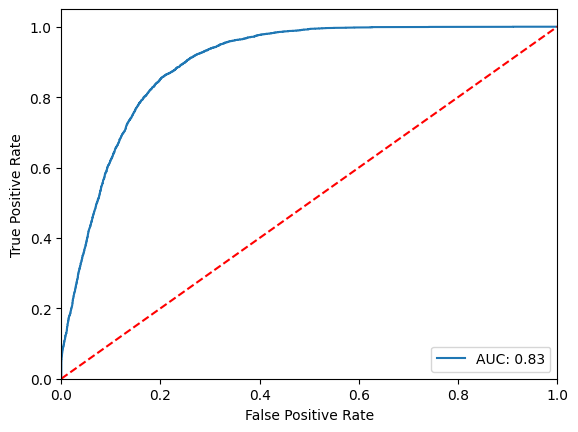

In [49]:
y_pred = extra_trees_randomized_search.predict(X_test)
y_pred_proba = extra_trees_randomized_search.predict_proba(X_test)
print(f'Train accuracy: {round(extra_trees_randomized_search.best_score_, 2)}')
print_performance(y_test, y_pred, y_pred_proba)

## 8. AdaBoost

### 8.a Simple AdaBoost

In [50]:
adaboost_cls = AdaBoostClassifier(base_estimator=ExtraTreesClassifier(random_state=semilla), n_estimators=100)

adaboost_cls.fit(X_train,y_train)

c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\utils\validation.py:1141: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


AdaBoostClassifier(base_estimator=ExtraTreesClassifier(random_state=2023),
                   n_estimators=100)

Train accuracy: 1.0
Accuracy: 0.893486
Precision: 0.584407
Recall: 0.930132
F1 score: 0.717810
AUC: 0.908685


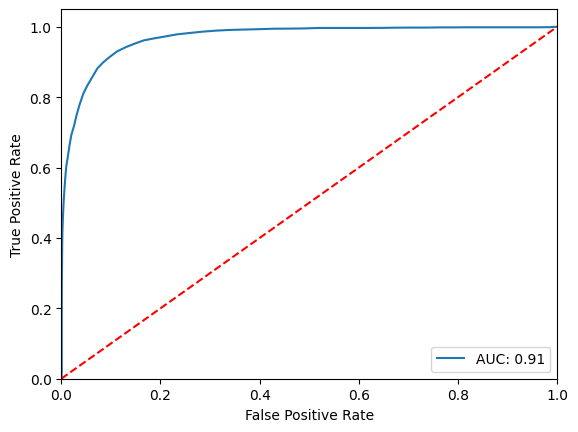

In [51]:
y_pred = adaboost_cls.predict(X_test)
y_pred_proba = adaboost_cls.predict_proba(X_test)
print(f'Train accuracy: {round(adaboost_cls.score(X_train,y_train), 2)}')
print_performance(y_test, y_pred, y_pred_proba)

## 9. GradientBoosting

### 9.a Simple GradientBoosting

In [52]:
grad_boost_cls = GradientBoostingClassifier()

grad_boost_cls.fit(X_train,y_train)

c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


GradientBoostingClassifier()

Train accuracy: 0.79
Accuracy: 0.725051
Precision: 0.325114
Recall: 0.825196
F1 score: 0.466453
AUC: 0.766587


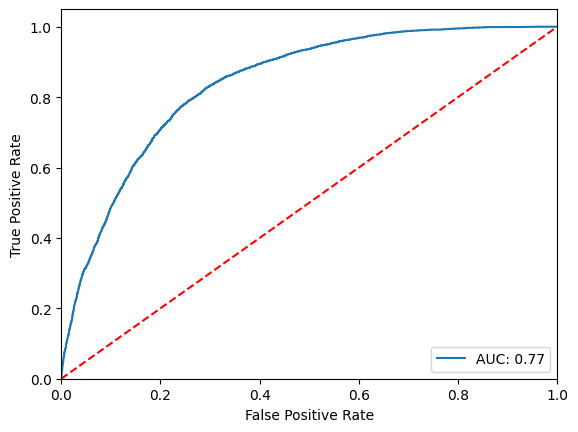

In [53]:
y_pred = grad_boost_cls.predict(X_test)
y_pred_proba = grad_boost_cls.predict_proba(X_test)
print(f'Train accuracy: {round(grad_boost_cls.score(X_train,y_train), 2)}')
print_performance(y_test, y_pred, y_pred_proba)

## 9. XGBoost

### 9.a Simple XGBoost

In [10]:
xgb = XGBClassifier(n_jobs=3, eval_metric="logloss", use_label_encoder=False)
xgb.fit(X_train,y_train)

c:\Users\Felipe\miniconda3\lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, gpu_id=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=100, n_jobs=3,
              num_parallel_tree=None, predictor=None, random_state=None, ...)

Train accuracy: 0.99
Accuracy: 0.864844
Precision: 0.520054
Recall: 0.933909
F1 score: 0.668082
AUC: 0.893489


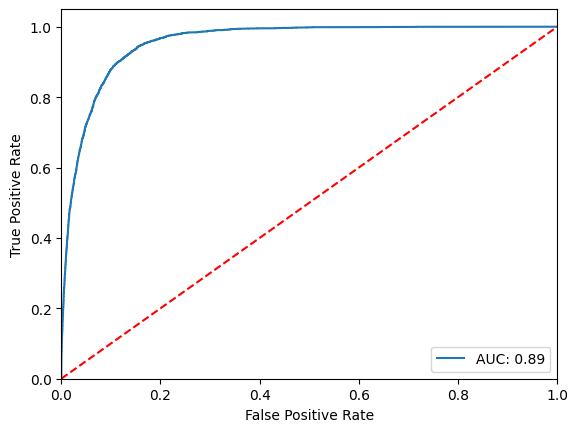

In [11]:
print(f'Train accuracy: {round(xgb.score(X_train,y_train), 2)}')
y_pred = xgb.predict(X_test)
y_pred_proba = xgb.predict_proba(X_test)
print_performance(y_test, y_pred, y_pred_proba)

### 9.b XGBooost Hyperparameter opt

In [12]:
xgboost_parameter = {
    'max_depth':list(range(3,15))+[None],
    'n_estimators': [100, 200, 300, 400, 500, 600, 700, 800, 900, 1000],
    'learning_rate': [0.01, 0.05, 0.1, 0.3, 0.5, 0.7],
    'subsample': [0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
    'colsample_bytree': [0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
    'colsample_bylevel': [0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
    'min_child_weight': range(1, 10, 1),
    'booster': ['gbtree', 'gblinear'],
    'gamma': [0, 0.5, 1],
    'reg_alpha': [0, 0.5, 1],
    'reg_lambda': [0.5, 1, 5],
    'base_score': [0.2, 0.5, 1]
}

In [13]:
n_iter = 50
cv = 3

xgb = XGBClassifier()

xgb_randomized_search = RandomizedSearchCV(estimator=xgb, 
                                         param_distributions=xgboost_parameter, n_iter=n_iter, cv=cv, scoring='accuracy', verbose=2)

xgb_randomized_search.fit(X_train, y_train)

Fitting 3 folds for each of 50 candidates, totalling 150 fits
[CV] END base_score=1, booster=gbtree, colsample_bylevel=0.8, colsample_bytree=0.5, gamma=1, learning_rate=0.3, max_depth=7, min_child_weight=4, n_estimators=600, reg_alpha=0.5, reg_lambda=5, subsample=0.6; total time=   0.1s
[CV] END base_score=1, booster=gbtree, colsample_bylevel=0.8, colsample_bytree=0.5, gamma=1, learning_rate=0.3, max_depth=7, min_child_weight=4, n_estimators=600, reg_alpha=0.5, reg_lambda=5, subsample=0.6; total time=   0.1s
[CV] END base_score=1, booster=gbtree, colsample_bylevel=0.8, colsample_bytree=0.5, gamma=1, learning_rate=0.3, max_depth=7, min_child_weight=4, n_estimators=600, reg_alpha=0.5, reg_lambda=5, subsample=0.6; total time=   0.1s
[10:20:19] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-08de971ced8a8cdc6-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "colsample_bylevel", "colsample_bytree", "gamma", "max_depth", "min_child_weight", "subsam

c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:378: FitFailedWarning: 
63 fits failed out of a total of 150.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
3 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\Felipe\miniconda3\lib\site-packages\xgboost\core.py", line 620, in inner_f
    return func(**kwargs)
  File "c:\Users\Felipe\miniconda3\lib\site-packages\xgboost\sklearn.py", line 1490, in fit
    self._Booster = train(
  File "c:\Users\Felipe\miniconda3\lib\site-packages\xgboost\core.py"

RandomizedSearchCV(cv=3,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric=None, feature_types=None,
                                           gamma=None, gpu_id=None,
                                           grow_policy=None,
                                           importance_type=None,
                                           interaction_constraints=None,
                                           learning_rate...
                                        'colsample_bytree': [0.5, 0.6, 0.7, 0.8,
                                                             0.9, 1.0],
                                        'gamma': [0, 0.5, 1],
                                        'learning_rate': [0.01, 0.05, 0.1, 0.3,
                                                          0.5, 0.7],
                                        'max_depth': [3, 4, 5, 6, 7, 8, 9, 10,
                                                      11, 12, 13, 14, None],
                                        'min_child_weight': range(1, 10),
                                        'n_estimators': [100, 200, 300, 400,
                                                         500, 600, 700, 800,
                                                         900, 1000],
                                        'reg_alpha': [0, 0.5, 1],
                                        'reg_lambda': [0.5, 1, 5],
                                        'subsample': [0.5, 0.6, 0.7, 0.8, 0.9,
                                                      1.0]},
                   scoring='accuracy', verbose=2)

Train accuracy: 0.92
Accuracy: 0.925350
Precision: 0.664362
Recall: 0.985163
F1 score: 0.793568
AUC: 0.950158


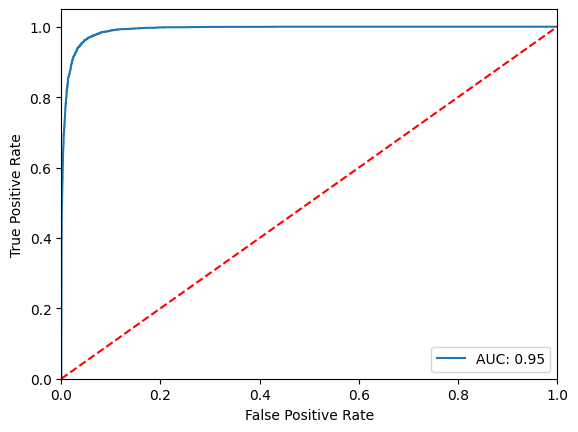

In [14]:
print(f'Train accuracy: {round(xgb_randomized_search.best_score_, 2)}')
y_pred = xgb_randomized_search.predict(X_test)
y_pred_proba = xgb_randomized_search.predict_proba(X_test)
print_performance(y_test, y_pred, y_pred_proba)

In [15]:
save_model(xgb_randomized_search, '300D_bert_xgb_randomized_search.sav')

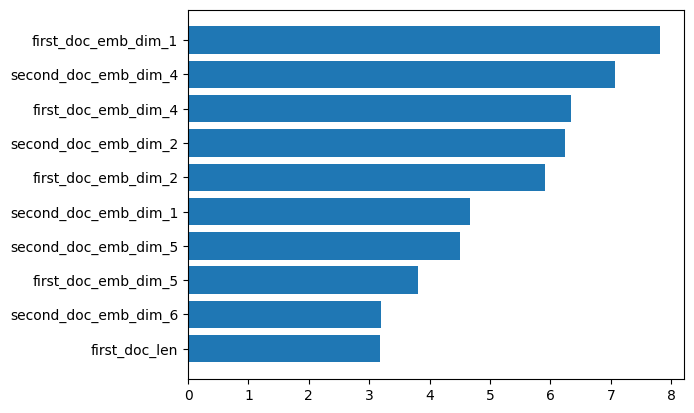

In [58]:
importance = xgb_randomized_search.best_estimator_.get_booster().get_score(importance_type='gain') # Importance: gain
sorted_importance = dict(sorted(importance.items(), key=lambda x: x[1], reverse=True)) # Sort by descending importance

top_n = dict(list(sorted_importance.items())[:10]) # Keep top N

# Plot
plt.barh(range(len(top_n)), list(top_n.values())[::-1], align='center')
plt.yticks(range(len(top_n)), list(top_n.keys())[::-1])
plt.show()

## 10. LightGBM

### 10.a Simple LightGBM

In [21]:
lgbm = LGBMClassifier(n_jobs=3, verbose=-1)
lgbm.fit(X_train,y_train)

c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\preprocessing\_label.py:99: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\preprocessing\_label.py:134: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


LGBMClassifier(n_jobs=3, verbose=-1)

Train accuracy: 0.92
Accuracy: 0.836398
Precision: 0.469101
Recall: 0.935797
F1 score: 0.624932
AUC: 0.877625


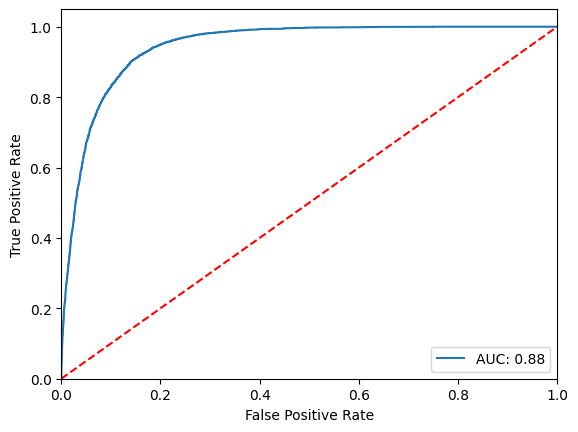

In [23]:
print(f'Train accuracy: {round(lgbm.score(X_train,y_train), 2)}')
y_pred = lgbm.predict(X_test)
y_pred_proba = lgbm.predict_proba(X_test)
print_performance(y_test, y_pred, y_pred_proba)

## 11. CatBoost

### 11.a Simple CatBoost

In [60]:
catb = CatBoostClassifier(thread_count=3, verbose=False)
catb.fit(X_train,y_train)

Train accuracy: 0.97
Accuracy: 0.877181
Precision: 0.544893
Recall: 0.951173
F1 score: 0.692867
AUC: 0.907870


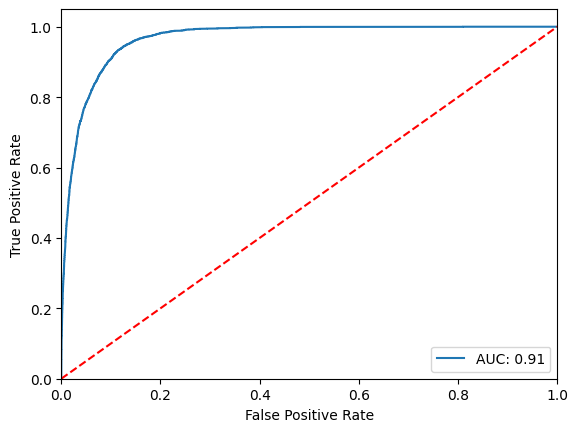

In [61]:
print(f'Train accuracy: {round(catb.score(X_train,y_train), 2)}')
y_pred = catb.predict(X_test)
y_pred_proba = catb.predict_proba(X_test)
print_performance(y_test, y_pred, y_pred_proba)

### 11.b CatBoost hyperparameter opt

In [26]:
catb_parameters = {
    'iterations': [100, 200, 300, 400, 500, 600, 700, 800, 900, 1000],
    'learning_rate': [0.01, 0.05, 0.1, 0.3, 0.5, 0.7],
    'depth': range(3, 15, 1),
    'l2_leaf_reg': [1, 3, 5, 7, 9],
    'border_count': [32, 64, 96, 128, 160],
    'bagging_temperature': [0, 0.1, 0.5, 1, 2, 5],
    'random_strength': [0, 0.1, 0.5, 1, 2, 5],
    'auto_class_weights': ['None', 'Balanced', 'SqrtBalanced'],
    'leaf_estimation_method': ['Newton', 'Gradient', 'Exact'],
    'eval_metric': ['Logloss', 'AUC', 'F1', 'Accuracy', 'Precision', 'Recall']
}


In [27]:
n_iter = 50
cv = 3

catb = CatBoostClassifier()

catb_randomized_search = RandomizedSearchCV(estimator= catb, 
                                         param_distributions= catb_parameters, n_iter=n_iter, cv=cv, scoring='accuracy', n_jobs=None, verbose=2)

catb_randomized_search.fit(X_train, y_train)

Fitting 3 folds for each of 50 candidates, totalling 150 fits
0:	learn: 0.6917308	total: 5.82s	remaining: 1h 7m 44s
1:	learn: 0.7626685	total: 11.5s	remaining: 1h 6m 37s
2:	learn: 0.8070472	total: 17s	remaining: 1h 5m 43s
3:	learn: 0.8488798	total: 22.5s	remaining: 1h 5m 21s
4:	learn: 0.8851507	total: 28.1s	remaining: 1h 5m 5s
5:	learn: 0.9035075	total: 33.7s	remaining: 1h 5m
6:	learn: 0.9298934	total: 39.3s	remaining: 1h 4m 51s
7:	learn: 0.9419335	total: 45s	remaining: 1h 4m 49s
8:	learn: 0.9544220	total: 51s	remaining: 1h 5m 15s
9:	learn: 0.9753565	total: 57.4s	remaining: 1h 5m 58s
10:	learn: 0.9833039	total: 1m 3s	remaining: 1h 6m 4s
11:	learn: 0.9895939	total: 1m 9s	remaining: 1h 6m 35s
12:	learn: 0.9928727	total: 1m 15s	remaining: 1h 6m 34s
13:	learn: 0.9953987	total: 1m 21s	remaining: 1h 6m 27s
14:	learn: 0.9966105	total: 1m 27s	remaining: 1h 6m 18s
15:	learn: 0.9975226	total: 1m 33s	remaining: 1h 6m 19s
16:	learn: 0.9979780	total: 1m 38s	remaining: 1h 6m 14s
17:	learn: 0.9984835

KeyboardInterrupt: 

In [ ]:
print(f'Train accuracy: {round(catb_randomized_search.best_score_, 2)}')
y_pred = catb_randomized_search.predict(X_test)
y_pred_proba = catb_randomized_search.predict_proba(X_test)
print_performance(y_test, y_pred, y_pred_proba)

NameError: name 'catb_randomized_search' is not defined

# Evaluating the model for each desafio

In [16]:
xgb_cls = load_model('300D_bert_xgb_randomized_search.sav')

In [63]:
# Partición en train y test
y = df_predic_scaled.loc[:, df_predic_scaled.columns == 'target']['target'].values.tolist()
X = df_predic_scaled.loc[:, df_predic_scaled.columns != 'target']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=semilla)


Desafio: 15
Accuracy: 0.952868
Precision: 0.780712
Recall: 0.989811
F1 score: 0.872914
AUC: 0.967728


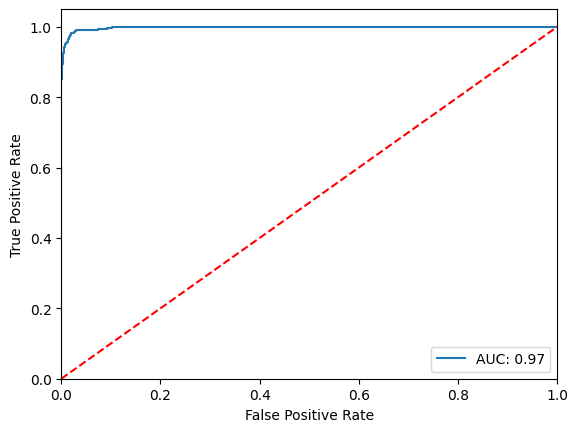


Desafio: 13
Accuracy: 0.949724
Precision: 0.797567
Recall: 0.995662
F1 score: 0.885673
AUC: 0.967108


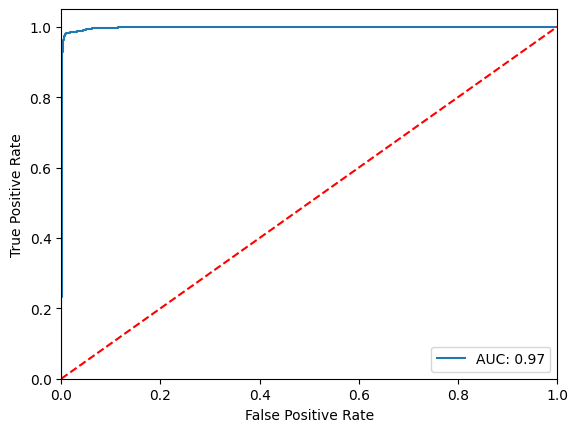


Desafio: 14
Accuracy: 0.982988
Precision: 0.880000
Recall: 0.992874
F1 score: 0.933036
AUC: 0.987261


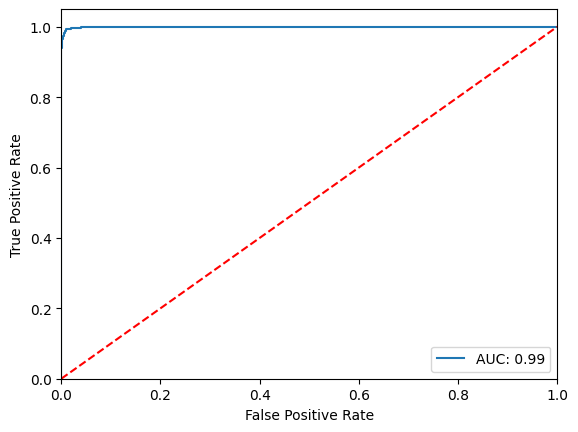


Desafio: 12
Accuracy: 0.916127
Precision: 0.611797
Recall: 0.967462
F1 score: 0.749580
AUC: 0.937968


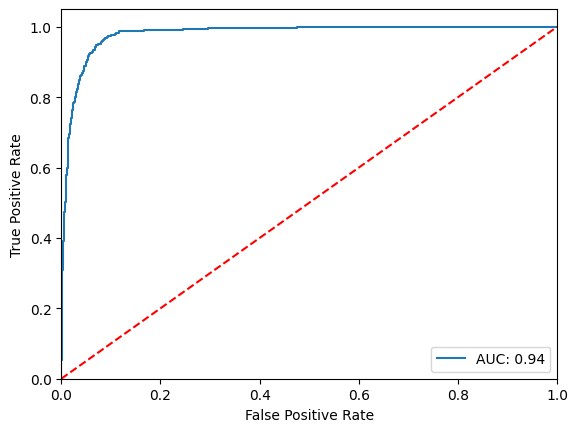


Desafio: 16
Accuracy: 0.934525
Precision: 0.701094
Recall: 0.994828
F1 score: 0.822523
AUC: 0.959251


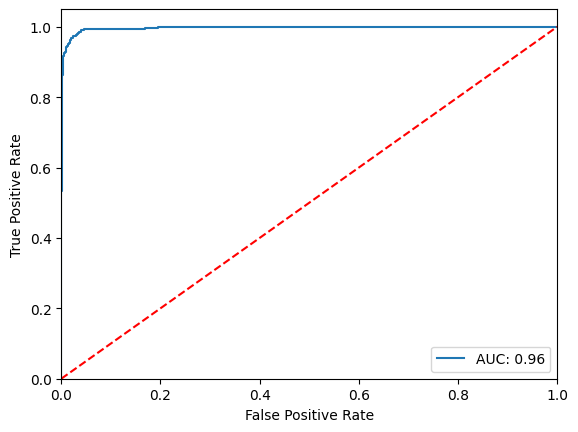


Desafio: 17
Accuracy: 0.948043
Precision: 0.670282
Recall: 0.993569
F1 score: 0.800518
AUC: 0.968138


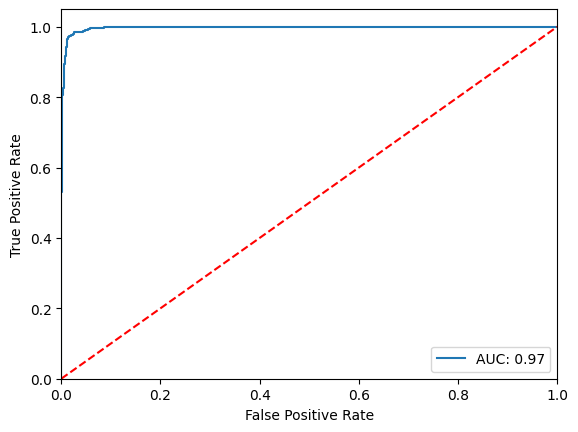


Desafio: 18
Accuracy: 0.932342
Precision: 0.642147
Recall: 0.993846
F1 score: 0.780193
AUC: 0.958868


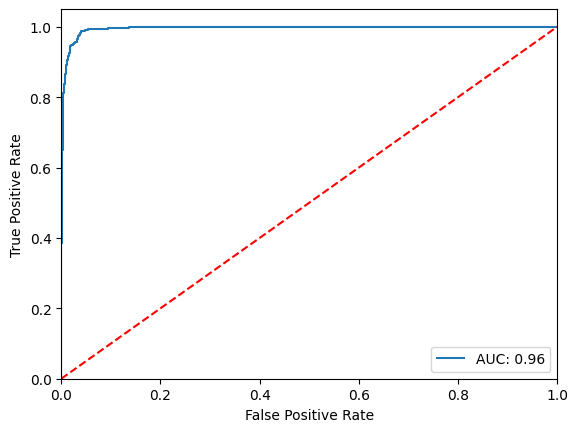

In [64]:
for des in df.desafio.unique():
    
    print(f'\nDesafio: {des}')
    
    indices_des = [i for i,x in enumerate(X_test['id_pairs'].values) if x[0] in df[df['desafio']==des]['ID'].values]

    X_test_des = X_test.iloc[indices_des].drop('id_pairs', axis=1)

    y_test_des = [x for i,x in enumerate(y_test) if i in indices_des]
    
    y_pred = xgb_cls.predict(X_test_des)
    y_pred_proba = xgb_cls.predict_proba(X_test_des)
    print_performance(y_test_des, y_pred, y_pred_proba)

### Metrics Graphs

AUC 0.9732347142857142 0.956061 red
F1 score 0.8677742857142857 0.773109 red
Recall 0.9940817142857142 0.990769 red
Precision 0.7766534285714286 0.633858 red
Accuracy 0.958096 0.92974 red


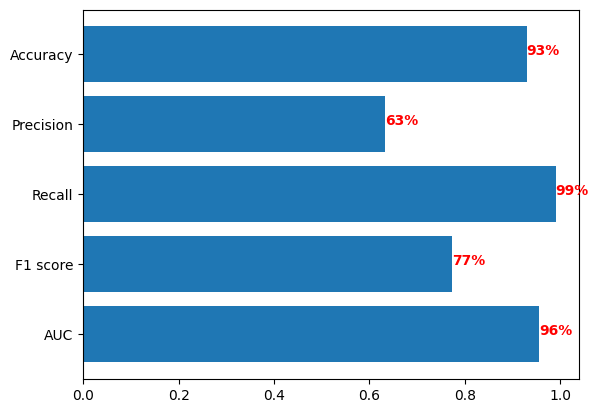

In [ ]:
metricas = ['Accuracy', 'Precision', 'Recall', 'F1 score', 'AUC'][::-1]

valores_12 = [0.933014, 0.661829, 0.989154, 0.793043, 0.956899][::-1]
valores_13 = [0.966271, 0.853568, 0.998915, 0.920540, 0.978624][::-1]
valores_14 = [0.991778, 0.937500, 0.997625, 0.966628, 0.994305][::-1]
valores_15 = [0.974530, 0.868957, 0.994178, 0.927359, 0.982433][::-1]
valores_16 = [0.961609, 0.804775, 0.987931, 0.886997, 0.972402][::-1]
valores_17 = [0.949730, 0.676087, 1.000000, 0.806744, 0.971919][::-1]
valores_18 = [0.929740, 0.633858, 0.990769, 0.773109, 0.956061][::-1]

extra_trees = [0.914388, 0.634365, 0.973024, 0.768019, 0.938708][::-1]
general_xgboost = [0.960042, 0.787270, 0.994335, 0.878770, 0.974266][::-1]

# create horizontal bar plot
fig, ax = plt.subplots()
ax.barh(metricas, valores_18)

# add x value as label to each bar
for i, v in enumerate(valores_18):
    
    all_valores = valores_12[i]+valores_13[i]+valores_14[i]+valores_15[i]+valores_16[i]+valores_17[i]+valores_18[i]
    
    color = ['blue' if v >= all_valores/7 else 'red'][0]
    
    print(metricas[i],all_valores/7, v, color)
    
    ax.text(v, i, str(round(v*100))+'%', color=color, fontweight='bold')

plt.show()

# Evaluating model for each PAIR of desafios

In [ ]:
xgb_cls = load_model('bert_xgb_randomized_search.sav')

In [18]:
# 1. Load dfs
df_predic = pd.read_csv('./Datasets/df_predic_reduced_300d.csv')
df_predic['id_pairs'] = df_predic['id_pairs'].apply(lambda x: string_to_tuple(x)) # recovering tuples

# 2. Scale it
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaled = scaler.fit_transform(df_predic.drop(['id_pairs','target'], axis=1))
df_predic_scaled = pd.DataFrame(scaled, columns = df_predic.columns[2:])
df_predic_scaled = df_predic_scaled.join(df_predic[['id_pairs','target']])


# 3. train - test split
from sklearn.model_selection import train_test_split
y = df_predic_scaled.loc[:, df_predic_scaled.columns == 'target']['target'].values.tolist()
X = df_predic_scaled.loc[:, df_predic_scaled.columns != 'target']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=semilla)

# 4. Subsampling
train = X_train
train['target'] = y_train
positivos = train[train.target == 1]
negativos = train[train.target == 0]
negativos_sub = negativos.sample(n=len(positivos), random_state=semilla)
train_sub = pd.concat([positivos, negativos_sub])
y_train = train_sub.loc[:, train_sub.columns == 'target']
X_train = train_sub.loc[:, train_sub.columns != 'target']
print(len(positivos), len(negativos_sub))

14817 14817



Desafios: 15 and 13
Accuracy: 0.986235
Precision: 0.981241
Recall: 0.989811
F1 score: 0.985507
AUC: 0.986420


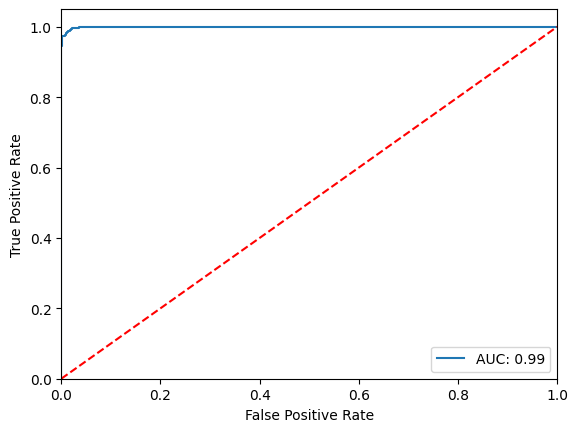


Desafios: 15 and 14
Accuracy: 0.979815
Precision: 0.975610
Recall: 0.989811
F1 score: 0.982659
AUC: 0.977973


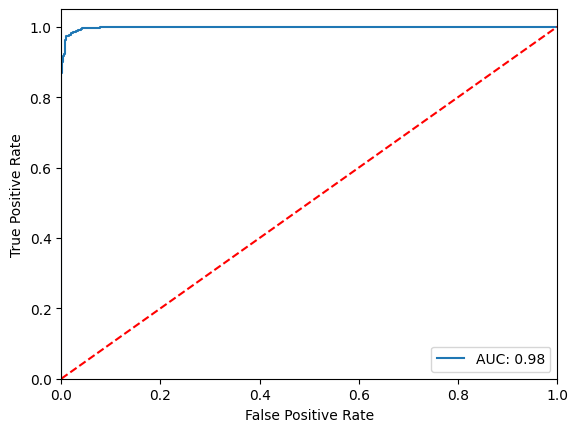


Desafios: 15 and 12
Accuracy: 0.961221
Precision: 0.944444
Recall: 0.989811
F1 score: 0.966596
AUC: 0.956810


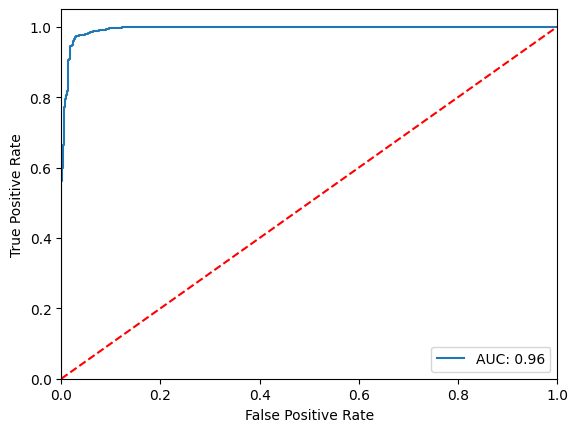


Desafios: 15 and 16
Accuracy: 0.846939
Precision: 0.770102
Recall: 0.989811
F1 score: 0.866242
AUC: 0.846730


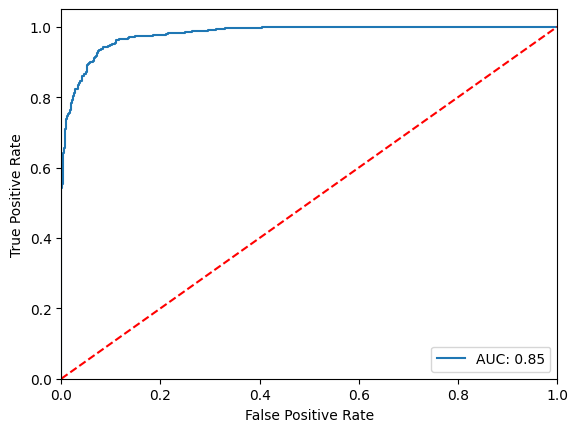


Desafios: 15 and 17
Accuracy: 0.987231
Precision: 0.986938
Recall: 0.989811
F1 score: 0.988372
AUC: 0.986955


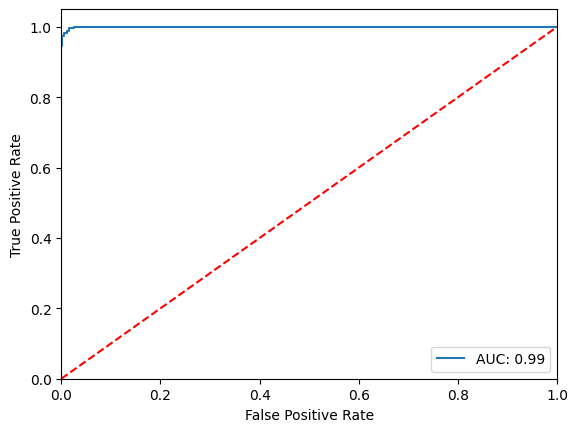


Desafios: 15 and 18
Accuracy: 0.991357
Precision: 0.995608
Recall: 0.989811
F1 score: 0.992701
AUC: 0.991714


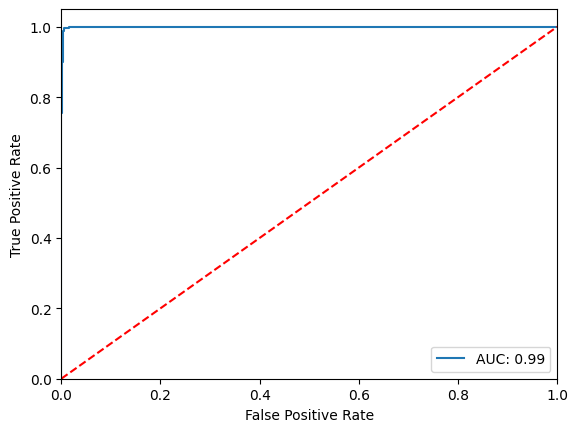


Desafios: 13 and 15
Accuracy: 0.984724
Precision: 0.981720
Recall: 0.990239
F1 score: 0.985961
AUC: 0.984222


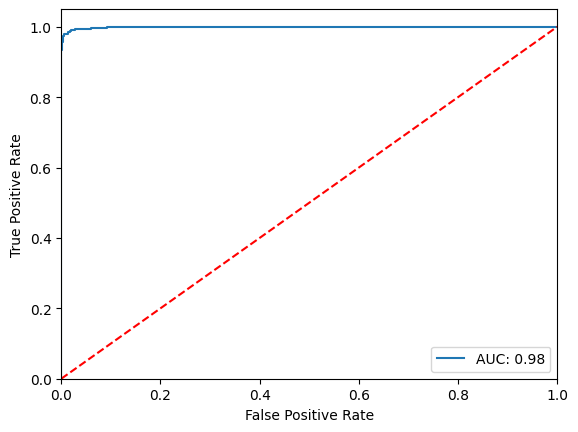


Desafios: 13 and 14
Accuracy: 0.983176
Precision: 0.982777
Recall: 0.990239
F1 score: 0.986494
AUC: 0.980935


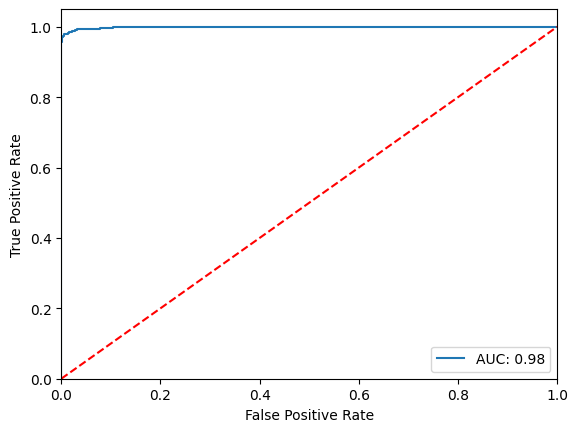


Desafios: 13 and 12
Accuracy: 0.813582
Precision: 0.771115
Recall: 0.990239
F1 score: 0.867047
AUC: 0.761499


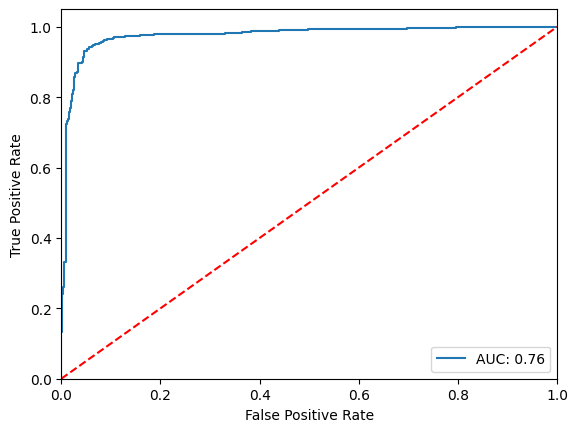


Desafios: 13 and 16
Accuracy: 0.989051
Precision: 0.990239
Recall: 0.990239
F1 score: 0.990239
AUC: 0.988887


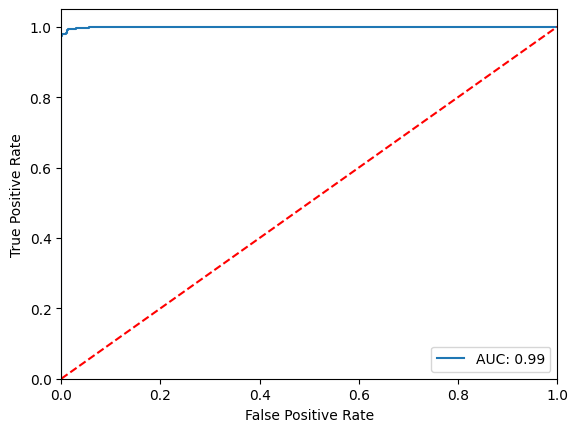


Desafios: 13 and 17
Accuracy: 0.994063
Precision: 1.000000
Recall: 0.990239
F1 score: 0.995095
AUC: 0.995119


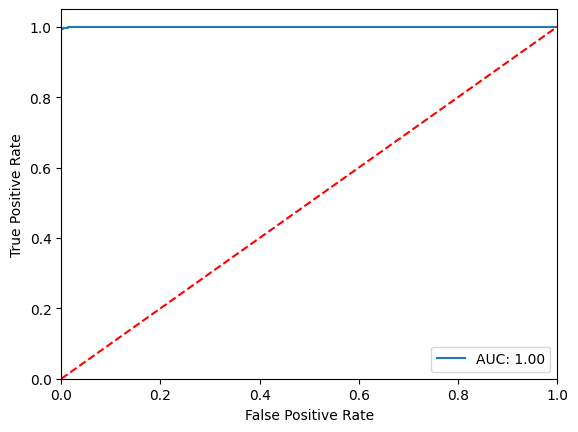


Desafios: 13 and 18
Accuracy: 0.993894
Precision: 1.000000
Recall: 0.990239
F1 score: 0.995095
AUC: 0.995119


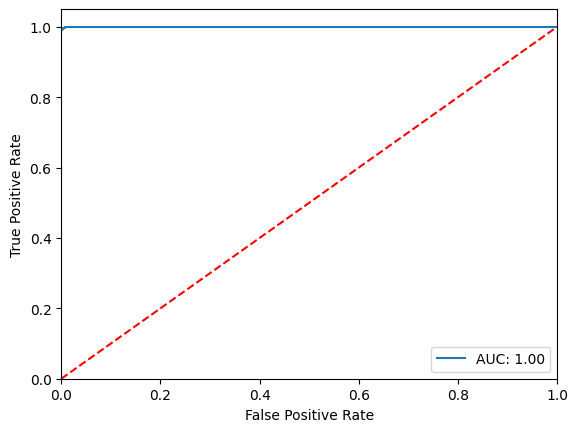


Desafios: 14 and 15
Accuracy: 0.971944
Precision: 0.939597
Recall: 0.997625
F1 score: 0.967742
AUC: 0.975415


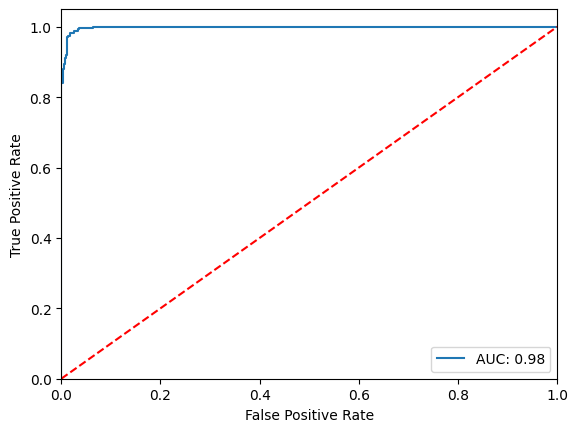


Desafios: 14 and 13
Accuracy: 0.983666
Precision: 0.961098
Recall: 0.997625
F1 score: 0.979021
AUC: 0.986331


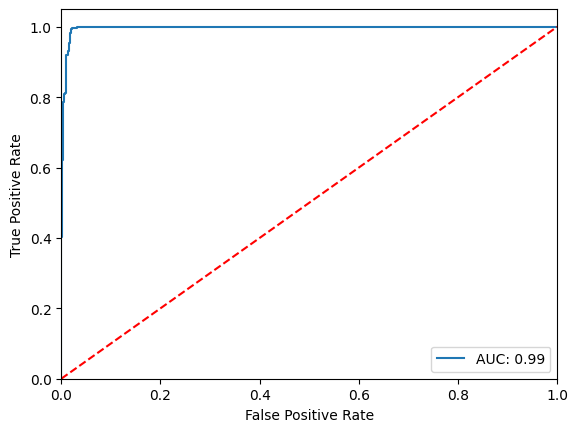


Desafios: 14 and 12
Accuracy: 0.940230
Precision: 0.891720
Recall: 0.997625
F1 score: 0.941704
AUC: 0.942019


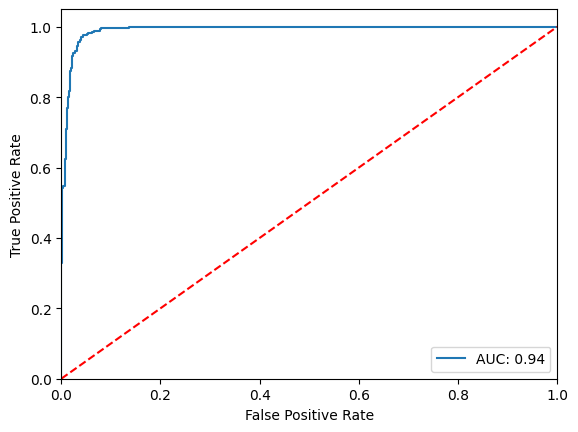


Desafios: 14 and 16
Accuracy: 0.988482
Precision: 0.976744
Recall: 0.997625
F1 score: 0.987074
AUC: 0.989449


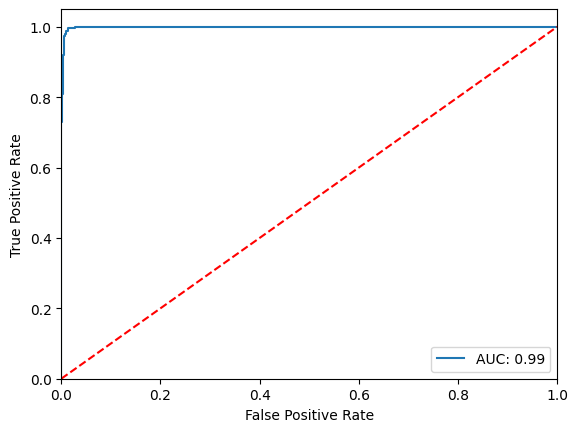


Desafios: 14 and 17
Accuracy: 0.982798
Precision: 0.967742
Recall: 0.997625
F1 score: 0.982456
AUC: 0.983291


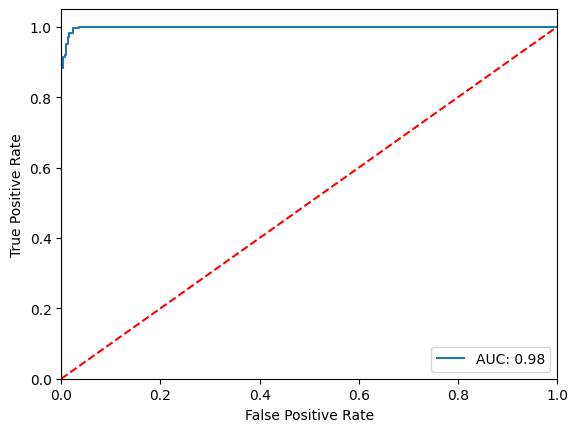


Desafios: 14 and 18
Accuracy: 0.998802
Precision: 1.000000
Recall: 0.997625
F1 score: 0.998811
AUC: 0.998812


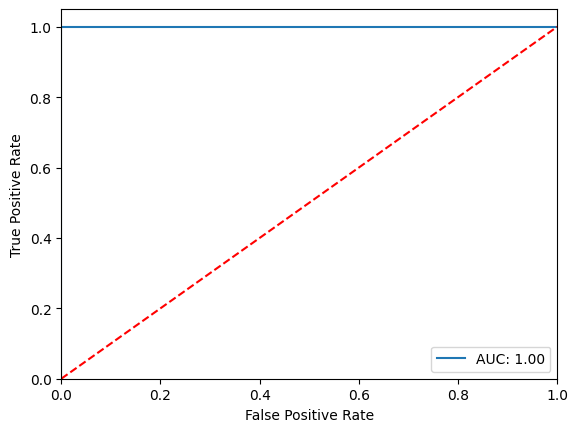


Desafios: 12 and 15
Accuracy: 0.955535
Precision: 0.940426
Recall: 0.958785
F1 score: 0.949517
AUC: 0.955903


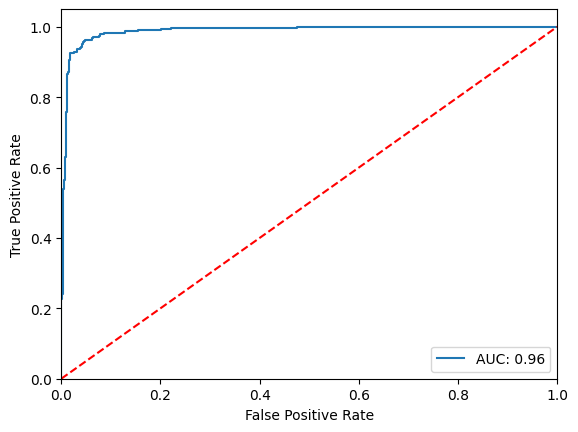


Desafios: 12 and 13
Accuracy: 0.720785
Precision: 0.600543
Recall: 0.958785
F1 score: 0.738513
AUC: 0.756665


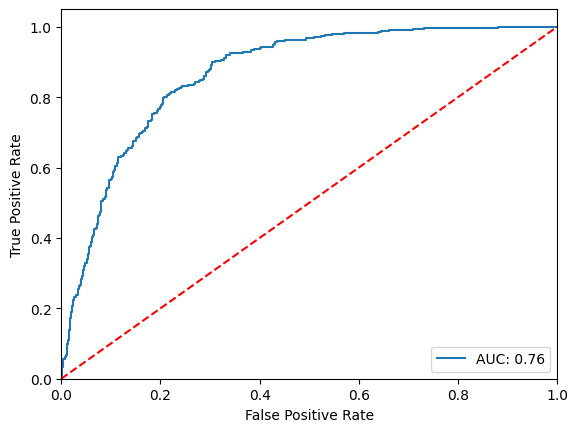


Desafios: 12 and 14
Accuracy: 0.921708
Precision: 0.903885
Recall: 0.958785
F1 score: 0.930526
AUC: 0.917874


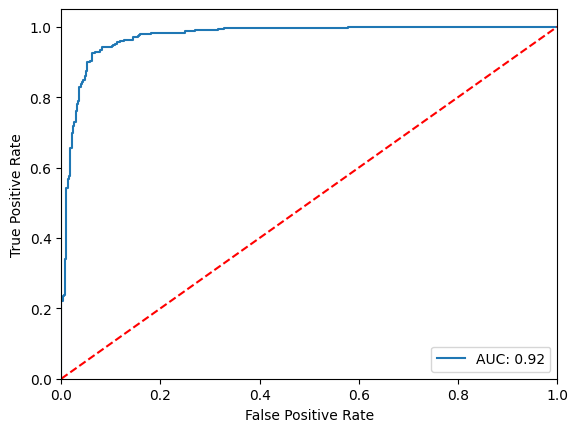


Desafios: 12 and 16
Accuracy: 0.965318
Precision: 0.962963
Recall: 0.958785
F1 score: 0.960870
AUC: 0.964661


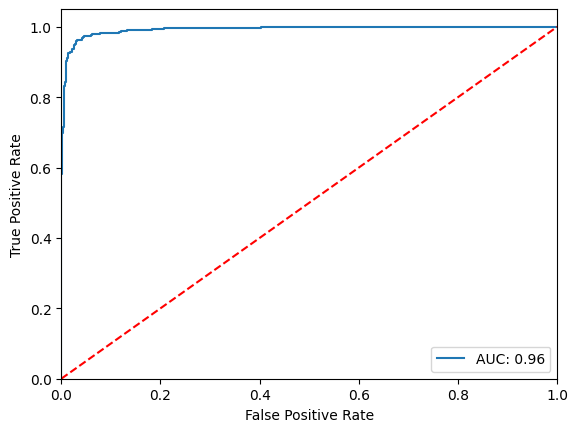


Desafios: 12 and 17
Accuracy: 0.977876
Precision: 0.997743
Recall: 0.958785
F1 score: 0.977876
AUC: 0.978264


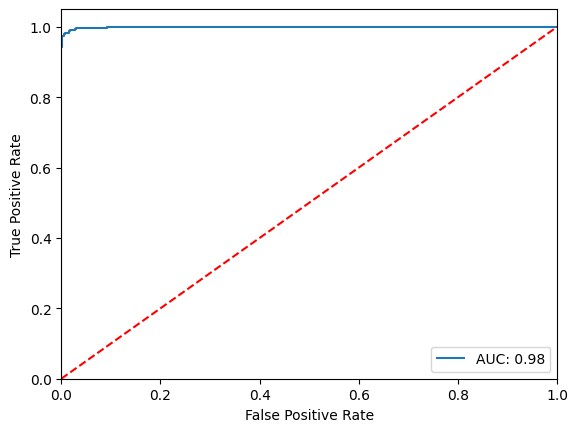


Desafios: 12 and 18
Accuracy: 0.978771
Precision: 1.000000
Recall: 0.958785
F1 score: 0.978959
AUC: 0.979393


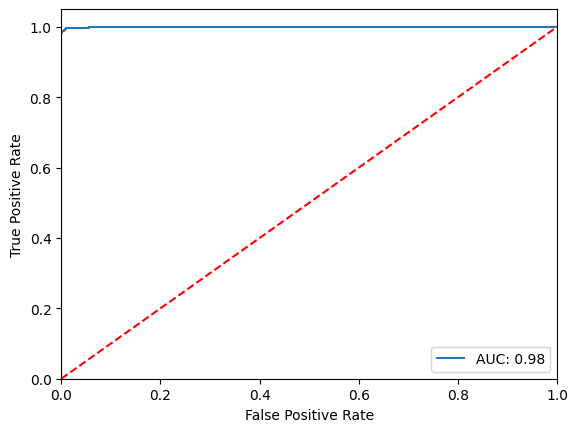


Desafios: 16 and 15
Accuracy: 0.814286
Precision: 0.728081
Recall: 0.987931
F1 score: 0.838332
AUC: 0.818556


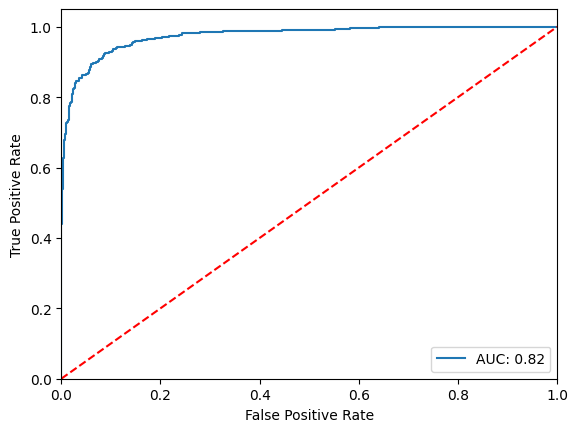


Desafios: 16 and 13
Accuracy: 0.982998
Precision: 0.974490
Recall: 0.987931
F1 score: 0.981164
AUC: 0.983461


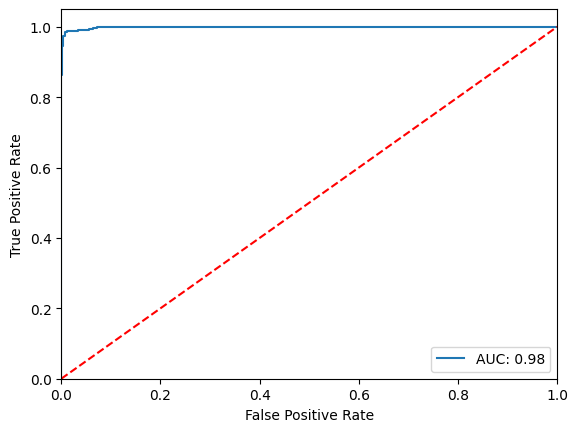


Desafios: 16 and 14
Accuracy: 0.968597
Precision: 0.958194
Recall: 0.987931
F1 score: 0.972835
AUC: 0.965492


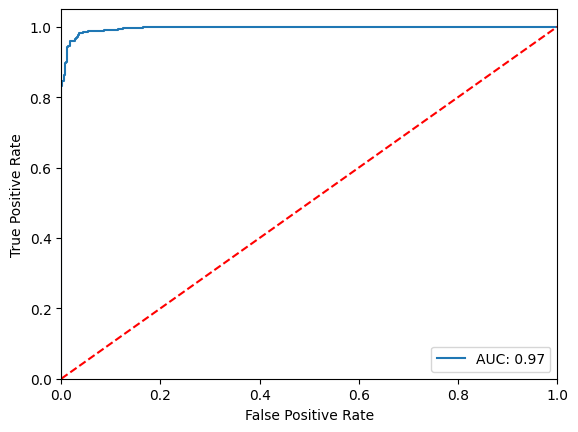


Desafios: 16 and 12
Accuracy: 0.939680
Precision: 0.909524
Recall: 0.987931
F1 score: 0.947107
AUC: 0.934714


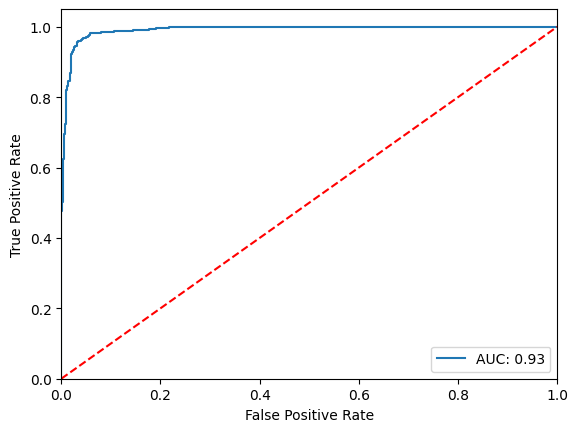


Desafios: 16 and 17
Accuracy: 0.981917
Precision: 0.977816
Recall: 0.987931
F1 score: 0.982847
AUC: 0.981608


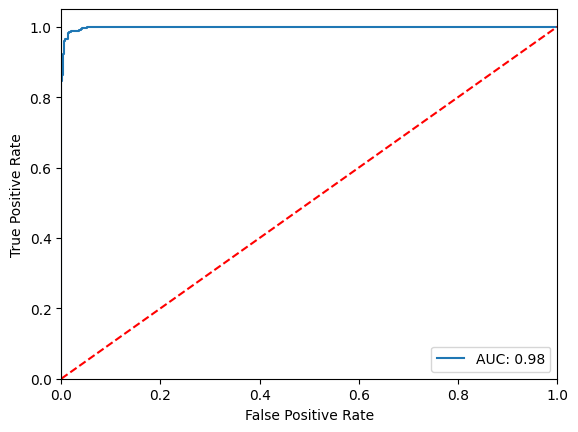


Desafios: 16 and 18
Accuracy: 0.989351
Precision: 0.993068
Recall: 0.987931
F1 score: 0.990493
AUC: 0.989551


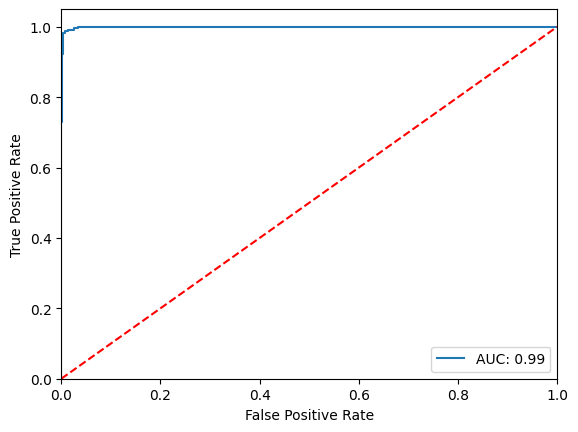


Desafios: 17 and 15
Accuracy: 0.990499
Precision: 0.987138
Recall: 0.987138
F1 score: 0.987138
AUC: 0.989803


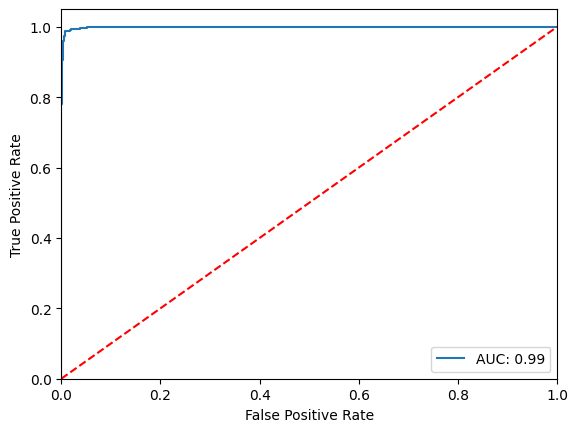


Desafios: 17 and 13
Accuracy: 0.992196
Precision: 0.990323
Recall: 0.987138
F1 score: 0.988728
AUC: 0.991009


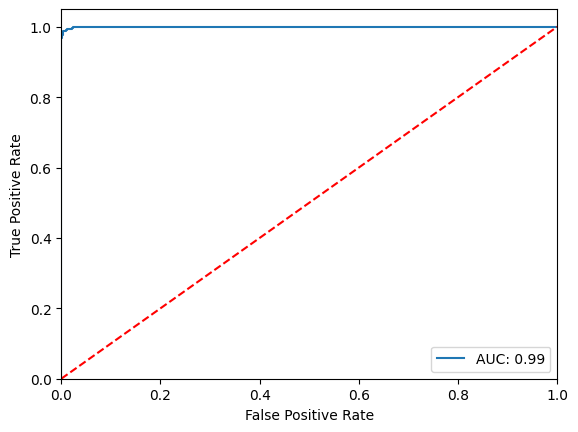


Desafios: 17 and 14
Accuracy: 0.981453
Precision: 0.974603
Recall: 0.987138
F1 score: 0.980831
AUC: 0.981664


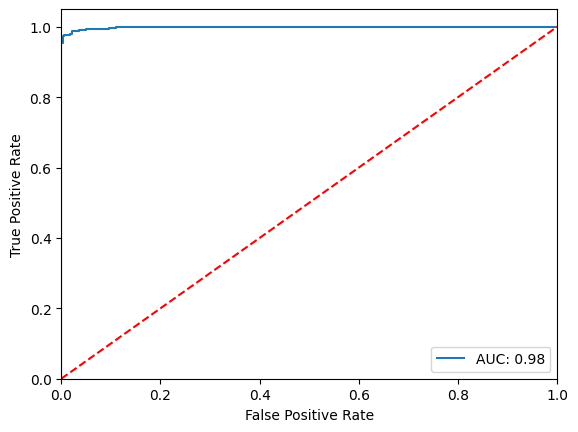


Desafios: 17 and 12
Accuracy: 0.988024
Precision: 0.987138
Recall: 0.987138
F1 score: 0.987138
AUC: 0.987967


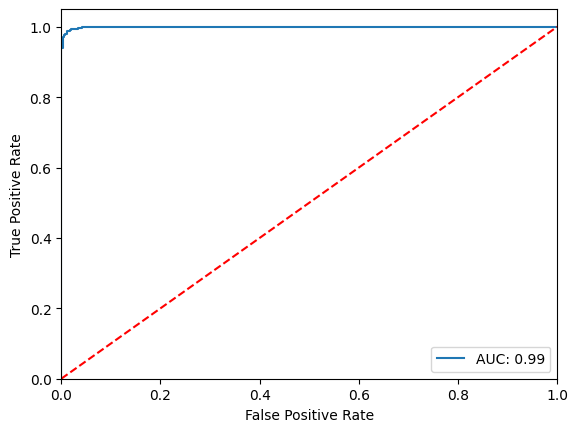


Desafios: 17 and 16
Accuracy: 0.986369
Precision: 0.977707
Recall: 0.987138
F1 score: 0.982400
AUC: 0.986513


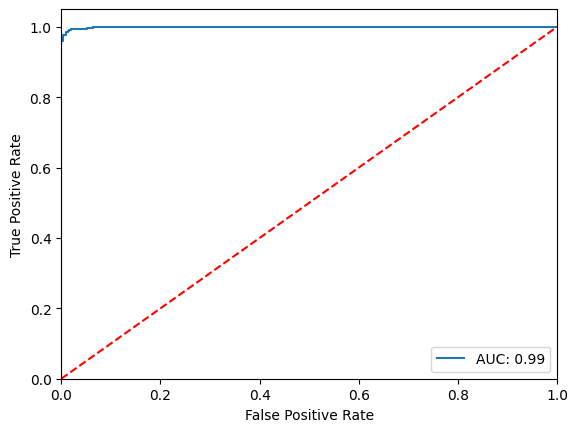


Desafios: 17 and 18
Accuracy: 0.714286
Precision: 0.625255
Recall: 0.987138
F1 score: 0.765586
AUC: 0.728439


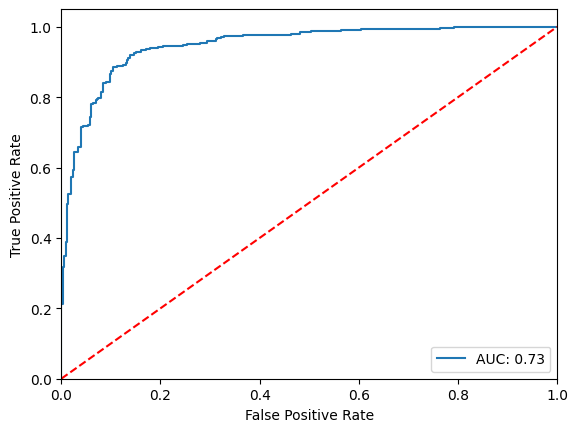


Desafios: 18 and 15
Accuracy: 0.981912
Precision: 0.981424
Recall: 0.975385
F1 score: 0.978395
AUC: 0.981011


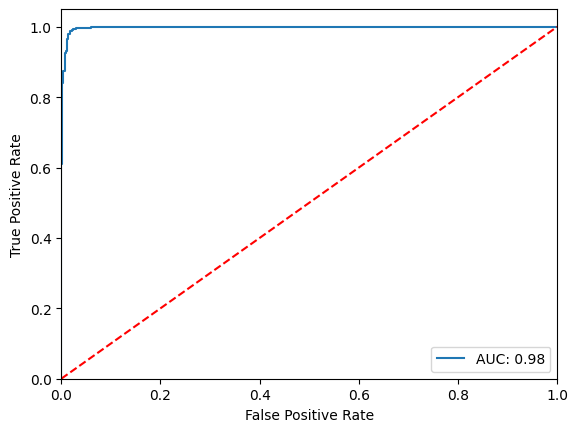


Desafios: 18 and 13
Accuracy: 0.989144
Precision: 0.996855
Recall: 0.975385
F1 score: 0.986003
AUC: 0.986700


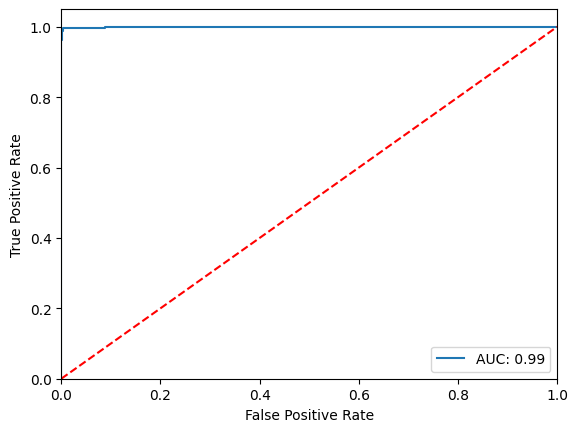


Desafios: 18 and 14
Accuracy: 0.983283
Precision: 0.990625
Recall: 0.975385
F1 score: 0.982946
AUC: 0.983188


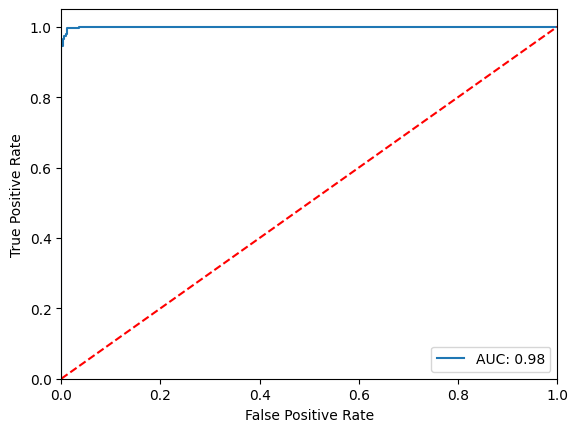


Desafios: 18 and 12
Accuracy: 0.987842
Precision: 1.000000
Recall: 0.975385
F1 score: 0.987539
AUC: 0.987692


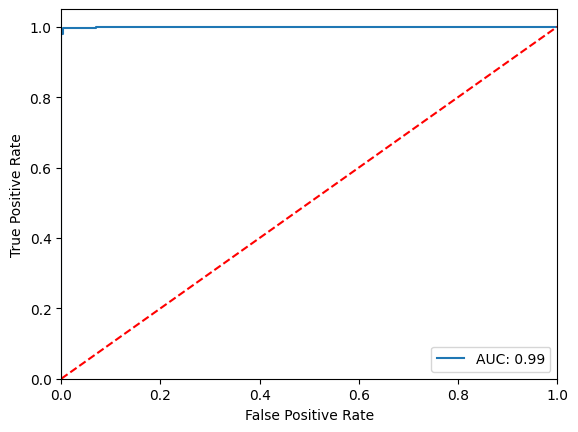


Desafios: 18 and 16
Accuracy: 0.983146
Precision: 0.987539
Recall: 0.975385
F1 score: 0.981424
AUC: 0.982524


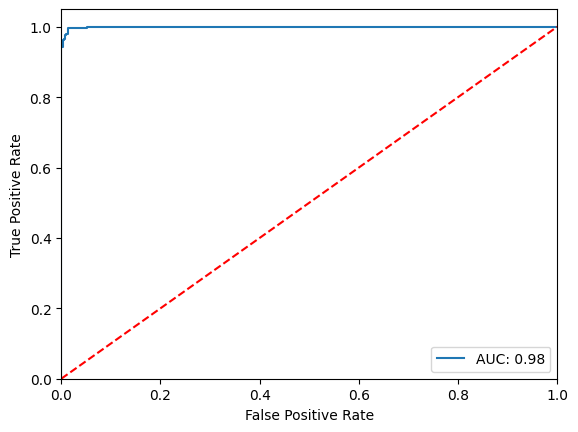


Desafios: 18 and 17
Accuracy: 0.711988
Precision: 0.626482
Recall: 0.975385
F1 score: 0.762936
AUC: 0.724461


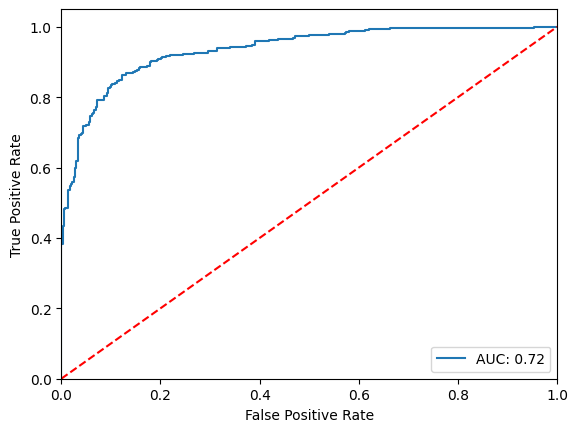

In [19]:
for first_des in df.desafio.unique():
    for second_des in df.desafio.unique():
        if first_des!=second_des:
        
            print(f'\nDesafios: {first_des} and {second_des}')
            
            # Indices where both ideas do not come from the same desafio
            indices_des_false = [i for i,x in enumerate(X_test['id_pairs'].values) if x[0] in df[df['desafio']==first_des]['ID'].values and x[1] in df[df['desafio']==second_des]['ID'].values]
            
            # Indices where both ideas do come from the same desafio
            indices_des_true = [i for i,x in enumerate(X_test['id_pairs'].values) if x[0] in df[df['desafio']==first_des]['ID'].values and x[1] in df[df['desafio']==first_des]['ID'].values]
            
            # final indices
            indices_des = indices_des_false + indices_des_true
            
            X_test_des = X_test.iloc[indices_des].drop('id_pairs', axis=1)

            y_test_des = [y_test[i] for i in indices_des]
            
            y_pred = xgb_cls.predict(X_test_des)
            y_pred_proba = xgb_cls.predict_proba(X_test_des)
            print_performance(y_test_des, y_pred, y_pred_proba)